In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from __future__ import division
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter, WeekdayLocator,\
    DayLocator, MONDAY,date2num,num2date,AutoDateLocator
from matplotlib.finance import quotes_historical_yahoo_ohlc, candlestick_ohlc,candlestick2_ochl,volume_overlay3

from stockapp import models as stkmd
from dataapp import models as dtamd
from dataapp import tasks as dtatks
from dataapp import libs as dtalibs
from featureapp import libs as ftlibs
from featureapp import models as ftmd
from stockapp import tasks as stktks
from stockapp import libs as stklibs
import featureapp.models as ftmd
import featureapp.tasks as fttks
import queryapp.models as qrymd
import queryapp.tasks as qrytks

import charts.chartservers.libs as chservlibs
import charts.libs as chlibs

from datascience import models as dtscmd
from datascience import tasks as dtsctks
from datascience import libs as dtsclibs


import featureapp as ftapp
import utility as uty
from utility import models as utymd
import itertools as itt
import multiprocessing as mp
from django.db import connection,connections
from django.db import reset_queries
import time 
import pandas as pd
import numpy as np
import inspect
import imp
import datetime
from talib.abstract import *
import utility.models as utmd
import stockapp.libs as stklib
from utility import codemanager as cdmng
from utility import maintenance as mnt
import os 
import json
from django.contrib.auth.models import AnonymousUser
import threading

stk=stkmd.Stockmeta.objects.get(Symbol='TSLA')
Fromdate=pd.datetime(2008,1,1)
Todate=pd.datetime.today()
Trange=pd.date_range(Fromdate,Todate)
Trange=[T.date() for T in Trange if T.weekday()<=4]

import json
# fttks.computefeatuers(stk.id,Trange)

/usr/local/lib/python2.7/dist-packages/matplotlib/cbook.py:136: MatplotlibDeprecationWarning: The finance module has been deprecated in mpl 2.0 and will be removed in mpl 2.2. Please use the module mpl_finance instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/usr/local/lib/python2.7/dist-packages/matplotlib/__init__.py:1401: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)
Using TensorFlow backend.
/usr/local/lib/python2.7/dist-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This 

# Charting

In [ ]:
entries=[
    {'Symbol':'TSLA','TF':pd.datetime(2012,1,1).date(),'T0':pd.datetime(2011,1,1).date()  },
    {'Symbol':'AAPL','TF':pd.datetime(2012,1,1).date(),'T0':pd.datetime(2011,1,1).date()  }
]
chservlibs.request_db_charts(entries,5003)
# img=chlibs.CurrentByFutureChart_bydb(entries[0]['T0'],entries[0]['TF'],entries[0]['Symbol'],indicatorlist=(),pricecols=(),querycols=(),featcols=())


# Running Features

In [27]:

import featureapp.models as ftmd
import featureapp.featuremodel as dtaftmd
import featureapp.FeatureCodes.AnonymousUser as FCan

import dataapp.datamanager as dtamng
import stockapp.models as stkmd
import pandas as pd
symbolid=stkmd.Stockmeta.objects.get(Symbol='AAPL').id
Fromdate=pd.datetime(2010,1,1).date()
Todate=pd.datetime(2017,1,1).date()

FM=FCan.features(symbolid,Fromdate,Todate)
FM.filename
FM.Initialize()
FM.ComputeAllFeatures()
FM.saveall_overwrite()
# FM.DM=DataManager(SymbolIds=[Symbolid])
# FM.Trange=filter(lambda x: x>=self.Fromdate and x<=self.Todate,self.DM.TradingDates)
# FM.DM.AddStockData()

# get the feature compute code
# FM.FC=ftmd.FeatureComputeCode.objects.get(Username=self.filename)

# load the features from db
# FM.DM.Addfeaturecols()


TIMING : GetStockData time = 0.115822 on 2017-10-15 06:55:11 with args: ((),{'Symbolids': [1165]}) 
TIMING : GetFeatures time = 0.130154 on 2017-10-15 06:55:11 with args: ((),{'Symbolids': [1165]}) 
TIMING : addindicators time = 0.000890999999999 on 2017-10-15 06:55:11 with args: ((             Close    Open    High     Low     Volume Symbol  Symbol_id  \
T                       ,{}) 
Done compute
Done save


In [28]:
ftmd.FeaturesData.objects.all().delete()

(19814691, {u'featureapp.FeaturesData': 19814691})

In [32]:
import datascience.models as dtscmd 
dtscmd.ComputeFunc.objects.all().delete()
dtscmd.Project.objects.all().delete()

(0, {})

In [ ]:

import featureapp.models as ftmd
import featureapp.featuremodel as dtaftmd
import featureapp.FeatureCodes.AnonymousUser as FCan

import dataapp.datamanager as dtamng
import stockapp.models as stkmd
import pandas as pd
symbolid=stkmd.Stockmeta.objects.get(Symbol='AAPL').id
Fromdate=pd.datetime(2010,1,1).date()
Todate=pd.datetime(2017,1,1).date()

DM.dtamng.DataManager(SymbolIds=[symbolid])

# Running Queries

In [ ]:
querycodes=qrymd.QueryComputeCode.objects.all()
computecode=querycodes[0]
computeclass=computecode.importcomputeclass()
CQ=computeclass(stk.id,Trange)
CQ.computeall(skipdone=True)
CQ.saveall()

In [ ]:
CQ.OutcomeCharts()

In [ ]:
CQ.getquerylist()

In [ ]:
CQ.chartfeatures(addpricecols=(),ip=5562,
addfeatcols=[
    ['CCI5','CCI50'],
    ['PastPROFIT10days','PastLOSS10days'],['FutPROFIT10days','FutLOSS10days']
],
addquerycols=[
    'CCICHERRIES',
]
)

# Registering function

In [ ]:
from datascience import libs as dtsclibs
import pandas as pd

@dtsclibs.register_compfunc(RequiredImports=['import pandas as pd','from dataapp import libs as dtalibs'],overwrite_if_exists=False)
def extractdataset(data_id,Symbol):
    """
    @funcName : test
    @input x : an int
    @output df : pd.DataFrame, some random 2 by 2 
    @description : takes an int and then returns a dummy dataframe. This is just for testing purposes
    @Source : 
    def extractdataset(data_id,Symbol):
        window=60
        window_fut=30
        Tfs=map(lambda x: ( (x.date()-pd.Dateoffset(window)).date(),x.date(), (x.date()+pd.Dateoffset(window_fut)).date() ),
                pd.date_range(start=pd.datetime(2010,1,1),end=pd.datetime.today(),freq='W-MON') )

        N=len(Tfs)
        dfinstants=pd.DataFrame({'T0':map(lambda x: x[0],Tfs),'TF':map(lambda x: x[1],Tfs),'Symbol':[Symbol]*N})
        X,X_Meta=dtalibs.Getbatchdata(dfinstants)

        dfinstants=pd.DataFrame({'T0':map(lambda x: x[1],Tfs),'TF':map(lambda x: x[2],Tfs),'Symbol':[Symbol]*N})
        Y,Y_Meta=dtalibs.Getbatchdata(dfinstants)

        shard=dtscmd.DataShard(Data__id=data_id)
        shard.Info['X_Meta']=X_Meta
        shard.Info['Y_Meta']=Y_Meta
        shard.save()

        np.savez_compressed(shard.shardpath(),X=X,Y=Y)
    """
    
    window=60
    window_fut=30
    Tfs=map(lambda x: ( (x.date()-pd.Dateoffset(window)).date(),x.date(), (x.date()+pd.Dateoffset(window_fut)).date() ),
            pd.date_range(start=pd.datetime(2010,1,1),end=pd.datetime.today(),freq='W-MON') )
    
    N=len(Tfs)
    dfinstants=pd.DataFrame({'T0':map(lambda x: x[0],Tfs),'TF':map(lambda x: x[1],Tfs),'Symbol':[Symbol]*N})
    X,X_Meta=dtalibs.Getbatchdata(dfinstants)
    
    dfinstants=pd.DataFrame({'T0':map(lambda x: x[1],Tfs),'TF':map(lambda x: x[2],Tfs),'Symbol':[Symbol]*N})
    Y,Y_Meta=dtalibs.Getbatchdata(dfinstants)
    
    shard=dtscmd.DataShard(Data__id=data_id)
    shard.Info['X_Meta']=X_Meta
    shard.Info['Y_Meta']=Y_Meta
    shard.save()
    
    np.savez_compressed(shard.shardpath(),X=X,Y=Y)

extractdataset.id


# Creating initial Stock price dataset

In [1]:
from datascience import models as dtscmd
from datascience import tasks as dtsctks
from datascience import libs as dtsclibs

Using TensorFlow backend.
/usr/local/lib/python2.7/dist-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [ ]:
projid,dataid=dtsclibs.register_dataset(project_Name="PredictReturn",project_Info={'description': "Data taken on every Monday. 360 days back and 60 days forward"},
                                        Datatype='RawProcessed',GroupName="AllStocks",tag="1",
                                        data_format='npz',Modeltype='Regression',
                                        TransformedFromDataId=None,TransFuncId=None, use_project_ifexists=True)

dtsctks.CreateStockData_2(360,60,dataid,None)

In [ ]:
print dtscmd.Data.objects.filter(Project__id=7,GroupName="AllStocks",tag="1",Datatype='RawProcessed',
                           Dataformat='npz',Modeltype='Regression')
data = dtscmd.Data.objects.get(Project__id=7,GroupName="AllStocks",tag="1",Datatype='RawProcessed',
                           Dataformat='npz',Modeltype='Regression')

data.datapath()

In [ ]:
dtscmd.DataShard.objects.filter(Data=data).delete()

In [ ]:
dtscmd.DataShard.objects.all()

# Create transformed dataset

In [1]:
from __future__ import division
from datascience import models as dtscmd
from datascience import tasks as dtsctks
from datascience import libs as dtsclibs
from celery import group
import time
import pickle as pkl
import datascience.DataCodes.AnonymousUser as stktrfrmr

func=stktrfrmr.StandardizeData_HLmeanVolumeSMA01_X30_Y5return_interpcleaned_flatout
funcid=func.id
DataInfo={'description':func.__doc__}
projectid,dataid=dtsclibs.register_dataset(GroupName='AllStocksCloseVol',DataInfo=DataInfo,tag='NormalizedDerivedX23_Y5_HLSMAVolSMA_FromId6',TransformedFromDataId=6,TransFuncId=funcid ,DeleteShards=True )

dtsctks.Perform_TransformData(dataid)

Using TensorFlow backend.
/usr/local/lib/python2.7/dist-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


over writing previous function
saving function :  DataShardMeta_1
function id =  29
over writing previous function
saving function :  StandardizeData_1
function id =  21
over writing previous function
saving function :  StandardizeData_CloseReturnVolume01
function id =  22
over writing previous function
saving function :  StandardizeData_Close01Volume01
function id =  23
over writing previous function
saving function :  StandardizeData_CloseSMAVolSMA10
function id =  24
over writing previous function
saving function :  StandardizeData_Close01Volume01_X30_Y5prfbylss_interpcleaned
function id =  27
over writing previous function
saving function :  StandardizeData_Close01Volume01_X30_Y5prfbylss_interpcleaned_flatout
function id =  28
over writing previous function
saving function :  StandardizeData_HLmeanVolumeSMA01_X30_Y5return_interpcleaned_flatout
function id =  30
Project  PredictReturn  already exists
The dataset already exists
updating data info
Deleting the existing shards for this

In [17]:
dtscmd.DataShard.objects.filter(Data__id=58).count()

87

In [12]:
X.shape

(301, 184)

8.0

In [2]:
from __future__ import division
from datascience import models as dtscmd
from datascience import tasks as dtsctks
from datascience import libs as dtsclibs
from celery import group
import time
import pickle as pkl
import datascience.DataCodes.AnonymousUser as stktrfrmr

funcid=stktrfrmr.StandardizeData_Close01Volume01_X30_Y5prfbylss_interpcleaned_flatout.id
DataInfo={'description':'FLATTENED!!!  All stocks data, close price is made into 0-1, Volume is made into 0-1, Y is profit/(profit+loss) for next 5 days'}
projectid,dataid=dtsclibs.register_dataset(GroupName='AllStocksCloseVol_FLATTENED',DataInfo=DataInfo,tag='NormalizedDerived30days_5daysFromId6',TransformedFromDataId=6,TransFuncId=funcid,DeleteShards=True )

dtsctks.Perform_TransformData(dataid)



Project  PredictReturn  already exists
The dataset already exists
updating data info
Deleting the existing shards for this data
saving transfoermer function to this dataset
('project id', 'data id')  :  (7, 42)


In [1]:
from __future__ import division
from datascience import models as dtscmd
from datascience import tasks as dtsctks
from datascience import libs as dtsclibs
from celery import group
import time
import pickle as pkl

data=dtscmd.Data.objects.get(id=43)
X,Y,Meta=data.getdata()

Using TensorFlow backend.
/usr/local/lib/python2.7/dist-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
X.shape

(1546208, 60)

# Get Shard Meta

In [1]:
from __future__ import division
from datascience import models as dtscmd
from datascience import tasks as dtsctks
from datascience import libs as dtsclibs
from celery import group
import time
import pickle as pkl
import datascience.DataCodes.AnonymousUser as stktrfrmr

funcId=stktrfrmr.DataShardMeta_1.id
dataId=42
M=dtsctks.applyfunc2data(funcId,dataId,wait=True)

Using TensorFlow backend.
/usr/local/lib/python2.7/dist-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


over writing previous function
saving function :  DataShardMeta_1
function id =  29
over writing previous function
saving function :  StandardizeData_1
function id =  21
over writing previous function
saving function :  StandardizeData_CloseReturnVolume01
function id =  22
over writing previous function
saving function :  StandardizeData_Close01Volume01
function id =  23
over writing previous function
saving function :  StandardizeData_CloseSMAVolSMA10
function id =  24
over writing previous function
saving function :  StandardizeData_Close01Volume01_X30_Y5prfbylss_interpcleaned
function id =  27
over writing previous function
saving function :  StandardizeData_Close01Volume01_X30_Y5prfbylss_interpcleaned_flatout
function id =  28


In [ ]:
M.values()[:10]

In [4]:
reduce(lambda x,y:[x[0]+y[0],x[1]+y[1],x[2]+y[2][0],x[3]+y[3][0]],M.values(),[0,0,0,0]) 

[0, 0, 2315765, 2315765]

# Get Overview of Projects and data

In [4]:
from __future__ import division
from datascience import models as dtscmd
from datascience import tasks as dtsctks
from datascience import libs as dtsclibs
from celery import group
import time
import pickle as pkl
import datascience.stockdata_transformers as stktrfrmr


    
print "------------ Data ----------------------"
for proj in dtscmd.Project.objects.all():
    print "Project  :: ","ProjectName=",proj.Name," ProjectId",proj.id
    for data in dtscmd.Data.objects.filter(Project=proj).order_by("id"): #
        print "\t","id=",data.id," ParentId=",data.ParentData.id if data.ParentData is not None else None 
        print "\t","GroupName=",data.GroupName," tag=",data.tag
        print "\t","Modeltype=",data.Modeltype," DataStructure=",data.DataStructure
        print "\t","Datatype=",data.Datatype," Dataformat=",data.Dataformat
        print "\t","#shards=",dtscmd.DataShard.objects.filter(Data=data).count()
        print "\t ------------------"
        

over writing previous function
saving function :  StandardizeData_1
function id =  21
over writing previous function
saving function :  StandardizeData_CloseReturnVolume01
function id =  22
over writing previous function
saving function :  StandardizeData_Close01Volume01
function id =  23
over writing previous function
saving function :  StandardizeData_CloseSMAVolSMA10
function id =  24
over writing previous function
saving function :  StandardizeData_Close01Volume01_X30_Y5
function id =  25
over writing previous function
saving function :  StandardizeData_Close01Volume01_X30_Y5_flatout
function id =  26
------------ Data ----------------------
Project  ::  ProjectName= PredictReturn  ProjectId 7
	id= 6  ParentId= None
	GroupName= AllStocks  tag= 1
	Modeltype= Regression  DataStructure= Channels
	Datatype= RawProcessed  Dataformat= npz
	#shards= 6548
	 ------------------
	id= 42  ParentId= 6
	GroupName= AllStocksCloseVol_FLATTENED  tag= NormalizedDerived30days_5daysFromId6
	Modeltype=

# Create Train and Valid

In [45]:
import datascience.ML.MLlibs as MLlibs
MLlibs.get_train_test_from_RawProcessed(58)

Project  PredictReturn  already exists
('project id', 'data id')  :  (7, 59)
Project  PredictReturn  already exists
('project id', 'data id')  :  (7, 60)
Project  PredictReturn  already exists
('project id', 'data id')  :  (7, 61)
Project  PredictReturn  already exists
('project id', 'data id')  :  (7, 62)
Project  PredictReturn  already exists
('project id', 'data id')  :  (7, 63)
Project  PredictReturn  already exists
('project id', 'data id')  :  (7, 64)
Project  PredictReturn  already exists
('project id', 'data id')  :  (7, 65)
Project  PredictReturn  already exists
('project id', 'data id')  :  (7, 66)
Project  PredictReturn  already exists
('project id', 'data id')  :  (7, 67)
Project  PredictReturn  already exists
('project id', 'data id')  :  (7, 68)
Project  PredictReturn  already exists
('project id', 'data id')  :  (7, 69)
Project  PredictReturn  already exists
('project id', 'data id')  :  (7, 70)
Project  PredictReturn  already exists
('project id', 'data id')  :  (7, 71)

# Generate Models 

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from __future__ import division
from datascience import models as dtscmd
dtscmd.MLmodels.objects.all().count()

72

In [2]:
from __future__ import division
from datascience import models as dtscmd
from datascience import tasks as dtsctks
from datascience import libs as dtsclibs
from celery import group
import time
import pickle as pkl
import datascience.ModelCodes.AnonymousUser as MLmod

proj=dtscmd.Project.objects.get(id=7)
traindata=dtscmd.Data.objects.get(id=59)
M=MLmod.RandomForrrest_2()
M.GenModels(proj,traindata)

Using TensorFlow backend.
/usr/local/lib/python2.7/dist-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [3]:

from __future__ import division
from datascience import models as dtscmd
from datascience import tasks as dtsctks
from datascience import libs as dtsclibs
from celery import group
import time
import pickle as pkl
import datascience.ModelCodes.AnonymousUser as MLmod

proj=dtscmd.Project.objects.get(id=7)
traindata=dtscmd.Data.objects.get(id=59)
M=MLmod.SVC_1()
M.GenModels(proj,traindata)


In [4]:

from __future__ import division
from datascience import models as dtscmd
from datascience import tasks as dtsctks
from datascience import libs as dtsclibs
from celery import group
import time
import pickle as pkl
import datascience.ModelCodes.AnonymousUser as MLmod

proj=dtscmd.Project.objects.get(id=7)
traindata=dtscmd.Data.objects.get(id=59)
M=MLmod.QDA_1()
M.GenModels(proj,traindata)




In [ ]:
from __future__ import division
from datascience import models as dtscmd
from datascience import tasks as dtsctks
from datascience import libs as dtsclibs
from celery import group
import time
import pickle as pkl
import datascience.ModelCodes.AnonymousUser as MLmod

proj=dtscmd.Project.objects.get(id=7)
traindata=dtscmd.Data.objects.get(id=59)
M=MLmod.NN_1()
M.GenModels(proj,traindata)

Using TensorFlow backend.
/usr/local/lib/python2.7/dist-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


184 2 50 100 0.02 0 sigmoid 368
compile =  0.0696158409119
save =  0.0511529445648
2
184 2 50 100 0.02 0 sigmoid 93
compile =  0.170254230499
save =  0.031613111496
3
184 2 50 100 0.02 0 relu 368
compile =  0.0393362045288
save =  0.0142769813538
4
184 2 50 100 0.02 0 relu 93
compile =  0.0411579608917
save =  0.0160109996796
5
184 2 50 100 0.02 0.2 sigmoid 368
compile =  0.0467600822449
save =  0.023090839386
6
184 2 50 100 0.02 0.2 sigmoid 93
compile =  0.0429379940033
save =  0.0286300182343
7
184 2 50 100 0.02 0.2 relu 368
compile =  0.0590920448303
save =  0.0323839187622
8
184 2 50 100 0.02 0.2 relu 93
compile =  0.0511960983276
save =  0.0345780849457
9
184 2 50 100 0.2 0 sigmoid 368
compile =  0.0406560897827
save =  0.0309629440308
10
184 2 50 100 0.2 0 sigmoid 93
compile =  0.0365490913391
save =  0.0312111377716
11
184 2 50 100 0.2 0 relu 368
compile =  0.0373060703278
save =  0.0314371585846
12
184 2 50 100 0.2 0 relu 93
compile =  0.036966085434
save =  0.0317130088806
13


save =  0.329963922501
100
184 2 100 500 0.02 0 relu 93
compile =  0.0404269695282
save =  0.334634065628
101
184 2 100 500 0.02 0.2 sigmoid 368
compile =  0.0466890335083
save =  0.338186979294
102
184 2 100 500 0.02 0.2 sigmoid 93
compile =  0.0461449623108
save =  0.334941864014
103
184 2 100 500 0.02 0.2 relu 368
compile =  0.0430729389191
save =  0.306221008301
104
184 2 100 500 0.02 0.2 relu 93
compile =  0.0466709136963
save =  0.328294038773
105
184 2 100 500 0.2 0 sigmoid 368
compile =  0.0418920516968
save =  0.33665895462
106
184 2 100 500 0.2 0 sigmoid 93
compile =  0.0389869213104
save =  0.333751916885
107
184 2 100 500 0.2 0 relu 368
compile =  0.0441961288452
save =  0.343854904175
108
184 2 100 500 0.2 0 relu 93
compile =  0.0364170074463
save =  0.356847047806
109
184 2 100 500 0.2 0.2 sigmoid 368
compile =  0.0475640296936
save =  0.364627122879
110
184 2 100 500 0.2 0.2 sigmoid 93
compile =  0.04833984375
save =  0.330704927444
111
184 2 100 500 0.2 0.2 relu 368
com

In [1]:
from __future__ import division
from datascience import models as dtscmd
dtscmd.MLmodels.objects.all().count()
# NN_1

244

In [ ]:
from __future__ import division
from datascience import models as dtscmd
from datascience import tasks as dtsctks
from datascience import libs as dtsclibs
from celery import group
import time
import pickle as pkl
import datascience.ModelCodes.AnonymousUser as MLmod

model=dtscmd.MLmodels.objects.get(id=4)
M=MLmod.RandomForrrest_1()
M.loadmodel(model)
M.loaddata()
X,Y=M.pre_processing_train()
M.train()
M.Run_validation_all()

In [1]:
from datascience import models as dtscmd
dtscmd.MLmodels.objects.all().delete()


(490, {u'datascience.MLmodels': 490, u'datascience.ModelMetrics': 0})

In [6]:
from datascience import models as dtscmd
modelnames=dtscmd.MLmodels.objects.filter(Data__id=59).values_list('Name',flat=True).distinct()
for name in modelnames:
    print "-------------- "+name+" -------------- "
    print 'All       : ',dtscmd.MLmodels.objects.filter(Data__id=59,Name=name).count()
    print 'Untrained : ',dtscmd.MLmodels.objects.filter(Data__id=59,Name=name,Status='UnTrained').count()
    print 'Trained   : ',dtscmd.MLmodels.objects.filter(Data__id=59,Name=name,Status='Trained').count()

# print model.created_at
# print model.updated_at
# model.id

-------------- NN_1 -------------- 
All       :  192
Untrained :  180
Trained   :  11


In [1]:
from datascience import models as dtscmd
dtscmd.MLmodels.objects.all().delete()

(244, {u'datascience.MLmodels': 244, u'datascience.ModelMetrics': 0})

In [5]:
from __future__ import division
from datascience import models as dtscmd

SS=dtscmd.ModelCode.objects.all()[0]
SS.Username='AnonymousUser'
SS.save()

# print dtscmd.ModelCode.objects.all()[0].Code

In [ ]:
from __future__ import division
from datascience import models as dtscmd

modelid=2642
model=dtscmd.MLmodels.objects.get(id=modelid)
model.Status='UnTrained'
model.save()
MCode=dtscmd.ModelCode.objects.get(Username=model.Userfilename)
Mclass=MCode.importobject(model.Name)
M=Mclass()
M.loadmodel(model)
M.loaddata()
M.train()

Using TensorFlow backend.
/usr/local/lib/python2.7/dist-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
datascience/ML/MLmodels.py:179: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.clf.fit(X,Y)


In [10]:
import os
os.path.isdir('/home/venkat/GoogleDrive/repos/trade_analytics/trade_analytics/bigdata/datascience/Projects/PredictReturn/Models')

True

In [6]:
from __future__ import division
from datascience import models as dtscmd
from datascience import tasks as dtsctks
from datascience import libs as dtsclibs

dtsctks.TrainProject(7)


In [4]:
list(dtscmd.ModelMetrics.objects.all().values_list('Metrics',flat=True))

[{u'acc': 0.5873301132989499,
  u'avgprec': 0.7500245475466635,
  u'logloss': 14.253347959156393,
  u'precisionscore': 0.5873301132989499,
  u'recallscore': 0.5873301132989499},
 {u'acc': 0.5778389385061795,
  u'avgprec': 0.7391744823896076,
  u'logloss': 14.58117097308135,
  u'precisionscore': 0.5778389385061795,
  u'recallscore': 0.5778389385061795},
 {u'acc': 0.5755662023735734,
  u'avgprec': 0.7360772170628063,
  u'logloss': 14.659673633086008,
  u'precisionscore': 0.5755662023735734,
  u'recallscore': 0.5755662023735734},
 {u'acc': 0.5804014517443152,
  u'avgprec': 0.7419373765432435,
  u'logloss': 14.492664477413697,
  u'precisionscore': 0.5804014517443152,
  u'recallscore': 0.5804014517443152},
 {u'acc': 0.5781638007321095,
  u'avgprec': 0.7417555815507899,
  u'logloss': 14.569947829098775,
  u'precisionscore': 0.5781638007321095,
  u'recallscore': 0.5781638007321095},
 {u'acc': 0.5707517441852911,
  u'avgprec': 0.7286107886195881,
  u'logloss': 14.825961350411745,
  u'precision

In [10]:
np.round(Y)

array([[ 1.],
       [ 1.],
       [ 0.],
       ..., 
       [ 1.],
       [ 0.],
       [ 1.]])

In [5]:
from __future__ import division
from datascience import models as dtscmd
from datascience import tasks as dtsctks
from datascience import libs as dtsclibs
from celery import group
import time
import pickle as pkl
import datascience.ModelCodes.AnonymousUser as MLmod

proj=dtscmd.Project.objects.get(id=7)
traindata=dtscmd.Data.objects.get(id=59)
X,YY,Meta=traindata.getdata()

In [7]:
Y=YY.copy()
Y[Y<5]=0
Y[Y>=5]=1

In [23]:
Y

array([[ 0.],
       [ 0.],
       [ 0.],
       ..., 
       [ 0.],
       [ 0.],
       [ 0.]])

In [24]:
X[(Y==1).reshape(1,-1)[0],:]

array([[ 0.71067795,  0.71067795,  0.72538924, ...,  0.39808993,
         0.47631846,  0.51671738],
       [ 0.19613575,  0.18811493,  0.37081135, ...,  0.38218681,
         0.35160145,  0.36272483],
       [ 0.75250164,  0.75250164,  0.68242133, ...,  0.42132235,
         0.43131029,  0.43402331],
       ..., 
       [ 0.35034309,  0.37933701,  0.36242389, ...,  0.31574803,
         0.32472441,  0.35212598],
       [ 0.63918621,  0.50406134,  0.36362256, ...,  0.54581288,
         0.51055252,  0.53806791],
       [ 0.57985668,  0.65347993,  0.66624129, ...,  0.4548038 ,
         0.40539037,  0.3950445 ]])

In [8]:
X0=X[(Y==0).reshape(1,-1)[0],:]
X1=X[(Y==1).reshape(1,-1)[0],:]

In [9]:
print X0.shape
print X1.shape

(1238585, 184)
(158724, 184)


In [11]:
i=0
j=0
while i<1000:
    fig,ax=plt.subplots(2,2,figsize=(15,10))
#     XX=X0[i,:].reshape(23,8,order='F')
#     ax[0].plot(XX[:,0:3])
#     ax[0].plot(XX[:,3],linestyle='-.')
#     ax[0].plot(XX[:,4:6],linestyle='--')
    XX=X1[i,:].reshape(23,8,order='F')
    ax[0][0].plot(XX[:,0:3])
    ax[0][0].plot(XX[:,3],linestyle='-.')
    ax[0][0].plot(XX[:,4:6],linestyle='--')

    i=i+1
    
    XX=X1[i,:].reshape(23,8,order='F')
    ax[0][1].plot(XX[:,0:3])
    ax[0][1].plot(XX[:,3],linestyle='-.')
    ax[0][1].plot(XX[:,4:6],linestyle='--')
    
    i=i+1
    
    XX=X1[i,:].reshape(23,8,order='F')
    ax[1][0].plot(XX[:,0:3])
    ax[1][0].plot(XX[:,3],linestyle='-.')
    ax[1][0].plot(XX[:,4:6],linestyle='--')
    
    i=i+1
    
    XX=X1[i,:].reshape(23,8,order='F')
    ax[1][1].plot(XX[:,0:3])
    ax[1][1].plot(XX[:,3],linestyle='-.')
    ax[1][1].plot(XX[:,4:6],linestyle='--')
    
    i=i+1
    

    plt.savefig('plot_'+str(j),bbox_inches='tight')
    plt.close()
    j=j+1

In [13]:
ss=''
for k in range(j):
    ss=ss+'<img src="plot_'+str(k)+'.png">'
with open('Goodchart.html','w') as F:
    F.write(ss)
    

In [4]:
import dataapp.datamanager as dtamng
import dataapp.libs as dtalibs
import stockapp.models as stkmd
import featureapp.models as ftamd
import utility.utils as utls

stks=stkmd.Stockmeta.objects.all().order_by('id')
stkgrps=list(utls.chunkify(stks.values_list('id',flat=True),10))

def myrun(stkgrps,semp):
    semp.acquire()
    
    stkid=stkgrps[0]
    print stkid
    filepath='trainingdata/Data_'+str(stkid)+'.h5'
    DM=dtamng.DataManager(SymbolIds=stkgrps,Append2ReqCols=['Sector','Industry','CCI5','CCI50','CCI100','VolSMA10','VolSMA20','SMAstd20'])

    # print DM.FeatureCols
    # print DM.StockMetaCols
    # print DM.DataCols

    DM.RequiredCols

    DM.AddStockData()
    DM.AddStockMetacols()
    DM.Addfeaturecols()
    DM.AddIndicatorCols()

    col2write=['Close',u'Open', u'High',u'Low','Volume',u'SectorId',
                u'IndustryId',             u'CCI5',
                     u'CCI50', u'SMA10',          u'SMA100',           u'SMA20',
                    u'SMA200',           u'SMA50',        u'SMAstd20',
                  u'VolSMA10',u'VolSMA20']

    TFs=dtalibs.getdatearrays(ondays='EveryMonWedFri')
    Xcat,Ycat,Xflatcat,Yflatcat,Metacat,Metaflatcat=DM.CreateTrainingDataSet(col2write,TFs,width_back=360,width_front=180)
    dtalibs.saveas_h5(filepath,X=Xcat,Y=Ycat,Meta=Metacat)
    
    semp.release()

def parallelruns():
    import multiprocessing as mltprc
    from django import db
    db.connections.close_all()

    semp=mltprc.Semaphore(2)
    P=[]
    for stkgrp in stkgrps:
        P.append(mltprc.Process(target=myrun,args=(stkgrp,semp)))

    for p in P:
        p.start()

    for p in P:
        p.join()

parallelruns()
    

2
12


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-01 23:27:09,421, libs, libs.py, addindicators, 224, 17449, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-01 23:27:09,427, libs, libs.py, addindicators, 225, 17449, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-01 23:27:09,472, libs, libs.py, addindicators, 224, 17449, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-01 23:27:09,488, libs, libs.py, addindicators, 225, 17449, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-01 23:27:09,501, libs, libs.py, addindicators, 224, 17449, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-01 23:27:09,503, libs, libs.py, addindicators, 225, 17449, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-01 23:27:09,543, libs, libs.py, addindicators, 224, 17449, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-01 23:27:09,562, libs, libs.py, addindicators, 225, 17449, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-01 23:27:09,571, libs, libs.py, addindicators, 224, 17449, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-01 23:27:09,576, libs, libs.py, addindicators, 225, 17449, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-01 23:27:09,611, libs, libs.py, addindicators, 224, 17449, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-01 23:27:09,621, libs, libs.py, addindicators, 225, 17449, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-01 23:27:09,695, libs, libs.py, addindicators, 224, 17449, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-01 23:27:09,707, libs, libs.py, addindicators, 225, 17449, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-01 23:27:09,726, libs, libs.py, addindicators, 224, 17449, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-01 23:27:09,729, libs, libs.py, addindicators, 225, 17449, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-01 23:27:09,744, libs, libs.py, addindicators, 224, 17449, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-01 23:27:09,751, libs, libs.py, addindicators, 225, 17449, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


32


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-01 23:30:24,216, libs, libs.py, addindicators, 224, 17460, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-01 23:30:24,218, libs, libs.py, addindicators, 225, 17460, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-01 23:30:24,225, libs, libs.py, addindicators, 224, 17460, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-01 23:30:24,227, libs, libs.py, addindicators, 225, 17460, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-01 23:30:24,232, libs, libs.py, addindicators, 224, 17460, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-01 23:30:24,237, libs, libs.py, addindicators, 225, 17460, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


22


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-01 23:31:31,454, libs, libs.py, addindicators, 224, 17458, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-01 23:31:31,457, libs, libs.py, addindicators, 225, 17458, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-01 23:31:31,462, libs, libs.py, addindicators, 224, 17458, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-01 23:31:31,465, libs, libs.py, addindicators, 225, 17458, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-01 23:31:31,468, libs, libs.py, addindicators, 224, 17458, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-01 23:31:31,470, libs, libs.py, addindicators, 225, 17458, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


42
52


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-01 23:35:26,724, libs, libs.py, addindicators, 224, 17464, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-01 23:35:26,726, libs, libs.py, addindicators, 225, 17464, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-01 23:35:26,734, libs, libs.py, addindicators, 224, 17464, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-01 23:35:26,735, libs, libs.py, addindicators, 225, 17464, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-01 23:35:26,740, libs, libs.py, addindicators, 224, 17464, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-01 23:35:26,745, libs, libs.py, addindicators, 225, 17464, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


62


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-01 23:39:05,535, libs, libs.py, addindicators, 224, 17465, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-01 23:39:05,537, libs, libs.py, addindicators, 225, 17465, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-01 23:39:05,541, libs, libs.py, addindicators, 224, 17465, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-01 23:39:05,543, libs, libs.py, addindicators, 225, 17465, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-01 23:39:05,548, libs, libs.py, addindicators, 224, 17465, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-01 23:39:05,548, libs, libs.py, addindicators, 225, 17465, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


72


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-01 23:39:30,200, libs, libs.py, addindicators, 224, 17466, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-01 23:39:30,201, libs, libs.py, addindicators, 225, 17466, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-01 23:39:30,208, libs, libs.py, addindicators, 224, 17466, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-01 23:39:30,210, libs, libs.py, addindicators, 225, 17466, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-01 23:39:30,214, libs, libs.py, addindicators, 224, 17466, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-01 23:39:30,215, libs, libs.py, addindicators, 225, 17466, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


82
92


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-01 23:43:09,392, libs, libs.py, addindicators, 224, 17468, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-01 23:43:09,394, libs, libs.py, addindicators, 225, 17468, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-01 23:43:09,400, libs, libs.py, addindicators, 224, 17468, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-01 23:43:09,401, libs, libs.py, addindicators, 225, 17468, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-01 23:43:09,406, libs, libs.py, addindicators, 224, 17468, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-01 23:43:09,412, libs, libs.py, addindicators, 225, 17468, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


102


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-01 23:47:12,942, libs, libs.py, addindicators, 224, 17469, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-01 23:47:12,945, libs, libs.py, addindicators, 225, 17469, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-01 23:47:12,950, libs, libs.py, addindicators, 224, 17469, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-01 23:47:12,956, libs, libs.py, addindicators, 225, 17469, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-01 23:47:12,964, libs, libs.py, addindicators, 224, 17469, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-01 23:47:12,969, libs, libs.py, addindicators, 225, 17469, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-01 23:47:12,979, libs, libs.py, addindicators, 224, 17469, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-01 23:47:12,980, libs, libs.py, addindicators, 225, 17469, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-01 23:47:12,995, libs, libs.py, addindicators, 224, 17469, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-01 23:47:12,998, libs, libs.py, addindicators, 225, 17469, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-01 23:47:13,011, libs, libs.py, addindicators, 224, 17469, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-01 23:47:13,012, libs, libs.py, addindicators, 225, 17469, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


112


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-01 23:47:23,473, libs, libs.py, addindicators, 224, 17470, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-01 23:47:23,475, libs, libs.py, addindicators, 225, 17470, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-01 23:47:23,479, libs, libs.py, addindicators, 224, 17470, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-01 23:47:23,487, libs, libs.py, addindicators, 225, 17470, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-01 23:47:23,493, libs, libs.py, addindicators, 224, 17470, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-01 23:47:23,495, libs, libs.py, addindicators, 225, 17470, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-01 23:47:23,555, libs, libs.py, addindicators, 224, 17470, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-01 23:47:23,557, libs, libs.py, addindicators, 225, 17470, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-01 23:47:23,563, libs, libs.py, addindicators, 224, 17470, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-01 23:47:23,567, libs, libs.py, addindicators, 225, 17470, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-01 23:47:23,573, libs, libs.py, addindicators, 224, 17470, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-01 23:47:23,574, libs, libs.py, addindicators, 225, 17470, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


122
132
142


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-01 23:54:37,892, libs, libs.py, addindicators, 224, 17473, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-01 23:54:37,894, libs, libs.py, addindicators, 225, 17473, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-01 23:54:37,906, libs, libs.py, addindicators, 224, 17473, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-01 23:54:37,908, libs, libs.py, addindicators, 225, 17473, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-01 23:54:37,915, libs, libs.py, addindicators, 224, 17473, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-01 23:54:37,921, libs, libs.py, addindicators, 225, 17473, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-01 23:54:37,973, libs, libs.py, addindicators, 224, 17473, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-01 23:54:37,974, libs, libs.py, addindicators, 225, 17473, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-01 23:54:37,986, libs, libs.py, addindicators, 224, 17473, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-01 23:54:37,988, libs, libs.py, addindicators, 225, 17473, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-01 23:54:37,991, libs, libs.py, addindicators, 224, 17473, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-01 23:54:37,992, libs, libs.py, addindicators, 225, 17473, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


152
162
172


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-01 23:59:48,738, libs, libs.py, addindicators, 224, 17476, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-01 23:59:48,741, libs, libs.py, addindicators, 225, 17476, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-01 23:59:48,749, libs, libs.py, addindicators, 224, 17476, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-01 23:59:48,749, libs, libs.py, addindicators, 225, 17476, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-01 23:59:48,764, libs, libs.py, addindicators, 224, 17476, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-01 23:59:48,767, libs, libs.py, addindicators, 225, 17476, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


182
192
202


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 00:05:51,476, libs, libs.py, addindicators, 224, 17479, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 00:05:51,479, libs, libs.py, addindicators, 225, 17479, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 00:05:51,485, libs, libs.py, addindicators, 224, 17479, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 00:05:51,493, libs, libs.py, addindicators, 225, 17479, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 00:05:51,504, libs, libs.py, addindicators, 224, 17479, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 00:05:51,507, libs, libs.py, addindicators, 225, 17479, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


212


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 00:07:37,416, libs, libs.py, addindicators, 224, 17480, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 00:07:37,422, libs, libs.py, addindicators, 225, 17480, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 00:07:37,433, libs, libs.py, addindicators, 224, 17480, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 00:07:37,439, libs, libs.py, addindicators, 225, 17480, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 00:07:37,442, libs, libs.py, addindicators, 224, 17480, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 00:07:37,443, libs, libs.py, addindicators, 225, 17480, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 00:07:37,455, libs, libs.py, addindicators, 224, 17480, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 00:07:37,460, libs, libs.py, addindicators, 225, 17480, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 00:07:37,465, libs, libs.py, addindicators, 224, 17480, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 00:07:37,468, libs, libs.py, addindicators, 225, 17480, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 00:07:37,473, libs, libs.py, addindicators, 224, 17480, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 00:07:37,475, libs, libs.py, addindicators, 225, 17480, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


222


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 00:10:00,996, libs, libs.py, addindicators, 224, 17481, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 00:10:00,998, libs, libs.py, addindicators, 225, 17481, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 00:10:01,002, libs, libs.py, addindicators, 224, 17481, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 00:10:01,003, libs, libs.py, addindicators, 225, 17481, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 00:10:01,016, libs, libs.py, addindicators, 224, 17481, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 00:10:01,028, libs, libs.py, addindicators, 225, 17481, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


232
242


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 00:13:17,248, libs, libs.py, addindicators, 224, 17483, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 00:13:17,249, libs, libs.py, addindicators, 225, 17483, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 00:13:17,262, libs, libs.py, addindicators, 224, 17483, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 00:13:17,270, libs, libs.py, addindicators, 225, 17483, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 00:13:17,287, libs, libs.py, addindicators, 224, 17483, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 00:13:17,290, libs, libs.py, addindicators, 225, 17483, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 00:13:17,303, libs, libs.py, addindicators, 224, 17483, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 00:13:17,307, libs, libs.py, addindicators, 225, 17483, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 00:13:17,318, libs, libs.py, addindicators, 224, 17483, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 00:13:17,323, libs, libs.py, addindicators, 225, 17483, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 00:13:17,326, libs, libs.py, addindicators, 224, 17483, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 00:13:17,327, libs, libs.py, addindicators, 225, 17483, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


252


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 00:15:41,779, libs, libs.py, addindicators, 224, 17484, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 00:15:41,782, libs, libs.py, addindicators, 225, 17484, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 00:15:41,792, libs, libs.py, addindicators, 224, 17484, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 00:15:41,796, libs, libs.py, addindicators, 225, 17484, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 00:15:41,799, libs, libs.py, addindicators, 224, 17484, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 00:15:41,801, libs, libs.py, addindicators, 225, 17484, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


262
272


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 00:22:50,765, libs, libs.py, addindicators, 224, 17486, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 00:22:50,776, libs, libs.py, addindicators, 225, 17486, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 00:22:50,790, libs, libs.py, addindicators, 224, 17486, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 00:22:50,794, libs, libs.py, addindicators, 225, 17486, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 00:22:50,807, libs, libs.py, addindicators, 224, 17486, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 00:22:50,813, libs, libs.py, addindicators, 225, 17486, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


282


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 00:23:39,355, libs, libs.py, addindicators, 224, 17487, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 00:23:39,356, libs, libs.py, addindicators, 225, 17487, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 00:23:39,371, libs, libs.py, addindicators, 224, 17487, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 00:23:39,373, libs, libs.py, addindicators, 225, 17487, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 00:23:39,396, libs, libs.py, addindicators, 224, 17487, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 00:23:39,405, libs, libs.py, addindicators, 225, 17487, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 00:23:39,451, libs, libs.py, addindicators, 224, 17487, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 00:23:39,459, libs, libs.py, addindicators, 225, 17487, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 00:23:39,477, libs, libs.py, addindicators, 224, 17487, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 00:23:39,482, libs, libs.py, addindicators, 225, 17487, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 00:23:39,489, libs, libs.py, addindicators, 224, 17487, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 00:23:39,491, libs, libs.py, addindicators, 225, 17487, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 00:23:39,511, libs, libs.py, addindicators, 224, 17487, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 00:23:39,519, libs, libs.py, addindicators, 225, 17487, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 00:23:39,531, libs, libs.py, addindicators, 224, 17487, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 00:23:39,535, libs, libs.py, addindicators, 225, 17487, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 00:23:39,543, libs, libs.py, addindicators, 224, 17487, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 00:23:39,545, libs, libs.py, addindicators, 225, 17487, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


292
302


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 00:30:49,087, libs, libs.py, addindicators, 224, 17489, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 00:30:49,089, libs, libs.py, addindicators, 225, 17489, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 00:30:49,099, libs, libs.py, addindicators, 224, 17489, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 00:30:49,106, libs, libs.py, addindicators, 225, 17489, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 00:30:49,116, libs, libs.py, addindicators, 224, 17489, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 00:30:49,119, libs, libs.py, addindicators, 225, 17489, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


312


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 00:36:27,719, libs, libs.py, addindicators, 224, 17490, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 00:36:27,730, libs, libs.py, addindicators, 225, 17490, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 00:36:27,752, libs, libs.py, addindicators, 224, 17490, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 00:36:27,759, libs, libs.py, addindicators, 225, 17490, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 00:36:27,773, libs, libs.py, addindicators, 224, 17490, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 00:36:27,776, libs, libs.py, addindicators, 225, 17490, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


322
332


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 00:43:02,457, libs, libs.py, addindicators, 224, 17492, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 00:43:02,468, libs, libs.py, addindicators, 225, 17492, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 00:43:02,487, libs, libs.py, addindicators, 224, 17492, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 00:43:02,490, libs, libs.py, addindicators, 225, 17492, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 00:43:02,511, libs, libs.py, addindicators, 224, 17492, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 00:43:02,519, libs, libs.py, addindicators, 225, 17492, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


342


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 00:43:54,402, libs, libs.py, addindicators, 224, 17493, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 00:43:54,403, libs, libs.py, addindicators, 225, 17493, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 00:43:54,415, libs, libs.py, addindicators, 224, 17493, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 00:43:54,420, libs, libs.py, addindicators, 225, 17493, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 00:43:54,441, libs, libs.py, addindicators, 224, 17493, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 00:43:54,455, libs, libs.py, addindicators, 225, 17493, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 00:43:54,480, libs, libs.py, addindicators, 225, 17493, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double
ERROR, 2017-11-02 00:43:54,478, libs, libs.py, addindicators, 224, 17493, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 00:43:54,493, libs, libs.py, addindicators, 224, 17493, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 00:43:54,496, libs, libs.py, addindicators, 225, 17493, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 00:43:54,503, libs, libs.py, addindicators, 224, 17493, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 00:43:54,507, libs, libs.py, addindicators, 225, 17493, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


352


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 00:47:06,639, libs, libs.py, addindicators, 224, 17494, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 00:47:06,644, libs, libs.py, addindicators, 225, 17494, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 00:47:06,649, libs, libs.py, addindicators, 224, 17494, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 00:47:06,649, libs, libs.py, addindicators, 225, 17494, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 00:47:06,654, libs, libs.py, addindicators, 224, 17494, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 00:47:06,656, libs, libs.py, addindicators, 225, 17494, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 00:47:06,665, libs, libs.py, addindicators, 224, 17494, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 00:47:06,667, libs, libs.py, addindicators, 225, 17494, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 00:47:06,672, libs, libs.py, addindicators, 224, 17494, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 00:47:06,679, libs, libs.py, addindicators, 225, 17494, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 00:47:06,687, libs, libs.py, addindicators, 224, 17494, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 00:47:06,689, libs, libs.py, addindicators, 225, 17494, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 00:47:06,733, libs, libs.py, addindicators, 224, 17494, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 00:47:06,733, libs, libs.py, addindicators, 225, 17494, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 00:47:06,739, libs, libs.py, addindicators, 224, 17494, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 00:47:06,740, libs, libs.py, addindicators, 225, 17494, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 00:47:06,748, libs, libs.py, addindicators, 224, 17494, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 00:47:06,752, libs, libs.py, addindicators, 225, 17494, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


362
372


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 00:50:45,400, libs, libs.py, addindicators, 224, 17496, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 00:50:45,402, libs, libs.py, addindicators, 225, 17496, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 00:50:45,410, libs, libs.py, addindicators, 224, 17496, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 00:50:45,418, libs, libs.py, addindicators, 225, 17496, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 00:50:45,426, libs, libs.py, addindicators, 224, 17496, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 00:50:45,427, libs, libs.py, addindicators, 225, 17496, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 00:50:45,485, libs, libs.py, addindicators, 224, 17496, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 00:50:45,489, libs, libs.py, addindicators, 225, 17496, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 00:50:45,494, libs, libs.py, addindicators, 224, 17496, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 00:50:45,496, libs, libs.py, addindicators, 225, 17496, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 00:50:45,501, libs, libs.py, addindicators, 224, 17496, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 00:50:45,507, libs, libs.py, addindicators, 225, 17496, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


382


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 00:51:45,925, libs, libs.py, addindicators, 224, 17497, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 00:51:45,926, libs, libs.py, addindicators, 225, 17497, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 00:51:45,933, libs, libs.py, addindicators, 224, 17497, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 00:51:45,934, libs, libs.py, addindicators, 225, 17497, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 00:51:45,942, libs, libs.py, addindicators, 224, 17497, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 00:51:45,947, libs, libs.py, addindicators, 225, 17497, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


392


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 00:54:24,162, libs, libs.py, addindicators, 224, 17498, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 00:54:24,164, libs, libs.py, addindicators, 225, 17498, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 00:54:24,171, libs, libs.py, addindicators, 224, 17498, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 00:54:24,173, libs, libs.py, addindicators, 225, 17498, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 00:54:24,177, libs, libs.py, addindicators, 224, 17498, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 00:54:24,182, libs, libs.py, addindicators, 225, 17498, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


402
412


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 00:58:50,262, libs, libs.py, addindicators, 224, 17500, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 00:58:50,273, libs, libs.py, addindicators, 225, 17500, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 00:58:50,284, libs, libs.py, addindicators, 224, 17500, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 00:58:50,289, libs, libs.py, addindicators, 225, 17500, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 00:58:50,294, libs, libs.py, addindicators, 224, 17500, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 00:58:50,295, libs, libs.py, addindicators, 225, 17500, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 00:58:50,305, libs, libs.py, addindicators, 224, 17500, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 00:58:50,318, libs, libs.py, addindicators, 225, 17500, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 00:58:50,325, libs, libs.py, addindicators, 224, 17500, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 00:58:50,326, libs, libs.py, addindicators, 225, 17500, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 00:58:50,330, libs, libs.py, addindicators, 224, 17500, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 00:58:50,330, libs, libs.py, addindicators, 225, 17500, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 00:58:50,342, libs, libs.py, addindicators, 224, 17500, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 00:58:50,347, libs, libs.py, addindicators, 225, 17500, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 00:58:50,355, libs, libs.py, addindicators, 224, 17500, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 00:58:50,357, libs, libs.py, addindicators, 225, 17500, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 00:58:50,361, libs, libs.py, addindicators, 224, 17500, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 00:58:50,361, libs, libs.py, addindicators, 225, 17500, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 00:58:50,371, libs, libs.py, addindicators, 224, 17500, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 00:58:50,379, libs, libs.py, addindicators, 225, 17500, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 00:58:50,384, libs, libs.py, addindicators, 224, 17500, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 00:58:50,385, libs, libs.py, addindicators, 225, 17500, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 00:58:50,389, libs, libs.py, addindicators, 224, 17500, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 00:58:50,392, libs, libs.py, addindicators, 225, 17500, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


422
432


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 01:01:54,520, libs, libs.py, addindicators, 224, 17502, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 01:01:54,524, libs, libs.py, addindicators, 225, 17502, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 01:01:54,530, libs, libs.py, addindicators, 224, 17502, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 01:01:54,532, libs, libs.py, addindicators, 225, 17502, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 01:01:54,535, libs, libs.py, addindicators, 224, 17502, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 01:01:54,539, libs, libs.py, addindicators, 225, 17502, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


442


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 01:04:39,581, libs, libs.py, addindicators, 224, 17503, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 01:04:39,584, libs, libs.py, addindicators, 225, 17503, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 01:04:39,588, libs, libs.py, addindicators, 224, 17503, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 01:04:39,589, libs, libs.py, addindicators, 225, 17503, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 01:04:39,602, libs, libs.py, addindicators, 224, 17503, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 01:04:39,614, libs, libs.py, addindicators, 225, 17503, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


452


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 01:05:33,809, libs, libs.py, addindicators, 224, 17504, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 01:05:33,812, libs, libs.py, addindicators, 225, 17504, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 01:05:33,820, libs, libs.py, addindicators, 224, 17504, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 01:05:33,821, libs, libs.py, addindicators, 225, 17504, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 01:05:33,826, libs, libs.py, addindicators, 224, 17504, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 01:05:33,827, libs, libs.py, addindicators, 225, 17504, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 01:05:33,836, libs, libs.py, addindicators, 224, 17504, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 01:05:33,839, libs, libs.py, addindicators, 225, 17504, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 01:05:33,843, libs, libs.py, addindicators, 224, 17504, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 01:05:33,847, libs, libs.py, addindicators, 225, 17504, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 01:05:33,850, libs, libs.py, addindicators, 224, 17504, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 01:05:33,855, libs, libs.py, addindicators, 225, 17504, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


462


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 01:08:19,047, libs, libs.py, addindicators, 224, 17505, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 01:08:19,053, libs, libs.py, addindicators, 225, 17505, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 01:08:19,059, libs, libs.py, addindicators, 224, 17505, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 01:08:19,060, libs, libs.py, addindicators, 225, 17505, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 01:08:19,068, libs, libs.py, addindicators, 224, 17505, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 01:08:19,072, libs, libs.py, addindicators, 225, 17505, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


472


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 01:09:24,984, libs, libs.py, addindicators, 224, 17506, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 01:09:24,986, libs, libs.py, addindicators, 225, 17506, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 01:09:24,996, libs, libs.py, addindicators, 224, 17506, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 01:09:24,997, libs, libs.py, addindicators, 225, 17506, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 01:09:25,001, libs, libs.py, addindicators, 224, 17506, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 01:09:25,003, libs, libs.py, addindicators, 225, 17506, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 01:09:25,018, libs, libs.py, addindicators, 224, 17506, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 01:09:25,021, libs, libs.py, addindicators, 225, 17506, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 01:09:25,025, libs, libs.py, addindicators, 224, 17506, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 01:09:25,028, libs, libs.py, addindicators, 225, 17506, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 01:09:25,031, libs, libs.py, addindicators, 224, 17506, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 01:09:25,035, libs, libs.py, addindicators, 225, 17506, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


482


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 01:11:22,714, libs, libs.py, addindicators, 224, 17507, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 01:11:22,717, libs, libs.py, addindicators, 225, 17507, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 01:11:22,722, libs, libs.py, addindicators, 224, 17507, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 01:11:22,723, libs, libs.py, addindicators, 225, 17507, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 01:11:22,728, libs, libs.py, addindicators, 224, 17507, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 01:11:22,730, libs, libs.py, addindicators, 225, 17507, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 01:11:22,738, libs, libs.py, addindicators, 224, 17507, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 01:11:22,743, libs, libs.py, addindicators, 225, 17507, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 01:11:22,750, libs, libs.py, addindicators, 224, 17507, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 01:11:22,755, libs, libs.py, addindicators, 225, 17507, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 01:11:22,758, libs, libs.py, addindicators, 224, 17507, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 01:11:22,763, libs, libs.py, addindicators, 225, 17507, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


492


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 01:13:14,079, libs, libs.py, addindicators, 224, 17508, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 01:13:14,083, libs, libs.py, addindicators, 225, 17508, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 01:13:14,087, libs, libs.py, addindicators, 224, 17508, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 01:13:14,088, libs, libs.py, addindicators, 225, 17508, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 01:13:14,095, libs, libs.py, addindicators, 224, 17508, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 01:13:14,096, libs, libs.py, addindicators, 225, 17508, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


502
512


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 01:17:36,599, libs, libs.py, addindicators, 224, 17510, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 01:17:36,601, libs, libs.py, addindicators, 225, 17510, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 01:17:36,612, libs, libs.py, addindicators, 224, 17510, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 01:17:36,619, libs, libs.py, addindicators, 225, 17510, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 01:17:36,629, libs, libs.py, addindicators, 224, 17510, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 01:17:36,629, libs, libs.py, addindicators, 225, 17510, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 01:17:36,673, libs, libs.py, addindicators, 224, 17510, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 01:17:36,676, libs, libs.py, addindicators, 225, 17510, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 01:17:36,681, libs, libs.py, addindicators, 224, 17510, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 01:17:36,681, libs, libs.py, addindicators, 225, 17510, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 01:17:36,687, libs, libs.py, addindicators, 224, 17510, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 01:17:36,688, libs, libs.py, addindicators, 225, 17510, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


522


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 01:18:35,383, libs, libs.py, addindicators, 224, 17511, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 01:18:35,384, libs, libs.py, addindicators, 225, 17511, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 01:18:35,392, libs, libs.py, addindicators, 224, 17511, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 01:18:35,394, libs, libs.py, addindicators, 225, 17511, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 01:18:35,404, libs, libs.py, addindicators, 224, 17511, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 01:18:35,412, libs, libs.py, addindicators, 225, 17511, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 01:18:35,426, libs, libs.py, addindicators, 224, 17511, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 01:18:35,435, libs, libs.py, addindicators, 225, 17511, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 01:18:35,455, libs, libs.py, addindicators, 224, 17511, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 01:18:35,456, libs, libs.py, addindicators, 225, 17511, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 01:18:35,467, libs, libs.py, addindicators, 224, 17511, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 01:18:35,468, libs, libs.py, addindicators, 225, 17511, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


532


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 01:21:06,328, libs, libs.py, addindicators, 224, 17512, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 01:21:06,331, libs, libs.py, addindicators, 225, 17512, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 01:21:06,335, libs, libs.py, addindicators, 224, 17512, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 01:21:06,343, libs, libs.py, addindicators, 225, 17512, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 01:21:06,349, libs, libs.py, addindicators, 224, 17512, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 01:21:06,351, libs, libs.py, addindicators, 225, 17512, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


542


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 01:23:14,776, libs, libs.py, addindicators, 224, 17513, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 01:23:14,778, libs, libs.py, addindicators, 225, 17513, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 01:23:14,782, libs, libs.py, addindicators, 224, 17513, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 01:23:14,787, libs, libs.py, addindicators, 225, 17513, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 01:23:14,794, libs, libs.py, addindicators, 224, 17513, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 01:23:14,800, libs, libs.py, addindicators, 225, 17513, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


552


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 01:25:29,525, libs, libs.py, addindicators, 224, 17514, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 01:25:29,527, libs, libs.py, addindicators, 225, 17514, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 01:25:29,535, libs, libs.py, addindicators, 224, 17514, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 01:25:29,545, libs, libs.py, addindicators, 225, 17514, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 01:25:29,550, libs, libs.py, addindicators, 224, 17514, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 01:25:29,550, libs, libs.py, addindicators, 225, 17514, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 01:25:29,559, libs, libs.py, addindicators, 224, 17514, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 01:25:29,565, libs, libs.py, addindicators, 225, 17514, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 01:25:29,579, libs, libs.py, addindicators, 224, 17514, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 01:25:29,580, libs, libs.py, addindicators, 225, 17514, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 01:25:29,584, libs, libs.py, addindicators, 224, 17514, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 01:25:29,585, libs, libs.py, addindicators, 225, 17514, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


562


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 01:27:36,006, libs, libs.py, addindicators, 224, 17515, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 01:27:36,009, libs, libs.py, addindicators, 225, 17515, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 01:27:36,017, libs, libs.py, addindicators, 224, 17515, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 01:27:36,019, libs, libs.py, addindicators, 225, 17515, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 01:27:36,028, libs, libs.py, addindicators, 224, 17515, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 01:27:36,032, libs, libs.py, addindicators, 225, 17515, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


572
582


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 01:31:34,140, libs, libs.py, addindicators, 224, 17517, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 01:31:34,146, libs, libs.py, addindicators, 225, 17517, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 01:31:34,169, libs, libs.py, addindicators, 224, 17517, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 01:31:34,179, libs, libs.py, addindicators, 225, 17517, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 01:31:34,195, libs, libs.py, addindicators, 224, 17517, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 01:31:34,199, libs, libs.py, addindicators, 225, 17517, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 01:31:34,313, libs, libs.py, addindicators, 224, 17517, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 01:31:34,314, libs, libs.py, addindicators, 225, 17517, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 01:31:34,332, libs, libs.py, addindicators, 224, 17517, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 01:31:34,335, libs, libs.py, addindicators, 225, 17517, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 01:31:34,347, libs, libs.py, addindicators, 224, 17517, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 01:31:34,352, libs, libs.py, addindicators, 225, 17517, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 01:31:34,367, libs, libs.py, addindicators, 224, 17517, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 01:31:34,375, libs, libs.py, addindicators, 225, 17517, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 01:31:34,386, libs, libs.py, addindicators, 224, 17517, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 01:31:34,388, libs, libs.py, addindicators, 225, 17517, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 01:31:34,397, libs, libs.py, addindicators, 224, 17517, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 01:31:34,407, libs, libs.py, addindicators, 225, 17517, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


592
602
612
622


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 01:38:42,879, libs, libs.py, addindicators, 224, 17523, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 01:38:42,883, libs, libs.py, addindicators, 225, 17523, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 01:38:42,889, libs, libs.py, addindicators, 224, 17523, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 01:38:42,891, libs, libs.py, addindicators, 225, 17523, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 01:38:42,894, libs, libs.py, addindicators, 224, 17523, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 01:38:42,899, libs, libs.py, addindicators, 225, 17523, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 01:38:42,922, libs, libs.py, addindicators, 224, 17523, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 01:38:42,923, libs, libs.py, addindicators, 225, 17523, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 01:38:42,932, libs, libs.py, addindicators, 224, 17523, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 01:38:42,935, libs, libs.py, addindicators, 225, 17523, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 01:38:42,945, libs, libs.py, addindicators, 224, 17523, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 01:38:42,946, libs, libs.py, addindicators, 225, 17523, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


632
642
652


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 01:46:57,998, libs, libs.py, addindicators, 224, 17526, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 01:46:58,001, libs, libs.py, addindicators, 225, 17526, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 01:46:58,010, libs, libs.py, addindicators, 224, 17526, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 01:46:58,011, libs, libs.py, addindicators, 225, 17526, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 01:46:58,014, libs, libs.py, addindicators, 224, 17526, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 01:46:58,018, libs, libs.py, addindicators, 225, 17526, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


662
672
682
692


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 01:54:08,792, libs, libs.py, addindicators, 224, 17530, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 01:54:08,794, libs, libs.py, addindicators, 225, 17530, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 01:54:08,808, libs, libs.py, addindicators, 224, 17530, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 01:54:08,811, libs, libs.py, addindicators, 225, 17530, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 01:54:08,816, libs, libs.py, addindicators, 224, 17530, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 01:54:08,817, libs, libs.py, addindicators, 225, 17530, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 01:54:08,882, libs, libs.py, addindicators, 224, 17530, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 01:54:08,884, libs, libs.py, addindicators, 225, 17530, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 01:54:08,890, libs, libs.py, addindicators, 224, 17530, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 01:54:08,891, libs, libs.py, addindicators, 225, 17530, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 01:54:08,898, libs, libs.py, addindicators, 224, 17530, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 01:54:08,899, libs, libs.py, addindicators, 225, 17530, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


702


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 01:55:43,425, libs, libs.py, addindicators, 224, 17531, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 01:55:43,427, libs, libs.py, addindicators, 225, 17531, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 01:55:43,432, libs, libs.py, addindicators, 224, 17531, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 01:55:43,434, libs, libs.py, addindicators, 225, 17531, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 01:55:43,438, libs, libs.py, addindicators, 224, 17531, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 01:55:43,441, libs, libs.py, addindicators, 225, 17531, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 01:55:43,456, libs, libs.py, addindicators, 224, 17531, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 01:55:43,456, libs, libs.py, addindicators, 225, 17531, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 01:55:43,462, libs, libs.py, addindicators, 224, 17531, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 01:55:43,463, libs, libs.py, addindicators, 225, 17531, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 01:55:43,471, libs, libs.py, addindicators, 224, 17531, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 01:55:43,472, libs, libs.py, addindicators, 225, 17531, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


712


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 01:57:30,451, libs, libs.py, addindicators, 224, 17532, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 01:57:30,454, libs, libs.py, addindicators, 225, 17532, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 01:57:30,458, libs, libs.py, addindicators, 224, 17532, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 01:57:30,460, libs, libs.py, addindicators, 225, 17532, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 01:57:30,465, libs, libs.py, addindicators, 224, 17532, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 01:57:30,466, libs, libs.py, addindicators, 225, 17532, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


722


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 01:59:07,556, libs, libs.py, addindicators, 224, 17533, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 01:59:07,557, libs, libs.py, addindicators, 225, 17533, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 01:59:07,566, libs, libs.py, addindicators, 224, 17533, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 01:59:07,571, libs, libs.py, addindicators, 225, 17533, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 01:59:07,574, libs, libs.py, addindicators, 224, 17533, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 01:59:07,583, libs, libs.py, addindicators, 225, 17533, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 01:59:07,608, libs, libs.py, addindicators, 224, 17533, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 01:59:07,609, libs, libs.py, addindicators, 225, 17533, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 01:59:07,616, libs, libs.py, addindicators, 224, 17533, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 01:59:07,617, libs, libs.py, addindicators, 225, 17533, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 01:59:07,621, libs, libs.py, addindicators, 224, 17533, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 01:59:07,622, libs, libs.py, addindicators, 225, 17533, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 01:59:07,638, libs, libs.py, addindicators, 224, 17533, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 01:59:07,640, libs, libs.py, addindicators, 225, 17533, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 01:59:07,663, libs, libs.py, addindicators, 224, 17533, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 01:59:07,667, libs, libs.py, addindicators, 225, 17533, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 01:59:07,670, libs, libs.py, addindicators, 224, 17533, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 01:59:07,671, libs, libs.py, addindicators, 225, 17533, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


732


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 02:00:45,185, libs, libs.py, addindicators, 224, 17534, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 02:00:45,187, libs, libs.py, addindicators, 225, 17534, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 02:00:45,198, libs, libs.py, addindicators, 224, 17534, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 02:00:45,205, libs, libs.py, addindicators, 225, 17534, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 02:00:45,211, libs, libs.py, addindicators, 224, 17534, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 02:00:45,213, libs, libs.py, addindicators, 225, 17534, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


742


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 02:01:54,111, libs, libs.py, addindicators, 224, 17535, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 02:01:54,112, libs, libs.py, addindicators, 225, 17535, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 02:01:54,120, libs, libs.py, addindicators, 224, 17535, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 02:01:54,123, libs, libs.py, addindicators, 225, 17535, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 02:01:54,131, libs, libs.py, addindicators, 224, 17535, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 02:01:54,137, libs, libs.py, addindicators, 225, 17535, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


752


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 02:04:46,139, libs, libs.py, addindicators, 224, 17536, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 02:04:46,141, libs, libs.py, addindicators, 225, 17536, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 02:04:46,145, libs, libs.py, addindicators, 224, 17536, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 02:04:46,148, libs, libs.py, addindicators, 225, 17536, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 02:04:46,159, libs, libs.py, addindicators, 224, 17536, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 02:04:46,160, libs, libs.py, addindicators, 225, 17536, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


762


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 02:05:03,889, libs, libs.py, addindicators, 224, 17537, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 02:05:03,892, libs, libs.py, addindicators, 225, 17537, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 02:05:03,902, libs, libs.py, addindicators, 224, 17537, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 02:05:03,904, libs, libs.py, addindicators, 225, 17537, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 02:05:03,915, libs, libs.py, addindicators, 224, 17537, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 02:05:03,917, libs, libs.py, addindicators, 225, 17537, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 02:05:03,929, libs, libs.py, addindicators, 224, 17537, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 02:05:03,932, libs, libs.py, addindicators, 225, 17537, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 02:05:03,936, libs, libs.py, addindicators, 224, 17537, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 02:05:03,939, libs, libs.py, addindicators, 225, 17537, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 02:05:03,951, libs, libs.py, addindicators, 224, 17537, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 02:05:03,955, libs, libs.py, addindicators, 225, 17537, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 02:05:03,965, libs, libs.py, addindicators, 224, 17537, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 02:05:03,968, libs, libs.py, addindicators, 225, 17537, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 02:05:03,974, libs, libs.py, addindicators, 224, 17537, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 02:05:03,977, libs, libs.py, addindicators, 225, 17537, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 02:05:03,989, libs, libs.py, addindicators, 224, 17537, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 02:05:03,995, libs, libs.py, addindicators, 225, 17537, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


772
782
792


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 02:12:07,686, libs, libs.py, addindicators, 224, 17540, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 02:12:07,690, libs, libs.py, addindicators, 225, 17540, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 02:12:07,695, libs, libs.py, addindicators, 224, 17540, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 02:12:07,697, libs, libs.py, addindicators, 225, 17540, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 02:12:07,701, libs, libs.py, addindicators, 224, 17540, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 02:12:07,709, libs, libs.py, addindicators, 225, 17540, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 02:12:07,718, libs, libs.py, addindicators, 224, 17540, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 02:12:07,719, libs, libs.py, addindicators, 225, 17540, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 02:12:07,725, libs, libs.py, addindicators, 224, 17540, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 02:12:07,731, libs, libs.py, addindicators, 225, 17540, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 02:12:07,743, libs, libs.py, addindicators, 224, 17540, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 02:12:07,747, libs, libs.py, addindicators, 225, 17540, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 02:12:07,761, libs, libs.py, addindicators, 224, 17540, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 02:12:07,767, libs, libs.py, addindicators, 225, 17540, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 02:12:07,783, libs, libs.py, addindicators, 224, 17540, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 02:12:07,784, libs, libs.py, addindicators, 225, 17540, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 02:12:07,792, libs, libs.py, addindicators, 224, 17540, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 02:12:07,795, libs, libs.py, addindicators, 225, 17540, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 02:12:07,811, libs, libs.py, addindicators, 224, 17540, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 02:12:07,813, libs, libs.py, addindicators, 225, 17540, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 02:12:07,827, libs, libs.py, addindicators, 224, 17540, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 02:12:07,828, libs, libs.py, addindicators, 225, 17540, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 02:12:07,831, libs, libs.py, addindicators, 224, 17540, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 02:12:07,835, libs, libs.py, addindicators, 225, 17540, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


802


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 02:12:16,188, libs, libs.py, addindicators, 224, 17541, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 02:12:16,192, libs, libs.py, addindicators, 225, 17541, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 02:12:16,198, libs, libs.py, addindicators, 224, 17541, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 02:12:16,199, libs, libs.py, addindicators, 225, 17541, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 02:12:16,203, libs, libs.py, addindicators, 224, 17541, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 02:12:16,207, libs, libs.py, addindicators, 225, 17541, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 02:12:16,247, libs, libs.py, addindicators, 224, 17541, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 02:12:16,251, libs, libs.py, addindicators, 225, 17541, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 02:12:16,259, libs, libs.py, addindicators, 224, 17541, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 02:12:16,260, libs, libs.py, addindicators, 225, 17541, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 02:12:16,265, libs, libs.py, addindicators, 224, 17541, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 02:12:16,275, libs, libs.py, addindicators, 225, 17541, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


812
822


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 02:15:31,530, libs, libs.py, addindicators, 224, 17543, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 02:15:31,532, libs, libs.py, addindicators, 225, 17543, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 02:15:31,537, libs, libs.py, addindicators, 224, 17543, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 02:15:31,541, libs, libs.py, addindicators, 225, 17543, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 02:15:31,544, libs, libs.py, addindicators, 224, 17543, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 02:15:31,551, libs, libs.py, addindicators, 225, 17543, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 02:15:31,568, libs, libs.py, addindicators, 224, 17543, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 02:15:31,570, libs, libs.py, addindicators, 225, 17543, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 02:15:31,579, libs, libs.py, addindicators, 224, 17543, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 02:15:31,580, libs, libs.py, addindicators, 225, 17543, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 02:15:31,589, libs, libs.py, addindicators, 224, 17543, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 02:15:31,595, libs, libs.py, addindicators, 225, 17543, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 02:15:31,604, libs, libs.py, addindicators, 224, 17543, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 02:15:31,607, libs, libs.py, addindicators, 225, 17543, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 02:15:31,612, libs, libs.py, addindicators, 224, 17543, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 02:15:31,615, libs, libs.py, addindicators, 225, 17543, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 02:15:31,634, libs, libs.py, addindicators, 224, 17543, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 02:15:31,639, libs, libs.py, addindicators, 225, 17543, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 02:15:31,647, libs, libs.py, addindicators, 224, 17543, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 02:15:31,648, libs, libs.py, addindicators, 225, 17543, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 02:15:31,653, libs, libs.py, addindicators, 224, 17543, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 02:15:31,655, libs, libs.py, addindicators, 225, 17543, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 02:15:31,660, libs, libs.py, addindicators, 224, 17543, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 02:15:31,662, libs, libs.py, addindicators, 225, 17543, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


832
842
852


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 02:22:24,256, libs, libs.py, addindicators, 224, 17546, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 02:22:24,257, libs, libs.py, addindicators, 225, 17546, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 02:22:24,263, libs, libs.py, addindicators, 224, 17546, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 02:22:24,265, libs, libs.py, addindicators, 225, 17546, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 02:22:24,270, libs, libs.py, addindicators, 224, 17546, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 02:22:24,273, libs, libs.py, addindicators, 225, 17546, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


862


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 02:22:42,135, libs, libs.py, addindicators, 224, 17547, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 02:22:42,137, libs, libs.py, addindicators, 225, 17547, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 02:22:42,141, libs, libs.py, addindicators, 224, 17547, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 02:22:42,143, libs, libs.py, addindicators, 225, 17547, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 02:22:42,149, libs, libs.py, addindicators, 224, 17547, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 02:22:42,153, libs, libs.py, addindicators, 225, 17547, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 02:22:42,160, libs, libs.py, addindicators, 224, 17547, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 02:22:42,164, libs, libs.py, addindicators, 225, 17547, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 02:22:42,168, libs, libs.py, addindicators, 224, 17547, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 02:22:42,170, libs, libs.py, addindicators, 225, 17547, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 02:22:42,181, libs, libs.py, addindicators, 224, 17547, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 02:22:42,182, libs, libs.py, addindicators, 225, 17547, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 02:22:42,197, libs, libs.py, addindicators, 224, 17547, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 02:22:42,199, libs, libs.py, addindicators, 225, 17547, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 02:22:42,208, libs, libs.py, addindicators, 224, 17547, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 02:22:42,215, libs, libs.py, addindicators, 225, 17547, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 02:22:42,219, libs, libs.py, addindicators, 224, 17547, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 02:22:42,223, libs, libs.py, addindicators, 225, 17547, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 02:22:42,232, libs, libs.py, addindicators, 224, 17547, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 02:22:42,233, libs, libs.py, addindicators, 225, 17547, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 02:22:42,244, libs, libs.py, addindicators, 224, 17547, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 02:22:42,251, libs, libs.py, addindicators, 225, 17547, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 02:22:42,259, libs, libs.py, addindicators, 224, 17547, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 02:22:42,262, libs, libs.py, addindicators, 225, 17547, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


872
882


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 02:25:47,255, libs, libs.py, addindicators, 224, 17549, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 02:25:47,256, libs, libs.py, addindicators, 225, 17549, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 02:25:47,263, libs, libs.py, addindicators, 224, 17549, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 02:25:47,263, libs, libs.py, addindicators, 225, 17549, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 02:25:47,266, libs, libs.py, addindicators, 224, 17549, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 02:25:47,269, libs, libs.py, addindicators, 225, 17549, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 02:25:47,299, libs, libs.py, addindicators, 224, 17549, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 02:25:47,302, libs, libs.py, addindicators, 225, 17549, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 02:25:47,306, libs, libs.py, addindicators, 224, 17549, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 02:25:47,311, libs, libs.py, addindicators, 225, 17549, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 02:25:47,317, libs, libs.py, addindicators, 224, 17549, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 02:25:47,319, libs, libs.py, addindicators, 225, 17549, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


892


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 02:28:26,497, libs, libs.py, addindicators, 224, 17550, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 02:28:26,499, libs, libs.py, addindicators, 225, 17550, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 02:28:26,503, libs, libs.py, addindicators, 224, 17550, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 02:28:26,507, libs, libs.py, addindicators, 225, 17550, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 02:28:26,514, libs, libs.py, addindicators, 224, 17550, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 02:28:26,519, libs, libs.py, addindicators, 225, 17550, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 02:28:26,534, libs, libs.py, addindicators, 224, 17550, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 02:28:26,534, libs, libs.py, addindicators, 225, 17550, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 02:28:26,539, libs, libs.py, addindicators, 224, 17550, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 02:28:26,547, libs, libs.py, addindicators, 225, 17550, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 02:28:26,550, libs, libs.py, addindicators, 224, 17550, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 02:28:26,551, libs, libs.py, addindicators, 225, 17550, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 02:28:26,562, libs, libs.py, addindicators, 224, 17550, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 02:28:26,563, libs, libs.py, addindicators, 225, 17550, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 02:28:26,570, libs, libs.py, addindicators, 224, 17550, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 02:28:26,575, libs, libs.py, addindicators, 225, 17550, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 02:28:26,578, libs, libs.py, addindicators, 224, 17550, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 02:28:26,579, libs, libs.py, addindicators, 225, 17550, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


902
912


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 02:31:01,382, libs, libs.py, addindicators, 224, 17552, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 02:31:01,384, libs, libs.py, addindicators, 225, 17552, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 02:31:01,389, libs, libs.py, addindicators, 224, 17552, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 02:31:01,391, libs, libs.py, addindicators, 225, 17552, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 02:31:01,402, libs, libs.py, addindicators, 224, 17552, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 02:31:01,403, libs, libs.py, addindicators, 225, 17552, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


922


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 02:34:07,597, libs, libs.py, addindicators, 224, 17553, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 02:34:07,600, libs, libs.py, addindicators, 225, 17553, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 02:34:07,610, libs, libs.py, addindicators, 224, 17553, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 02:34:07,611, libs, libs.py, addindicators, 225, 17553, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 02:34:07,615, libs, libs.py, addindicators, 224, 17553, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 02:34:07,617, libs, libs.py, addindicators, 225, 17553, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 02:34:07,631, libs, libs.py, addindicators, 224, 17553, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 02:34:07,633, libs, libs.py, addindicators, 225, 17553, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 02:34:07,645, libs, libs.py, addindicators, 224, 17553, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 02:34:07,646, libs, libs.py, addindicators, 225, 17553, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 02:34:07,651, libs, libs.py, addindicators, 224, 17553, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 02:34:07,652, libs, libs.py, addindicators, 225, 17553, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


932
942
952


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 02:39:09,751, libs, libs.py, addindicators, 224, 17556, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 02:39:09,755, libs, libs.py, addindicators, 225, 17556, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 02:39:09,758, libs, libs.py, addindicators, 224, 17556, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 02:39:09,766, libs, libs.py, addindicators, 225, 17556, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 02:39:09,771, libs, libs.py, addindicators, 224, 17556, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 02:39:09,778, libs, libs.py, addindicators, 225, 17556, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


962


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 02:41:29,400, libs, libs.py, addindicators, 224, 17557, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 02:41:29,402, libs, libs.py, addindicators, 225, 17557, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 02:41:29,406, libs, libs.py, addindicators, 224, 17557, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 02:41:29,407, libs, libs.py, addindicators, 225, 17557, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 02:41:29,413, libs, libs.py, addindicators, 224, 17557, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 02:41:29,414, libs, libs.py, addindicators, 225, 17557, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 02:41:29,421, libs, libs.py, addindicators, 224, 17557, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 02:41:29,423, libs, libs.py, addindicators, 225, 17557, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 02:41:29,431, libs, libs.py, addindicators, 224, 17557, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 02:41:29,433, libs, libs.py, addindicators, 225, 17557, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 02:41:29,436, libs, libs.py, addindicators, 224, 17557, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 02:41:29,443, libs, libs.py, addindicators, 225, 17557, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


972
982


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 02:44:38,030, libs, libs.py, addindicators, 224, 17559, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 02:44:38,032, libs, libs.py, addindicators, 225, 17559, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 02:44:38,037, libs, libs.py, addindicators, 224, 17559, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 02:44:38,038, libs, libs.py, addindicators, 225, 17559, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 02:44:38,041, libs, libs.py, addindicators, 224, 17559, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 02:44:38,043, libs, libs.py, addindicators, 225, 17559, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 02:44:38,057, libs, libs.py, addindicators, 224, 17559, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 02:44:38,058, libs, libs.py, addindicators, 225, 17559, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 02:44:38,065, libs, libs.py, addindicators, 224, 17559, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 02:44:38,071, libs, libs.py, addindicators, 225, 17559, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 02:44:38,077, libs, libs.py, addindicators, 224, 17559, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 02:44:38,079, libs, libs.py, addindicators, 225, 17559, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


992


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 02:47:44,785, libs, libs.py, addindicators, 224, 17560, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 02:47:44,788, libs, libs.py, addindicators, 225, 17560, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 02:47:44,792, libs, libs.py, addindicators, 224, 17560, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 02:47:44,795, libs, libs.py, addindicators, 225, 17560, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 02:47:44,798, libs, libs.py, addindicators, 224, 17560, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 02:47:44,800, libs, libs.py, addindicators, 225, 17560, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 02:47:44,808, libs, libs.py, addindicators, 224, 17560, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 02:47:44,815, libs, libs.py, addindicators, 225, 17560, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 02:47:44,822, libs, libs.py, addindicators, 224, 17560, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 02:47:44,827, libs, libs.py, addindicators, 225, 17560, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 02:47:44,832, libs, libs.py, addindicators, 224, 17560, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 02:47:44,834, libs, libs.py, addindicators, 225, 17560, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


1002


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 02:47:53,744, libs, libs.py, addindicators, 224, 17561, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 02:47:53,745, libs, libs.py, addindicators, 225, 17561, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 02:47:53,750, libs, libs.py, addindicators, 224, 17561, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 02:47:53,752, libs, libs.py, addindicators, 225, 17561, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 02:47:53,755, libs, libs.py, addindicators, 224, 17561, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 02:47:53,763, libs, libs.py, addindicators, 225, 17561, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 02:47:53,770, libs, libs.py, addindicators, 224, 17561, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 02:47:53,772, libs, libs.py, addindicators, 225, 17561, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 02:47:53,779, libs, libs.py, addindicators, 224, 17561, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 02:47:53,783, libs, libs.py, addindicators, 225, 17561, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 02:47:53,786, libs, libs.py, addindicators, 224, 17561, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 02:47:53,787, libs, libs.py, addindicators, 225, 17561, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 02:47:53,795, libs, libs.py, addindicators, 224, 17561, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 02:47:53,799, libs, libs.py, addindicators, 225, 17561, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 02:47:53,803, libs, libs.py, addindicators, 224, 17561, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 02:47:53,803, libs, libs.py, addindicators, 225, 17561, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 02:47:53,806, libs, libs.py, addindicators, 224, 17561, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 02:47:53,809, libs, libs.py, addindicators, 225, 17561, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


1012


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 02:49:56,668, libs, libs.py, addindicators, 224, 17562, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 02:49:56,671, libs, libs.py, addindicators, 225, 17562, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 02:49:56,675, libs, libs.py, addindicators, 224, 17562, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 02:49:56,677, libs, libs.py, addindicators, 225, 17562, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 02:49:56,686, libs, libs.py, addindicators, 224, 17562, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 02:49:56,687, libs, libs.py, addindicators, 225, 17562, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


1022


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 02:50:58,249, libs, libs.py, addindicators, 224, 17563, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 02:50:58,251, libs, libs.py, addindicators, 225, 17563, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 02:50:58,257, libs, libs.py, addindicators, 224, 17563, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 02:50:58,260, libs, libs.py, addindicators, 225, 17563, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 02:50:58,263, libs, libs.py, addindicators, 224, 17563, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 02:50:58,272, libs, libs.py, addindicators, 225, 17563, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


1032


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 02:54:00,013, libs, libs.py, addindicators, 224, 17564, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 02:54:00,015, libs, libs.py, addindicators, 225, 17564, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 02:54:00,021, libs, libs.py, addindicators, 224, 17564, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 02:54:00,022, libs, libs.py, addindicators, 225, 17564, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 02:54:00,028, libs, libs.py, addindicators, 224, 17564, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 02:54:00,029, libs, libs.py, addindicators, 225, 17564, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 02:54:00,035, libs, libs.py, addindicators, 224, 17564, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 02:54:00,037, libs, libs.py, addindicators, 225, 17564, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 02:54:00,043, libs, libs.py, addindicators, 224, 17564, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 02:54:00,045, libs, libs.py, addindicators, 225, 17564, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 02:54:00,055, libs, libs.py, addindicators, 224, 17564, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 02:54:00,056, libs, libs.py, addindicators, 225, 17564, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


1042
1052
1062


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 02:59:21,250, libs, libs.py, addindicators, 224, 17567, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 02:59:21,254, libs, libs.py, addindicators, 225, 17567, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 02:59:21,267, libs, libs.py, addindicators, 224, 17567, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 02:59:21,268, libs, libs.py, addindicators, 225, 17567, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 02:59:21,274, libs, libs.py, addindicators, 224, 17567, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 02:59:21,275, libs, libs.py, addindicators, 225, 17567, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 02:59:21,294, libs, libs.py, addindicators, 224, 17567, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 02:59:21,302, libs, libs.py, addindicators, 225, 17567, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 02:59:21,305, libs, libs.py, addindicators, 224, 17567, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 02:59:21,306, libs, libs.py, addindicators, 225, 17567, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 02:59:21,316, libs, libs.py, addindicators, 224, 17567, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 02:59:21,319, libs, libs.py, addindicators, 225, 17567, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 02:59:21,337, libs, libs.py, addindicators, 224, 17567, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 02:59:21,338, libs, libs.py, addindicators, 225, 17567, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 02:59:21,342, libs, libs.py, addindicators, 224, 17567, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 02:59:21,347, libs, libs.py, addindicators, 225, 17567, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 02:59:21,353, libs, libs.py, addindicators, 224, 17567, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 02:59:21,355, libs, libs.py, addindicators, 225, 17567, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


1072
1082
1092
1102


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 03:06:40,701, libs, libs.py, addindicators, 224, 17571, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 03:06:40,704, libs, libs.py, addindicators, 225, 17571, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 03:06:40,709, libs, libs.py, addindicators, 224, 17571, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 03:06:40,710, libs, libs.py, addindicators, 225, 17571, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 03:06:40,715, libs, libs.py, addindicators, 224, 17571, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 03:06:40,717, libs, libs.py, addindicators, 225, 17571, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 03:06:40,724, libs, libs.py, addindicators, 224, 17571, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 03:06:40,727, libs, libs.py, addindicators, 225, 17571, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 03:06:40,732, libs, libs.py, addindicators, 224, 17571, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 03:06:40,735, libs, libs.py, addindicators, 225, 17571, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 03:06:40,738, libs, libs.py, addindicators, 224, 17571, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 03:06:40,743, libs, libs.py, addindicators, 225, 17571, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


1112
1122


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 03:10:19,517, libs, libs.py, addindicators, 224, 17573, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 03:10:19,520, libs, libs.py, addindicators, 225, 17573, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 03:10:19,525, libs, libs.py, addindicators, 224, 17573, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 03:10:19,526, libs, libs.py, addindicators, 225, 17573, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 03:10:19,530, libs, libs.py, addindicators, 224, 17573, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 03:10:19,531, libs, libs.py, addindicators, 225, 17573, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 03:10:19,554, libs, libs.py, addindicators, 224, 17573, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 03:10:19,559, libs, libs.py, addindicators, 225, 17573, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 03:10:19,563, libs, libs.py, addindicators, 224, 17573, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 03:10:19,563, libs, libs.py, addindicators, 225, 17573, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 03:10:19,571, libs, libs.py, addindicators, 224, 17573, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 03:10:19,575, libs, libs.py, addindicators, 225, 17573, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


1132


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 03:13:57,679, libs, libs.py, addindicators, 224, 17574, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 03:13:57,681, libs, libs.py, addindicators, 225, 17574, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 03:13:57,685, libs, libs.py, addindicators, 224, 17574, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 03:13:57,691, libs, libs.py, addindicators, 225, 17574, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 03:13:57,694, libs, libs.py, addindicators, 224, 17574, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 03:13:57,696, libs, libs.py, addindicators, 225, 17574, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 03:13:57,704, libs, libs.py, addindicators, 224, 17574, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 03:13:57,707, libs, libs.py, addindicators, 225, 17574, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 03:13:57,712, libs, libs.py, addindicators, 224, 17574, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 03:13:57,713, libs, libs.py, addindicators, 225, 17574, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 03:13:57,719, libs, libs.py, addindicators, 224, 17574, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 03:13:57,725, libs, libs.py, addindicators, 225, 17574, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


1142


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 03:14:27,679, libs, libs.py, addindicators, 224, 17575, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 03:14:27,681, libs, libs.py, addindicators, 225, 17575, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 03:14:27,688, libs, libs.py, addindicators, 224, 17575, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 03:14:27,695, libs, libs.py, addindicators, 225, 17575, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 03:14:27,703, libs, libs.py, addindicators, 224, 17575, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 03:14:27,705, libs, libs.py, addindicators, 225, 17575, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 03:14:27,765, libs, libs.py, addindicators, 224, 17575, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 03:14:27,766, libs, libs.py, addindicators, 225, 17575, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 03:14:27,770, libs, libs.py, addindicators, 224, 17575, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 03:14:27,772, libs, libs.py, addindicators, 225, 17575, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 03:14:27,775, libs, libs.py, addindicators, 224, 17575, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 03:14:27,776, libs, libs.py, addindicators, 225, 17575, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


1152


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 03:17:44,017, libs, libs.py, addindicators, 224, 17576, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 03:17:44,018, libs, libs.py, addindicators, 225, 17576, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 03:17:44,024, libs, libs.py, addindicators, 224, 17576, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 03:17:44,026, libs, libs.py, addindicators, 225, 17576, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 03:17:44,030, libs, libs.py, addindicators, 224, 17576, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 03:17:44,030, libs, libs.py, addindicators, 225, 17576, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


1162


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 03:18:05,705, libs, libs.py, addindicators, 224, 17577, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 03:18:05,707, libs, libs.py, addindicators, 225, 17577, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 03:18:05,712, libs, libs.py, addindicators, 224, 17577, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 03:18:05,713, libs, libs.py, addindicators, 225, 17577, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 03:18:05,717, libs, libs.py, addindicators, 224, 17577, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 03:18:05,719, libs, libs.py, addindicators, 225, 17577, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


1172


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 03:21:26,115, libs, libs.py, addindicators, 224, 17578, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 03:21:26,120, libs, libs.py, addindicators, 225, 17578, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 03:21:26,126, libs, libs.py, addindicators, 224, 17578, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 03:21:26,128, libs, libs.py, addindicators, 225, 17578, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 03:21:26,133, libs, libs.py, addindicators, 224, 17578, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 03:21:26,145, libs, libs.py, addindicators, 225, 17578, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 03:21:26,195, libs, libs.py, addindicators, 224, 17578, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 03:21:26,200, libs, libs.py, addindicators, 225, 17578, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 03:21:26,207, libs, libs.py, addindicators, 224, 17578, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 03:21:26,211, libs, libs.py, addindicators, 225, 17578, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 03:21:26,218, libs, libs.py, addindicators, 224, 17578, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 03:21:26,223, libs, libs.py, addindicators, 225, 17578, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


1182
1192


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 03:24:45,313, libs, libs.py, addindicators, 224, 17580, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 03:24:45,315, libs, libs.py, addindicators, 225, 17580, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 03:24:45,321, libs, libs.py, addindicators, 224, 17580, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 03:24:45,323, libs, libs.py, addindicators, 225, 17580, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 03:24:45,335, libs, libs.py, addindicators, 224, 17580, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 03:24:45,338, libs, libs.py, addindicators, 225, 17580, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


1202


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 03:26:22,637, libs, libs.py, addindicators, 224, 17581, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 03:26:22,641, libs, libs.py, addindicators, 225, 17581, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 03:26:22,647, libs, libs.py, addindicators, 224, 17581, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 03:26:22,650, libs, libs.py, addindicators, 225, 17581, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 03:26:22,656, libs, libs.py, addindicators, 224, 17581, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 03:26:22,657, libs, libs.py, addindicators, 225, 17581, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


1212


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 03:29:02,450, libs, libs.py, addindicators, 224, 17582, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 03:29:02,452, libs, libs.py, addindicators, 225, 17582, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 03:29:02,457, libs, libs.py, addindicators, 224, 17582, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 03:29:02,458, libs, libs.py, addindicators, 225, 17582, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 03:29:02,462, libs, libs.py, addindicators, 224, 17582, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 03:29:02,465, libs, libs.py, addindicators, 225, 17582, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


1222


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 03:30:13,453, libs, libs.py, addindicators, 224, 17583, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 03:30:13,456, libs, libs.py, addindicators, 225, 17583, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 03:30:13,460, libs, libs.py, addindicators, 224, 17583, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 03:30:13,462, libs, libs.py, addindicators, 225, 17583, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 03:30:13,467, libs, libs.py, addindicators, 224, 17583, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 03:30:13,469, libs, libs.py, addindicators, 225, 17583, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


1232


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 03:32:53,134, libs, libs.py, addindicators, 224, 17584, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 03:32:53,137, libs, libs.py, addindicators, 225, 17584, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 03:32:53,141, libs, libs.py, addindicators, 224, 17584, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 03:32:53,144, libs, libs.py, addindicators, 225, 17584, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 03:32:53,149, libs, libs.py, addindicators, 224, 17584, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 03:32:53,150, libs, libs.py, addindicators, 225, 17584, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


1242
1252
1262
1272


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 03:41:08,269, libs, libs.py, addindicators, 224, 17588, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 03:41:08,271, libs, libs.py, addindicators, 225, 17588, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 03:41:08,275, libs, libs.py, addindicators, 224, 17588, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 03:41:08,277, libs, libs.py, addindicators, 225, 17588, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 03:41:08,283, libs, libs.py, addindicators, 224, 17588, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 03:41:08,292, libs, libs.py, addindicators, 225, 17588, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 03:41:08,308, libs, libs.py, addindicators, 224, 17588, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 03:41:08,309, libs, libs.py, addindicators, 225, 17588, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 03:41:08,316, libs, libs.py, addindicators, 224, 17588, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 03:41:08,323, libs, libs.py, addindicators, 225, 17588, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 03:41:08,327, libs, libs.py, addindicators, 224, 17588, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 03:41:08,328, libs, libs.py, addindicators, 225, 17588, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 03:41:08,342, libs, libs.py, addindicators, 224, 17588, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 03:41:08,343, libs, libs.py, addindicators, 225, 17588, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 03:41:08,355, libs, libs.py, addindicators, 224, 17588, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 03:41:08,363, libs, libs.py, addindicators, 225, 17588, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 03:41:08,366, libs, libs.py, addindicators, 224, 17588, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 03:41:08,371, libs, libs.py, addindicators, 225, 17588, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 03:41:08,382, libs, libs.py, addindicators, 224, 17588, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 03:41:08,387, libs, libs.py, addindicators, 225, 17588, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 03:41:08,393, libs, libs.py, addindicators, 224, 17588, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 03:41:08,399, libs, libs.py, addindicators, 225, 17588, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 03:41:08,404, libs, libs.py, addindicators, 224, 17588, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 03:41:08,407, libs, libs.py, addindicators, 225, 17588, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


1292


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 03:41:39,036, libs, libs.py, addindicators, 224, 17590, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 03:41:39,038, libs, libs.py, addindicators, 225, 17590, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 03:41:39,042, libs, libs.py, addindicators, 224, 17590, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 03:41:39,043, libs, libs.py, addindicators, 225, 17590, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 03:41:39,047, libs, libs.py, addindicators, 224, 17590, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 03:41:39,048, libs, libs.py, addindicators, 225, 17590, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 03:41:39,063, libs, libs.py, addindicators, 224, 17590, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 03:41:39,064, libs, libs.py, addindicators, 225, 17590, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 03:41:39,074, libs, libs.py, addindicators, 224, 17590, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 03:41:39,076, libs, libs.py, addindicators, 225, 17590, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 03:41:39,083, libs, libs.py, addindicators, 224, 17590, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 03:41:39,084, libs, libs.py, addindicators, 225, 17590, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


1282
1302


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 03:44:46,464, libs, libs.py, addindicators, 224, 17591, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 03:44:46,466, libs, libs.py, addindicators, 225, 17591, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 03:44:46,476, libs, libs.py, addindicators, 224, 17591, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 03:44:46,477, libs, libs.py, addindicators, 225, 17591, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 03:44:46,481, libs, libs.py, addindicators, 224, 17591, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 03:44:46,482, libs, libs.py, addindicators, 225, 17591, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 03:44:46,490, libs, libs.py, addindicators, 224, 17591, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 03:44:46,495, libs, libs.py, addindicators, 225, 17591, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 03:44:46,499, libs, libs.py, addindicators, 224, 17591, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 03:44:46,507, libs, libs.py, addindicators, 225, 17591, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 03:44:46,512, libs, libs.py, addindicators, 224, 17591, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 03:44:46,514, libs, libs.py, addindicators, 225, 17591, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 03:44:46,524, libs, libs.py, addindicators, 224, 17591, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 03:44:46,531, libs, libs.py, addindicators, 225, 17591, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 03:44:46,539, libs, libs.py, addindicators, 224, 17591, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 03:44:46,541, libs, libs.py, addindicators, 225, 17591, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 03:44:46,546, libs, libs.py, addindicators, 224, 17591, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 03:44:46,551, libs, libs.py, addindicators, 225, 17591, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 03:44:46,592, libs, libs.py, addindicators, 224, 17591, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 03:44:46,594, libs, libs.py, addindicators, 225, 17591, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 03:44:46,602, libs, libs.py, addindicators, 224, 17591, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 03:44:46,603, libs, libs.py, addindicators, 225, 17591, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 03:44:46,606, libs, libs.py, addindicators, 224, 17591, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 03:44:46,607, libs, libs.py, addindicators, 225, 17591, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


1312
1322


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 03:47:26,405, libs, libs.py, addindicators, 224, 17593, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 03:47:26,407, libs, libs.py, addindicators, 225, 17593, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 03:47:26,413, libs, libs.py, addindicators, 224, 17593, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 03:47:26,415, libs, libs.py, addindicators, 225, 17593, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 03:47:26,418, libs, libs.py, addindicators, 224, 17593, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 03:47:26,419, libs, libs.py, addindicators, 225, 17593, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 03:47:26,458, libs, libs.py, addindicators, 224, 17593, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 03:47:26,461, libs, libs.py, addindicators, 225, 17593, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 03:47:26,465, libs, libs.py, addindicators, 224, 17593, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 03:47:26,467, libs, libs.py, addindicators, 225, 17593, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 03:47:26,471, libs, libs.py, addindicators, 224, 17593, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 03:47:26,475, libs, libs.py, addindicators, 225, 17593, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 03:47:26,486, libs, libs.py, addindicators, 224, 17593, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 03:47:26,486, libs, libs.py, addindicators, 225, 17593, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 03:47:26,490, libs, libs.py, addindicators, 224, 17593, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 03:47:26,495, libs, libs.py, addindicators, 225, 17593, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 03:47:26,498, libs, libs.py, addindicators, 224, 17593, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 03:47:26,503, libs, libs.py, addindicators, 225, 17593, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


1332


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 03:50:48,719, libs, libs.py, addindicators, 224, 17594, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 03:50:48,721, libs, libs.py, addindicators, 225, 17594, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 03:50:48,726, libs, libs.py, addindicators, 224, 17594, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 03:50:48,728, libs, libs.py, addindicators, 225, 17594, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 03:50:48,733, libs, libs.py, addindicators, 224, 17594, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 03:50:48,738, libs, libs.py, addindicators, 225, 17594, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


1342
1352
1362
1372


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 03:59:08,153, libs, libs.py, addindicators, 224, 17598, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 03:59:08,156, libs, libs.py, addindicators, 225, 17598, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 03:59:08,160, libs, libs.py, addindicators, 224, 17598, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 03:59:08,161, libs, libs.py, addindicators, 225, 17598, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 03:59:08,164, libs, libs.py, addindicators, 224, 17598, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 03:59:08,168, libs, libs.py, addindicators, 225, 17598, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 03:59:08,175, libs, libs.py, addindicators, 224, 17598, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 03:59:08,177, libs, libs.py, addindicators, 225, 17598, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 03:59:08,183, libs, libs.py, addindicators, 224, 17598, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 03:59:08,185, libs, libs.py, addindicators, 225, 17598, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 03:59:08,189, libs, libs.py, addindicators, 224, 17598, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 03:59:08,195, libs, libs.py, addindicators, 225, 17598, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


1382


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 04:00:18,039, libs, libs.py, addindicators, 224, 17599, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 04:00:18,043, libs, libs.py, addindicators, 225, 17599, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 04:00:18,055, libs, libs.py, addindicators, 224, 17599, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 04:00:18,058, libs, libs.py, addindicators, 225, 17599, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 04:00:18,065, libs, libs.py, addindicators, 224, 17599, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 04:00:18,066, libs, libs.py, addindicators, 225, 17599, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 04:00:18,107, libs, libs.py, addindicators, 224, 17599, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 04:00:18,109, libs, libs.py, addindicators, 225, 17599, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 04:00:18,115, libs, libs.py, addindicators, 224, 17599, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 04:00:18,123, libs, libs.py, addindicators, 225, 17599, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 04:00:18,128, libs, libs.py, addindicators, 224, 17599, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 04:00:18,135, libs, libs.py, addindicators, 225, 17599, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


1392


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 04:02:26,276, libs, libs.py, addindicators, 224, 17600, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 04:02:26,279, libs, libs.py, addindicators, 225, 17600, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 04:02:26,284, libs, libs.py, addindicators, 224, 17600, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 04:02:26,286, libs, libs.py, addindicators, 225, 17600, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 04:02:26,297, libs, libs.py, addindicators, 224, 17600, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 04:02:26,299, libs, libs.py, addindicators, 225, 17600, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 04:02:26,335, libs, libs.py, addindicators, 224, 17600, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 04:02:26,337, libs, libs.py, addindicators, 225, 17600, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 04:02:26,343, libs, libs.py, addindicators, 224, 17600, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 04:02:26,344, libs, libs.py, addindicators, 225, 17600, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 04:02:26,348, libs, libs.py, addindicators, 224, 17600, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 04:02:26,349, libs, libs.py, addindicators, 225, 17600, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


1402


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 04:04:10,184, libs, libs.py, addindicators, 224, 17601, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 04:04:10,186, libs, libs.py, addindicators, 225, 17601, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 04:04:10,191, libs, libs.py, addindicators, 224, 17601, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 04:04:10,196, libs, libs.py, addindicators, 225, 17601, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 04:04:10,200, libs, libs.py, addindicators, 224, 17601, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 04:04:10,202, libs, libs.py, addindicators, 225, 17601, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 04:04:10,256, libs, libs.py, addindicators, 224, 17601, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 04:04:10,259, libs, libs.py, addindicators, 225, 17601, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 04:04:10,265, libs, libs.py, addindicators, 224, 17601, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 04:04:10,267, libs, libs.py, addindicators, 225, 17601, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 04:04:10,271, libs, libs.py, addindicators, 224, 17601, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 04:04:10,272, libs, libs.py, addindicators, 225, 17601, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


1412
1422


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 04:07:26,729, libs, libs.py, addindicators, 224, 17603, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 04:07:26,731, libs, libs.py, addindicators, 225, 17603, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 04:07:26,737, libs, libs.py, addindicators, 224, 17603, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 04:07:26,740, libs, libs.py, addindicators, 225, 17603, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 04:07:26,744, libs, libs.py, addindicators, 224, 17603, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 04:07:26,745, libs, libs.py, addindicators, 225, 17603, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 04:07:26,773, libs, libs.py, addindicators, 224, 17603, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 04:07:26,775, libs, libs.py, addindicators, 225, 17603, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 04:07:26,779, libs, libs.py, addindicators, 224, 17603, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 04:07:26,783, libs, libs.py, addindicators, 225, 17603, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 04:07:26,786, libs, libs.py, addindicators, 224, 17603, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 04:07:26,795, libs, libs.py, addindicators, 225, 17603, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


1432


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 04:11:01,812, libs, libs.py, addindicators, 224, 17604, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 04:11:01,816, libs, libs.py, addindicators, 225, 17604, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 04:11:01,823, libs, libs.py, addindicators, 224, 17604, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 04:11:01,825, libs, libs.py, addindicators, 225, 17604, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 04:11:01,828, libs, libs.py, addindicators, 224, 17604, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 04:11:01,831, libs, libs.py, addindicators, 225, 17604, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


1442


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 04:11:18,540, libs, libs.py, addindicators, 224, 17605, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 04:11:18,543, libs, libs.py, addindicators, 225, 17605, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 04:11:18,547, libs, libs.py, addindicators, 224, 17605, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 04:11:18,548, libs, libs.py, addindicators, 225, 17605, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 04:11:18,552, libs, libs.py, addindicators, 224, 17605, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 04:11:18,553, libs, libs.py, addindicators, 225, 17605, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 04:11:18,562, libs, libs.py, addindicators, 224, 17605, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 04:11:18,567, libs, libs.py, addindicators, 225, 17605, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 04:11:18,571, libs, libs.py, addindicators, 224, 17605, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 04:11:18,577, libs, libs.py, addindicators, 225, 17605, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 04:11:18,582, libs, libs.py, addindicators, 224, 17605, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 04:11:18,583, libs, libs.py, addindicators, 225, 17605, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


1452


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 04:14:36,775, libs, libs.py, addindicators, 224, 17606, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 04:14:36,777, libs, libs.py, addindicators, 225, 17606, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 04:14:36,785, libs, libs.py, addindicators, 224, 17606, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 04:14:36,786, libs, libs.py, addindicators, 225, 17606, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 04:14:36,790, libs, libs.py, addindicators, 224, 17606, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 04:14:36,791, libs, libs.py, addindicators, 225, 17606, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


1462
1472


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 04:18:34,209, libs, libs.py, addindicators, 224, 17608, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 04:18:34,212, libs, libs.py, addindicators, 225, 17608, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 04:18:34,222, libs, libs.py, addindicators, 224, 17608, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 04:18:34,224, libs, libs.py, addindicators, 225, 17608, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 04:18:34,228, libs, libs.py, addindicators, 224, 17608, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 04:18:34,236, libs, libs.py, addindicators, 225, 17608, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 04:18:34,247, libs, libs.py, addindicators, 224, 17608, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 04:18:34,255, libs, libs.py, addindicators, 225, 17608, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 04:18:34,260, libs, libs.py, addindicators, 224, 17608, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 04:18:34,271, libs, libs.py, addindicators, 225, 17608, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 04:18:34,274, libs, libs.py, addindicators, 224, 17608, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 04:18:34,278, libs, libs.py, addindicators, 225, 17608, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


1482
1492
1502


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 04:24:07,950, libs, libs.py, addindicators, 224, 17611, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 04:24:07,952, libs, libs.py, addindicators, 225, 17611, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 04:24:07,959, libs, libs.py, addindicators, 224, 17611, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 04:24:07,960, libs, libs.py, addindicators, 225, 17611, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 04:24:07,966, libs, libs.py, addindicators, 224, 17611, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 04:24:07,967, libs, libs.py, addindicators, 225, 17611, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 04:24:08,041, libs, libs.py, addindicators, 224, 17611, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 04:24:08,045, libs, libs.py, addindicators, 225, 17611, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 04:24:08,049, libs, libs.py, addindicators, 224, 17611, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 04:24:08,051, libs, libs.py, addindicators, 225, 17611, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 04:24:08,055, libs, libs.py, addindicators, 224, 17611, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 04:24:08,059, libs, libs.py, addindicators, 225, 17611, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


1512


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 04:25:20,584, libs, libs.py, addindicators, 224, 17612, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 04:25:20,586, libs, libs.py, addindicators, 225, 17612, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 04:25:20,590, libs, libs.py, addindicators, 224, 17612, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 04:25:20,591, libs, libs.py, addindicators, 225, 17612, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 04:25:20,596, libs, libs.py, addindicators, 224, 17612, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 04:25:20,597, libs, libs.py, addindicators, 225, 17612, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 04:25:20,612, libs, libs.py, addindicators, 224, 17612, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 04:25:20,613, libs, libs.py, addindicators, 225, 17612, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 04:25:20,623, libs, libs.py, addindicators, 224, 17612, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 04:25:20,623, libs, libs.py, addindicators, 225, 17612, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 04:25:20,630, libs, libs.py, addindicators, 224, 17612, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 04:25:20,630, libs, libs.py, addindicators, 225, 17612, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


1522


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 04:26:56,187, libs, libs.py, addindicators, 224, 17613, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 04:26:56,190, libs, libs.py, addindicators, 225, 17613, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 04:26:56,194, libs, libs.py, addindicators, 224, 17613, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 04:26:56,197, libs, libs.py, addindicators, 225, 17613, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 04:26:56,202, libs, libs.py, addindicators, 224, 17613, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 04:26:56,204, libs, libs.py, addindicators, 225, 17613, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


1532
1542


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 04:31:13,812, libs, libs.py, addindicators, 224, 17615, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 04:31:13,814, libs, libs.py, addindicators, 225, 17615, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 04:31:13,821, libs, libs.py, addindicators, 224, 17615, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 04:31:13,824, libs, libs.py, addindicators, 225, 17615, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 04:31:13,830, libs, libs.py, addindicators, 224, 17615, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 04:31:13,832, libs, libs.py, addindicators, 225, 17615, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 04:31:13,858, libs, libs.py, addindicators, 224, 17615, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 04:31:13,862, libs, libs.py, addindicators, 225, 17615, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 04:31:13,867, libs, libs.py, addindicators, 224, 17615, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 04:31:13,868, libs, libs.py, addindicators, 225, 17615, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 04:31:13,877, libs, libs.py, addindicators, 224, 17615, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 04:31:13,884, libs, libs.py, addindicators, 225, 17615, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


1552


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 04:32:48,199, libs, libs.py, addindicators, 224, 17616, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 04:32:48,201, libs, libs.py, addindicators, 225, 17616, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 04:32:48,205, libs, libs.py, addindicators, 224, 17616, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 04:32:48,208, libs, libs.py, addindicators, 225, 17616, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 04:32:48,212, libs, libs.py, addindicators, 224, 17616, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 04:32:48,215, libs, libs.py, addindicators, 225, 17616, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


1562
1572


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 04:37:12,071, libs, libs.py, addindicators, 224, 17618, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 04:37:12,073, libs, libs.py, addindicators, 225, 17618, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 04:37:12,078, libs, libs.py, addindicators, 224, 17618, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 04:37:12,080, libs, libs.py, addindicators, 225, 17618, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 04:37:12,083, libs, libs.py, addindicators, 224, 17618, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 04:37:12,094, libs, libs.py, addindicators, 225, 17618, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 04:37:12,109, libs, libs.py, addindicators, 224, 17618, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 04:37:12,111, libs, libs.py, addindicators, 225, 17618, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 04:37:12,123, libs, libs.py, addindicators, 224, 17618, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 04:37:12,125, libs, libs.py, addindicators, 225, 17618, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 04:37:12,131, libs, libs.py, addindicators, 224, 17618, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 04:37:12,132, libs, libs.py, addindicators, 225, 17618, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 04:37:12,141, libs, libs.py, addindicators, 224, 17618, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 04:37:12,147, libs, libs.py, addindicators, 225, 17618, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 04:37:12,152, libs, libs.py, addindicators, 224, 17618, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 04:37:12,159, libs, libs.py, addindicators, 225, 17618, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 04:37:12,169, libs, libs.py, addindicators, 224, 17618, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 04:37:12,173, libs, libs.py, addindicators, 225, 17618, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


1582


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 04:39:14,402, libs, libs.py, addindicators, 224, 17619, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 04:39:14,405, libs, libs.py, addindicators, 225, 17619, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 04:39:14,409, libs, libs.py, addindicators, 224, 17619, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 04:39:14,412, libs, libs.py, addindicators, 225, 17619, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 04:39:14,416, libs, libs.py, addindicators, 224, 17619, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 04:39:14,419, libs, libs.py, addindicators, 225, 17619, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


1592
1602
1612


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 04:44:41,889, libs, libs.py, addindicators, 224, 17622, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 04:44:41,890, libs, libs.py, addindicators, 225, 17622, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 04:44:41,897, libs, libs.py, addindicators, 224, 17622, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 04:44:41,900, libs, libs.py, addindicators, 225, 17622, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 04:44:41,904, libs, libs.py, addindicators, 224, 17622, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 04:44:41,911, libs, libs.py, addindicators, 225, 17622, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 04:44:41,922, libs, libs.py, addindicators, 224, 17622, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 04:44:41,923, libs, libs.py, addindicators, 225, 17622, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 04:44:41,930, libs, libs.py, addindicators, 224, 17622, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 04:44:41,935, libs, libs.py, addindicators, 225, 17622, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 04:44:41,939, libs, libs.py, addindicators, 224, 17622, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 04:44:41,945, libs, libs.py, addindicators, 225, 17622, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


1622


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 04:46:48,725, libs, libs.py, addindicators, 224, 17623, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 04:46:48,727, libs, libs.py, addindicators, 225, 17623, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 04:46:48,731, libs, libs.py, addindicators, 224, 17623, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 04:46:48,732, libs, libs.py, addindicators, 225, 17623, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 04:46:48,736, libs, libs.py, addindicators, 224, 17623, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 04:46:48,737, libs, libs.py, addindicators, 225, 17623, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 04:46:48,773, libs, libs.py, addindicators, 224, 17623, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 04:46:48,774, libs, libs.py, addindicators, 225, 17623, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 04:46:48,783, libs, libs.py, addindicators, 224, 17623, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 04:46:48,787, libs, libs.py, addindicators, 225, 17623, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 04:46:48,796, libs, libs.py, addindicators, 224, 17623, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 04:46:48,799, libs, libs.py, addindicators, 225, 17623, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


1632
1642
1652


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 04:52:56,133, libs, libs.py, addindicators, 224, 17626, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 04:52:56,136, libs, libs.py, addindicators, 225, 17626, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 04:52:56,141, libs, libs.py, addindicators, 224, 17626, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 04:52:56,142, libs, libs.py, addindicators, 225, 17626, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 04:52:56,149, libs, libs.py, addindicators, 224, 17626, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 04:52:56,150, libs, libs.py, addindicators, 225, 17626, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 04:52:56,157, libs, libs.py, addindicators, 224, 17626, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 04:52:56,158, libs, libs.py, addindicators, 225, 17626, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 04:52:56,174, libs, libs.py, addindicators, 224, 17626, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 04:52:56,175, libs, libs.py, addindicators, 225, 17626, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 04:52:56,185, libs, libs.py, addindicators, 224, 17626, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 04:52:56,186, libs, libs.py, addindicators, 225, 17626, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 04:52:56,196, libs, libs.py, addindicators, 224, 17626, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 04:52:56,198, libs, libs.py, addindicators, 225, 17626, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 04:52:56,206, libs, libs.py, addindicators, 224, 17626, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 04:52:56,207, libs, libs.py, addindicators, 225, 17626, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 04:52:56,217, libs, libs.py, addindicators, 224, 17626, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 04:52:56,219, libs, libs.py, addindicators, 225, 17626, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 04:52:56,235, libs, libs.py, addindicators, 224, 17626, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 04:52:56,238, libs, libs.py, addindicators, 225, 17626, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 04:52:56,252, libs, libs.py, addindicators, 224, 17626, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 04:52:56,255, libs, libs.py, addindicators, 225, 17626, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 04:52:56,259, libs, libs.py, addindicators, 224, 17626, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 04:52:56,263, libs, libs.py, addindicators, 225, 17626, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


1662
1672
1682


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 04:58:22,069, libs, libs.py, addindicators, 224, 17629, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 04:58:22,070, libs, libs.py, addindicators, 225, 17629, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 04:58:22,077, libs, libs.py, addindicators, 224, 17629, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 04:58:22,079, libs, libs.py, addindicators, 225, 17629, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 04:58:22,095, libs, libs.py, addindicators, 224, 17629, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 04:58:22,107, libs, libs.py, addindicators, 225, 17629, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 04:58:22,116, libs, libs.py, addindicators, 224, 17629, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 04:58:22,117, libs, libs.py, addindicators, 225, 17629, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 04:58:22,124, libs, libs.py, addindicators, 224, 17629, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 04:58:22,125, libs, libs.py, addindicators, 225, 17629, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 04:58:22,135, libs, libs.py, addindicators, 224, 17629, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 04:58:22,137, libs, libs.py, addindicators, 225, 17629, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


1692


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 05:00:48,405, libs, libs.py, addindicators, 224, 17630, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 05:00:48,408, libs, libs.py, addindicators, 225, 17630, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 05:00:48,412, libs, libs.py, addindicators, 224, 17630, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 05:00:48,414, libs, libs.py, addindicators, 225, 17630, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 05:00:48,418, libs, libs.py, addindicators, 224, 17630, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 05:00:48,421, libs, libs.py, addindicators, 225, 17630, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


1702


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 05:00:55,532, libs, libs.py, addindicators, 224, 17631, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 05:00:55,534, libs, libs.py, addindicators, 225, 17631, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 05:00:55,549, libs, libs.py, addindicators, 224, 17631, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 05:00:55,550, libs, libs.py, addindicators, 225, 17631, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 05:00:55,554, libs, libs.py, addindicators, 224, 17631, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 05:00:55,556, libs, libs.py, addindicators, 225, 17631, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


1712


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 05:04:11,949, libs, libs.py, addindicators, 224, 17632, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 05:04:11,950, libs, libs.py, addindicators, 225, 17632, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 05:04:11,955, libs, libs.py, addindicators, 224, 17632, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 05:04:11,956, libs, libs.py, addindicators, 225, 17632, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 05:04:11,959, libs, libs.py, addindicators, 224, 17632, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 05:04:11,961, libs, libs.py, addindicators, 225, 17632, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


1722


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 05:05:21,067, libs, libs.py, addindicators, 224, 17633, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 05:05:21,069, libs, libs.py, addindicators, 225, 17633, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 05:05:21,073, libs, libs.py, addindicators, 224, 17633, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 05:05:21,079, libs, libs.py, addindicators, 225, 17633, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 05:05:21,094, libs, libs.py, addindicators, 224, 17633, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 05:05:21,103, libs, libs.py, addindicators, 225, 17633, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 05:05:21,111, libs, libs.py, addindicators, 224, 17633, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 05:05:21,113, libs, libs.py, addindicators, 225, 17633, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 05:05:21,119, libs, libs.py, addindicators, 224, 17633, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 05:05:21,123, libs, libs.py, addindicators, 225, 17633, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 05:05:21,130, libs, libs.py, addindicators, 224, 17633, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 05:05:21,134, libs, libs.py, addindicators, 225, 17633, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 05:05:21,146, libs, libs.py, addindicators, 224, 17633, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 05:05:21,147, libs, libs.py, addindicators, 225, 17633, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 05:05:21,155, libs, libs.py, addindicators, 224, 17633, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 05:05:21,160, libs, libs.py, addindicators, 225, 17633, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 05:05:21,162, libs, libs.py, addindicators, 224, 17633, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 05:05:21,171, libs, libs.py, addindicators, 225, 17633, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 05:05:21,180, libs, libs.py, addindicators, 224, 17633, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 05:05:21,185, libs, libs.py, addindicators, 225, 17633, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 05:05:21,193, libs, libs.py, addindicators, 224, 17633, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 05:05:21,196, libs, libs.py, addindicators, 225, 17633, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 05:05:21,205, libs, libs.py, addindicators, 224, 17633, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 05:05:21,206, libs, libs.py, addindicators, 225, 17633, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 05:05:21,258, libs, libs.py, addindicators, 224, 17633, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 05:05:21,259, libs, libs.py, addindicators, 225, 17633, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 05:05:21,266, libs, libs.py, addindicators, 224, 17633, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 05:05:21,271, libs, libs.py, addindicators, 225, 17633, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 05:05:21,279, libs, libs.py, addindicators, 224, 17633, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 05:05:21,287, libs, libs.py, addindicators, 225, 17633, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


1732


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 05:07:51,994, libs, libs.py, addindicators, 224, 17634, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 05:07:51,996, libs, libs.py, addindicators, 225, 17634, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 05:07:52,000, libs, libs.py, addindicators, 224, 17634, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 05:07:52,001, libs, libs.py, addindicators, 225, 17634, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 05:07:52,004, libs, libs.py, addindicators, 224, 17634, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 05:07:52,006, libs, libs.py, addindicators, 225, 17634, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


1742


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 05:07:54,215, libs, libs.py, addindicators, 224, 17635, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 05:07:54,218, libs, libs.py, addindicators, 225, 17635, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 05:07:54,222, libs, libs.py, addindicators, 224, 17635, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 05:07:54,223, libs, libs.py, addindicators, 225, 17635, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 05:07:54,229, libs, libs.py, addindicators, 224, 17635, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 05:07:54,231, libs, libs.py, addindicators, 225, 17635, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


1752
1762


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 05:12:10,946, libs, libs.py, addindicators, 224, 17637, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 05:12:10,948, libs, libs.py, addindicators, 225, 17637, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 05:12:10,953, libs, libs.py, addindicators, 224, 17637, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 05:12:10,955, libs, libs.py, addindicators, 225, 17637, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 05:12:10,958, libs, libs.py, addindicators, 224, 17637, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 05:12:10,959, libs, libs.py, addindicators, 225, 17637, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


1772
1782


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 05:16:05,419, libs, libs.py, addindicators, 224, 17639, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 05:16:05,422, libs, libs.py, addindicators, 225, 17639, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 05:16:05,434, libs, libs.py, addindicators, 224, 17639, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 05:16:05,436, libs, libs.py, addindicators, 225, 17639, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 05:16:05,439, libs, libs.py, addindicators, 224, 17639, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 05:16:05,444, libs, libs.py, addindicators, 225, 17639, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 05:16:05,473, libs, libs.py, addindicators, 224, 17639, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 05:16:05,475, libs, libs.py, addindicators, 225, 17639, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 05:16:05,487, libs, libs.py, addindicators, 224, 17639, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 05:16:05,495, libs, libs.py, addindicators, 225, 17639, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 05:16:05,501, libs, libs.py, addindicators, 224, 17639, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 05:16:05,502, libs, libs.py, addindicators, 225, 17639, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


1792


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 05:19:32,548, libs, libs.py, addindicators, 224, 17640, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 05:19:32,552, libs, libs.py, addindicators, 225, 17640, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 05:19:32,558, libs, libs.py, addindicators, 224, 17640, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 05:19:32,560, libs, libs.py, addindicators, 225, 17640, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 05:19:32,568, libs, libs.py, addindicators, 224, 17640, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 05:19:32,572, libs, libs.py, addindicators, 225, 17640, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


1802


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 05:19:50,919, libs, libs.py, addindicators, 224, 17641, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 05:19:50,922, libs, libs.py, addindicators, 225, 17641, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 05:19:50,927, libs, libs.py, addindicators, 224, 17641, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 05:19:50,929, libs, libs.py, addindicators, 225, 17641, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 05:19:50,934, libs, libs.py, addindicators, 224, 17641, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 05:19:50,934, libs, libs.py, addindicators, 225, 17641, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


1812


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 05:23:16,813, libs, libs.py, addindicators, 224, 17642, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 05:23:16,816, libs, libs.py, addindicators, 225, 17642, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 05:23:16,827, libs, libs.py, addindicators, 224, 17642, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 05:23:16,829, libs, libs.py, addindicators, 225, 17642, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 05:23:16,841, libs, libs.py, addindicators, 224, 17642, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 05:23:16,843, libs, libs.py, addindicators, 225, 17642, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


1822


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 05:23:42,149, libs, libs.py, addindicators, 224, 17643, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 05:23:42,152, libs, libs.py, addindicators, 225, 17643, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 05:23:42,157, libs, libs.py, addindicators, 224, 17643, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 05:23:42,158, libs, libs.py, addindicators, 225, 17643, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 05:23:42,162, libs, libs.py, addindicators, 224, 17643, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 05:23:42,163, libs, libs.py, addindicators, 225, 17643, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 05:23:42,175, libs, libs.py, addindicators, 224, 17643, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 05:23:42,176, libs, libs.py, addindicators, 225, 17643, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 05:23:42,181, libs, libs.py, addindicators, 224, 17643, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 05:23:42,187, libs, libs.py, addindicators, 225, 17643, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 05:23:42,194, libs, libs.py, addindicators, 224, 17643, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 05:23:42,195, libs, libs.py, addindicators, 225, 17643, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


1832


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 05:26:57,859, libs, libs.py, addindicators, 224, 17644, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 05:26:57,861, libs, libs.py, addindicators, 225, 17644, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 05:26:57,867, libs, libs.py, addindicators, 224, 17644, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 05:26:57,868, libs, libs.py, addindicators, 225, 17644, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 05:26:57,871, libs, libs.py, addindicators, 224, 17644, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 05:26:57,880, libs, libs.py, addindicators, 225, 17644, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


1842


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 05:27:18,865, libs, libs.py, addindicators, 224, 17645, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 05:27:18,866, libs, libs.py, addindicators, 225, 17645, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 05:27:18,871, libs, libs.py, addindicators, 224, 17645, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 05:27:18,872, libs, libs.py, addindicators, 225, 17645, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 05:27:18,878, libs, libs.py, addindicators, 224, 17645, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 05:27:18,879, libs, libs.py, addindicators, 225, 17645, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


1852


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 05:31:03,728, libs, libs.py, addindicators, 224, 17646, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 05:31:03,731, libs, libs.py, addindicators, 225, 17646, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 05:31:03,737, libs, libs.py, addindicators, 224, 17646, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 05:31:03,738, libs, libs.py, addindicators, 225, 17646, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 05:31:03,742, libs, libs.py, addindicators, 224, 17646, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 05:31:03,747, libs, libs.py, addindicators, 225, 17646, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 05:31:03,759, libs, libs.py, addindicators, 224, 17646, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 05:31:03,761, libs, libs.py, addindicators, 225, 17646, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 05:31:03,766, libs, libs.py, addindicators, 224, 17646, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 05:31:03,771, libs, libs.py, addindicators, 225, 17646, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 05:31:03,775, libs, libs.py, addindicators, 224, 17646, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 05:31:03,779, libs, libs.py, addindicators, 225, 17646, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


1862


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 05:31:10,958, libs, libs.py, addindicators, 224, 17647, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 05:31:10,960, libs, libs.py, addindicators, 225, 17647, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 05:31:10,965, libs, libs.py, addindicators, 224, 17647, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 05:31:10,967, libs, libs.py, addindicators, 225, 17647, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 05:31:10,970, libs, libs.py, addindicators, 224, 17647, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 05:31:10,979, libs, libs.py, addindicators, 225, 17647, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


1872


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 05:34:46,187, libs, libs.py, addindicators, 224, 17648, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 05:34:46,189, libs, libs.py, addindicators, 225, 17648, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 05:34:46,199, libs, libs.py, addindicators, 224, 17648, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 05:34:46,201, libs, libs.py, addindicators, 225, 17648, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 05:34:46,204, libs, libs.py, addindicators, 224, 17648, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 05:34:46,206, libs, libs.py, addindicators, 225, 17648, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 05:34:46,226, libs, libs.py, addindicators, 224, 17648, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 05:34:46,231, libs, libs.py, addindicators, 225, 17648, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 05:34:46,235, libs, libs.py, addindicators, 224, 17648, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 05:34:46,236, libs, libs.py, addindicators, 225, 17648, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 05:34:46,243, libs, libs.py, addindicators, 224, 17648, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 05:34:46,253, libs, libs.py, addindicators, 225, 17648, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


1882


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 05:35:17,866, libs, libs.py, addindicators, 224, 17649, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 05:35:17,868, libs, libs.py, addindicators, 225, 17649, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 05:35:17,872, libs, libs.py, addindicators, 224, 17649, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 05:35:17,875, libs, libs.py, addindicators, 225, 17649, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 05:35:17,879, libs, libs.py, addindicators, 224, 17649, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 05:35:17,880, libs, libs.py, addindicators, 225, 17649, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


1892


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 05:37:53,574, libs, libs.py, addindicators, 224, 17650, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 05:37:53,577, libs, libs.py, addindicators, 225, 17650, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 05:37:53,584, libs, libs.py, addindicators, 224, 17650, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 05:37:53,585, libs, libs.py, addindicators, 225, 17650, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 05:37:53,590, libs, libs.py, addindicators, 224, 17650, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 05:37:53,593, libs, libs.py, addindicators, 225, 17650, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


1902


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 05:39:02,439, libs, libs.py, addindicators, 224, 17651, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 05:39:02,442, libs, libs.py, addindicators, 225, 17651, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 05:39:02,452, libs, libs.py, addindicators, 224, 17651, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 05:39:02,453, libs, libs.py, addindicators, 225, 17651, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 05:39:02,468, libs, libs.py, addindicators, 224, 17651, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 05:39:02,471, libs, libs.py, addindicators, 225, 17651, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


1912
1922
1932
1942
1952


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 05:50:29,165, libs, libs.py, addindicators, 224, 17656, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 05:50:29,168, libs, libs.py, addindicators, 225, 17656, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 05:50:29,174, libs, libs.py, addindicators, 224, 17656, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 05:50:29,176, libs, libs.py, addindicators, 225, 17656, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 05:50:29,179, libs, libs.py, addindicators, 224, 17656, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 05:50:29,187, libs, libs.py, addindicators, 225, 17656, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 05:50:29,198, libs, libs.py, addindicators, 224, 17656, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 05:50:29,199, libs, libs.py, addindicators, 225, 17656, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 05:50:29,208, libs, libs.py, addindicators, 224, 17656, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 05:50:29,215, libs, libs.py, addindicators, 225, 17656, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 05:50:29,222, libs, libs.py, addindicators, 224, 17656, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 05:50:29,231, libs, libs.py, addindicators, 225, 17656, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


1962
1972
1982
1992
2002
2012
2022


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 06:05:53,360, libs, libs.py, addindicators, 224, 17663, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 06:05:53,361, libs, libs.py, addindicators, 225, 17663, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 06:05:53,371, libs, libs.py, addindicators, 224, 17663, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 06:05:53,373, libs, libs.py, addindicators, 225, 17663, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 06:05:53,377, libs, libs.py, addindicators, 224, 17663, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 06:05:53,378, libs, libs.py, addindicators, 225, 17663, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 06:05:53,392, libs, libs.py, addindicators, 224, 17663, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 06:05:53,394, libs, libs.py, addindicators, 225, 17663, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 06:05:53,407, libs, libs.py, addindicators, 224, 17663, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 06:05:53,408, libs, libs.py, addindicators, 225, 17663, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 06:05:53,413, libs, libs.py, addindicators, 224, 17663, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 06:05:53,415, libs, libs.py, addindicators, 225, 17663, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 06:05:53,423, libs, libs.py, addindicators, 224, 17663, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 06:05:53,425, libs, libs.py, addindicators, 225, 17663, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 06:05:53,434, libs, libs.py, addindicators, 224, 17663, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 06:05:53,437, libs, libs.py, addindicators, 225, 17663, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 06:05:53,442, libs, libs.py, addindicators, 224, 17663, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 06:05:53,447, libs, libs.py, addindicators, 225, 17663, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


2032
2042


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 06:09:15,639, libs, libs.py, addindicators, 224, 17665, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 06:09:15,642, libs, libs.py, addindicators, 225, 17665, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 06:09:15,655, libs, libs.py, addindicators, 224, 17665, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 06:09:15,659, libs, libs.py, addindicators, 225, 17665, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 06:09:15,664, libs, libs.py, addindicators, 224, 17665, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 06:09:15,667, libs, libs.py, addindicators, 225, 17665, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


2052


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 06:11:17,276, libs, libs.py, addindicators, 224, 17666, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 06:11:17,278, libs, libs.py, addindicators, 225, 17666, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 06:11:17,282, libs, libs.py, addindicators, 224, 17666, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 06:11:17,284, libs, libs.py, addindicators, 225, 17666, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 06:11:17,290, libs, libs.py, addindicators, 224, 17666, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 06:11:17,295, libs, libs.py, addindicators, 225, 17666, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


2062


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 06:13:40,230, libs, libs.py, addindicators, 224, 17667, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 06:13:40,232, libs, libs.py, addindicators, 225, 17667, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 06:13:40,238, libs, libs.py, addindicators, 224, 17667, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 06:13:40,241, libs, libs.py, addindicators, 225, 17667, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 06:13:40,253, libs, libs.py, addindicators, 224, 17667, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 06:13:40,256, libs, libs.py, addindicators, 225, 17667, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


2072


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 06:14:06,965, libs, libs.py, addindicators, 224, 17668, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 06:14:06,967, libs, libs.py, addindicators, 225, 17668, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 06:14:06,973, libs, libs.py, addindicators, 224, 17668, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 06:14:06,977, libs, libs.py, addindicators, 225, 17668, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 06:14:06,982, libs, libs.py, addindicators, 224, 17668, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 06:14:06,985, libs, libs.py, addindicators, 225, 17668, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 06:14:07,004, libs, libs.py, addindicators, 224, 17668, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 06:14:07,007, libs, libs.py, addindicators, 225, 17668, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 06:14:07,021, libs, libs.py, addindicators, 224, 17668, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 06:14:07,023, libs, libs.py, addindicators, 225, 17668, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 06:14:07,031, libs, libs.py, addindicators, 224, 17668, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 06:14:07,032, libs, libs.py, addindicators, 225, 17668, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


2082
2092


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 06:18:01,983, libs, libs.py, addindicators, 224, 17670, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 06:18:01,985, libs, libs.py, addindicators, 225, 17670, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 06:18:01,991, libs, libs.py, addindicators, 224, 17670, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 06:18:01,993, libs, libs.py, addindicators, 225, 17670, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 06:18:02,000, libs, libs.py, addindicators, 224, 17670, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 06:18:02,001, libs, libs.py, addindicators, 225, 17670, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 06:18:02,010, libs, libs.py, addindicators, 224, 17670, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 06:18:02,013, libs, libs.py, addindicators, 225, 17670, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 06:18:02,018, libs, libs.py, addindicators, 224, 17670, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 06:18:02,019, libs, libs.py, addindicators, 225, 17670, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 06:18:02,026, libs, libs.py, addindicators, 224, 17670, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 06:18:02,028, libs, libs.py, addindicators, 225, 17670, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 06:18:02,036, libs, libs.py, addindicators, 224, 17670, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 06:18:02,041, libs, libs.py, addindicators, 225, 17670, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 06:18:02,047, libs, libs.py, addindicators, 224, 17670, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 06:18:02,056, libs, libs.py, addindicators, 225, 17670, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 06:18:02,060, libs, libs.py, addindicators, 224, 17670, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 06:18:02,063, libs, libs.py, addindicators, 225, 17670, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


2102
2112


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 06:22:18,145, libs, libs.py, addindicators, 224, 17672, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 06:22:18,147, libs, libs.py, addindicators, 225, 17672, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 06:22:18,153, libs, libs.py, addindicators, 224, 17672, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 06:22:18,155, libs, libs.py, addindicators, 225, 17672, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 06:22:18,161, libs, libs.py, addindicators, 224, 17672, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 06:22:18,162, libs, libs.py, addindicators, 225, 17672, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 06:22:18,196, libs, libs.py, addindicators, 224, 17672, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 06:22:18,197, libs, libs.py, addindicators, 225, 17672, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 06:22:18,202, libs, libs.py, addindicators, 224, 17672, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 06:22:18,207, libs, libs.py, addindicators, 225, 17672, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 06:22:18,213, libs, libs.py, addindicators, 224, 17672, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 06:22:18,215, libs, libs.py, addindicators, 225, 17672, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


2122
2132


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 06:26:09,591, libs, libs.py, addindicators, 224, 17674, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 06:26:09,594, libs, libs.py, addindicators, 225, 17674, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 06:26:09,604, libs, libs.py, addindicators, 224, 17674, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 06:26:09,606, libs, libs.py, addindicators, 225, 17674, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 06:26:09,610, libs, libs.py, addindicators, 224, 17674, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 06:26:09,615, libs, libs.py, addindicators, 225, 17674, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


2142
2152
2162


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 06:33:09,689, libs, libs.py, addindicators, 224, 17679, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 06:33:09,690, libs, libs.py, addindicators, 225, 17679, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 06:33:09,703, libs, libs.py, addindicators, 224, 17679, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 06:33:09,704, libs, libs.py, addindicators, 225, 17679, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 06:33:09,707, libs, libs.py, addindicators, 224, 17679, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 06:33:09,713, libs, libs.py, addindicators, 225, 17679, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 06:33:09,721, libs, libs.py, addindicators, 224, 17679, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 06:33:09,723, libs, libs.py, addindicators, 225, 17679, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 06:33:09,737, libs, libs.py, addindicators, 224, 17679, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 06:33:09,741, libs, libs.py, addindicators, 225, 17679, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 06:33:09,751, libs, libs.py, addindicators, 224, 17679, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 06:33:09,759, libs, libs.py, addindicators, 225, 17679, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 06:33:09,767, libs, libs.py, addindicators, 224, 17679, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 06:33:09,770, libs, libs.py, addindicators, 225, 17679, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 06:33:09,774, libs, libs.py, addindicators, 224, 17679, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 06:33:09,775, libs, libs.py, addindicators, 225, 17679, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 06:33:09,786, libs, libs.py, addindicators, 224, 17679, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 06:33:09,795, libs, libs.py, addindicators, 225, 17679, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 06:33:09,805, libs, libs.py, addindicators, 224, 17679, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 06:33:09,811, libs, libs.py, addindicators, 225, 17679, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 06:33:09,818, libs, libs.py, addindicators, 224, 17679, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 06:33:09,826, libs, libs.py, addindicators, 225, 17679, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 06:33:09,835, libs, libs.py, addindicators, 224, 17679, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 06:33:09,836, libs, libs.py, addindicators, 225, 17679, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


2172


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 06:34:47,591, libs, libs.py, addindicators, 224, 17680, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 06:34:47,593, libs, libs.py, addindicators, 225, 17680, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 06:34:47,599, libs, libs.py, addindicators, 224, 17680, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 06:34:47,600, libs, libs.py, addindicators, 225, 17680, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 06:34:47,610, libs, libs.py, addindicators, 224, 17680, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 06:34:47,613, libs, libs.py, addindicators, 225, 17680, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


2182


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 06:35:58,601, libs, libs.py, addindicators, 224, 17681, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 06:35:58,604, libs, libs.py, addindicators, 225, 17681, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 06:35:58,612, libs, libs.py, addindicators, 224, 17681, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 06:35:58,613, libs, libs.py, addindicators, 225, 17681, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 06:35:58,616, libs, libs.py, addindicators, 224, 17681, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 06:35:58,619, libs, libs.py, addindicators, 225, 17681, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


2192
2202


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 06:40:02,401, libs, libs.py, addindicators, 224, 17683, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 06:40:02,404, libs, libs.py, addindicators, 225, 17683, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 06:40:02,409, libs, libs.py, addindicators, 224, 17683, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 06:40:02,410, libs, libs.py, addindicators, 225, 17683, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 06:40:02,417, libs, libs.py, addindicators, 224, 17683, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 06:40:02,419, libs, libs.py, addindicators, 225, 17683, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 06:40:02,429, libs, libs.py, addindicators, 224, 17683, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 06:40:02,431, libs, libs.py, addindicators, 225, 17683, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 06:40:02,439, libs, libs.py, addindicators, 224, 17683, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 06:40:02,443, libs, libs.py, addindicators, 225, 17683, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 06:40:02,446, libs, libs.py, addindicators, 224, 17683, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 06:40:02,451, libs, libs.py, addindicators, 225, 17683, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


2212
2222
2232


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 06:47:26,400, libs, libs.py, addindicators, 224, 17686, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 06:47:26,404, libs, libs.py, addindicators, 225, 17686, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 06:47:26,411, libs, libs.py, addindicators, 224, 17686, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 06:47:26,412, libs, libs.py, addindicators, 225, 17686, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 06:47:26,418, libs, libs.py, addindicators, 224, 17686, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 06:47:26,419, libs, libs.py, addindicators, 225, 17686, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 06:47:26,430, libs, libs.py, addindicators, 224, 17686, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 06:47:26,440, libs, libs.py, addindicators, 225, 17686, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 06:47:26,444, libs, libs.py, addindicators, 224, 17686, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 06:47:26,451, libs, libs.py, addindicators, 225, 17686, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 06:47:26,454, libs, libs.py, addindicators, 224, 17686, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 06:47:26,463, libs, libs.py, addindicators, 225, 17686, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 06:47:26,471, libs, libs.py, addindicators, 224, 17686, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 06:47:26,479, libs, libs.py, addindicators, 225, 17686, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 06:47:26,491, libs, libs.py, addindicators, 224, 17686, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 06:47:26,492, libs, libs.py, addindicators, 225, 17686, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 06:47:26,504, libs, libs.py, addindicators, 224, 17686, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 06:47:26,511, libs, libs.py, addindicators, 225, 17686, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


2242


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 06:48:27,177, libs, libs.py, addindicators, 224, 17687, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 06:48:27,179, libs, libs.py, addindicators, 225, 17687, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 06:48:27,190, libs, libs.py, addindicators, 224, 17687, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 06:48:27,191, libs, libs.py, addindicators, 225, 17687, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 06:48:27,195, libs, libs.py, addindicators, 224, 17687, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 06:48:27,200, libs, libs.py, addindicators, 225, 17687, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 06:48:27,219, libs, libs.py, addindicators, 224, 17687, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 06:48:27,220, libs, libs.py, addindicators, 225, 17687, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 06:48:27,225, libs, libs.py, addindicators, 224, 17687, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 06:48:27,227, libs, libs.py, addindicators, 225, 17687, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 06:48:27,231, libs, libs.py, addindicators, 224, 17687, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 06:48:27,232, libs, libs.py, addindicators, 225, 17687, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


2252
2262


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 06:52:27,915, libs, libs.py, addindicators, 224, 17689, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 06:52:27,917, libs, libs.py, addindicators, 225, 17689, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 06:52:27,923, libs, libs.py, addindicators, 224, 17689, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 06:52:27,923, libs, libs.py, addindicators, 225, 17689, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 06:52:27,930, libs, libs.py, addindicators, 224, 17689, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 06:52:27,935, libs, libs.py, addindicators, 225, 17689, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 06:52:27,951, libs, libs.py, addindicators, 224, 17689, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 06:52:27,954, libs, libs.py, addindicators, 225, 17689, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 06:52:27,959, libs, libs.py, addindicators, 224, 17689, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 06:52:27,961, libs, libs.py, addindicators, 225, 17689, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 06:52:27,972, libs, libs.py, addindicators, 224, 17689, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 06:52:27,975, libs, libs.py, addindicators, 225, 17689, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


2272


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 06:54:15,717, libs, libs.py, addindicators, 224, 17690, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 06:54:15,721, libs, libs.py, addindicators, 225, 17690, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 06:54:15,728, libs, libs.py, addindicators, 224, 17690, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 06:54:15,730, libs, libs.py, addindicators, 225, 17690, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 06:54:15,742, libs, libs.py, addindicators, 224, 17690, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 06:54:15,751, libs, libs.py, addindicators, 225, 17690, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 06:54:15,772, libs, libs.py, addindicators, 224, 17690, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 06:54:15,774, libs, libs.py, addindicators, 225, 17690, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 06:54:15,781, libs, libs.py, addindicators, 224, 17690, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 06:54:15,784, libs, libs.py, addindicators, 225, 17690, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 06:54:15,787, libs, libs.py, addindicators, 224, 17690, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 06:54:15,796, libs, libs.py, addindicators, 225, 17690, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 06:54:15,805, libs, libs.py, addindicators, 224, 17690, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 06:54:15,807, libs, libs.py, addindicators, 225, 17690, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 06:54:15,818, libs, libs.py, addindicators, 224, 17690, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 06:54:15,823, libs, libs.py, addindicators, 225, 17690, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 06:54:15,833, libs, libs.py, addindicators, 224, 17690, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 06:54:15,834, libs, libs.py, addindicators, 225, 17690, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 06:54:15,853, libs, libs.py, addindicators, 224, 17690, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 06:54:15,854, libs, libs.py, addindicators, 225, 17690, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 06:54:15,863, libs, libs.py, addindicators, 224, 17690, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 06:54:15,864, libs, libs.py, addindicators, 225, 17690, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 06:54:15,873, libs, libs.py, addindicators, 224, 17690, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 06:54:15,876, libs, libs.py, addindicators, 225, 17690, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


2282


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 06:56:21,818, libs, libs.py, addindicators, 224, 17693, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 06:56:21,821, libs, libs.py, addindicators, 225, 17693, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 06:56:21,827, libs, libs.py, addindicators, 224, 17693, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 06:56:21,831, libs, libs.py, addindicators, 225, 17693, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 06:56:21,841, libs, libs.py, addindicators, 224, 17693, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 06:56:21,842, libs, libs.py, addindicators, 225, 17693, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


2292
2302
2312
2322


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 07:05:00,821, libs, libs.py, addindicators, 224, 17697, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 07:05:00,824, libs, libs.py, addindicators, 225, 17697, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 07:05:00,829, libs, libs.py, addindicators, 224, 17697, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 07:05:00,831, libs, libs.py, addindicators, 225, 17697, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 07:05:00,836, libs, libs.py, addindicators, 224, 17697, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 07:05:00,837, libs, libs.py, addindicators, 225, 17697, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


2332
2342


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 07:09:21,431, libs, libs.py, addindicators, 224, 17699, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 07:09:21,433, libs, libs.py, addindicators, 225, 17699, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 07:09:21,438, libs, libs.py, addindicators, 224, 17699, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 07:09:21,439, libs, libs.py, addindicators, 225, 17699, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 07:09:21,442, libs, libs.py, addindicators, 224, 17699, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 07:09:21,444, libs, libs.py, addindicators, 225, 17699, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


2352
2362


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 07:13:39,781, libs, libs.py, addindicators, 224, 17701, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 07:13:39,783, libs, libs.py, addindicators, 225, 17701, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 07:13:39,788, libs, libs.py, addindicators, 224, 17701, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 07:13:39,796, libs, libs.py, addindicators, 225, 17701, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 07:13:39,799, libs, libs.py, addindicators, 224, 17701, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 07:13:39,801, libs, libs.py, addindicators, 225, 17701, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


2372


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 07:13:45,188, libs, libs.py, addindicators, 224, 17702, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 07:13:45,191, libs, libs.py, addindicators, 225, 17702, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 07:13:45,211, libs, libs.py, addindicators, 224, 17702, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 07:13:45,215, libs, libs.py, addindicators, 225, 17702, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 07:13:45,228, libs, libs.py, addindicators, 224, 17702, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 07:13:45,229, libs, libs.py, addindicators, 225, 17702, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 07:13:45,237, libs, libs.py, addindicators, 224, 17702, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 07:13:45,237, libs, libs.py, addindicators, 225, 17702, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 07:13:45,252, libs, libs.py, addindicators, 224, 17702, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 07:13:45,259, libs, libs.py, addindicators, 225, 17702, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 07:13:45,262, libs, libs.py, addindicators, 224, 17702, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 07:13:45,267, libs, libs.py, addindicators, 225, 17702, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


2382
2392
2402


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 07:21:50,650, libs, libs.py, addindicators, 224, 17709, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 07:21:50,653, libs, libs.py, addindicators, 225, 17709, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 07:21:50,657, libs, libs.py, addindicators, 224, 17709, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 07:21:50,663, libs, libs.py, addindicators, 225, 17709, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 07:21:50,666, libs, libs.py, addindicators, 224, 17709, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 07:21:50,667, libs, libs.py, addindicators, 225, 17709, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 07:21:50,703, libs, libs.py, addindicators, 224, 17709, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 07:21:50,704, libs, libs.py, addindicators, 225, 17709, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 07:21:50,709, libs, libs.py, addindicators, 224, 17709, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 07:21:50,711, libs, libs.py, addindicators, 225, 17709, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 07:21:50,716, libs, libs.py, addindicators, 224, 17709, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 07:21:50,723, libs, libs.py, addindicators, 225, 17709, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


2422
2412
2442


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 07:26:00,077, libs, libs.py, addindicators, 224, 17719, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 07:26:00,080, libs, libs.py, addindicators, 225, 17719, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 07:26:00,086, libs, libs.py, addindicators, 224, 17719, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 07:26:00,088, libs, libs.py, addindicators, 225, 17719, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 07:26:00,092, libs, libs.py, addindicators, 224, 17719, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 07:26:00,094, libs, libs.py, addindicators, 225, 17719, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 07:26:00,110, libs, libs.py, addindicators, 224, 17719, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 07:26:00,111, libs, libs.py, addindicators, 225, 17719, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 07:26:00,117, libs, libs.py, addindicators, 224, 17719, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 07:26:00,118, libs, libs.py, addindicators, 225, 17719, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 07:26:00,133, libs, libs.py, addindicators, 224, 17719, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 07:26:00,135, libs, libs.py, addindicators, 225, 17719, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 07:26:00,172, libs, libs.py, addindicators, 224, 17719, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 07:26:00,173, libs, libs.py, addindicators, 225, 17719, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 07:26:00,180, libs, libs.py, addindicators, 224, 17719, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 07:26:00,183, libs, libs.py, addindicators, 225, 17719, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 07:26:00,191, libs, libs.py, addindicators, 224, 17719, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 07:26:00,195, libs, libs.py, addindicators, 225, 17719, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


2432
2452
2462


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 07:32:57,805, libs, libs.py, addindicators, 224, 17729, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 07:32:57,807, libs, libs.py, addindicators, 225, 17729, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 07:32:57,824, libs, libs.py, addindicators, 224, 17729, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 07:32:57,826, libs, libs.py, addindicators, 225, 17729, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 07:32:57,833, libs, libs.py, addindicators, 224, 17729, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 07:32:57,839, libs, libs.py, addindicators, 225, 17729, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


2472


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 07:33:41,613, libs, libs.py, addindicators, 224, 17730, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 07:33:41,616, libs, libs.py, addindicators, 225, 17730, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 07:33:41,628, libs, libs.py, addindicators, 224, 17730, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 07:33:41,629, libs, libs.py, addindicators, 225, 17730, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 07:33:41,633, libs, libs.py, addindicators, 224, 17730, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 07:33:41,636, libs, libs.py, addindicators, 225, 17730, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 07:33:41,688, libs, libs.py, addindicators, 224, 17730, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 07:33:41,688, libs, libs.py, addindicators, 225, 17730, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 07:33:41,693, libs, libs.py, addindicators, 224, 17730, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 07:33:41,699, libs, libs.py, addindicators, 225, 17730, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 07:33:41,702, libs, libs.py, addindicators, 224, 17730, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 07:33:41,707, libs, libs.py, addindicators, 225, 17730, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


2482
2492


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 07:37:30,388, libs, libs.py, addindicators, 224, 17736, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 07:37:30,389, libs, libs.py, addindicators, 225, 17736, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 07:37:30,400, libs, libs.py, addindicators, 224, 17736, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 07:37:30,403, libs, libs.py, addindicators, 225, 17736, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 07:37:30,415, libs, libs.py, addindicators, 224, 17736, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 07:37:30,419, libs, libs.py, addindicators, 225, 17736, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 07:37:30,486, libs, libs.py, addindicators, 224, 17736, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 07:37:30,487, libs, libs.py, addindicators, 225, 17736, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 07:37:30,490, libs, libs.py, addindicators, 224, 17736, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 07:37:30,495, libs, libs.py, addindicators, 225, 17736, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 07:37:30,499, libs, libs.py, addindicators, 224, 17736, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 07:37:30,500, libs, libs.py, addindicators, 225, 17736, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 07:37:30,525, libs, libs.py, addindicators, 224, 17736, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 07:37:30,533, libs, libs.py, addindicators, 225, 17736, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 07:37:30,543, libs, libs.py, addindicators, 224, 17736, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 07:37:30,546, libs, libs.py, addindicators, 225, 17736, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 07:37:30,550, libs, libs.py, addindicators, 224, 17736, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 07:37:30,550, libs, libs.py, addindicators, 225, 17736, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


2502
2512


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 07:41:03,907, libs, libs.py, addindicators, 224, 17745, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 07:41:03,911, libs, libs.py, addindicators, 225, 17745, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 07:41:03,920, libs, libs.py, addindicators, 224, 17745, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 07:41:03,928, libs, libs.py, addindicators, 225, 17745, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 07:41:03,937, libs, libs.py, addindicators, 224, 17745, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 07:41:03,943, libs, libs.py, addindicators, 225, 17745, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 07:41:03,956, libs, libs.py, addindicators, 224, 17745, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 07:41:03,959, libs, libs.py, addindicators, 225, 17745, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 07:41:03,974, libs, libs.py, addindicators, 224, 17745, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 07:41:03,976, libs, libs.py, addindicators, 225, 17745, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 07:41:03,981, libs, libs.py, addindicators, 224, 17745, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 07:41:03,982, libs, libs.py, addindicators, 225, 17745, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 07:41:03,995, libs, libs.py, addindicators, 224, 17745, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 07:41:04,001, libs, libs.py, addindicators, 225, 17745, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 07:41:04,011, libs, libs.py, addindicators, 224, 17745, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 07:41:04,015, libs, libs.py, addindicators, 225, 17745, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 07:41:04,031, libs, libs.py, addindicators, 224, 17745, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 07:41:04,033, libs, libs.py, addindicators, 225, 17745, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


2522


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 07:44:38,693, libs, libs.py, addindicators, 224, 17748, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 07:44:38,695, libs, libs.py, addindicators, 225, 17748, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 07:44:38,701, libs, libs.py, addindicators, 224, 17748, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 07:44:38,702, libs, libs.py, addindicators, 225, 17748, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 07:44:38,706, libs, libs.py, addindicators, 224, 17748, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 07:44:38,709, libs, libs.py, addindicators, 225, 17748, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 07:44:38,740, libs, libs.py, addindicators, 224, 17748, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 07:44:38,741, libs, libs.py, addindicators, 225, 17748, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 07:44:38,749, libs, libs.py, addindicators, 224, 17748, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 07:44:38,750, libs, libs.py, addindicators, 225, 17748, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 07:44:38,758, libs, libs.py, addindicators, 224, 17748, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 07:44:38,763, libs, libs.py, addindicators, 225, 17748, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


2532


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 07:44:53,788, libs, libs.py, addindicators, 224, 17751, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 07:44:53,791, libs, libs.py, addindicators, 225, 17751, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 07:44:53,796, libs, libs.py, addindicators, 224, 17751, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 07:44:53,798, libs, libs.py, addindicators, 225, 17751, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 07:44:53,802, libs, libs.py, addindicators, 224, 17751, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 07:44:53,812, libs, libs.py, addindicators, 225, 17751, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


2542


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 07:48:23,897, libs, libs.py, addindicators, 224, 17754, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 07:48:23,900, libs, libs.py, addindicators, 225, 17754, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 07:48:23,906, libs, libs.py, addindicators, 224, 17754, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 07:48:23,910, libs, libs.py, addindicators, 225, 17754, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 07:48:23,916, libs, libs.py, addindicators, 224, 17754, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 07:48:23,919, libs, libs.py, addindicators, 225, 17754, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 07:48:23,931, libs, libs.py, addindicators, 224, 17754, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 07:48:23,932, libs, libs.py, addindicators, 225, 17754, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 07:48:23,942, libs, libs.py, addindicators, 224, 17754, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 07:48:23,947, libs, libs.py, addindicators, 225, 17754, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double
ERROR, 2017-11-02 07:48:23,943, libs, libs.py, addindicators, 225, 17754, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperio

error adding indicator  CCI5


ERROR, 2017-11-02 07:48:23,946, libs, libs.py, addindicators, 224, 17754, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double


2552
2562


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 07:52:09,389, libs, libs.py, addindicators, 224, 17760, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 07:52:09,391, libs, libs.py, addindicators, 225, 17760, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 07:52:09,397, libs, libs.py, addindicators, 224, 17760, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 07:52:09,398, libs, libs.py, addindicators, 225, 17760, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 07:52:09,412, libs, libs.py, addindicators, 224, 17760, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 07:52:09,413, libs, libs.py, addindicators, 225, 17760, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


2572
2582


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 07:56:11,673, libs, libs.py, addindicators, 224, 17762, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 07:56:11,674, libs, libs.py, addindicators, 225, 17762, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 07:56:11,678, libs, libs.py, addindicators, 224, 17762, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 07:56:11,682, libs, libs.py, addindicators, 225, 17762, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 07:56:11,697, libs, libs.py, addindicators, 224, 17762, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 07:56:11,704, libs, libs.py, addindicators, 225, 17762, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


2592


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 07:57:44,672, libs, libs.py, addindicators, 224, 17763, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 07:57:44,675, libs, libs.py, addindicators, 225, 17763, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 07:57:44,681, libs, libs.py, addindicators, 224, 17763, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 07:57:44,683, libs, libs.py, addindicators, 225, 17763, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 07:57:44,686, libs, libs.py, addindicators, 224, 17763, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 07:57:44,693, libs, libs.py, addindicators, 225, 17763, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


2602
2612


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 08:01:44,793, libs, libs.py, addindicators, 224, 17765, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 08:01:44,796, libs, libs.py, addindicators, 225, 17765, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 08:01:44,800, libs, libs.py, addindicators, 224, 17765, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 08:01:44,811, libs, libs.py, addindicators, 225, 17765, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 08:01:44,815, libs, libs.py, addindicators, 224, 17765, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 08:01:44,821, libs, libs.py, addindicators, 225, 17765, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 08:01:44,847, libs, libs.py, addindicators, 224, 17765, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 08:01:44,848, libs, libs.py, addindicators, 225, 17765, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 08:01:44,855, libs, libs.py, addindicators, 224, 17765, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 08:01:44,856, libs, libs.py, addindicators, 225, 17765, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 08:01:44,863, libs, libs.py, addindicators, 224, 17765, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 08:01:44,865, libs, libs.py, addindicators, 225, 17765, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


2622
2632
2642
2652


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 08:09:15,966, libs, libs.py, addindicators, 224, 17781, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 08:09:15,968, libs, libs.py, addindicators, 225, 17781, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 08:09:15,972, libs, libs.py, addindicators, 224, 17781, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 08:09:15,973, libs, libs.py, addindicators, 225, 17781, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 08:09:15,980, libs, libs.py, addindicators, 224, 17781, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 08:09:15,982, libs, libs.py, addindicators, 225, 17781, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 08:09:15,995, libs, libs.py, addindicators, 224, 17781, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 08:09:15,999, libs, libs.py, addindicators, 225, 17781, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 08:09:16,015, libs, libs.py, addindicators, 224, 17781, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 08:09:16,019, libs, libs.py, addindicators, 225, 17781, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 08:09:16,023, libs, libs.py, addindicators, 224, 17781, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 08:09:16,027, libs, libs.py, addindicators, 225, 17781, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 08:09:16,043, libs, libs.py, addindicators, 224, 17781, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 08:09:16,046, libs, libs.py, addindicators, 225, 17781, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 08:09:16,055, libs, libs.py, addindicators, 224, 17781, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 08:09:16,055, libs, libs.py, addindicators, 225, 17781, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 08:09:16,063, libs, libs.py, addindicators, 224, 17781, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 08:09:16,067, libs, libs.py, addindicators, 225, 17781, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 08:09:16,079, libs, libs.py, addindicators, 224, 17781, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 08:09:16,083, libs, libs.py, addindicators, 225, 17781, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 08:09:16,089, libs, libs.py, addindicators, 224, 17781, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 08:09:16,090, libs, libs.py, addindicators, 225, 17781, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 08:09:16,099, libs, libs.py, addindicators, 224, 17781, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 08:09:16,103, libs, libs.py, addindicators, 225, 17781, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 08:09:16,119, libs, libs.py, addindicators, 224, 17781, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 08:09:16,120, libs, libs.py, addindicators, 225, 17781, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 08:09:16,131, libs, libs.py, addindicators, 224, 17781, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 08:09:16,132, libs, libs.py, addindicators, 225, 17781, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 08:09:16,146, libs, libs.py, addindicators, 224, 17781, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 08:09:16,148, libs, libs.py, addindicators, 225, 17781, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 08:09:16,181, libs, libs.py, addindicators, 224, 17781, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 08:09:16,182, libs, libs.py, addindicators, 225, 17781, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 08:09:16,187, libs, libs.py, addindicators, 224, 17781, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 08:09:16,188, libs, libs.py, addindicators, 225, 17781, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 08:09:16,191, libs, libs.py, addindicators, 224, 17781, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 08:09:16,192, libs, libs.py, addindicators, 225, 17781, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


2662
2682


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 08:12:29,595, libs, libs.py, addindicators, 224, 17790, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 08:12:29,597, libs, libs.py, addindicators, 225, 17790, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 08:12:29,606, libs, libs.py, addindicators, 224, 17790, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 08:12:29,607, libs, libs.py, addindicators, 225, 17790, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 08:12:29,609, libs, libs.py, addindicators, 224, 17790, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 08:12:29,610, libs, libs.py, addindicators, 225, 17790, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 08:12:29,623, libs, libs.py, addindicators, 224, 17790, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 08:12:29,623, libs, libs.py, addindicators, 225, 17790, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 08:12:29,627, libs, libs.py, addindicators, 224, 17790, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 08:12:29,628, libs, libs.py, addindicators, 225, 17790, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 08:12:29,630, libs, libs.py, addindicators, 224, 17790, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 08:12:29,631, libs, libs.py, addindicators, 225, 17790, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 08:12:29,649, libs, libs.py, addindicators, 224, 17790, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 08:12:29,655, libs, libs.py, addindicators, 225, 17790, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 08:12:29,669, libs, libs.py, addindicators, 224, 17790, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 08:12:29,669, libs, libs.py, addindicators, 225, 17790, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 08:12:29,676, libs, libs.py, addindicators, 224, 17790, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 08:12:29,677, libs, libs.py, addindicators, 225, 17790, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


2672
2692


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 08:15:28,311, libs, libs.py, addindicators, 224, 17791, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 08:15:28,313, libs, libs.py, addindicators, 225, 17791, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 08:15:28,317, libs, libs.py, addindicators, 224, 17791, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 08:15:28,323, libs, libs.py, addindicators, 225, 17791, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 08:15:28,327, libs, libs.py, addindicators, 224, 17791, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 08:15:28,331, libs, libs.py, addindicators, 225, 17791, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 08:15:28,348, libs, libs.py, addindicators, 224, 17791, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 08:15:28,351, libs, libs.py, addindicators, 225, 17791, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 08:15:28,357, libs, libs.py, addindicators, 224, 17791, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 08:15:28,358, libs, libs.py, addindicators, 225, 17791, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 08:15:28,365, libs, libs.py, addindicators, 224, 17791, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 08:15:28,367, libs, libs.py, addindicators, 225, 17791, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 08:15:28,390, libs, libs.py, addindicators, 224, 17791, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 08:15:28,392, libs, libs.py, addindicators, 225, 17791, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 08:15:28,397, libs, libs.py, addindicators, 224, 17791, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 08:15:28,399, libs, libs.py, addindicators, 225, 17791, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 08:15:28,404, libs, libs.py, addindicators, 224, 17791, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 08:15:28,411, libs, libs.py, addindicators, 225, 17791, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 08:15:28,455, libs, libs.py, addindicators, 224, 17791, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 08:15:28,459, libs, libs.py, addindicators, 225, 17791, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 08:15:28,467, libs, libs.py, addindicators, 224, 17791, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 08:15:28,468, libs, libs.py, addindicators, 225, 17791, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 08:15:28,476, libs, libs.py, addindicators, 224, 17791, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 08:15:28,479, libs, libs.py, addindicators, 225, 17791, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


2712


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 08:18:09,627, libs, libs.py, addindicators, 224, 17793, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 08:18:09,629, libs, libs.py, addindicators, 225, 17793, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 08:18:09,634, libs, libs.py, addindicators, 224, 17793, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 08:18:09,638, libs, libs.py, addindicators, 225, 17793, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 08:18:09,650, libs, libs.py, addindicators, 224, 17793, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 08:18:09,652, libs, libs.py, addindicators, 225, 17793, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


2702


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 08:20:00,194, libs, libs.py, addindicators, 224, 17792, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 08:20:00,197, libs, libs.py, addindicators, 225, 17792, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 08:20:00,201, libs, libs.py, addindicators, 224, 17792, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 08:20:00,202, libs, libs.py, addindicators, 225, 17792, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 08:20:00,208, libs, libs.py, addindicators, 224, 17792, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 08:20:00,212, libs, libs.py, addindicators, 225, 17792, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


2722


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 08:22:18,997, libs, libs.py, addindicators, 224, 17794, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 08:22:18,999, libs, libs.py, addindicators, 225, 17794, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 08:22:19,007, libs, libs.py, addindicators, 224, 17794, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 08:22:19,010, libs, libs.py, addindicators, 225, 17794, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 08:22:19,016, libs, libs.py, addindicators, 224, 17794, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 08:22:19,018, libs, libs.py, addindicators, 225, 17794, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 08:22:19,036, libs, libs.py, addindicators, 224, 17794, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 08:22:19,038, libs, libs.py, addindicators, 225, 17794, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 08:22:19,043, libs, libs.py, addindicators, 224, 17794, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 08:22:19,044, libs, libs.py, addindicators, 225, 17794, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 08:22:19,053, libs, libs.py, addindicators, 224, 17794, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 08:22:19,054, libs, libs.py, addindicators, 225, 17794, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


2732
2742
2752


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 08:27:15,409, libs, libs.py, addindicators, 224, 17797, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 08:27:15,411, libs, libs.py, addindicators, 225, 17797, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 08:27:15,415, libs, libs.py, addindicators, 224, 17797, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 08:27:15,419, libs, libs.py, addindicators, 225, 17797, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 08:27:15,423, libs, libs.py, addindicators, 224, 17797, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 08:27:15,435, libs, libs.py, addindicators, 225, 17797, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 08:27:15,454, libs, libs.py, addindicators, 224, 17797, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 08:27:15,455, libs, libs.py, addindicators, 225, 17797, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 08:27:15,464, libs, libs.py, addindicators, 224, 17797, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 08:27:15,467, libs, libs.py, addindicators, 225, 17797, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 08:27:15,473, libs, libs.py, addindicators, 224, 17797, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 08:27:15,483, libs, libs.py, addindicators, 225, 17797, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 08:27:15,490, libs, libs.py, addindicators, 224, 17797, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 08:27:15,495, libs, libs.py, addindicators, 225, 17797, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 08:27:15,500, libs, libs.py, addindicators, 224, 17797, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 08:27:15,505, libs, libs.py, addindicators, 225, 17797, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 08:27:15,508, libs, libs.py, addindicators, 224, 17797, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 08:27:15,516, libs, libs.py, addindicators, 225, 17797, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


2762


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 08:29:30,752, libs, libs.py, addindicators, 224, 17798, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 08:29:30,754, libs, libs.py, addindicators, 225, 17798, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 08:29:30,759, libs, libs.py, addindicators, 224, 17798, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 08:29:30,761, libs, libs.py, addindicators, 225, 17798, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 08:29:30,765, libs, libs.py, addindicators, 224, 17798, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 08:29:30,766, libs, libs.py, addindicators, 225, 17798, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 08:29:30,773, libs, libs.py, addindicators, 224, 17798, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 08:29:30,775, libs, libs.py, addindicators, 225, 17798, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 08:29:30,785, libs, libs.py, addindicators, 224, 17798, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 08:29:30,786, libs, libs.py, addindicators, 225, 17798, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 08:29:30,796, libs, libs.py, addindicators, 224, 17798, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 08:29:30,803, libs, libs.py, addindicators, 225, 17798, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 08:29:30,810, libs, libs.py, addindicators, 224, 17798, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 08:29:30,815, libs, libs.py, addindicators, 225, 17798, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 08:29:30,822, libs, libs.py, addindicators, 224, 17798, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 08:29:30,827, libs, libs.py, addindicators, 225, 17798, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 08:29:30,837, libs, libs.py, addindicators, 224, 17798, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 08:29:30,839, libs, libs.py, addindicators, 225, 17798, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 08:29:30,855, libs, libs.py, addindicators, 224, 17798, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 08:29:30,855, libs, libs.py, addindicators, 225, 17798, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 08:29:30,867, libs, libs.py, addindicators, 224, 17798, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 08:29:30,875, libs, libs.py, addindicators, 225, 17798, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 08:29:30,878, libs, libs.py, addindicators, 224, 17798, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 08:29:30,881, libs, libs.py, addindicators, 225, 17798, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


2772


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 08:29:34,960, libs, libs.py, addindicators, 224, 17799, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 08:29:34,962, libs, libs.py, addindicators, 225, 17799, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 08:29:34,971, libs, libs.py, addindicators, 224, 17799, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 08:29:34,973, libs, libs.py, addindicators, 225, 17799, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 08:29:34,978, libs, libs.py, addindicators, 224, 17799, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 08:29:34,980, libs, libs.py, addindicators, 225, 17799, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


2782
2792


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 08:33:36,900, libs, libs.py, addindicators, 224, 17801, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 08:33:36,903, libs, libs.py, addindicators, 225, 17801, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 08:33:36,908, libs, libs.py, addindicators, 224, 17801, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 08:33:36,912, libs, libs.py, addindicators, 225, 17801, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 08:33:36,916, libs, libs.py, addindicators, 224, 17801, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 08:33:36,919, libs, libs.py, addindicators, 225, 17801, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 08:33:36,927, libs, libs.py, addindicators, 224, 17801, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 08:33:36,936, libs, libs.py, addindicators, 225, 17801, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 08:33:36,940, libs, libs.py, addindicators, 224, 17801, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 08:33:36,947, libs, libs.py, addindicators, 225, 17801, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 08:33:36,951, libs, libs.py, addindicators, 224, 17801, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 08:33:36,955, libs, libs.py, addindicators, 225, 17801, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 08:33:36,970, libs, libs.py, addindicators, 224, 17801, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 08:33:36,971, libs, libs.py, addindicators, 225, 17801, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 08:33:36,979, libs, libs.py, addindicators, 224, 17801, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 08:33:36,983, libs, libs.py, addindicators, 225, 17801, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 08:33:36,989, libs, libs.py, addindicators, 224, 17801, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 08:33:36,994, libs, libs.py, addindicators, 225, 17801, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


2802


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 08:36:13,174, libs, libs.py, addindicators, 224, 17802, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 08:36:13,176, libs, libs.py, addindicators, 225, 17802, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 08:36:13,180, libs, libs.py, addindicators, 224, 17802, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 08:36:13,183, libs, libs.py, addindicators, 225, 17802, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 08:36:13,189, libs, libs.py, addindicators, 224, 17802, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 08:36:13,191, libs, libs.py, addindicators, 225, 17802, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


2812
2822


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 08:40:13,043, libs, libs.py, addindicators, 224, 17804, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 08:40:13,046, libs, libs.py, addindicators, 225, 17804, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 08:40:13,049, libs, libs.py, addindicators, 224, 17804, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 08:40:13,060, libs, libs.py, addindicators, 225, 17804, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 08:40:13,066, libs, libs.py, addindicators, 224, 17804, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 08:40:13,071, libs, libs.py, addindicators, 225, 17804, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


2832
2842
2852


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 08:45:48,725, libs, libs.py, addindicators, 224, 17807, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 08:45:48,727, libs, libs.py, addindicators, 225, 17807, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 08:45:48,732, libs, libs.py, addindicators, 224, 17807, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 08:45:48,735, libs, libs.py, addindicators, 225, 17807, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 08:45:48,737, libs, libs.py, addindicators, 224, 17807, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 08:45:48,746, libs, libs.py, addindicators, 225, 17807, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


2862


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 08:47:58,921, libs, libs.py, addindicators, 224, 17808, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 08:47:58,924, libs, libs.py, addindicators, 225, 17808, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 08:47:58,929, libs, libs.py, addindicators, 224, 17808, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 08:47:58,931, libs, libs.py, addindicators, 225, 17808, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 08:47:58,936, libs, libs.py, addindicators, 224, 17808, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 08:47:58,945, libs, libs.py, addindicators, 225, 17808, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 08:47:58,957, libs, libs.py, addindicators, 224, 17808, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 08:47:58,959, libs, libs.py, addindicators, 225, 17808, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 08:47:58,963, libs, libs.py, addindicators, 224, 17808, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 08:47:58,966, libs, libs.py, addindicators, 225, 17808, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 08:47:58,974, libs, libs.py, addindicators, 224, 17808, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 08:47:58,975, libs, libs.py, addindicators, 225, 17808, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 08:47:59,010, libs, libs.py, addindicators, 224, 17808, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 08:47:59,015, libs, libs.py, addindicators, 225, 17808, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 08:47:59,030, libs, libs.py, addindicators, 224, 17808, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 08:47:59,031, libs, libs.py, addindicators, 225, 17808, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 08:47:59,037, libs, libs.py, addindicators, 224, 17808, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 08:47:59,041, libs, libs.py, addindicators, 225, 17808, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


2872
2882
2892


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 08:54:29,053, libs, libs.py, addindicators, 224, 17811, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 08:54:29,055, libs, libs.py, addindicators, 225, 17811, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 08:54:29,062, libs, libs.py, addindicators, 224, 17811, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 08:54:29,071, libs, libs.py, addindicators, 225, 17811, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 08:54:29,076, libs, libs.py, addindicators, 224, 17811, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 08:54:29,081, libs, libs.py, addindicators, 225, 17811, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


2902


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 08:55:47,141, libs, libs.py, addindicators, 224, 17812, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 08:55:47,142, libs, libs.py, addindicators, 225, 17812, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 08:55:47,146, libs, libs.py, addindicators, 224, 17812, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 08:55:47,148, libs, libs.py, addindicators, 225, 17812, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 08:55:47,154, libs, libs.py, addindicators, 224, 17812, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 08:55:47,157, libs, libs.py, addindicators, 225, 17812, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 08:55:47,166, libs, libs.py, addindicators, 224, 17812, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 08:55:47,173, libs, libs.py, addindicators, 225, 17812, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 08:55:47,180, libs, libs.py, addindicators, 224, 17812, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 08:55:47,181, libs, libs.py, addindicators, 225, 17812, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 08:55:47,193, libs, libs.py, addindicators, 224, 17812, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 08:55:47,200, libs, libs.py, addindicators, 225, 17812, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


2912


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 08:58:26,633, libs, libs.py, addindicators, 224, 17813, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 08:58:26,635, libs, libs.py, addindicators, 225, 17813, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 08:58:26,643, libs, libs.py, addindicators, 224, 17813, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 08:58:26,645, libs, libs.py, addindicators, 225, 17813, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 08:58:26,653, libs, libs.py, addindicators, 224, 17813, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 08:58:26,654, libs, libs.py, addindicators, 225, 17813, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


2922
2932


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 09:02:10,865, libs, libs.py, addindicators, 224, 17815, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 09:02:10,868, libs, libs.py, addindicators, 225, 17815, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 09:02:10,872, libs, libs.py, addindicators, 224, 17815, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 09:02:10,875, libs, libs.py, addindicators, 225, 17815, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 09:02:10,879, libs, libs.py, addindicators, 224, 17815, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 09:02:10,883, libs, libs.py, addindicators, 225, 17815, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 09:02:10,890, libs, libs.py, addindicators, 224, 17815, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 09:02:10,895, libs, libs.py, addindicators, 225, 17815, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 09:02:10,910, libs, libs.py, addindicators, 224, 17815, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 09:02:10,919, libs, libs.py, addindicators, 225, 17815, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 09:02:10,928, libs, libs.py, addindicators, 224, 17815, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 09:02:10,930, libs, libs.py, addindicators, 225, 17815, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


2942


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 09:04:04,045, libs, libs.py, addindicators, 224, 17816, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 09:04:04,048, libs, libs.py, addindicators, 225, 17816, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 09:04:04,061, libs, libs.py, addindicators, 224, 17816, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 09:04:04,062, libs, libs.py, addindicators, 225, 17816, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 09:04:04,066, libs, libs.py, addindicators, 224, 17816, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 09:04:04,067, libs, libs.py, addindicators, 225, 17816, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


2952
2962


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 09:08:03,821, libs, libs.py, addindicators, 224, 17818, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 09:08:03,823, libs, libs.py, addindicators, 225, 17818, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 09:08:03,828, libs, libs.py, addindicators, 224, 17818, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 09:08:03,829, libs, libs.py, addindicators, 225, 17818, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 09:08:03,832, libs, libs.py, addindicators, 224, 17818, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 09:08:03,839, libs, libs.py, addindicators, 225, 17818, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


2972


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 09:09:35,765, libs, libs.py, addindicators, 224, 17819, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 09:09:35,767, libs, libs.py, addindicators, 225, 17819, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 09:09:35,771, libs, libs.py, addindicators, 224, 17819, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 09:09:35,774, libs, libs.py, addindicators, 225, 17819, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 09:09:35,778, libs, libs.py, addindicators, 224, 17819, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 09:09:35,779, libs, libs.py, addindicators, 225, 17819, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


2982


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 09:12:12,554, libs, libs.py, addindicators, 224, 17820, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 09:12:12,557, libs, libs.py, addindicators, 225, 17820, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 09:12:12,563, libs, libs.py, addindicators, 224, 17820, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 09:12:12,566, libs, libs.py, addindicators, 225, 17820, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 09:12:12,573, libs, libs.py, addindicators, 224, 17820, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 09:12:12,578, libs, libs.py, addindicators, 225, 17820, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 09:12:12,628, libs, libs.py, addindicators, 224, 17820, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 09:12:12,629, libs, libs.py, addindicators, 225, 17820, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 09:12:12,633, libs, libs.py, addindicators, 224, 17820, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 09:12:12,639, libs, libs.py, addindicators, 225, 17820, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 09:12:12,648, libs, libs.py, addindicators, 224, 17820, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 09:12:12,651, libs, libs.py, addindicators, 225, 17820, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


2992


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 09:13:31,945, libs, libs.py, addindicators, 224, 17821, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 09:13:31,946, libs, libs.py, addindicators, 225, 17821, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 09:13:31,953, libs, libs.py, addindicators, 224, 17821, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 09:13:31,954, libs, libs.py, addindicators, 225, 17821, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 09:13:31,957, libs, libs.py, addindicators, 224, 17821, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 09:13:31,960, libs, libs.py, addindicators, 225, 17821, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


3002


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 09:15:48,464, libs, libs.py, addindicators, 224, 17822, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 09:15:48,466, libs, libs.py, addindicators, 225, 17822, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 09:15:48,479, libs, libs.py, addindicators, 224, 17822, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 09:15:48,481, libs, libs.py, addindicators, 225, 17822, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 09:15:48,489, libs, libs.py, addindicators, 224, 17822, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 09:15:48,490, libs, libs.py, addindicators, 225, 17822, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 09:15:48,506, libs, libs.py, addindicators, 224, 17822, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 09:15:48,511, libs, libs.py, addindicators, 225, 17822, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 09:15:48,515, libs, libs.py, addindicators, 224, 17822, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 09:15:48,519, libs, libs.py, addindicators, 225, 17822, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 09:15:48,524, libs, libs.py, addindicators, 224, 17822, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 09:15:48,526, libs, libs.py, addindicators, 225, 17822, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


3012
3022
3032


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 09:21:07,605, libs, libs.py, addindicators, 224, 17825, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 09:21:07,607, libs, libs.py, addindicators, 225, 17825, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 09:21:07,612, libs, libs.py, addindicators, 224, 17825, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 09:21:07,614, libs, libs.py, addindicators, 225, 17825, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 09:21:07,625, libs, libs.py, addindicators, 224, 17825, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 09:21:07,626, libs, libs.py, addindicators, 225, 17825, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


3042


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 09:23:47,052, libs, libs.py, addindicators, 224, 17826, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 09:23:47,055, libs, libs.py, addindicators, 225, 17826, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 09:23:47,061, libs, libs.py, addindicators, 224, 17826, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 09:23:47,063, libs, libs.py, addindicators, 225, 17826, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 09:23:47,071, libs, libs.py, addindicators, 224, 17826, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 09:23:47,075, libs, libs.py, addindicators, 225, 17826, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 09:23:47,089, libs, libs.py, addindicators, 224, 17826, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 09:23:47,095, libs, libs.py, addindicators, 225, 17826, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 09:23:47,114, libs, libs.py, addindicators, 224, 17826, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 09:23:47,115, libs, libs.py, addindicators, 225, 17826, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 09:23:47,123, libs, libs.py, addindicators, 224, 17826, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 09:23:47,127, libs, libs.py, addindicators, 225, 17826, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 09:23:47,144, libs, libs.py, addindicators, 224, 17826, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 09:23:47,146, libs, libs.py, addindicators, 225, 17826, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 09:23:47,154, libs, libs.py, addindicators, 224, 17826, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 09:23:47,156, libs, libs.py, addindicators, 225, 17826, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 09:23:47,158, libs, libs.py, addindicators, 224, 17826, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 09:23:47,167, libs, libs.py, addindicators, 225, 17826, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 09:23:47,179, libs, libs.py, addindicators, 224, 17826, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 09:23:47,181, libs, libs.py, addindicators, 225, 17826, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 09:23:47,186, libs, libs.py, addindicators, 224, 17826, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 09:23:47,191, libs, libs.py, addindicators, 225, 17826, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 09:23:47,203, libs, libs.py, addindicators, 224, 17826, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 09:23:47,207, libs, libs.py, addindicators, 225, 17826, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


3052


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 09:25:14,155, libs, libs.py, addindicators, 224, 17827, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 09:25:14,157, libs, libs.py, addindicators, 225, 17827, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 09:25:14,167, libs, libs.py, addindicators, 224, 17827, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 09:25:14,170, libs, libs.py, addindicators, 225, 17827, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 09:25:14,174, libs, libs.py, addindicators, 224, 17827, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 09:25:14,176, libs, libs.py, addindicators, 225, 17827, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 09:25:14,190, libs, libs.py, addindicators, 224, 17827, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 09:25:14,191, libs, libs.py, addindicators, 225, 17827, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 09:25:14,199, libs, libs.py, addindicators, 224, 17827, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 09:25:14,203, libs, libs.py, addindicators, 225, 17827, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 09:25:14,210, libs, libs.py, addindicators, 224, 17827, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 09:25:14,215, libs, libs.py, addindicators, 225, 17827, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


3062


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 09:26:00,997, libs, libs.py, addindicators, 224, 17828, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 09:26:01,000, libs, libs.py, addindicators, 225, 17828, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 09:26:01,011, libs, libs.py, addindicators, 224, 17828, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 09:26:01,012, libs, libs.py, addindicators, 225, 17828, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 09:26:01,015, libs, libs.py, addindicators, 224, 17828, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 09:26:01,017, libs, libs.py, addindicators, 225, 17828, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


3072
3082
3092
3102
3112
3122


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 09:39:25,302, libs, libs.py, addindicators, 224, 17834, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 09:39:25,304, libs, libs.py, addindicators, 225, 17834, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 09:39:25,312, libs, libs.py, addindicators, 224, 17834, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 09:39:25,312, libs, libs.py, addindicators, 225, 17834, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 09:39:25,316, libs, libs.py, addindicators, 224, 17834, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 09:39:25,323, libs, libs.py, addindicators, 225, 17834, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


3132
3152
3142
3162
3172
3182


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 09:51:22,621, libs, libs.py, addindicators, 224, 17842, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 09:51:22,623, libs, libs.py, addindicators, 225, 17842, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 09:51:22,628, libs, libs.py, addindicators, 224, 17842, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 09:51:22,629, libs, libs.py, addindicators, 225, 17842, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 09:51:22,635, libs, libs.py, addindicators, 224, 17842, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 09:51:22,637, libs, libs.py, addindicators, 225, 17842, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


3192


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 09:55:29,831, libs, libs.py, addindicators, 224, 17843, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 09:55:29,833, libs, libs.py, addindicators, 225, 17843, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 09:55:29,839, libs, libs.py, addindicators, 224, 17843, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 09:55:29,840, libs, libs.py, addindicators, 225, 17843, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 09:55:29,843, libs, libs.py, addindicators, 224, 17843, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 09:55:29,844, libs, libs.py, addindicators, 225, 17843, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


3202


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 09:55:41,792, libs, libs.py, addindicators, 224, 17844, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 09:55:41,793, libs, libs.py, addindicators, 225, 17844, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 09:55:41,803, libs, libs.py, addindicators, 224, 17844, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 09:55:41,810, libs, libs.py, addindicators, 225, 17844, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 09:55:41,821, libs, libs.py, addindicators, 224, 17844, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 09:55:41,824, libs, libs.py, addindicators, 225, 17844, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


3212
3222
3232


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 10:03:47,968, libs, libs.py, addindicators, 224, 17847, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 10:03:47,974, libs, libs.py, addindicators, 225, 17847, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 10:03:47,981, libs, libs.py, addindicators, 224, 17847, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 10:03:47,982, libs, libs.py, addindicators, 225, 17847, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 10:03:47,986, libs, libs.py, addindicators, 224, 17847, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 10:03:47,991, libs, libs.py, addindicators, 225, 17847, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 10:03:47,999, libs, libs.py, addindicators, 224, 17847, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 10:03:48,003, libs, libs.py, addindicators, 225, 17847, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 10:03:48,011, libs, libs.py, addindicators, 224, 17847, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 10:03:48,017, libs, libs.py, addindicators, 225, 17847, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 10:03:48,022, libs, libs.py, addindicators, 224, 17847, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 10:03:48,027, libs, libs.py, addindicators, 225, 17847, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


3242


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 10:03:55,373, libs, libs.py, addindicators, 224, 17848, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 10:03:55,374, libs, libs.py, addindicators, 225, 17848, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 10:03:55,380, libs, libs.py, addindicators, 224, 17848, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 10:03:55,382, libs, libs.py, addindicators, 225, 17848, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 10:03:55,385, libs, libs.py, addindicators, 224, 17848, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 10:03:55,388, libs, libs.py, addindicators, 225, 17848, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


3252
3262


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 10:07:56,933, libs, libs.py, addindicators, 224, 17850, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 10:07:56,935, libs, libs.py, addindicators, 225, 17850, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 10:07:56,940, libs, libs.py, addindicators, 224, 17850, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 10:07:56,942, libs, libs.py, addindicators, 225, 17850, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 10:07:56,949, libs, libs.py, addindicators, 224, 17850, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 10:07:56,953, libs, libs.py, addindicators, 225, 17850, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


3272


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 10:11:21,781, libs, libs.py, addindicators, 224, 17851, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 10:11:21,782, libs, libs.py, addindicators, 225, 17851, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 10:11:21,787, libs, libs.py, addindicators, 224, 17851, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 10:11:21,791, libs, libs.py, addindicators, 225, 17851, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 10:11:21,800, libs, libs.py, addindicators, 224, 17851, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 10:11:21,801, libs, libs.py, addindicators, 225, 17851, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


3282


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 10:11:47,949, libs, libs.py, addindicators, 224, 17852, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 10:11:47,952, libs, libs.py, addindicators, 225, 17852, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 10:11:47,958, libs, libs.py, addindicators, 224, 17852, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 10:11:47,959, libs, libs.py, addindicators, 225, 17852, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 10:11:47,964, libs, libs.py, addindicators, 224, 17852, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 10:11:47,965, libs, libs.py, addindicators, 225, 17852, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 10:11:48,007, libs, libs.py, addindicators, 224, 17852, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 10:11:48,009, libs, libs.py, addindicators, 225, 17852, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 10:11:48,013, libs, libs.py, addindicators, 224, 17852, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 10:11:48,018, libs, libs.py, addindicators, 225, 17852, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 10:11:48,027, libs, libs.py, addindicators, 224, 17852, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 10:11:48,031, libs, libs.py, addindicators, 225, 17852, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 10:11:48,043, libs, libs.py, addindicators, 224, 17852, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 10:11:48,043, libs, libs.py, addindicators, 225, 17852, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 10:11:48,049, libs, libs.py, addindicators, 224, 17852, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 10:11:48,051, libs, libs.py, addindicators, 225, 17852, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 10:11:48,058, libs, libs.py, addindicators, 224, 17852, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 10:11:48,063, libs, libs.py, addindicators, 225, 17852, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


3292
3302


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 10:15:30,044, libs, libs.py, addindicators, 224, 17854, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 10:15:30,047, libs, libs.py, addindicators, 225, 17854, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 10:15:30,053, libs, libs.py, addindicators, 224, 17854, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 10:15:30,059, libs, libs.py, addindicators, 225, 17854, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 10:15:30,067, libs, libs.py, addindicators, 224, 17854, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 10:15:30,068, libs, libs.py, addindicators, 225, 17854, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


3312
3322
3332
3342


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 10:24:14,298, libs, libs.py, addindicators, 224, 17858, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 10:24:14,301, libs, libs.py, addindicators, 225, 17858, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 10:24:14,305, libs, libs.py, addindicators, 224, 17858, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 10:24:14,307, libs, libs.py, addindicators, 225, 17858, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 10:24:14,310, libs, libs.py, addindicators, 224, 17858, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 10:24:14,315, libs, libs.py, addindicators, 225, 17858, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 10:24:14,334, libs, libs.py, addindicators, 224, 17858, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 10:24:14,336, libs, libs.py, addindicators, 225, 17858, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 10:24:14,341, libs, libs.py, addindicators, 224, 17858, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 10:24:14,342, libs, libs.py, addindicators, 225, 17858, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 10:24:14,344, libs, libs.py, addindicators, 224, 17858, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 10:24:14,351, libs, libs.py, addindicators, 225, 17858, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 10:24:14,365, libs, libs.py, addindicators, 224, 17858, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 10:24:14,366, libs, libs.py, addindicators, 225, 17858, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 10:24:14,374, libs, libs.py, addindicators, 224, 17858, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 10:24:14,383, libs, libs.py, addindicators, 225, 17858, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 10:24:14,385, libs, libs.py, addindicators, 224, 17858, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 10:24:14,395, libs, libs.py, addindicators, 225, 17858, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 10:24:14,405, libs, libs.py, addindicators, 224, 17858, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 10:24:14,407, libs, libs.py, addindicators, 225, 17858, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 10:24:14,415, libs, libs.py, addindicators, 224, 17858, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 10:24:14,416, libs, libs.py, addindicators, 225, 17858, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 10:24:14,426, libs, libs.py, addindicators, 224, 17858, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 10:24:14,429, libs, libs.py, addindicators, 225, 17858, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 10:24:14,438, libs, libs.py, addindicators, 224, 17858, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 10:24:14,441, libs, libs.py, addindicators, 225, 17858, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 10:24:14,446, libs, libs.py, addindicators, 224, 17858, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 10:24:14,450, libs, libs.py, addindicators, 225, 17858, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 10:24:14,456, libs, libs.py, addindicators, 224, 17858, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 10:24:14,463, libs, libs.py, addindicators, 225, 17858, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 10:24:14,475, libs, libs.py, addindicators, 224, 17858, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 10:24:14,483, libs, libs.py, addindicators, 225, 17858, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 10:24:14,486, libs, libs.py, addindicators, 224, 17858, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 10:24:14,491, libs, libs.py, addindicators, 225, 17858, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 10:24:14,495, libs, libs.py, addindicators, 224, 17858, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 10:24:14,502, libs, libs.py, addindicators, 225, 17858, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


3352


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 10:25:52,140, libs, libs.py, addindicators, 224, 17859, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 10:25:52,142, libs, libs.py, addindicators, 225, 17859, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 10:25:52,159, libs, libs.py, addindicators, 224, 17859, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 10:25:52,161, libs, libs.py, addindicators, 225, 17859, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 10:25:52,169, libs, libs.py, addindicators, 224, 17859, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 10:25:52,173, libs, libs.py, addindicators, 225, 17859, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


3362
3372
3382
3392


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 10:33:00,427, libs, libs.py, addindicators, 224, 17863, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 10:33:00,429, libs, libs.py, addindicators, 225, 17863, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 10:33:00,440, libs, libs.py, addindicators, 224, 17863, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 10:33:00,441, libs, libs.py, addindicators, 225, 17863, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 10:33:00,446, libs, libs.py, addindicators, 224, 17863, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 10:33:00,451, libs, libs.py, addindicators, 225, 17863, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 10:33:00,462, libs, libs.py, addindicators, 224, 17863, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 10:33:00,466, libs, libs.py, addindicators, 225, 17863, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 10:33:00,475, libs, libs.py, addindicators, 224, 17863, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 10:33:00,477, libs, libs.py, addindicators, 225, 17863, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 10:33:00,487, libs, libs.py, addindicators, 224, 17863, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 10:33:00,492, libs, libs.py, addindicators, 225, 17863, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 10:33:00,509, libs, libs.py, addindicators, 224, 17863, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 10:33:00,510, libs, libs.py, addindicators, 225, 17863, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 10:33:00,523, libs, libs.py, addindicators, 224, 17863, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 10:33:00,528, libs, libs.py, addindicators, 225, 17863, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 10:33:00,539, libs, libs.py, addindicators, 224, 17863, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 10:33:00,543, libs, libs.py, addindicators, 225, 17863, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


3402
3412
3422
3432
3442


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 10:42:53,384, libs, libs.py, addindicators, 224, 17868, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 10:42:53,387, libs, libs.py, addindicators, 225, 17868, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 10:42:53,392, libs, libs.py, addindicators, 224, 17868, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 10:42:53,396, libs, libs.py, addindicators, 225, 17868, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 10:42:53,401, libs, libs.py, addindicators, 224, 17868, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 10:42:53,410, libs, libs.py, addindicators, 225, 17868, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 10:42:53,423, libs, libs.py, addindicators, 224, 17868, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 10:42:53,427, libs, libs.py, addindicators, 225, 17868, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 10:42:53,434, libs, libs.py, addindicators, 224, 17868, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 10:42:53,434, libs, libs.py, addindicators, 225, 17868, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 10:42:53,440, libs, libs.py, addindicators, 224, 17868, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 10:42:53,447, libs, libs.py, addindicators, 225, 17868, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


3452


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 10:45:46,595, libs, libs.py, addindicators, 224, 17869, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 10:45:46,596, libs, libs.py, addindicators, 225, 17869, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 10:45:46,603, libs, libs.py, addindicators, 224, 17869, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 10:45:46,605, libs, libs.py, addindicators, 225, 17869, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 10:45:46,609, libs, libs.py, addindicators, 224, 17869, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 10:45:46,610, libs, libs.py, addindicators, 225, 17869, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


3462


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 10:46:21,286, libs, libs.py, addindicators, 224, 17870, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 10:46:21,286, libs, libs.py, addindicators, 225, 17870, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 10:46:21,290, libs, libs.py, addindicators, 224, 17870, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 10:46:21,296, libs, libs.py, addindicators, 225, 17870, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 10:46:21,300, libs, libs.py, addindicators, 224, 17870, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 10:46:21,305, libs, libs.py, addindicators, 225, 17870, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


3472
3482
3492
3502
3512
3522
3532


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 11:01:56,914, libs, libs.py, addindicators, 224, 17877, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 11:01:56,918, libs, libs.py, addindicators, 225, 17877, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 11:01:56,926, libs, libs.py, addindicators, 224, 17877, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 11:01:56,927, libs, libs.py, addindicators, 225, 17877, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 11:01:56,930, libs, libs.py, addindicators, 224, 17877, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 11:01:56,932, libs, libs.py, addindicators, 225, 17877, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 11:01:56,943, libs, libs.py, addindicators, 224, 17877, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 11:01:56,947, libs, libs.py, addindicators, 225, 17877, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 11:01:56,955, libs, libs.py, addindicators, 224, 17877, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 11:01:56,959, libs, libs.py, addindicators, 225, 17877, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 11:01:56,966, libs, libs.py, addindicators, 224, 17877, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 11:01:56,966, libs, libs.py, addindicators, 225, 17877, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


3542


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 11:03:54,483, libs, libs.py, addindicators, 224, 17878, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 11:03:54,485, libs, libs.py, addindicators, 225, 17878, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 11:03:54,493, libs, libs.py, addindicators, 224, 17878, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 11:03:54,494, libs, libs.py, addindicators, 225, 17878, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 11:03:54,501, libs, libs.py, addindicators, 224, 17878, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 11:03:54,502, libs, libs.py, addindicators, 225, 17878, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


3552
3562
3572
3582
3592
3602


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 11:17:04,464, libs, libs.py, addindicators, 224, 17884, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 11:17:04,466, libs, libs.py, addindicators, 225, 17884, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 11:17:04,477, libs, libs.py, addindicators, 224, 17884, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 11:17:04,478, libs, libs.py, addindicators, 225, 17884, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 11:17:04,487, libs, libs.py, addindicators, 224, 17884, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 11:17:04,487, libs, libs.py, addindicators, 225, 17884, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


3622
3612


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 11:21:16,977, libs, libs.py, addindicators, 224, 17885, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 11:21:16,980, libs, libs.py, addindicators, 225, 17885, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 11:21:16,987, libs, libs.py, addindicators, 224, 17885, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 11:21:16,992, libs, libs.py, addindicators, 225, 17885, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 11:21:17,001, libs, libs.py, addindicators, 224, 17885, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 11:21:17,007, libs, libs.py, addindicators, 225, 17885, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 11:21:17,013, libs, libs.py, addindicators, 224, 17885, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 11:21:17,014, libs, libs.py, addindicators, 225, 17885, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 11:21:17,018, libs, libs.py, addindicators, 224, 17885, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 11:21:17,024, libs, libs.py, addindicators, 225, 17885, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 11:21:17,027, libs, libs.py, addindicators, 224, 17885, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 11:21:17,031, libs, libs.py, addindicators, 225, 17885, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


3632


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 11:23:51,086, libs, libs.py, addindicators, 224, 17887, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 11:23:51,089, libs, libs.py, addindicators, 225, 17887, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 11:23:51,094, libs, libs.py, addindicators, 224, 17887, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 11:23:51,096, libs, libs.py, addindicators, 225, 17887, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 11:23:51,099, libs, libs.py, addindicators, 224, 17887, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 11:23:51,100, libs, libs.py, addindicators, 225, 17887, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 11:23:51,114, libs, libs.py, addindicators, 224, 17887, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 11:23:51,115, libs, libs.py, addindicators, 225, 17887, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 11:23:51,119, libs, libs.py, addindicators, 224, 17887, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 11:23:51,122, libs, libs.py, addindicators, 225, 17887, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 11:23:51,125, libs, libs.py, addindicators, 224, 17887, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 11:23:51,131, libs, libs.py, addindicators, 225, 17887, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 11:23:51,152, libs, libs.py, addindicators, 224, 17887, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 11:23:51,152, libs, libs.py, addindicators, 225, 17887, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 11:23:51,156, libs, libs.py, addindicators, 224, 17887, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 11:23:51,159, libs, libs.py, addindicators, 225, 17887, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 11:23:51,162, libs, libs.py, addindicators, 224, 17887, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 11:23:51,168, libs, libs.py, addindicators, 225, 17887, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


3642


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 11:25:09,791, libs, libs.py, addindicators, 224, 17888, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 11:25:09,795, libs, libs.py, addindicators, 225, 17888, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 11:25:09,804, libs, libs.py, addindicators, 224, 17888, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 11:25:09,805, libs, libs.py, addindicators, 225, 17888, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 11:25:09,815, libs, libs.py, addindicators, 224, 17888, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 11:25:09,816, libs, libs.py, addindicators, 225, 17888, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 11:25:09,823, libs, libs.py, addindicators, 224, 17888, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 11:25:09,827, libs, libs.py, addindicators, 225, 17888, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 11:25:09,830, libs, libs.py, addindicators, 224, 17888, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 11:25:09,842, libs, libs.py, addindicators, 225, 17888, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 11:25:09,847, libs, libs.py, addindicators, 224, 17888, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 11:25:09,849, libs, libs.py, addindicators, 225, 17888, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


3652


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 11:26:44,984, libs, libs.py, addindicators, 224, 17889, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 11:26:44,986, libs, libs.py, addindicators, 225, 17889, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 11:26:44,991, libs, libs.py, addindicators, 224, 17889, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 11:26:44,992, libs, libs.py, addindicators, 225, 17889, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 11:26:44,997, libs, libs.py, addindicators, 224, 17889, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 11:26:44,998, libs, libs.py, addindicators, 225, 17889, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


3662
3672
3682


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 11:33:18,592, libs, libs.py, addindicators, 224, 17892, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 11:33:18,594, libs, libs.py, addindicators, 225, 17892, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 11:33:18,601, libs, libs.py, addindicators, 224, 17892, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 11:33:18,603, libs, libs.py, addindicators, 225, 17892, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 11:33:18,612, libs, libs.py, addindicators, 224, 17892, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 11:33:18,613, libs, libs.py, addindicators, 225, 17892, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


3692


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 11:35:08,633, libs, libs.py, addindicators, 224, 17893, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 11:35:08,636, libs, libs.py, addindicators, 225, 17893, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 11:35:08,646, libs, libs.py, addindicators, 224, 17893, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 11:35:08,647, libs, libs.py, addindicators, 225, 17893, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 11:35:08,659, libs, libs.py, addindicators, 224, 17893, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 11:35:08,661, libs, libs.py, addindicators, 225, 17893, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


3702
3712
3722
3732


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 11:42:49,362, libs, libs.py, addindicators, 224, 17899, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 11:42:49,364, libs, libs.py, addindicators, 225, 17899, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 11:42:49,396, libs, libs.py, addindicators, 224, 17899, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 11:42:49,399, libs, libs.py, addindicators, 225, 17899, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 11:42:49,411, libs, libs.py, addindicators, 224, 17899, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 11:42:49,413, libs, libs.py, addindicators, 225, 17899, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


3742


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 11:46:22,159, libs, libs.py, addindicators, 224, 17900, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 11:46:22,161, libs, libs.py, addindicators, 225, 17900, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 11:46:22,167, libs, libs.py, addindicators, 224, 17900, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 11:46:22,169, libs, libs.py, addindicators, 225, 17900, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 11:46:22,174, libs, libs.py, addindicators, 224, 17900, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 11:46:22,176, libs, libs.py, addindicators, 225, 17900, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 11:46:22,184, libs, libs.py, addindicators, 224, 17900, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 11:46:22,184, libs, libs.py, addindicators, 225, 17900, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 11:46:22,188, libs, libs.py, addindicators, 224, 17900, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 11:46:22,195, libs, libs.py, addindicators, 225, 17900, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 11:46:22,200, libs, libs.py, addindicators, 224, 17900, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 11:46:22,203, libs, libs.py, addindicators, 225, 17900, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 11:46:22,212, libs, libs.py, addindicators, 224, 17900, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 11:46:22,213, libs, libs.py, addindicators, 225, 17900, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 11:46:22,217, libs, libs.py, addindicators, 224, 17900, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 11:46:22,219, libs, libs.py, addindicators, 225, 17900, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 11:46:22,227, libs, libs.py, addindicators, 224, 17900, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 11:46:22,228, libs, libs.py, addindicators, 225, 17900, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


3752
3762
3772
3782


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 11:53:35,264, libs, libs.py, addindicators, 224, 17904, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 11:53:35,266, libs, libs.py, addindicators, 225, 17904, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 11:53:35,271, libs, libs.py, addindicators, 224, 17904, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 11:53:35,275, libs, libs.py, addindicators, 225, 17904, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 11:53:35,279, libs, libs.py, addindicators, 224, 17904, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 11:53:35,282, libs, libs.py, addindicators, 225, 17904, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


3792


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 11:56:00,312, libs, libs.py, addindicators, 224, 17905, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 11:56:00,313, libs, libs.py, addindicators, 225, 17905, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 11:56:00,324, libs, libs.py, addindicators, 224, 17905, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 11:56:00,325, libs, libs.py, addindicators, 225, 17905, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 11:56:00,328, libs, libs.py, addindicators, 224, 17905, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 11:56:00,331, libs, libs.py, addindicators, 225, 17905, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


3802
3812
3822
3832
3842
3852


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 12:09:00,316, libs, libs.py, addindicators, 224, 17911, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 12:09:00,317, libs, libs.py, addindicators, 225, 17911, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 12:09:00,325, libs, libs.py, addindicators, 224, 17911, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 12:09:00,326, libs, libs.py, addindicators, 225, 17911, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 12:09:00,333, libs, libs.py, addindicators, 224, 17911, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 12:09:00,334, libs, libs.py, addindicators, 225, 17911, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


3862
3872


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 12:11:58,693, libs, libs.py, addindicators, 224, 17913, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 12:11:58,694, libs, libs.py, addindicators, 225, 17913, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 12:11:58,703, libs, libs.py, addindicators, 224, 17913, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 12:11:58,705, libs, libs.py, addindicators, 225, 17913, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 12:11:58,714, libs, libs.py, addindicators, 224, 17913, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 12:11:58,716, libs, libs.py, addindicators, 225, 17913, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


3882


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 12:14:33,745, libs, libs.py, addindicators, 224, 17914, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 12:14:33,745, libs, libs.py, addindicators, 225, 17914, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 12:14:33,749, libs, libs.py, addindicators, 224, 17914, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 12:14:33,750, libs, libs.py, addindicators, 225, 17914, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 12:14:33,754, libs, libs.py, addindicators, 224, 17914, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 12:14:33,755, libs, libs.py, addindicators, 225, 17914, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


3892


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 12:15:37,366, libs, libs.py, addindicators, 224, 17915, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 12:15:37,368, libs, libs.py, addindicators, 225, 17915, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 12:15:37,372, libs, libs.py, addindicators, 224, 17915, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 12:15:37,374, libs, libs.py, addindicators, 225, 17915, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 12:15:37,378, libs, libs.py, addindicators, 224, 17915, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 12:15:37,379, libs, libs.py, addindicators, 225, 17915, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 12:15:37,393, libs, libs.py, addindicators, 224, 17915, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 12:15:37,395, libs, libs.py, addindicators, 225, 17915, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 12:15:37,402, libs, libs.py, addindicators, 224, 17915, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 12:15:37,406, libs, libs.py, addindicators, 225, 17915, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 12:15:37,414, libs, libs.py, addindicators, 224, 17915, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 12:15:37,417, libs, libs.py, addindicators, 225, 17915, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 12:15:37,425, libs, libs.py, addindicators, 224, 17915, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 12:15:37,426, libs, libs.py, addindicators, 225, 17915, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 12:15:37,430, libs, libs.py, addindicators, 224, 17915, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 12:15:37,432, libs, libs.py, addindicators, 225, 17915, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 12:15:37,438, libs, libs.py, addindicators, 224, 17915, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 12:15:37,439, libs, libs.py, addindicators, 225, 17915, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


3902


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 12:18:08,276, libs, libs.py, addindicators, 224, 17916, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 12:18:08,277, libs, libs.py, addindicators, 225, 17916, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 12:18:08,285, libs, libs.py, addindicators, 224, 17916, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 12:18:08,286, libs, libs.py, addindicators, 225, 17916, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 12:18:08,294, libs, libs.py, addindicators, 224, 17916, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 12:18:08,295, libs, libs.py, addindicators, 225, 17916, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


3912
3922


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 12:21:10,432, libs, libs.py, addindicators, 224, 17918, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 12:21:10,434, libs, libs.py, addindicators, 225, 17918, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 12:21:10,444, libs, libs.py, addindicators, 224, 17918, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 12:21:10,445, libs, libs.py, addindicators, 225, 17918, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 12:21:10,453, libs, libs.py, addindicators, 224, 17918, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 12:21:10,454, libs, libs.py, addindicators, 225, 17918, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


3932


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 12:21:12,009, libs, libs.py, addindicators, 224, 17919, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 12:21:12,011, libs, libs.py, addindicators, 225, 17919, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 12:21:12,017, libs, libs.py, addindicators, 224, 17919, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 12:21:12,018, libs, libs.py, addindicators, 225, 17919, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 12:21:12,023, libs, libs.py, addindicators, 224, 17919, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 12:21:12,025, libs, libs.py, addindicators, 225, 17919, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 12:21:12,051, libs, libs.py, addindicators, 224, 17919, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 12:21:12,053, libs, libs.py, addindicators, 225, 17919, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 12:21:12,057, libs, libs.py, addindicators, 224, 17919, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 12:21:12,060, libs, libs.py, addindicators, 225, 17919, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 12:21:12,067, libs, libs.py, addindicators, 224, 17919, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 12:21:12,068, libs, libs.py, addindicators, 225, 17919, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


3942
3952


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 12:23:14,052, libs, libs.py, addindicators, 224, 17921, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 12:23:14,054, libs, libs.py, addindicators, 225, 17921, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 12:23:14,061, libs, libs.py, addindicators, 224, 17921, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 12:23:14,062, libs, libs.py, addindicators, 225, 17921, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 12:23:14,069, libs, libs.py, addindicators, 224, 17921, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 12:23:14,074, libs, libs.py, addindicators, 225, 17921, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


3962


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 12:25:02,284, libs, libs.py, addindicators, 224, 17922, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 12:25:02,286, libs, libs.py, addindicators, 225, 17922, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 12:25:02,294, libs, libs.py, addindicators, 224, 17922, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 12:25:02,297, libs, libs.py, addindicators, 225, 17922, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 12:25:02,301, libs, libs.py, addindicators, 224, 17922, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 12:25:02,304, libs, libs.py, addindicators, 225, 17922, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 12:25:02,324, libs, libs.py, addindicators, 224, 17922, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 12:25:02,325, libs, libs.py, addindicators, 225, 17922, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 12:25:02,328, libs, libs.py, addindicators, 224, 17922, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 12:25:02,335, libs, libs.py, addindicators, 225, 17922, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 12:25:02,338, libs, libs.py, addindicators, 224, 17922, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 12:25:02,343, libs, libs.py, addindicators, 225, 17922, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


3972


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 12:25:57,373, libs, libs.py, addindicators, 224, 17923, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 12:25:57,375, libs, libs.py, addindicators, 225, 17923, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 12:25:57,385, libs, libs.py, addindicators, 224, 17923, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 12:25:57,387, libs, libs.py, addindicators, 225, 17923, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 12:25:57,397, libs, libs.py, addindicators, 224, 17923, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 12:25:57,402, libs, libs.py, addindicators, 225, 17923, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 12:25:57,437, libs, libs.py, addindicators, 224, 17923, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 12:25:57,438, libs, libs.py, addindicators, 225, 17923, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 12:25:57,442, libs, libs.py, addindicators, 224, 17923, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 12:25:57,447, libs, libs.py, addindicators, 225, 17923, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 12:25:57,451, libs, libs.py, addindicators, 224, 17923, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 12:25:57,457, libs, libs.py, addindicators, 225, 17923, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


3982


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 12:26:26,911, libs, libs.py, addindicators, 224, 17924, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 12:26:26,913, libs, libs.py, addindicators, 225, 17924, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 12:26:26,918, libs, libs.py, addindicators, 224, 17924, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 12:26:26,920, libs, libs.py, addindicators, 225, 17924, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 12:26:26,931, libs, libs.py, addindicators, 224, 17924, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 12:26:26,932, libs, libs.py, addindicators, 225, 17924, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 12:26:26,946, libs, libs.py, addindicators, 224, 17924, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 12:26:26,948, libs, libs.py, addindicators, 225, 17924, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 12:26:26,952, libs, libs.py, addindicators, 224, 17924, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 12:26:26,955, libs, libs.py, addindicators, 225, 17924, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 12:26:26,958, libs, libs.py, addindicators, 224, 17924, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 12:26:26,959, libs, libs.py, addindicators, 225, 17924, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


3992


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 12:27:40,155, libs, libs.py, addindicators, 224, 17925, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 12:27:40,157, libs, libs.py, addindicators, 225, 17925, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 12:27:40,169, libs, libs.py, addindicators, 224, 17925, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 12:27:40,170, libs, libs.py, addindicators, 225, 17925, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 12:27:40,173, libs, libs.py, addindicators, 224, 17925, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 12:27:40,179, libs, libs.py, addindicators, 225, 17925, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 12:27:40,239, libs, libs.py, addindicators, 224, 17925, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 12:27:40,243, libs, libs.py, addindicators, 225, 17925, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 12:27:40,253, libs, libs.py, addindicators, 224, 17925, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 12:27:40,257, libs, libs.py, addindicators, 225, 17925, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 12:27:40,262, libs, libs.py, addindicators, 224, 17925, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 12:27:40,267, libs, libs.py, addindicators, 225, 17925, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


4002


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 12:28:00,122, libs, libs.py, addindicators, 224, 17926, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 12:28:00,124, libs, libs.py, addindicators, 225, 17926, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 12:28:00,139, libs, libs.py, addindicators, 224, 17926, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 12:28:00,140, libs, libs.py, addindicators, 225, 17926, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 12:28:00,143, libs, libs.py, addindicators, 224, 17926, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 12:28:00,147, libs, libs.py, addindicators, 225, 17926, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 12:28:00,157, libs, libs.py, addindicators, 224, 17926, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 12:28:00,159, libs, libs.py, addindicators, 225, 17926, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 12:28:00,167, libs, libs.py, addindicators, 224, 17926, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 12:28:00,168, libs, libs.py, addindicators, 225, 17926, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 12:28:00,175, libs, libs.py, addindicators, 224, 17926, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 12:28:00,176, libs, libs.py, addindicators, 225, 17926, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 12:28:00,184, libs, libs.py, addindicators, 224, 17926, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 12:28:00,191, libs, libs.py, addindicators, 225, 17926, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 12:28:00,198, libs, libs.py, addindicators, 224, 17926, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 12:28:00,203, libs, libs.py, addindicators, 225, 17926, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 12:28:00,211, libs, libs.py, addindicators, 224, 17926, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 12:28:00,218, libs, libs.py, addindicators, 225, 17926, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


4012


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 12:29:32,059, libs, libs.py, addindicators, 224, 17927, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 12:29:32,063, libs, libs.py, addindicators, 225, 17927, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 12:29:32,068, libs, libs.py, addindicators, 224, 17927, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 12:29:32,073, libs, libs.py, addindicators, 225, 17927, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 12:29:32,087, libs, libs.py, addindicators, 224, 17927, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 12:29:32,091, libs, libs.py, addindicators, 225, 17927, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


4022


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 12:30:34,097, libs, libs.py, addindicators, 224, 17928, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 12:30:34,098, libs, libs.py, addindicators, 225, 17928, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 12:30:34,107, libs, libs.py, addindicators, 224, 17928, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 12:30:34,109, libs, libs.py, addindicators, 225, 17928, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 12:30:34,112, libs, libs.py, addindicators, 224, 17928, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 12:30:34,115, libs, libs.py, addindicators, 225, 17928, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


4032


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 12:32:45,040, libs, libs.py, addindicators, 224, 17929, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 12:32:45,043, libs, libs.py, addindicators, 225, 17929, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 12:32:45,050, libs, libs.py, addindicators, 224, 17929, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 12:32:45,050, libs, libs.py, addindicators, 225, 17929, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 12:32:45,054, libs, libs.py, addindicators, 224, 17929, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 12:32:45,057, libs, libs.py, addindicators, 225, 17929, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 12:32:45,066, libs, libs.py, addindicators, 224, 17929, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 12:32:45,067, libs, libs.py, addindicators, 225, 17929, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 12:32:45,071, libs, libs.py, addindicators, 224, 17929, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 12:32:45,077, libs, libs.py, addindicators, 225, 17929, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 12:32:45,081, libs, libs.py, addindicators, 224, 17929, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 12:32:45,083, libs, libs.py, addindicators, 225, 17929, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 12:32:45,093, libs, libs.py, addindicators, 224, 17929, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 12:32:45,095, libs, libs.py, addindicators, 225, 17929, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 12:32:45,098, libs, libs.py, addindicators, 224, 17929, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 12:32:45,103, libs, libs.py, addindicators, 225, 17929, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 12:32:45,106, libs, libs.py, addindicators, 224, 17929, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 12:32:45,111, libs, libs.py, addindicators, 225, 17929, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


4042
4052
4062
4072


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 12:38:18,833, libs, libs.py, addindicators, 224, 17935, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 12:38:18,835, libs, libs.py, addindicators, 225, 17935, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 12:38:18,842, libs, libs.py, addindicators, 224, 17935, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 12:38:18,842, libs, libs.py, addindicators, 225, 17935, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 12:38:18,846, libs, libs.py, addindicators, 224, 17935, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 12:38:18,851, libs, libs.py, addindicators, 225, 17935, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 12:38:18,858, libs, libs.py, addindicators, 224, 17935, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 12:38:18,858, libs, libs.py, addindicators, 225, 17935, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 12:38:18,862, libs, libs.py, addindicators, 224, 17935, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 12:38:18,867, libs, libs.py, addindicators, 225, 17935, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 12:38:18,870, libs, libs.py, addindicators, 224, 17935, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 12:38:18,879, libs, libs.py, addindicators, 225, 17935, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 12:38:18,886, libs, libs.py, addindicators, 224, 17935, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 12:38:18,887, libs, libs.py, addindicators, 225, 17935, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 12:38:18,893, libs, libs.py, addindicators, 224, 17935, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 12:38:18,893, libs, libs.py, addindicators, 225, 17935, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 12:38:18,897, libs, libs.py, addindicators, 224, 17935, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 12:38:18,899, libs, libs.py, addindicators, 225, 17935, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 12:38:18,909, libs, libs.py, addindicators, 224, 17935, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 12:38:18,910, libs, libs.py, addindicators, 225, 17935, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 12:38:18,913, libs, libs.py, addindicators, 224, 17935, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 12:38:18,914, libs, libs.py, addindicators, 225, 17935, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 12:38:18,917, libs, libs.py, addindicators, 224, 17935, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 12:38:18,917, libs, libs.py, addindicators, 225, 17935, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


4082
4092
4102
4112


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 12:45:39,994, libs, libs.py, addindicators, 224, 17939, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 12:45:39,996, libs, libs.py, addindicators, 225, 17939, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 12:45:40,000, libs, libs.py, addindicators, 224, 17939, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 12:45:40,003, libs, libs.py, addindicators, 225, 17939, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 12:45:40,006, libs, libs.py, addindicators, 224, 17939, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 12:45:40,011, libs, libs.py, addindicators, 225, 17939, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


4122


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 12:46:04,624, libs, libs.py, addindicators, 224, 17940, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 12:46:04,625, libs, libs.py, addindicators, 225, 17940, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 12:46:04,632, libs, libs.py, addindicators, 224, 17940, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 12:46:04,634, libs, libs.py, addindicators, 225, 17940, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 12:46:04,640, libs, libs.py, addindicators, 224, 17940, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 12:46:04,641, libs, libs.py, addindicators, 225, 17940, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 12:46:04,649, libs, libs.py, addindicators, 224, 17940, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 12:46:04,650, libs, libs.py, addindicators, 225, 17940, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 12:46:04,659, libs, libs.py, addindicators, 224, 17940, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 12:46:04,660, libs, libs.py, addindicators, 225, 17940, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 12:46:04,663, libs, libs.py, addindicators, 224, 17940, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 12:46:04,664, libs, libs.py, addindicators, 225, 17940, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 12:46:04,673, libs, libs.py, addindicators, 224, 17940, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 12:46:04,673, libs, libs.py, addindicators, 225, 17940, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 12:46:04,679, libs, libs.py, addindicators, 224, 17940, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 12:46:04,681, libs, libs.py, addindicators, 225, 17940, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 12:46:04,687, libs, libs.py, addindicators, 224, 17940, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 12:46:04,688, libs, libs.py, addindicators, 225, 17940, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 12:46:04,697, libs, libs.py, addindicators, 224, 17940, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 12:46:04,698, libs, libs.py, addindicators, 225, 17940, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 12:46:04,704, libs, libs.py, addindicators, 224, 17940, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 12:46:04,707, libs, libs.py, addindicators, 225, 17940, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 12:46:04,711, libs, libs.py, addindicators, 224, 17940, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 12:46:04,715, libs, libs.py, addindicators, 225, 17940, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 12:46:04,725, libs, libs.py, addindicators, 224, 17940, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 12:46:04,726, libs, libs.py, addindicators, 225, 17940, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 12:46:04,730, libs, libs.py, addindicators, 224, 17940, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 12:46:04,730, libs, libs.py, addindicators, 225, 17940, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 12:46:04,737, libs, libs.py, addindicators, 224, 17940, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 12:46:04,738, libs, libs.py, addindicators, 225, 17940, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 12:46:04,749, libs, libs.py, addindicators, 224, 17940, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 12:46:04,751, libs, libs.py, addindicators, 225, 17940, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 12:46:04,758, libs, libs.py, addindicators, 224, 17940, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 12:46:04,763, libs, libs.py, addindicators, 225, 17940, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 12:46:04,766, libs, libs.py, addindicators, 224, 17940, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 12:46:04,771, libs, libs.py, addindicators, 225, 17940, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 12:46:04,780, libs, libs.py, addindicators, 224, 17940, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 12:46:04,780, libs, libs.py, addindicators, 225, 17940, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 12:46:04,784, libs, libs.py, addindicators, 224, 17940, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 12:46:04,785, libs, libs.py, addindicators, 225, 17940, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 12:46:04,789, libs, libs.py, addindicators, 224, 17940, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 12:46:04,789, libs, libs.py, addindicators, 225, 17940, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 12:46:04,796, libs, libs.py, addindicators, 224, 17940, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 12:46:04,796, libs, libs.py, addindicators, 225, 17940, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 12:46:04,803, libs, libs.py, addindicators, 224, 17940, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 12:46:04,803, libs, libs.py, addindicators, 225, 17940, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 12:46:04,813, libs, libs.py, addindicators, 224, 17940, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 12:46:04,814, libs, libs.py, addindicators, 225, 17940, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 12:46:04,827, libs, libs.py, addindicators, 224, 17940, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 12:46:04,828, libs, libs.py, addindicators, 225, 17940, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 12:46:04,843, libs, libs.py, addindicators, 224, 17940, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 12:46:04,843, libs, libs.py, addindicators, 225, 17940, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 12:46:04,848, libs, libs.py, addindicators, 224, 17940, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 12:46:04,849, libs, libs.py, addindicators, 225, 17940, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


4132


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 12:46:14,933, libs, libs.py, addindicators, 224, 17941, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 12:46:14,934, libs, libs.py, addindicators, 225, 17941, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 12:46:14,941, libs, libs.py, addindicators, 224, 17941, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 12:46:14,943, libs, libs.py, addindicators, 225, 17941, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 12:46:14,946, libs, libs.py, addindicators, 224, 17941, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 12:46:14,947, libs, libs.py, addindicators, 225, 17941, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 12:46:14,955, libs, libs.py, addindicators, 224, 17941, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 12:46:14,956, libs, libs.py, addindicators, 225, 17941, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 12:46:14,961, libs, libs.py, addindicators, 224, 17941, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 12:46:14,963, libs, libs.py, addindicators, 225, 17941, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 12:46:14,966, libs, libs.py, addindicators, 224, 17941, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 12:46:14,967, libs, libs.py, addindicators, 225, 17941, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 12:46:14,975, libs, libs.py, addindicators, 224, 17941, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 12:46:14,975, libs, libs.py, addindicators, 225, 17941, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 12:46:14,978, libs, libs.py, addindicators, 224, 17941, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 12:46:14,983, libs, libs.py, addindicators, 225, 17941, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 12:46:14,988, libs, libs.py, addindicators, 224, 17941, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 12:46:14,993, libs, libs.py, addindicators, 225, 17941, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 12:46:15,000, libs, libs.py, addindicators, 224, 17941, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 12:46:15,001, libs, libs.py, addindicators, 225, 17941, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 12:46:15,005, libs, libs.py, addindicators, 224, 17941, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 12:46:15,005, libs, libs.py, addindicators, 225, 17941, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 12:46:15,008, libs, libs.py, addindicators, 224, 17941, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 12:46:15,008, libs, libs.py, addindicators, 225, 17941, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


4142


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 12:47:55,719, libs, libs.py, addindicators, 224, 17942, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 12:47:55,720, libs, libs.py, addindicators, 225, 17942, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 12:47:55,728, libs, libs.py, addindicators, 224, 17942, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 12:47:55,729, libs, libs.py, addindicators, 225, 17942, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 12:47:55,738, libs, libs.py, addindicators, 224, 17942, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 12:47:55,742, libs, libs.py, addindicators, 225, 17942, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


4152


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 12:48:31,550, libs, libs.py, addindicators, 224, 17943, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 12:48:31,552, libs, libs.py, addindicators, 225, 17943, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 12:48:31,559, libs, libs.py, addindicators, 224, 17943, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 12:48:31,563, libs, libs.py, addindicators, 225, 17943, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 12:48:31,566, libs, libs.py, addindicators, 224, 17943, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 12:48:31,567, libs, libs.py, addindicators, 225, 17943, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


4162


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 12:51:46,252, libs, libs.py, addindicators, 224, 17944, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 12:51:46,254, libs, libs.py, addindicators, 225, 17944, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 12:51:46,263, libs, libs.py, addindicators, 224, 17944, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 12:51:46,264, libs, libs.py, addindicators, 225, 17944, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 12:51:46,267, libs, libs.py, addindicators, 224, 17944, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 12:51:46,272, libs, libs.py, addindicators, 225, 17944, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 12:51:46,303, libs, libs.py, addindicators, 224, 17944, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 12:51:46,304, libs, libs.py, addindicators, 225, 17944, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 12:51:46,311, libs, libs.py, addindicators, 224, 17944, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 12:51:46,313, libs, libs.py, addindicators, 225, 17944, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 12:51:46,316, libs, libs.py, addindicators, 224, 17944, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 12:51:46,316, libs, libs.py, addindicators, 225, 17944, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 12:51:46,327, libs, libs.py, addindicators, 224, 17944, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 12:51:46,331, libs, libs.py, addindicators, 225, 17944, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 12:51:46,335, libs, libs.py, addindicators, 224, 17944, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 12:51:46,340, libs, libs.py, addindicators, 225, 17944, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 12:51:46,347, libs, libs.py, addindicators, 224, 17944, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 12:51:46,351, libs, libs.py, addindicators, 225, 17944, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 12:51:46,358, libs, libs.py, addindicators, 224, 17944, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 12:51:46,359, libs, libs.py, addindicators, 225, 17944, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 12:51:46,364, libs, libs.py, addindicators, 224, 17944, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 12:51:46,366, libs, libs.py, addindicators, 225, 17944, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 12:51:46,370, libs, libs.py, addindicators, 224, 17944, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 12:51:46,370, libs, libs.py, addindicators, 225, 17944, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


4172
4182


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 12:53:04,682, libs, libs.py, addindicators, 224, 17946, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 12:53:04,685, libs, libs.py, addindicators, 225, 17946, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 12:53:04,688, libs, libs.py, addindicators, 224, 17946, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 12:53:04,691, libs, libs.py, addindicators, 225, 17946, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 12:53:04,701, libs, libs.py, addindicators, 224, 17946, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 12:53:04,702, libs, libs.py, addindicators, 225, 17946, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


4192
4202


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 12:57:20,230, libs, libs.py, addindicators, 224, 17948, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 12:57:20,232, libs, libs.py, addindicators, 225, 17948, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 12:57:20,239, libs, libs.py, addindicators, 224, 17948, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 12:57:20,241, libs, libs.py, addindicators, 225, 17948, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 12:57:20,254, libs, libs.py, addindicators, 224, 17948, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 12:57:20,254, libs, libs.py, addindicators, 225, 17948, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


4212


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 12:59:19,730, libs, libs.py, addindicators, 224, 17949, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 12:59:19,733, libs, libs.py, addindicators, 225, 17949, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 12:59:19,739, libs, libs.py, addindicators, 224, 17949, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 12:59:19,742, libs, libs.py, addindicators, 225, 17949, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 12:59:19,746, libs, libs.py, addindicators, 224, 17949, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 12:59:19,747, libs, libs.py, addindicators, 225, 17949, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 12:59:19,763, libs, libs.py, addindicators, 224, 17949, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 12:59:19,765, libs, libs.py, addindicators, 225, 17949, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 12:59:19,775, libs, libs.py, addindicators, 224, 17949, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 12:59:19,775, libs, libs.py, addindicators, 225, 17949, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 12:59:19,785, libs, libs.py, addindicators, 224, 17949, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 12:59:19,786, libs, libs.py, addindicators, 225, 17949, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 12:59:19,794, libs, libs.py, addindicators, 224, 17949, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 12:59:19,799, libs, libs.py, addindicators, 225, 17949, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 12:59:19,802, libs, libs.py, addindicators, 224, 17949, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 12:59:19,807, libs, libs.py, addindicators, 225, 17949, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 12:59:19,811, libs, libs.py, addindicators, 224, 17949, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 12:59:19,813, libs, libs.py, addindicators, 225, 17949, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 12:59:19,822, libs, libs.py, addindicators, 224, 17949, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 12:59:19,827, libs, libs.py, addindicators, 225, 17949, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 12:59:19,832, libs, libs.py, addindicators, 224, 17949, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 12:59:19,839, libs, libs.py, addindicators, 225, 17949, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 12:59:19,842, libs, libs.py, addindicators, 224, 17949, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 12:59:19,843, libs, libs.py, addindicators, 225, 17949, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 12:59:19,853, libs, libs.py, addindicators, 224, 17949, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 12:59:19,855, libs, libs.py, addindicators, 225, 17949, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 12:59:19,861, libs, libs.py, addindicators, 224, 17949, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 12:59:19,862, libs, libs.py, addindicators, 225, 17949, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 12:59:19,869, libs, libs.py, addindicators, 224, 17949, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 12:59:19,870, libs, libs.py, addindicators, 225, 17949, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


4222
4232


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 13:00:42,343, libs, libs.py, addindicators, 224, 17951, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 13:00:42,345, libs, libs.py, addindicators, 225, 17951, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 13:00:42,353, libs, libs.py, addindicators, 224, 17951, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 13:00:42,356, libs, libs.py, addindicators, 225, 17951, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 13:00:42,359, libs, libs.py, addindicators, 224, 17951, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 13:00:42,363, libs, libs.py, addindicators, 225, 17951, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


4242


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 13:04:00,742, libs, libs.py, addindicators, 224, 17952, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 13:04:00,745, libs, libs.py, addindicators, 225, 17952, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 13:04:00,755, libs, libs.py, addindicators, 224, 17952, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 13:04:00,756, libs, libs.py, addindicators, 225, 17952, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 13:04:00,762, libs, libs.py, addindicators, 224, 17952, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 13:04:00,764, libs, libs.py, addindicators, 225, 17952, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


4252
4262


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 13:07:42,406, libs, libs.py, addindicators, 224, 17954, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 13:07:42,408, libs, libs.py, addindicators, 225, 17954, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 13:07:42,418, libs, libs.py, addindicators, 224, 17954, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 13:07:42,420, libs, libs.py, addindicators, 225, 17954, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 13:07:42,423, libs, libs.py, addindicators, 224, 17954, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 13:07:42,426, libs, libs.py, addindicators, 225, 17954, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 13:07:42,434, libs, libs.py, addindicators, 224, 17954, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 13:07:42,435, libs, libs.py, addindicators, 225, 17954, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 13:07:42,440, libs, libs.py, addindicators, 224, 17954, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 13:07:42,442, libs, libs.py, addindicators, 225, 17954, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 13:07:42,444, libs, libs.py, addindicators, 224, 17954, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 13:07:42,447, libs, libs.py, addindicators, 225, 17954, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 13:07:42,459, libs, libs.py, addindicators, 224, 17954, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 13:07:42,460, libs, libs.py, addindicators, 225, 17954, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 13:07:42,463, libs, libs.py, addindicators, 224, 17954, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 13:07:42,467, libs, libs.py, addindicators, 225, 17954, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 13:07:42,470, libs, libs.py, addindicators, 224, 17954, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 13:07:42,471, libs, libs.py, addindicators, 225, 17954, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 13:07:42,483, libs, libs.py, addindicators, 224, 17954, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 13:07:42,483, libs, libs.py, addindicators, 225, 17954, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 13:07:42,487, libs, libs.py, addindicators, 224, 17954, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 13:07:42,491, libs, libs.py, addindicators, 225, 17954, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 13:07:42,494, libs, libs.py, addindicators, 224, 17954, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 13:07:42,499, libs, libs.py, addindicators, 225, 17954, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 13:07:42,541, libs, libs.py, addindicators, 224, 17954, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 13:07:42,543, libs, libs.py, addindicators, 225, 17954, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 13:07:42,548, libs, libs.py, addindicators, 224, 17954, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 13:07:42,552, libs, libs.py, addindicators, 225, 17954, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 13:07:42,556, libs, libs.py, addindicators, 224, 17954, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 13:07:42,559, libs, libs.py, addindicators, 225, 17954, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


4272
4282
4292


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 13:12:23,182, libs, libs.py, addindicators, 224, 17957, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 13:12:23,184, libs, libs.py, addindicators, 225, 17957, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 13:12:23,191, libs, libs.py, addindicators, 224, 17957, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 13:12:23,193, libs, libs.py, addindicators, 225, 17957, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 13:12:23,196, libs, libs.py, addindicators, 224, 17957, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 13:12:23,201, libs, libs.py, addindicators, 225, 17957, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


4302


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 13:13:47,053, libs, libs.py, addindicators, 224, 17958, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 13:13:47,057, libs, libs.py, addindicators, 225, 17958, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 13:13:47,069, libs, libs.py, addindicators, 224, 17958, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 13:13:47,071, libs, libs.py, addindicators, 225, 17958, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 13:13:47,076, libs, libs.py, addindicators, 224, 17958, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 13:13:47,081, libs, libs.py, addindicators, 225, 17958, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 13:13:47,094, libs, libs.py, addindicators, 224, 17958, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 13:13:47,095, libs, libs.py, addindicators, 225, 17958, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 13:13:47,107, libs, libs.py, addindicators, 224, 17958, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 13:13:47,110, libs, libs.py, addindicators, 225, 17958, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 13:13:47,119, libs, libs.py, addindicators, 224, 17958, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 13:13:47,127, libs, libs.py, addindicators, 225, 17958, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


4312
4322
4332


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 13:17:02,718, libs, libs.py, addindicators, 224, 17961, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 13:17:02,720, libs, libs.py, addindicators, 225, 17961, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 13:17:02,726, libs, libs.py, addindicators, 224, 17961, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 13:17:02,727, libs, libs.py, addindicators, 225, 17961, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 13:17:02,735, libs, libs.py, addindicators, 224, 17961, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 13:17:02,736, libs, libs.py, addindicators, 225, 17961, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 13:17:02,743, libs, libs.py, addindicators, 224, 17961, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 13:17:02,747, libs, libs.py, addindicators, 225, 17961, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 13:17:02,752, libs, libs.py, addindicators, 224, 17961, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 13:17:02,755, libs, libs.py, addindicators, 225, 17961, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 13:17:02,759, libs, libs.py, addindicators, 224, 17961, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 13:17:02,762, libs, libs.py, addindicators, 225, 17961, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 13:17:02,786, libs, libs.py, addindicators, 224, 17961, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 13:17:02,786, libs, libs.py, addindicators, 225, 17961, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 13:17:02,793, libs, libs.py, addindicators, 224, 17961, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 13:17:02,794, libs, libs.py, addindicators, 225, 17961, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 13:17:02,798, libs, libs.py, addindicators, 224, 17961, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 13:17:02,802, libs, libs.py, addindicators, 225, 17961, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


4342
4352
4362


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 13:19:22,843, libs, libs.py, addindicators, 224, 17964, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 13:19:22,846, libs, libs.py, addindicators, 225, 17964, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 13:19:22,853, libs, libs.py, addindicators, 224, 17964, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 13:19:22,860, libs, libs.py, addindicators, 225, 17964, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 13:19:22,867, libs, libs.py, addindicators, 224, 17964, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 13:19:22,868, libs, libs.py, addindicators, 225, 17964, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 13:19:22,876, libs, libs.py, addindicators, 224, 17964, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 13:19:22,879, libs, libs.py, addindicators, 225, 17964, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 13:19:22,883, libs, libs.py, addindicators, 224, 17964, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 13:19:22,887, libs, libs.py, addindicators, 225, 17964, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 13:19:22,893, libs, libs.py, addindicators, 224, 17964, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 13:19:22,894, libs, libs.py, addindicators, 225, 17964, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 13:19:22,906, libs, libs.py, addindicators, 224, 17964, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 13:19:22,907, libs, libs.py, addindicators, 225, 17964, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 13:19:22,910, libs, libs.py, addindicators, 224, 17964, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 13:19:22,915, libs, libs.py, addindicators, 225, 17964, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 13:19:22,918, libs, libs.py, addindicators, 224, 17964, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 13:19:22,923, libs, libs.py, addindicators, 225, 17964, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


4372


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 13:19:43,615, libs, libs.py, addindicators, 224, 17965, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 13:19:43,617, libs, libs.py, addindicators, 225, 17965, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 13:19:43,625, libs, libs.py, addindicators, 224, 17965, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 13:19:43,628, libs, libs.py, addindicators, 225, 17965, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 13:19:43,631, libs, libs.py, addindicators, 224, 17965, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 13:19:43,635, libs, libs.py, addindicators, 225, 17965, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 13:19:43,643, libs, libs.py, addindicators, 224, 17965, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 13:19:43,644, libs, libs.py, addindicators, 225, 17965, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 13:19:43,652, libs, libs.py, addindicators, 224, 17965, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 13:19:43,652, libs, libs.py, addindicators, 225, 17965, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 13:19:43,656, libs, libs.py, addindicators, 224, 17965, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 13:19:43,659, libs, libs.py, addindicators, 225, 17965, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


4382
4392
4402


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 13:24:12,138, libs, libs.py, addindicators, 224, 17968, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 13:24:12,139, libs, libs.py, addindicators, 225, 17968, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 13:24:12,146, libs, libs.py, addindicators, 224, 17968, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 13:24:12,147, libs, libs.py, addindicators, 225, 17968, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 13:24:12,153, libs, libs.py, addindicators, 224, 17968, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 13:24:12,155, libs, libs.py, addindicators, 225, 17968, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


4412


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 13:24:17,740, libs, libs.py, addindicators, 224, 17969, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 13:24:17,742, libs, libs.py, addindicators, 225, 17969, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 13:24:17,747, libs, libs.py, addindicators, 224, 17969, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 13:24:17,750, libs, libs.py, addindicators, 225, 17969, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 13:24:17,757, libs, libs.py, addindicators, 224, 17969, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 13:24:17,758, libs, libs.py, addindicators, 225, 17969, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 13:24:17,765, libs, libs.py, addindicators, 224, 17969, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 13:24:17,770, libs, libs.py, addindicators, 225, 17969, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 13:24:17,775, libs, libs.py, addindicators, 224, 17969, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 13:24:17,783, libs, libs.py, addindicators, 225, 17969, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 13:24:17,789, libs, libs.py, addindicators, 224, 17969, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 13:24:17,790, libs, libs.py, addindicators, 225, 17969, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 13:24:17,800, libs, libs.py, addindicators, 224, 17969, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 13:24:17,802, libs, libs.py, addindicators, 225, 17969, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 13:24:17,808, libs, libs.py, addindicators, 224, 17969, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 13:24:17,808, libs, libs.py, addindicators, 225, 17969, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 13:24:17,813, libs, libs.py, addindicators, 224, 17969, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 13:24:17,816, libs, libs.py, addindicators, 225, 17969, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


4422
4432
4442


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 13:29:03,618, libs, libs.py, addindicators, 224, 17972, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 13:29:03,621, libs, libs.py, addindicators, 225, 17972, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 13:29:03,628, libs, libs.py, addindicators, 224, 17972, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 13:29:03,629, libs, libs.py, addindicators, 225, 17972, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 13:29:03,636, libs, libs.py, addindicators, 224, 17972, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 13:29:03,638, libs, libs.py, addindicators, 225, 17972, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


4452


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 13:29:14,961, libs, libs.py, addindicators, 224, 17973, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 13:29:14,963, libs, libs.py, addindicators, 225, 17973, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 13:29:14,970, libs, libs.py, addindicators, 224, 17973, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 13:29:14,971, libs, libs.py, addindicators, 225, 17973, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 13:29:14,976, libs, libs.py, addindicators, 224, 17973, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 13:29:14,978, libs, libs.py, addindicators, 225, 17973, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 13:29:14,986, libs, libs.py, addindicators, 224, 17973, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 13:29:14,987, libs, libs.py, addindicators, 225, 17973, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 13:29:14,991, libs, libs.py, addindicators, 224, 17973, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 13:29:14,995, libs, libs.py, addindicators, 225, 17973, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 13:29:14,999, libs, libs.py, addindicators, 224, 17973, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 13:29:15,003, libs, libs.py, addindicators, 225, 17973, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 13:29:15,011, libs, libs.py, addindicators, 224, 17973, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 13:29:15,015, libs, libs.py, addindicators, 225, 17973, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 13:29:15,019, libs, libs.py, addindicators, 224, 17973, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 13:29:15,023, libs, libs.py, addindicators, 225, 17973, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 13:29:15,028, libs, libs.py, addindicators, 224, 17973, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 13:29:15,030, libs, libs.py, addindicators, 225, 17973, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


4462
4472


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 13:31:33,172, libs, libs.py, addindicators, 224, 17975, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 13:31:33,174, libs, libs.py, addindicators, 225, 17975, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 13:31:33,181, libs, libs.py, addindicators, 224, 17975, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 13:31:33,182, libs, libs.py, addindicators, 225, 17975, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 13:31:33,187, libs, libs.py, addindicators, 224, 17975, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 13:31:33,189, libs, libs.py, addindicators, 225, 17975, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


4482


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 13:33:36,085, libs, libs.py, addindicators, 224, 17976, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 13:33:36,087, libs, libs.py, addindicators, 225, 17976, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 13:33:36,091, libs, libs.py, addindicators, 224, 17976, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 13:33:36,095, libs, libs.py, addindicators, 225, 17976, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 13:33:36,100, libs, libs.py, addindicators, 224, 17976, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 13:33:36,101, libs, libs.py, addindicators, 225, 17976, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 13:33:36,126, libs, libs.py, addindicators, 224, 17976, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 13:33:36,129, libs, libs.py, addindicators, 225, 17976, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 13:33:36,134, libs, libs.py, addindicators, 224, 17976, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 13:33:36,134, libs, libs.py, addindicators, 225, 17976, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 13:33:36,137, libs, libs.py, addindicators, 224, 17976, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 13:33:36,139, libs, libs.py, addindicators, 225, 17976, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 13:33:36,168, libs, libs.py, addindicators, 224, 17976, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 13:33:36,168, libs, libs.py, addindicators, 225, 17976, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 13:33:36,172, libs, libs.py, addindicators, 224, 17976, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 13:33:36,175, libs, libs.py, addindicators, 225, 17976, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 13:33:36,179, libs, libs.py, addindicators, 224, 17976, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 13:33:36,183, libs, libs.py, addindicators, 225, 17976, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


4492


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 13:33:39,219, libs, libs.py, addindicators, 224, 17977, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 13:33:39,221, libs, libs.py, addindicators, 225, 17977, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 13:33:39,229, libs, libs.py, addindicators, 224, 17977, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 13:33:39,230, libs, libs.py, addindicators, 225, 17977, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 13:33:39,234, libs, libs.py, addindicators, 224, 17977, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 13:33:39,235, libs, libs.py, addindicators, 225, 17977, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


4502


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 13:35:43,468, libs, libs.py, addindicators, 224, 17978, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 13:35:43,470, libs, libs.py, addindicators, 225, 17978, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 13:35:43,483, libs, libs.py, addindicators, 224, 17978, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 13:35:43,486, libs, libs.py, addindicators, 225, 17978, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 13:35:43,489, libs, libs.py, addindicators, 224, 17978, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 13:35:43,498, libs, libs.py, addindicators, 225, 17978, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 13:35:43,509, libs, libs.py, addindicators, 224, 17978, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 13:35:43,515, libs, libs.py, addindicators, 225, 17978, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 13:35:43,522, libs, libs.py, addindicators, 224, 17978, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 13:35:43,525, libs, libs.py, addindicators, 225, 17978, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 13:35:43,535, libs, libs.py, addindicators, 224, 17978, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 13:35:43,539, libs, libs.py, addindicators, 225, 17978, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 13:35:43,548, libs, libs.py, addindicators, 224, 17978, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 13:35:43,550, libs, libs.py, addindicators, 225, 17978, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 13:35:43,556, libs, libs.py, addindicators, 224, 17978, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 13:35:43,567, libs, libs.py, addindicators, 225, 17978, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 13:35:43,572, libs, libs.py, addindicators, 224, 17978, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 13:35:43,575, libs, libs.py, addindicators, 225, 17978, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 13:35:43,590, libs, libs.py, addindicators, 224, 17978, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 13:35:43,591, libs, libs.py, addindicators, 225, 17978, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 13:35:43,597, libs, libs.py, addindicators, 224, 17978, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 13:35:43,603, libs, libs.py, addindicators, 225, 17978, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 13:35:43,607, libs, libs.py, addindicators, 224, 17978, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 13:35:43,611, libs, libs.py, addindicators, 225, 17978, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 13:35:43,623, libs, libs.py, addindicators, 224, 17978, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 13:35:43,623, libs, libs.py, addindicators, 225, 17978, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 13:35:43,633, libs, libs.py, addindicators, 224, 17978, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 13:35:43,638, libs, libs.py, addindicators, 225, 17978, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 13:35:43,642, libs, libs.py, addindicators, 224, 17978, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 13:35:43,642, libs, libs.py, addindicators, 225, 17978, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 13:35:43,660, libs, libs.py, addindicators, 224, 17978, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 13:35:43,661, libs, libs.py, addindicators, 225, 17978, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 13:35:43,665, libs, libs.py, addindicators, 224, 17978, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 13:35:43,667, libs, libs.py, addindicators, 225, 17978, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 13:35:43,679, libs, libs.py, addindicators, 224, 17978, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 13:35:43,679, libs, libs.py, addindicators, 225, 17978, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 13:35:43,698, libs, libs.py, addindicators, 224, 17978, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 13:35:43,699, libs, libs.py, addindicators, 225, 17978, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 13:35:43,707, libs, libs.py, addindicators, 224, 17978, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 13:35:43,709, libs, libs.py, addindicators, 225, 17978, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 13:35:43,719, libs, libs.py, addindicators, 224, 17978, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 13:35:43,724, libs, libs.py, addindicators, 225, 17978, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


4512
4522
4532
4542


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 13:41:19,270, libs, libs.py, addindicators, 224, 17982, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 13:41:19,272, libs, libs.py, addindicators, 225, 17982, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 13:41:19,276, libs, libs.py, addindicators, 224, 17982, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 13:41:19,279, libs, libs.py, addindicators, 225, 17982, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 13:41:19,288, libs, libs.py, addindicators, 224, 17982, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 13:41:19,290, libs, libs.py, addindicators, 225, 17982, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 13:41:19,297, libs, libs.py, addindicators, 224, 17982, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 13:41:19,298, libs, libs.py, addindicators, 225, 17982, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 13:41:19,302, libs, libs.py, addindicators, 224, 17982, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 13:41:19,304, libs, libs.py, addindicators, 225, 17982, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 13:41:19,311, libs, libs.py, addindicators, 224, 17982, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 13:41:19,314, libs, libs.py, addindicators, 225, 17982, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 13:41:19,320, libs, libs.py, addindicators, 224, 17982, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 13:41:19,321, libs, libs.py, addindicators, 225, 17982, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 13:41:19,324, libs, libs.py, addindicators, 224, 17982, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 13:41:19,331, libs, libs.py, addindicators, 225, 17982, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 13:41:19,335, libs, libs.py, addindicators, 224, 17982, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 13:41:19,343, libs, libs.py, addindicators, 225, 17982, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 13:41:19,350, libs, libs.py, addindicators, 224, 17982, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 13:41:19,351, libs, libs.py, addindicators, 225, 17982, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 13:41:19,355, libs, libs.py, addindicators, 224, 17982, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 13:41:19,359, libs, libs.py, addindicators, 225, 17982, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 13:41:19,362, libs, libs.py, addindicators, 224, 17982, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 13:41:19,363, libs, libs.py, addindicators, 225, 17982, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 13:41:19,373, libs, libs.py, addindicators, 224, 17982, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 13:41:19,374, libs, libs.py, addindicators, 225, 17982, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 13:41:19,377, libs, libs.py, addindicators, 224, 17982, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 13:41:19,378, libs, libs.py, addindicators, 225, 17982, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 13:41:19,385, libs, libs.py, addindicators, 224, 17982, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 13:41:19,391, libs, libs.py, addindicators, 225, 17982, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 13:41:19,402, libs, libs.py, addindicators, 224, 17982, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 13:41:19,403, libs, libs.py, addindicators, 225, 17982, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 13:41:19,410, libs, libs.py, addindicators, 224, 17982, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 13:41:19,415, libs, libs.py, addindicators, 225, 17982, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 13:41:19,421, libs, libs.py, addindicators, 224, 17982, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 13:41:19,431, libs, libs.py, addindicators, 225, 17982, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


4552
4562


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 13:45:08,748, libs, libs.py, addindicators, 224, 17984, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 13:45:08,749, libs, libs.py, addindicators, 225, 17984, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 13:45:08,756, libs, libs.py, addindicators, 224, 17984, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 13:45:08,757, libs, libs.py, addindicators, 225, 17984, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 13:45:08,773, libs, libs.py, addindicators, 224, 17984, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 13:45:08,777, libs, libs.py, addindicators, 225, 17984, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


4572


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 13:45:41,466, libs, libs.py, addindicators, 224, 17985, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 13:45:41,468, libs, libs.py, addindicators, 225, 17985, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 13:45:41,474, libs, libs.py, addindicators, 224, 17985, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 13:45:41,478, libs, libs.py, addindicators, 225, 17985, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 13:45:41,482, libs, libs.py, addindicators, 224, 17985, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 13:45:41,484, libs, libs.py, addindicators, 225, 17985, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


4582


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 13:47:43,577, libs, libs.py, addindicators, 224, 17986, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 13:47:43,579, libs, libs.py, addindicators, 225, 17986, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 13:47:43,587, libs, libs.py, addindicators, 224, 17986, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 13:47:43,589, libs, libs.py, addindicators, 225, 17986, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 13:47:43,593, libs, libs.py, addindicators, 224, 17986, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 13:47:43,595, libs, libs.py, addindicators, 225, 17986, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 13:47:43,605, libs, libs.py, addindicators, 224, 17986, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 13:47:43,606, libs, libs.py, addindicators, 225, 17986, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 13:47:43,610, libs, libs.py, addindicators, 224, 17986, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 13:47:43,611, libs, libs.py, addindicators, 225, 17986, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 13:47:43,618, libs, libs.py, addindicators, 224, 17986, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 13:47:43,623, libs, libs.py, addindicators, 225, 17986, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 13:47:43,630, libs, libs.py, addindicators, 224, 17986, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 13:47:43,635, libs, libs.py, addindicators, 225, 17986, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 13:47:43,638, libs, libs.py, addindicators, 224, 17986, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 13:47:43,647, libs, libs.py, addindicators, 225, 17986, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 13:47:43,654, libs, libs.py, addindicators, 224, 17986, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 13:47:43,658, libs, libs.py, addindicators, 225, 17986, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 13:47:43,666, libs, libs.py, addindicators, 224, 17986, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 13:47:43,667, libs, libs.py, addindicators, 225, 17986, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 13:47:43,672, libs, libs.py, addindicators, 224, 17986, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 13:47:43,675, libs, libs.py, addindicators, 225, 17986, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 13:47:43,678, libs, libs.py, addindicators, 224, 17986, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 13:47:43,683, libs, libs.py, addindicators, 225, 17986, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


4592
4602
4612
4622


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 13:52:06,690, libs, libs.py, addindicators, 224, 17990, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 13:52:06,692, libs, libs.py, addindicators, 225, 17990, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 13:52:06,700, libs, libs.py, addindicators, 224, 17990, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 13:52:06,703, libs, libs.py, addindicators, 225, 17990, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 13:52:06,707, libs, libs.py, addindicators, 224, 17990, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 13:52:06,710, libs, libs.py, addindicators, 225, 17990, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 13:52:06,718, libs, libs.py, addindicators, 224, 17990, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 13:52:06,719, libs, libs.py, addindicators, 225, 17990, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 13:52:06,723, libs, libs.py, addindicators, 224, 17990, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 13:52:06,727, libs, libs.py, addindicators, 225, 17990, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 13:52:06,730, libs, libs.py, addindicators, 224, 17990, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 13:52:06,735, libs, libs.py, addindicators, 225, 17990, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 13:52:06,755, libs, libs.py, addindicators, 224, 17990, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 13:52:06,756, libs, libs.py, addindicators, 225, 17990, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 13:52:06,765, libs, libs.py, addindicators, 224, 17990, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 13:52:06,772, libs, libs.py, addindicators, 225, 17990, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 13:52:06,776, libs, libs.py, addindicators, 224, 17990, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 13:52:06,779, libs, libs.py, addindicators, 225, 17990, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


4632


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 13:54:13,252, libs, libs.py, addindicators, 224, 17991, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 13:54:13,255, libs, libs.py, addindicators, 225, 17991, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 13:54:13,263, libs, libs.py, addindicators, 224, 17991, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 13:54:13,267, libs, libs.py, addindicators, 225, 17991, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 13:54:13,270, libs, libs.py, addindicators, 224, 17991, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 13:54:13,273, libs, libs.py, addindicators, 225, 17991, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


4642
4652
4662


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 13:59:57,924, libs, libs.py, addindicators, 224, 17994, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 13:59:57,926, libs, libs.py, addindicators, 225, 17994, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 13:59:57,937, libs, libs.py, addindicators, 224, 17994, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 13:59:57,940, libs, libs.py, addindicators, 225, 17994, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 13:59:57,951, libs, libs.py, addindicators, 224, 17994, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 13:59:57,952, libs, libs.py, addindicators, 225, 17994, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 13:59:57,967, libs, libs.py, addindicators, 224, 17994, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 13:59:57,970, libs, libs.py, addindicators, 225, 17994, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 13:59:57,974, libs, libs.py, addindicators, 224, 17994, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 13:59:57,979, libs, libs.py, addindicators, 225, 17994, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 13:59:57,983, libs, libs.py, addindicators, 224, 17994, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 13:59:57,987, libs, libs.py, addindicators, 225, 17994, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


4672


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 14:01:52,758, libs, libs.py, addindicators, 224, 17995, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 14:01:52,760, libs, libs.py, addindicators, 225, 17995, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 14:01:52,770, libs, libs.py, addindicators, 224, 17995, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 14:01:52,772, libs, libs.py, addindicators, 225, 17995, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 14:01:52,775, libs, libs.py, addindicators, 224, 17995, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 14:01:52,780, libs, libs.py, addindicators, 225, 17995, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


4682


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 14:01:56,832, libs, libs.py, addindicators, 224, 17996, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 14:01:56,834, libs, libs.py, addindicators, 225, 17996, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 14:01:56,841, libs, libs.py, addindicators, 224, 17996, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 14:01:56,843, libs, libs.py, addindicators, 225, 17996, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 14:01:56,850, libs, libs.py, addindicators, 224, 17996, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 14:01:56,851, libs, libs.py, addindicators, 225, 17996, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


4692
4702
4712
4722


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 14:08:40,558, libs, libs.py, addindicators, 224, 18000, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 14:08:40,559, libs, libs.py, addindicators, 225, 18000, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 14:08:40,566, libs, libs.py, addindicators, 224, 18000, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 14:08:40,567, libs, libs.py, addindicators, 225, 18000, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 14:08:40,574, libs, libs.py, addindicators, 224, 18000, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 14:08:40,577, libs, libs.py, addindicators, 225, 18000, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 14:08:40,584, libs, libs.py, addindicators, 224, 18000, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 14:08:40,590, libs, libs.py, addindicators, 225, 18000, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 14:08:40,594, libs, libs.py, addindicators, 224, 18000, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 14:08:40,595, libs, libs.py, addindicators, 225, 18000, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 14:08:40,601, libs, libs.py, addindicators, 224, 18000, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 14:08:40,603, libs, libs.py, addindicators, 225, 18000, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 14:08:40,625, libs, libs.py, addindicators, 224, 18000, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 14:08:40,626, libs, libs.py, addindicators, 225, 18000, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 14:08:40,631, libs, libs.py, addindicators, 224, 18000, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 14:08:40,635, libs, libs.py, addindicators, 225, 18000, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 14:08:40,643, libs, libs.py, addindicators, 224, 18000, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 14:08:40,644, libs, libs.py, addindicators, 225, 18000, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 14:08:40,654, libs, libs.py, addindicators, 224, 18000, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 14:08:40,656, libs, libs.py, addindicators, 225, 18000, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 14:08:40,660, libs, libs.py, addindicators, 224, 18000, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 14:08:40,663, libs, libs.py, addindicators, 225, 18000, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 14:08:40,669, libs, libs.py, addindicators, 224, 18000, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 14:08:40,675, libs, libs.py, addindicators, 225, 18000, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 14:08:40,683, libs, libs.py, addindicators, 224, 18000, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 14:08:40,683, libs, libs.py, addindicators, 225, 18000, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 14:08:40,691, libs, libs.py, addindicators, 224, 18000, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 14:08:40,692, libs, libs.py, addindicators, 225, 18000, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 14:08:40,696, libs, libs.py, addindicators, 224, 18000, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 14:08:40,703, libs, libs.py, addindicators, 225, 18000, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 14:08:40,710, libs, libs.py, addindicators, 224, 18000, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 14:08:40,711, libs, libs.py, addindicators, 225, 18000, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 14:08:40,716, libs, libs.py, addindicators, 224, 18000, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 14:08:40,719, libs, libs.py, addindicators, 225, 18000, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 14:08:40,725, libs, libs.py, addindicators, 224, 18000, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 14:08:40,727, libs, libs.py, addindicators, 225, 18000, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 14:08:40,737, libs, libs.py, addindicators, 224, 18000, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 14:08:40,737, libs, libs.py, addindicators, 225, 18000, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 14:08:40,741, libs, libs.py, addindicators, 224, 18000, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 14:08:40,743, libs, libs.py, addindicators, 225, 18000, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 14:08:40,753, libs, libs.py, addindicators, 224, 18000, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 14:08:40,754, libs, libs.py, addindicators, 225, 18000, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


4732


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 14:09:37,101, libs, libs.py, addindicators, 224, 18001, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 14:09:37,105, libs, libs.py, addindicators, 225, 18001, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 14:09:37,112, libs, libs.py, addindicators, 224, 18001, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 14:09:37,113, libs, libs.py, addindicators, 225, 18001, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 14:09:37,118, libs, libs.py, addindicators, 224, 18001, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 14:09:37,120, libs, libs.py, addindicators, 225, 18001, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 14:09:37,139, libs, libs.py, addindicators, 224, 18001, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 14:09:37,143, libs, libs.py, addindicators, 225, 18001, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 14:09:37,156, libs, libs.py, addindicators, 224, 18001, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 14:09:37,157, libs, libs.py, addindicators, 225, 18001, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 14:09:37,166, libs, libs.py, addindicators, 224, 18001, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 14:09:37,167, libs, libs.py, addindicators, 225, 18001, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


4742
4752


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 14:12:29,084, libs, libs.py, addindicators, 224, 18005, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 14:12:29,086, libs, libs.py, addindicators, 225, 18005, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 14:12:29,093, libs, libs.py, addindicators, 224, 18005, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 14:12:29,094, libs, libs.py, addindicators, 225, 18005, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 14:12:29,098, libs, libs.py, addindicators, 224, 18005, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 14:12:29,099, libs, libs.py, addindicators, 225, 18005, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


4762
4772


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 14:16:34,284, libs, libs.py, addindicators, 224, 18007, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 14:16:34,286, libs, libs.py, addindicators, 225, 18007, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 14:16:34,291, libs, libs.py, addindicators, 224, 18007, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 14:16:34,293, libs, libs.py, addindicators, 225, 18007, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 14:16:34,297, libs, libs.py, addindicators, 224, 18007, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 14:16:34,303, libs, libs.py, addindicators, 225, 18007, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


4782


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 14:17:55,059, libs, libs.py, addindicators, 224, 18008, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 14:17:55,061, libs, libs.py, addindicators, 225, 18008, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 14:17:55,070, libs, libs.py, addindicators, 224, 18008, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 14:17:55,073, libs, libs.py, addindicators, 225, 18008, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 14:17:55,084, libs, libs.py, addindicators, 224, 18008, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 14:17:55,086, libs, libs.py, addindicators, 225, 18008, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 14:17:55,094, libs, libs.py, addindicators, 224, 18008, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 14:17:55,096, libs, libs.py, addindicators, 225, 18008, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 14:17:55,101, libs, libs.py, addindicators, 224, 18008, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 14:17:55,101, libs, libs.py, addindicators, 225, 18008, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 14:17:55,111, libs, libs.py, addindicators, 224, 18008, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 14:17:55,114, libs, libs.py, addindicators, 225, 18008, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 14:17:55,123, libs, libs.py, addindicators, 224, 18008, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 14:17:55,127, libs, libs.py, addindicators, 225, 18008, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 14:17:55,131, libs, libs.py, addindicators, 224, 18008, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 14:17:55,135, libs, libs.py, addindicators, 225, 18008, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 14:17:55,138, libs, libs.py, addindicators, 224, 18008, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 14:17:55,143, libs, libs.py, addindicators, 225, 18008, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 14:17:55,258, libs, libs.py, addindicators, 224, 18008, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 14:17:55,260, libs, libs.py, addindicators, 225, 18008, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 14:17:55,267, libs, libs.py, addindicators, 224, 18008, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 14:17:55,267, libs, libs.py, addindicators, 225, 18008, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 14:17:55,275, libs, libs.py, addindicators, 224, 18008, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 14:17:55,282, libs, libs.py, addindicators, 225, 18008, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 14:17:55,297, libs, libs.py, addindicators, 224, 18008, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 14:17:55,300, libs, libs.py, addindicators, 225, 18008, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 14:17:55,304, libs, libs.py, addindicators, 224, 18008, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 14:17:55,305, libs, libs.py, addindicators, 225, 18008, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 14:17:55,313, libs, libs.py, addindicators, 224, 18008, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 14:17:55,315, libs, libs.py, addindicators, 225, 18008, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


4792


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 14:19:49,491, libs, libs.py, addindicators, 224, 18009, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 14:19:49,493, libs, libs.py, addindicators, 225, 18009, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 14:19:49,499, libs, libs.py, addindicators, 224, 18009, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 14:19:49,500, libs, libs.py, addindicators, 225, 18009, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 14:19:49,505, libs, libs.py, addindicators, 224, 18009, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 14:19:49,507, libs, libs.py, addindicators, 225, 18009, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 14:19:49,518, libs, libs.py, addindicators, 224, 18009, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 14:19:49,519, libs, libs.py, addindicators, 225, 18009, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 14:19:49,523, libs, libs.py, addindicators, 224, 18009, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 14:19:49,527, libs, libs.py, addindicators, 225, 18009, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 14:19:49,533, libs, libs.py, addindicators, 224, 18009, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 14:19:49,534, libs, libs.py, addindicators, 225, 18009, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 14:19:49,567, libs, libs.py, addindicators, 224, 18009, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 14:19:49,568, libs, libs.py, addindicators, 225, 18009, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 14:19:49,571, libs, libs.py, addindicators, 224, 18009, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 14:19:49,575, libs, libs.py, addindicators, 225, 18009, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 14:19:49,578, libs, libs.py, addindicators, 224, 18009, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 14:19:49,581, libs, libs.py, addindicators, 225, 18009, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


4802
4812
4822


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 14:23:42,303, libs, libs.py, addindicators, 224, 18012, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 14:23:42,306, libs, libs.py, addindicators, 225, 18012, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 14:23:42,309, libs, libs.py, addindicators, 224, 18012, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 14:23:42,315, libs, libs.py, addindicators, 225, 18012, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 14:23:42,320, libs, libs.py, addindicators, 224, 18012, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 14:23:42,323, libs, libs.py, addindicators, 225, 18012, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 14:23:42,365, libs, libs.py, addindicators, 224, 18012, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 14:23:42,367, libs, libs.py, addindicators, 225, 18012, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 14:23:42,373, libs, libs.py, addindicators, 224, 18012, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 14:23:42,379, libs, libs.py, addindicators, 225, 18012, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 14:23:42,387, libs, libs.py, addindicators, 224, 18012, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 14:23:42,388, libs, libs.py, addindicators, 225, 18012, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


4832
4842


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 14:27:07,314, libs, libs.py, addindicators, 224, 18014, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 14:27:07,318, libs, libs.py, addindicators, 225, 18014, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 14:27:07,330, libs, libs.py, addindicators, 224, 18014, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 14:27:07,331, libs, libs.py, addindicators, 225, 18014, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 14:27:07,336, libs, libs.py, addindicators, 224, 18014, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 14:27:07,342, libs, libs.py, addindicators, 225, 18014, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


4852


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 14:29:29,557, libs, libs.py, addindicators, 224, 18017, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 14:29:29,559, libs, libs.py, addindicators, 225, 18017, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 14:29:29,567, libs, libs.py, addindicators, 224, 18017, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 14:29:29,570, libs, libs.py, addindicators, 225, 18017, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 14:29:29,577, libs, libs.py, addindicators, 224, 18017, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 14:29:29,583, libs, libs.py, addindicators, 225, 18017, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


4862


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 14:30:44,232, libs, libs.py, addindicators, 224, 18018, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 14:30:44,234, libs, libs.py, addindicators, 225, 18018, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 14:30:44,238, libs, libs.py, addindicators, 224, 18018, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 14:30:44,240, libs, libs.py, addindicators, 225, 18018, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 14:30:44,264, libs, libs.py, addindicators, 224, 18018, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 14:30:44,267, libs, libs.py, addindicators, 225, 18018, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


4872


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 14:33:09,322, libs, libs.py, addindicators, 224, 18019, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 14:33:09,325, libs, libs.py, addindicators, 225, 18019, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 14:33:09,334, libs, libs.py, addindicators, 224, 18019, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 14:33:09,336, libs, libs.py, addindicators, 225, 18019, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 14:33:09,340, libs, libs.py, addindicators, 224, 18019, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 14:33:09,346, libs, libs.py, addindicators, 225, 18019, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 14:33:09,384, libs, libs.py, addindicators, 224, 18019, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 14:33:09,385, libs, libs.py, addindicators, 225, 18019, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 14:33:09,395, libs, libs.py, addindicators, 224, 18019, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 14:33:09,399, libs, libs.py, addindicators, 225, 18019, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 14:33:09,401, libs, libs.py, addindicators, 224, 18019, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 14:33:09,403, libs, libs.py, addindicators, 225, 18019, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


4882


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 14:34:12,770, libs, libs.py, addindicators, 224, 18020, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 14:34:12,772, libs, libs.py, addindicators, 225, 18020, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 14:34:12,782, libs, libs.py, addindicators, 224, 18020, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 14:34:12,783, libs, libs.py, addindicators, 225, 18020, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 14:34:12,787, libs, libs.py, addindicators, 224, 18020, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 14:34:12,791, libs, libs.py, addindicators, 225, 18020, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


4892


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 14:36:12,644, libs, libs.py, addindicators, 224, 18021, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 14:36:12,646, libs, libs.py, addindicators, 225, 18021, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 14:36:12,654, libs, libs.py, addindicators, 224, 18021, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 14:36:12,656, libs, libs.py, addindicators, 225, 18021, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 14:36:12,659, libs, libs.py, addindicators, 224, 18021, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 14:36:12,663, libs, libs.py, addindicators, 225, 18021, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


4902


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 14:38:14,512, libs, libs.py, addindicators, 224, 18022, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 14:38:14,516, libs, libs.py, addindicators, 225, 18022, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 14:38:14,527, libs, libs.py, addindicators, 224, 18022, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 14:38:14,535, libs, libs.py, addindicators, 225, 18022, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 14:38:14,558, libs, libs.py, addindicators, 224, 18022, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 14:38:14,562, libs, libs.py, addindicators, 225, 18022, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


4912
4922


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 14:45:35,977, libs, libs.py, addindicators, 224, 18024, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 14:45:35,980, libs, libs.py, addindicators, 225, 18024, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 14:45:35,989, libs, libs.py, addindicators, 224, 18024, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 14:45:35,991, libs, libs.py, addindicators, 225, 18024, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 14:45:35,997, libs, libs.py, addindicators, 224, 18024, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 14:45:36,000, libs, libs.py, addindicators, 225, 18024, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


4932
4942
4952


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 14:51:20,247, libs, libs.py, addindicators, 224, 18027, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 14:51:20,248, libs, libs.py, addindicators, 225, 18027, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 14:51:20,253, libs, libs.py, addindicators, 224, 18027, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 14:51:20,255, libs, libs.py, addindicators, 225, 18027, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 14:51:20,261, libs, libs.py, addindicators, 224, 18027, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 14:51:20,263, libs, libs.py, addindicators, 225, 18027, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 14:51:20,271, libs, libs.py, addindicators, 224, 18027, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 14:51:20,273, libs, libs.py, addindicators, 225, 18027, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 14:51:20,283, libs, libs.py, addindicators, 224, 18027, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 14:51:20,287, libs, libs.py, addindicators, 225, 18027, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 14:51:20,294, libs, libs.py, addindicators, 224, 18027, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 14:51:20,299, libs, libs.py, addindicators, 225, 18027, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 14:51:20,308, libs, libs.py, addindicators, 224, 18027, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 14:51:20,311, libs, libs.py, addindicators, 225, 18027, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 14:51:20,315, libs, libs.py, addindicators, 224, 18027, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 14:51:20,319, libs, libs.py, addindicators, 225, 18027, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 14:51:20,327, libs, libs.py, addindicators, 224, 18027, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 14:51:20,331, libs, libs.py, addindicators, 225, 18027, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 14:51:20,343, libs, libs.py, addindicators, 224, 18027, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 14:51:20,347, libs, libs.py, addindicators, 225, 18027, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 14:51:20,358, libs, libs.py, addindicators, 224, 18027, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 14:51:20,361, libs, libs.py, addindicators, 225, 18027, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 14:51:20,367, libs, libs.py, addindicators, 224, 18027, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 14:51:20,371, libs, libs.py, addindicators, 225, 18027, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 14:51:20,378, libs, libs.py, addindicators, 224, 18027, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 14:51:20,383, libs, libs.py, addindicators, 225, 18027, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 14:51:20,388, libs, libs.py, addindicators, 224, 18027, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 14:51:20,395, libs, libs.py, addindicators, 225, 18027, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 14:51:20,398, libs, libs.py, addindicators, 224, 18027, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 14:51:20,403, libs, libs.py, addindicators, 225, 18027, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 14:51:20,413, libs, libs.py, addindicators, 224, 18027, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 14:51:20,415, libs, libs.py, addindicators, 225, 18027, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 14:51:20,423, libs, libs.py, addindicators, 224, 18027, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 14:51:20,427, libs, libs.py, addindicators, 225, 18027, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 14:51:20,434, libs, libs.py, addindicators, 224, 18027, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 14:51:20,439, libs, libs.py, addindicators, 225, 18027, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


4962


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 14:52:22,492, libs, libs.py, addindicators, 224, 18028, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 14:52:22,494, libs, libs.py, addindicators, 225, 18028, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 14:52:22,499, libs, libs.py, addindicators, 224, 18028, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 14:52:22,508, libs, libs.py, addindicators, 225, 18028, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 14:52:22,511, libs, libs.py, addindicators, 224, 18028, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 14:52:22,512, libs, libs.py, addindicators, 225, 18028, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 14:52:22,523, libs, libs.py, addindicators, 224, 18028, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 14:52:22,531, libs, libs.py, addindicators, 225, 18028, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 14:52:22,541, libs, libs.py, addindicators, 224, 18028, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 14:52:22,547, libs, libs.py, addindicators, 225, 18028, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 14:52:22,555, libs, libs.py, addindicators, 224, 18028, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 14:52:22,560, libs, libs.py, addindicators, 225, 18028, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 14:52:22,575, libs, libs.py, addindicators, 224, 18028, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 14:52:22,576, libs, libs.py, addindicators, 225, 18028, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 14:52:22,582, libs, libs.py, addindicators, 224, 18028, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 14:52:22,587, libs, libs.py, addindicators, 225, 18028, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 14:52:22,591, libs, libs.py, addindicators, 224, 18028, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 14:52:22,599, libs, libs.py, addindicators, 225, 18028, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 14:52:22,608, libs, libs.py, addindicators, 224, 18028, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 14:52:22,610, libs, libs.py, addindicators, 225, 18028, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 14:52:22,618, libs, libs.py, addindicators, 224, 18028, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 14:52:22,619, libs, libs.py, addindicators, 225, 18028, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 14:52:22,626, libs, libs.py, addindicators, 224, 18028, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 14:52:22,631, libs, libs.py, addindicators, 225, 18028, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 14:52:22,647, libs, libs.py, addindicators, 224, 18028, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 14:52:22,648, libs, libs.py, addindicators, 225, 18028, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 14:52:22,655, libs, libs.py, addindicators, 224, 18028, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 14:52:22,659, libs, libs.py, addindicators, 225, 18028, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 14:52:22,669, libs, libs.py, addindicators, 224, 18028, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 14:52:22,675, libs, libs.py, addindicators, 225, 18028, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


4972
4982


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 14:53:45,537, libs, libs.py, addindicators, 224, 18030, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 14:53:45,539, libs, libs.py, addindicators, 225, 18030, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 14:53:45,543, libs, libs.py, addindicators, 224, 18030, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 14:53:45,544, libs, libs.py, addindicators, 225, 18030, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 14:53:45,549, libs, libs.py, addindicators, 224, 18030, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 14:53:45,552, libs, libs.py, addindicators, 225, 18030, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


4992
5002
5012


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 15:01:40,188, libs, libs.py, addindicators, 224, 18033, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 15:01:40,188, libs, libs.py, addindicators, 225, 18033, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 15:01:40,192, libs, libs.py, addindicators, 224, 18033, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 15:01:40,198, libs, libs.py, addindicators, 225, 18033, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 15:01:40,203, libs, libs.py, addindicators, 224, 18033, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 15:01:40,205, libs, libs.py, addindicators, 225, 18033, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 15:01:40,218, libs, libs.py, addindicators, 224, 18033, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 15:01:40,223, libs, libs.py, addindicators, 225, 18033, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 15:01:40,231, libs, libs.py, addindicators, 224, 18033, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 15:01:40,244, libs, libs.py, addindicators, 225, 18033, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 15:01:40,248, libs, libs.py, addindicators, 224, 18033, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 15:01:40,255, libs, libs.py, addindicators, 225, 18033, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


5022


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 15:02:09,464, libs, libs.py, addindicators, 224, 18034, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 15:02:09,465, libs, libs.py, addindicators, 225, 18034, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 15:02:09,474, libs, libs.py, addindicators, 224, 18034, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 15:02:09,479, libs, libs.py, addindicators, 225, 18034, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 15:02:09,490, libs, libs.py, addindicators, 224, 18034, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 15:02:09,491, libs, libs.py, addindicators, 225, 18034, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 15:02:09,499, libs, libs.py, addindicators, 224, 18034, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 15:02:09,508, libs, libs.py, addindicators, 225, 18034, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 15:02:09,515, libs, libs.py, addindicators, 224, 18034, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 15:02:09,516, libs, libs.py, addindicators, 225, 18034, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 15:02:09,523, libs, libs.py, addindicators, 224, 18034, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 15:02:09,525, libs, libs.py, addindicators, 225, 18034, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 15:02:09,545, libs, libs.py, addindicators, 224, 18034, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 15:02:09,551, libs, libs.py, addindicators, 225, 18034, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 15:02:09,562, libs, libs.py, addindicators, 224, 18034, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 15:02:09,565, libs, libs.py, addindicators, 225, 18034, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 15:02:09,579, libs, libs.py, addindicators, 224, 18034, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 15:02:09,580, libs, libs.py, addindicators, 225, 18034, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


5032
5042


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 15:05:24,812, libs, libs.py, addindicators, 224, 18036, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 15:05:24,812, libs, libs.py, addindicators, 225, 18036, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 15:05:24,816, libs, libs.py, addindicators, 224, 18036, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 15:05:24,817, libs, libs.py, addindicators, 225, 18036, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 15:05:24,821, libs, libs.py, addindicators, 224, 18036, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 15:05:24,822, libs, libs.py, addindicators, 225, 18036, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


5052


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 15:09:41,524, libs, libs.py, addindicators, 224, 18037, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 15:09:41,527, libs, libs.py, addindicators, 225, 18037, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 15:09:41,533, libs, libs.py, addindicators, 224, 18037, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 15:09:41,534, libs, libs.py, addindicators, 225, 18037, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 15:09:41,543, libs, libs.py, addindicators, 224, 18037, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 15:09:41,547, libs, libs.py, addindicators, 225, 18037, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


5062
5072


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 15:13:49,561, libs, libs.py, addindicators, 224, 18039, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 15:13:49,563, libs, libs.py, addindicators, 225, 18039, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 15:13:49,571, libs, libs.py, addindicators, 224, 18039, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 15:13:49,573, libs, libs.py, addindicators, 225, 18039, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 15:13:49,578, libs, libs.py, addindicators, 224, 18039, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 15:13:49,583, libs, libs.py, addindicators, 225, 18039, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 15:13:49,595, libs, libs.py, addindicators, 224, 18039, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 15:13:49,602, libs, libs.py, addindicators, 225, 18039, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 15:13:49,610, libs, libs.py, addindicators, 224, 18039, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 15:13:49,610, libs, libs.py, addindicators, 225, 18039, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 15:13:49,619, libs, libs.py, addindicators, 224, 18039, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 15:13:49,621, libs, libs.py, addindicators, 225, 18039, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 15:13:49,631, libs, libs.py, addindicators, 224, 18039, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 15:13:49,639, libs, libs.py, addindicators, 225, 18039, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 15:13:49,643, libs, libs.py, addindicators, 224, 18039, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 15:13:49,643, libs, libs.py, addindicators, 225, 18039, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 15:13:49,657, libs, libs.py, addindicators, 224, 18039, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 15:13:49,657, libs, libs.py, addindicators, 225, 18039, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 15:13:49,666, libs, libs.py, addindicators, 224, 18039, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 15:13:49,671, libs, libs.py, addindicators, 225, 18039, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 15:13:49,674, libs, libs.py, addindicators, 224, 18039, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 15:13:49,676, libs, libs.py, addindicators, 225, 18039, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 15:13:49,683, libs, libs.py, addindicators, 224, 18039, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 15:13:49,683, libs, libs.py, addindicators, 225, 18039, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 15:13:49,692, libs, libs.py, addindicators, 224, 18039, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 15:13:49,692, libs, libs.py, addindicators, 225, 18039, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 15:13:49,697, libs, libs.py, addindicators, 224, 18039, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 15:13:49,697, libs, libs.py, addindicators, 225, 18039, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 15:13:49,711, libs, libs.py, addindicators, 224, 18039, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 15:13:49,711, libs, libs.py, addindicators, 225, 18039, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 15:13:49,725, libs, libs.py, addindicators, 224, 18039, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 15:13:49,726, libs, libs.py, addindicators, 225, 18039, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 15:13:49,734, libs, libs.py, addindicators, 224, 18039, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 15:13:49,735, libs, libs.py, addindicators, 225, 18039, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 15:13:49,741, libs, libs.py, addindicators, 224, 18039, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 15:13:49,742, libs, libs.py, addindicators, 225, 18039, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


5082


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 15:13:54,092, libs, libs.py, addindicators, 224, 18040, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 15:13:54,095, libs, libs.py, addindicators, 225, 18040, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 15:13:54,098, libs, libs.py, addindicators, 224, 18040, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 15:13:54,107, libs, libs.py, addindicators, 225, 18040, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 15:13:54,115, libs, libs.py, addindicators, 224, 18040, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 15:13:54,117, libs, libs.py, addindicators, 225, 18040, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 15:13:54,154, libs, libs.py, addindicators, 224, 18040, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 15:13:54,154, libs, libs.py, addindicators, 225, 18040, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 15:13:54,158, libs, libs.py, addindicators, 224, 18040, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 15:13:54,160, libs, libs.py, addindicators, 225, 18040, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 15:13:54,167, libs, libs.py, addindicators, 224, 18040, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 15:13:54,175, libs, libs.py, addindicators, 225, 18040, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


5092


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 15:15:37,457, libs, libs.py, addindicators, 224, 18041, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 15:15:37,459, libs, libs.py, addindicators, 225, 18041, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 15:15:37,466, libs, libs.py, addindicators, 224, 18041, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 15:15:37,472, libs, libs.py, addindicators, 225, 18041, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 15:15:37,476, libs, libs.py, addindicators, 224, 18041, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 15:15:37,483, libs, libs.py, addindicators, 225, 18041, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


5102


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 15:17:28,535, libs, libs.py, addindicators, 224, 18042, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 15:17:28,539, libs, libs.py, addindicators, 225, 18042, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 15:17:28,552, libs, libs.py, addindicators, 224, 18042, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 15:17:28,555, libs, libs.py, addindicators, 225, 18042, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 15:17:28,566, libs, libs.py, addindicators, 224, 18042, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 15:17:28,567, libs, libs.py, addindicators, 225, 18042, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


5112
5122


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 15:20:47,531, libs, libs.py, addindicators, 224, 18044, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 15:20:47,536, libs, libs.py, addindicators, 225, 18044, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 15:20:47,551, libs, libs.py, addindicators, 224, 18044, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 15:20:47,552, libs, libs.py, addindicators, 225, 18044, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 15:20:47,558, libs, libs.py, addindicators, 224, 18044, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 15:20:47,562, libs, libs.py, addindicators, 225, 18044, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


5132


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 15:23:24,439, libs, libs.py, addindicators, 224, 18045, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 15:23:24,441, libs, libs.py, addindicators, 225, 18045, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 15:23:24,445, libs, libs.py, addindicators, 224, 18045, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 15:23:24,449, libs, libs.py, addindicators, 225, 18045, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 15:23:24,455, libs, libs.py, addindicators, 224, 18045, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 15:23:24,459, libs, libs.py, addindicators, 225, 18045, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 15:23:24,485, libs, libs.py, addindicators, 224, 18045, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 15:23:24,487, libs, libs.py, addindicators, 225, 18045, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 15:23:24,494, libs, libs.py, addindicators, 224, 18045, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 15:23:24,499, libs, libs.py, addindicators, 225, 18045, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 15:23:24,510, libs, libs.py, addindicators, 224, 18045, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 15:23:24,515, libs, libs.py, addindicators, 225, 18045, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 15:23:24,521, libs, libs.py, addindicators, 224, 18045, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 15:23:24,523, libs, libs.py, addindicators, 225, 18045, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 15:23:24,527, libs, libs.py, addindicators, 224, 18045, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 15:23:24,531, libs, libs.py, addindicators, 225, 18045, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 15:23:24,539, libs, libs.py, addindicators, 224, 18045, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 15:23:24,547, libs, libs.py, addindicators, 225, 18045, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 15:23:24,555, libs, libs.py, addindicators, 224, 18045, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 15:23:24,561, libs, libs.py, addindicators, 225, 18045, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 15:23:24,571, libs, libs.py, addindicators, 224, 18045, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 15:23:24,575, libs, libs.py, addindicators, 225, 18045, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 15:23:24,581, libs, libs.py, addindicators, 224, 18045, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 15:23:24,587, libs, libs.py, addindicators, 225, 18045, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


5142


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 15:24:30,285, libs, libs.py, addindicators, 224, 18046, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 15:24:30,288, libs, libs.py, addindicators, 225, 18046, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 15:24:30,293, libs, libs.py, addindicators, 224, 18046, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 15:24:30,296, libs, libs.py, addindicators, 225, 18046, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 15:24:30,301, libs, libs.py, addindicators, 224, 18046, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 15:24:30,303, libs, libs.py, addindicators, 225, 18046, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 15:24:30,329, libs, libs.py, addindicators, 224, 18046, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 15:24:30,335, libs, libs.py, addindicators, 225, 18046, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 15:24:30,340, libs, libs.py, addindicators, 224, 18046, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 15:24:30,342, libs, libs.py, addindicators, 225, 18046, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 15:24:30,351, libs, libs.py, addindicators, 224, 18046, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 15:24:30,355, libs, libs.py, addindicators, 225, 18046, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 15:24:30,376, libs, libs.py, addindicators, 224, 18046, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 15:24:30,379, libs, libs.py, addindicators, 225, 18046, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 15:24:30,384, libs, libs.py, addindicators, 224, 18046, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 15:24:30,385, libs, libs.py, addindicators, 225, 18046, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 15:24:30,389, libs, libs.py, addindicators, 224, 18046, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 15:24:30,389, libs, libs.py, addindicators, 225, 18046, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 15:24:30,399, libs, libs.py, addindicators, 224, 18046, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 15:24:30,403, libs, libs.py, addindicators, 225, 18046, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 15:24:30,415, libs, libs.py, addindicators, 224, 18046, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 15:24:30,417, libs, libs.py, addindicators, 225, 18046, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 15:24:30,420, libs, libs.py, addindicators, 224, 18046, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 15:24:30,423, libs, libs.py, addindicators, 225, 18046, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


5152
5162
5172
5182


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 15:31:20,563, libs, libs.py, addindicators, 224, 18050, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 15:31:20,566, libs, libs.py, addindicators, 225, 18050, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 15:31:20,571, libs, libs.py, addindicators, 224, 18050, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 15:31:20,575, libs, libs.py, addindicators, 225, 18050, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 15:31:20,581, libs, libs.py, addindicators, 224, 18050, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 15:31:20,584, libs, libs.py, addindicators, 225, 18050, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


5192


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 15:32:33,216, libs, libs.py, addindicators, 224, 18051, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 15:32:33,221, libs, libs.py, addindicators, 225, 18051, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 15:32:33,226, libs, libs.py, addindicators, 224, 18051, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 15:32:33,230, libs, libs.py, addindicators, 225, 18051, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 15:32:33,238, libs, libs.py, addindicators, 224, 18051, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 15:32:33,240, libs, libs.py, addindicators, 225, 18051, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 15:32:33,255, libs, libs.py, addindicators, 224, 18051, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 15:32:33,257, libs, libs.py, addindicators, 225, 18051, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 15:32:33,265, libs, libs.py, addindicators, 224, 18051, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 15:32:33,267, libs, libs.py, addindicators, 225, 18051, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 15:32:33,275, libs, libs.py, addindicators, 224, 18051, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 15:32:33,276, libs, libs.py, addindicators, 225, 18051, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 15:32:33,294, libs, libs.py, addindicators, 224, 18051, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 15:32:33,299, libs, libs.py, addindicators, 225, 18051, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 15:32:33,307, libs, libs.py, addindicators, 224, 18051, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 15:32:33,311, libs, libs.py, addindicators, 225, 18051, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 15:32:33,319, libs, libs.py, addindicators, 224, 18051, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 15:32:33,320, libs, libs.py, addindicators, 225, 18051, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 15:32:33,334, libs, libs.py, addindicators, 224, 18051, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 15:32:33,336, libs, libs.py, addindicators, 225, 18051, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 15:32:33,342, libs, libs.py, addindicators, 224, 18051, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 15:32:33,351, libs, libs.py, addindicators, 225, 18051, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 15:32:33,358, libs, libs.py, addindicators, 224, 18051, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 15:32:33,363, libs, libs.py, addindicators, 225, 18051, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 15:32:33,384, libs, libs.py, addindicators, 224, 18051, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 15:32:33,386, libs, libs.py, addindicators, 225, 18051, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 15:32:33,394, libs, libs.py, addindicators, 224, 18051, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 15:32:33,397, libs, libs.py, addindicators, 225, 18051, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 15:32:33,405, libs, libs.py, addindicators, 224, 18051, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 15:32:33,406, libs, libs.py, addindicators, 225, 18051, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


5202
5212


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 15:34:56,203, libs, libs.py, addindicators, 224, 18053, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 15:34:56,205, libs, libs.py, addindicators, 225, 18053, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 15:34:56,211, libs, libs.py, addindicators, 224, 18053, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 15:34:56,219, libs, libs.py, addindicators, 225, 18053, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 15:34:56,226, libs, libs.py, addindicators, 224, 18053, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 15:34:56,234, libs, libs.py, addindicators, 225, 18053, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


5222


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 15:38:31,272, libs, libs.py, addindicators, 224, 18054, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 15:38:31,284, libs, libs.py, addindicators, 225, 18054, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 15:38:31,288, libs, libs.py, addindicators, 224, 18054, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 15:38:31,290, libs, libs.py, addindicators, 225, 18054, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 15:38:31,296, libs, libs.py, addindicators, 224, 18054, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 15:38:31,299, libs, libs.py, addindicators, 225, 18054, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


5232


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 15:38:51,303, libs, libs.py, addindicators, 224, 18055, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 15:38:51,305, libs, libs.py, addindicators, 225, 18055, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 15:38:51,310, libs, libs.py, addindicators, 224, 18055, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 15:38:51,314, libs, libs.py, addindicators, 225, 18055, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 15:38:51,318, libs, libs.py, addindicators, 224, 18055, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 15:38:51,321, libs, libs.py, addindicators, 225, 18055, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


5242


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 15:40:33,675, libs, libs.py, addindicators, 224, 18056, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 15:40:33,677, libs, libs.py, addindicators, 225, 18056, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 15:40:33,681, libs, libs.py, addindicators, 224, 18056, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 15:40:33,691, libs, libs.py, addindicators, 225, 18056, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 15:40:33,697, libs, libs.py, addindicators, 224, 18056, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 15:40:33,698, libs, libs.py, addindicators, 225, 18056, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


5252


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 15:42:39,566, libs, libs.py, addindicators, 224, 18057, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 15:42:39,568, libs, libs.py, addindicators, 225, 18057, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 15:42:39,573, libs, libs.py, addindicators, 224, 18057, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 15:42:39,577, libs, libs.py, addindicators, 225, 18057, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 15:42:39,584, libs, libs.py, addindicators, 224, 18057, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 15:42:39,590, libs, libs.py, addindicators, 225, 18057, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 15:42:39,603, libs, libs.py, addindicators, 224, 18057, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 15:42:39,606, libs, libs.py, addindicators, 225, 18057, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 15:42:39,614, libs, libs.py, addindicators, 224, 18057, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 15:42:39,619, libs, libs.py, addindicators, 225, 18057, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 15:42:39,625, libs, libs.py, addindicators, 224, 18057, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 15:42:39,627, libs, libs.py, addindicators, 225, 18057, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 15:42:39,635, libs, libs.py, addindicators, 224, 18057, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 15:42:39,640, libs, libs.py, addindicators, 225, 18057, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 15:42:39,646, libs, libs.py, addindicators, 224, 18057, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 15:42:39,648, libs, libs.py, addindicators, 225, 18057, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 15:42:39,653, libs, libs.py, addindicators, 224, 18057, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 15:42:39,655, libs, libs.py, addindicators, 225, 18057, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 15:42:39,664, libs, libs.py, addindicators, 224, 18057, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 15:42:39,667, libs, libs.py, addindicators, 225, 18057, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 15:42:39,678, libs, libs.py, addindicators, 224, 18057, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 15:42:39,684, libs, libs.py, addindicators, 225, 18057, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 15:42:39,695, libs, libs.py, addindicators, 224, 18057, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 15:42:39,699, libs, libs.py, addindicators, 225, 18057, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 15:42:39,707, libs, libs.py, addindicators, 224, 18057, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 15:42:39,711, libs, libs.py, addindicators, 225, 18057, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 15:42:39,719, libs, libs.py, addindicators, 224, 18057, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 15:42:39,719, libs, libs.py, addindicators, 225, 18057, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 15:42:39,723, libs, libs.py, addindicators, 224, 18057, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 15:42:39,725, libs, libs.py, addindicators, 225, 18057, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 15:42:39,738, libs, libs.py, addindicators, 224, 18057, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 15:42:39,743, libs, libs.py, addindicators, 225, 18057, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 15:42:39,746, libs, libs.py, addindicators, 224, 18057, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 15:42:39,751, libs, libs.py, addindicators, 225, 18057, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 15:42:39,758, libs, libs.py, addindicators, 224, 18057, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 15:42:39,763, libs, libs.py, addindicators, 225, 18057, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 15:42:39,771, libs, libs.py, addindicators, 224, 18057, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 15:42:39,775, libs, libs.py, addindicators, 225, 18057, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 15:42:39,782, libs, libs.py, addindicators, 224, 18057, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 15:42:39,787, libs, libs.py, addindicators, 225, 18057, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 15:42:39,791, libs, libs.py, addindicators, 224, 18057, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 15:42:39,795, libs, libs.py, addindicators, 225, 18057, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


5262
5272
5282
5292
5302
5312


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 15:50:58,098, libs, libs.py, addindicators, 224, 18063, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 15:50:58,100, libs, libs.py, addindicators, 225, 18063, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 15:50:58,104, libs, libs.py, addindicators, 224, 18063, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 15:50:58,111, libs, libs.py, addindicators, 225, 18063, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 15:50:58,115, libs, libs.py, addindicators, 224, 18063, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 15:50:58,116, libs, libs.py, addindicators, 225, 18063, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 15:50:58,179, libs, libs.py, addindicators, 224, 18063, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 15:50:58,180, libs, libs.py, addindicators, 225, 18063, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 15:50:58,186, libs, libs.py, addindicators, 224, 18063, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 15:50:58,187, libs, libs.py, addindicators, 225, 18063, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 15:50:58,194, libs, libs.py, addindicators, 224, 18063, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 15:50:58,199, libs, libs.py, addindicators, 225, 18063, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


5322


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 15:53:03,775, libs, libs.py, addindicators, 224, 18064, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 15:53:03,778, libs, libs.py, addindicators, 225, 18064, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 15:53:03,784, libs, libs.py, addindicators, 224, 18064, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 15:53:03,790, libs, libs.py, addindicators, 225, 18064, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 15:53:03,795, libs, libs.py, addindicators, 224, 18064, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 15:53:03,799, libs, libs.py, addindicators, 225, 18064, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 15:53:03,809, libs, libs.py, addindicators, 224, 18064, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 15:53:03,811, libs, libs.py, addindicators, 225, 18064, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 15:53:03,818, libs, libs.py, addindicators, 224, 18064, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 15:53:03,823, libs, libs.py, addindicators, 225, 18064, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 15:53:03,827, libs, libs.py, addindicators, 224, 18064, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 15:53:03,831, libs, libs.py, addindicators, 225, 18064, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 15:53:03,844, libs, libs.py, addindicators, 224, 18064, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 15:53:03,851, libs, libs.py, addindicators, 225, 18064, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 15:53:03,857, libs, libs.py, addindicators, 224, 18064, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 15:53:03,863, libs, libs.py, addindicators, 225, 18064, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 15:53:03,870, libs, libs.py, addindicators, 224, 18064, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 15:53:03,879, libs, libs.py, addindicators, 225, 18064, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 15:53:03,896, libs, libs.py, addindicators, 224, 18064, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 15:53:03,897, libs, libs.py, addindicators, 225, 18064, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 15:53:03,903, libs, libs.py, addindicators, 224, 18064, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 15:53:03,907, libs, libs.py, addindicators, 225, 18064, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 15:53:03,914, libs, libs.py, addindicators, 224, 18064, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 15:53:03,919, libs, libs.py, addindicators, 225, 18064, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


5332


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 15:55:03,957, libs, libs.py, addindicators, 224, 18065, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 15:55:03,960, libs, libs.py, addindicators, 225, 18065, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 15:55:03,966, libs, libs.py, addindicators, 224, 18065, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 15:55:03,971, libs, libs.py, addindicators, 225, 18065, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 15:55:03,974, libs, libs.py, addindicators, 224, 18065, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 15:55:03,976, libs, libs.py, addindicators, 225, 18065, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 15:55:04,023, libs, libs.py, addindicators, 224, 18065, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 15:55:04,027, libs, libs.py, addindicators, 225, 18065, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 15:55:04,035, libs, libs.py, addindicators, 224, 18065, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 15:55:04,043, libs, libs.py, addindicators, 225, 18065, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 15:55:04,046, libs, libs.py, addindicators, 224, 18065, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 15:55:04,051, libs, libs.py, addindicators, 225, 18065, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 15:55:04,069, libs, libs.py, addindicators, 224, 18065, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 15:55:04,071, libs, libs.py, addindicators, 225, 18065, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 15:55:04,077, libs, libs.py, addindicators, 224, 18065, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 15:55:04,079, libs, libs.py, addindicators, 225, 18065, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 15:55:04,089, libs, libs.py, addindicators, 224, 18065, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 15:55:04,095, libs, libs.py, addindicators, 225, 18065, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


5342


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 15:55:28,152, libs, libs.py, addindicators, 224, 18066, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 15:55:28,156, libs, libs.py, addindicators, 225, 18066, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 15:55:28,164, libs, libs.py, addindicators, 224, 18066, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 15:55:28,167, libs, libs.py, addindicators, 225, 18066, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 15:55:28,170, libs, libs.py, addindicators, 224, 18066, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 15:55:28,173, libs, libs.py, addindicators, 225, 18066, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 15:55:28,186, libs, libs.py, addindicators, 224, 18066, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 15:55:28,190, libs, libs.py, addindicators, 225, 18066, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 15:55:28,200, libs, libs.py, addindicators, 224, 18066, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 15:55:28,205, libs, libs.py, addindicators, 225, 18066, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 15:55:28,209, libs, libs.py, addindicators, 224, 18066, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 15:55:28,211, libs, libs.py, addindicators, 225, 18066, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 15:55:28,227, libs, libs.py, addindicators, 224, 18066, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 15:55:28,235, libs, libs.py, addindicators, 225, 18066, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 15:55:28,249, libs, libs.py, addindicators, 224, 18066, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 15:55:28,254, libs, libs.py, addindicators, 225, 18066, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 15:55:28,261, libs, libs.py, addindicators, 224, 18066, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 15:55:28,267, libs, libs.py, addindicators, 225, 18066, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 15:55:28,280, libs, libs.py, addindicators, 224, 18066, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 15:55:28,283, libs, libs.py, addindicators, 225, 18066, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 15:55:28,294, libs, libs.py, addindicators, 224, 18066, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 15:55:28,295, libs, libs.py, addindicators, 225, 18066, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 15:55:28,302, libs, libs.py, addindicators, 224, 18066, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 15:55:28,307, libs, libs.py, addindicators, 225, 18066, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 15:55:28,319, libs, libs.py, addindicators, 224, 18066, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 15:55:28,321, libs, libs.py, addindicators, 225, 18066, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 15:55:28,334, libs, libs.py, addindicators, 224, 18066, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 15:55:28,336, libs, libs.py, addindicators, 225, 18066, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 15:55:28,339, libs, libs.py, addindicators, 224, 18066, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 15:55:28,344, libs, libs.py, addindicators, 225, 18066, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


5352
5362
5372


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 16:01:09,983, libs, libs.py, addindicators, 224, 18069, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 16:01:09,985, libs, libs.py, addindicators, 225, 18069, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 16:01:09,992, libs, libs.py, addindicators, 224, 18069, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 16:01:09,994, libs, libs.py, addindicators, 225, 18069, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 16:01:09,997, libs, libs.py, addindicators, 224, 18069, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 16:01:10,000, libs, libs.py, addindicators, 225, 18069, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


5382


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 16:02:21,201, libs, libs.py, addindicators, 224, 18070, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 16:02:21,204, libs, libs.py, addindicators, 225, 18070, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 16:02:21,213, libs, libs.py, addindicators, 224, 18070, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 16:02:21,215, libs, libs.py, addindicators, 225, 18070, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 16:02:21,225, libs, libs.py, addindicators, 224, 18070, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 16:02:21,227, libs, libs.py, addindicators, 225, 18070, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 16:02:21,237, libs, libs.py, addindicators, 224, 18070, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 16:02:21,238, libs, libs.py, addindicators, 225, 18070, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 16:02:21,252, libs, libs.py, addindicators, 224, 18070, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 16:02:21,255, libs, libs.py, addindicators, 225, 18070, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 16:02:21,258, libs, libs.py, addindicators, 224, 18070, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 16:02:21,263, libs, libs.py, addindicators, 225, 18070, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 16:02:21,270, libs, libs.py, addindicators, 224, 18070, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 16:02:21,274, libs, libs.py, addindicators, 225, 18070, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 16:02:21,281, libs, libs.py, addindicators, 224, 18070, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 16:02:21,283, libs, libs.py, addindicators, 225, 18070, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 16:02:21,296, libs, libs.py, addindicators, 224, 18070, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 16:02:21,299, libs, libs.py, addindicators, 225, 18070, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


5392


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 16:04:50,250, libs, libs.py, addindicators, 224, 18071, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 16:04:50,252, libs, libs.py, addindicators, 225, 18071, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 16:04:50,264, libs, libs.py, addindicators, 224, 18071, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 16:04:50,265, libs, libs.py, addindicators, 225, 18071, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 16:04:50,268, libs, libs.py, addindicators, 224, 18071, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 16:04:50,273, libs, libs.py, addindicators, 225, 18071, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 16:04:50,282, libs, libs.py, addindicators, 224, 18071, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 16:04:50,287, libs, libs.py, addindicators, 225, 18071, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 16:04:50,294, libs, libs.py, addindicators, 224, 18071, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 16:04:50,299, libs, libs.py, addindicators, 225, 18071, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 16:04:50,306, libs, libs.py, addindicators, 224, 18071, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 16:04:50,311, libs, libs.py, addindicators, 225, 18071, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 16:04:50,348, libs, libs.py, addindicators, 224, 18071, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 16:04:50,349, libs, libs.py, addindicators, 225, 18071, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 16:04:50,356, libs, libs.py, addindicators, 224, 18071, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 16:04:50,359, libs, libs.py, addindicators, 225, 18071, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 16:04:50,361, libs, libs.py, addindicators, 224, 18071, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 16:04:50,363, libs, libs.py, addindicators, 225, 18071, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


5402
5412
5422
5432


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 16:11:22,336, libs, libs.py, addindicators, 224, 18075, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 16:11:22,339, libs, libs.py, addindicators, 225, 18075, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 16:11:22,344, libs, libs.py, addindicators, 224, 18075, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 16:11:22,347, libs, libs.py, addindicators, 225, 18075, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 16:11:22,358, libs, libs.py, addindicators, 224, 18075, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 16:11:22,360, libs, libs.py, addindicators, 225, 18075, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 16:11:22,368, libs, libs.py, addindicators, 224, 18075, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 16:11:22,371, libs, libs.py, addindicators, 225, 18075, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 16:11:22,383, libs, libs.py, addindicators, 224, 18075, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 16:11:22,387, libs, libs.py, addindicators, 225, 18075, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 16:11:22,390, libs, libs.py, addindicators, 224, 18075, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 16:11:22,391, libs, libs.py, addindicators, 225, 18075, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


5442


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 16:13:11,275, libs, libs.py, addindicators, 224, 18076, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 16:13:11,278, libs, libs.py, addindicators, 225, 18076, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 16:13:11,283, libs, libs.py, addindicators, 224, 18076, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 16:13:11,287, libs, libs.py, addindicators, 225, 18076, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 16:13:11,293, libs, libs.py, addindicators, 224, 18076, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 16:13:11,296, libs, libs.py, addindicators, 225, 18076, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 16:13:11,304, libs, libs.py, addindicators, 224, 18076, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 16:13:11,305, libs, libs.py, addindicators, 225, 18076, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 16:13:11,310, libs, libs.py, addindicators, 224, 18076, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 16:13:11,315, libs, libs.py, addindicators, 225, 18076, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 16:13:11,323, libs, libs.py, addindicators, 224, 18076, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 16:13:11,327, libs, libs.py, addindicators, 225, 18076, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 16:13:11,345, libs, libs.py, addindicators, 224, 18076, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 16:13:11,346, libs, libs.py, addindicators, 225, 18076, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 16:13:11,355, libs, libs.py, addindicators, 224, 18076, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 16:13:11,359, libs, libs.py, addindicators, 225, 18076, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 16:13:11,365, libs, libs.py, addindicators, 224, 18076, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 16:13:11,370, libs, libs.py, addindicators, 225, 18076, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 16:13:11,381, libs, libs.py, addindicators, 224, 18076, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 16:13:11,387, libs, libs.py, addindicators, 225, 18076, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 16:13:11,394, libs, libs.py, addindicators, 224, 18076, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 16:13:11,399, libs, libs.py, addindicators, 225, 18076, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 16:13:11,407, libs, libs.py, addindicators, 224, 18076, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 16:13:11,411, libs, libs.py, addindicators, 225, 18076, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 16:13:11,419, libs, libs.py, addindicators, 224, 18076, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 16:13:11,427, libs, libs.py, addindicators, 225, 18076, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 16:13:11,430, libs, libs.py, addindicators, 224, 18076, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 16:13:11,439, libs, libs.py, addindicators, 225, 18076, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 16:13:11,448, libs, libs.py, addindicators, 224, 18076, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 16:13:11,449, libs, libs.py, addindicators, 225, 18076, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 16:13:11,474, libs, libs.py, addindicators, 224, 18076, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 16:13:11,475, libs, libs.py, addindicators, 225, 18076, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 16:13:11,483, libs, libs.py, addindicators, 224, 18076, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 16:13:11,485, libs, libs.py, addindicators, 225, 18076, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 16:13:11,490, libs, libs.py, addindicators, 224, 18076, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 16:13:11,499, libs, libs.py, addindicators, 225, 18076, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


5452
5462
5472
5482
5492
5502


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 16:22:04,891, libs, libs.py, addindicators, 224, 18082, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 16:22:04,894, libs, libs.py, addindicators, 225, 18082, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 16:22:04,905, libs, libs.py, addindicators, 224, 18082, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 16:22:04,906, libs, libs.py, addindicators, 225, 18082, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 16:22:04,911, libs, libs.py, addindicators, 224, 18082, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 16:22:04,913, libs, libs.py, addindicators, 225, 18082, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 16:22:04,923, libs, libs.py, addindicators, 224, 18082, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 16:22:04,925, libs, libs.py, addindicators, 225, 18082, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 16:22:04,935, libs, libs.py, addindicators, 224, 18082, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 16:22:04,942, libs, libs.py, addindicators, 225, 18082, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 16:22:04,948, libs, libs.py, addindicators, 224, 18082, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 16:22:04,951, libs, libs.py, addindicators, 225, 18082, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 16:22:04,959, libs, libs.py, addindicators, 224, 18082, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 16:22:04,961, libs, libs.py, addindicators, 225, 18082, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 16:22:04,971, libs, libs.py, addindicators, 224, 18082, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 16:22:04,979, libs, libs.py, addindicators, 225, 18082, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 16:22:04,984, libs, libs.py, addindicators, 224, 18082, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 16:22:04,987, libs, libs.py, addindicators, 225, 18082, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 16:22:05,002, libs, libs.py, addindicators, 224, 18082, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 16:22:05,004, libs, libs.py, addindicators, 225, 18082, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 16:22:05,013, libs, libs.py, addindicators, 224, 18082, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 16:22:05,014, libs, libs.py, addindicators, 225, 18082, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 16:22:05,023, libs, libs.py, addindicators, 224, 18082, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 16:22:05,027, libs, libs.py, addindicators, 225, 18082, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


5512


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 16:22:56,762, libs, libs.py, addindicators, 224, 18083, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 16:22:56,762, libs, libs.py, addindicators, 225, 18083, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 16:22:56,766, libs, libs.py, addindicators, 224, 18083, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 16:22:56,769, libs, libs.py, addindicators, 225, 18083, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 16:22:56,774, libs, libs.py, addindicators, 224, 18083, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 16:22:56,776, libs, libs.py, addindicators, 225, 18083, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


5522
5532
5542
5552


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 16:30:41,354, libs, libs.py, addindicators, 224, 18087, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 16:30:41,355, libs, libs.py, addindicators, 225, 18087, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 16:30:41,361, libs, libs.py, addindicators, 224, 18087, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 16:30:41,366, libs, libs.py, addindicators, 225, 18087, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 16:30:41,373, libs, libs.py, addindicators, 224, 18087, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 16:30:41,376, libs, libs.py, addindicators, 225, 18087, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 16:30:41,389, libs, libs.py, addindicators, 224, 18087, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 16:30:41,391, libs, libs.py, addindicators, 225, 18087, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 16:30:41,403, libs, libs.py, addindicators, 224, 18087, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 16:30:41,407, libs, libs.py, addindicators, 225, 18087, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 16:30:41,415, libs, libs.py, addindicators, 224, 18087, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 16:30:41,419, libs, libs.py, addindicators, 225, 18087, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


5562


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 16:32:53,854, libs, libs.py, addindicators, 224, 18090, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 16:32:53,856, libs, libs.py, addindicators, 225, 18090, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 16:32:53,862, libs, libs.py, addindicators, 224, 18090, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 16:32:53,867, libs, libs.py, addindicators, 225, 18090, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 16:32:53,872, libs, libs.py, addindicators, 224, 18090, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 16:32:53,875, libs, libs.py, addindicators, 225, 18090, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 16:32:53,882, libs, libs.py, addindicators, 224, 18090, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 16:32:53,883, libs, libs.py, addindicators, 225, 18090, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 16:32:53,890, libs, libs.py, addindicators, 224, 18090, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 16:32:53,895, libs, libs.py, addindicators, 225, 18090, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 16:32:54,007, libs, libs.py, addindicators, 224, 18090, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 16:32:54,011, libs, libs.py, addindicators, 225, 18090, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 16:32:54,022, libs, libs.py, addindicators, 224, 18090, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 16:32:54,027, libs, libs.py, addindicators, 225, 18090, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 16:32:54,033, libs, libs.py, addindicators, 224, 18090, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 16:32:54,039, libs, libs.py, addindicators, 225, 18090, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 16:32:54,042, libs, libs.py, addindicators, 224, 18090, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 16:32:54,047, libs, libs.py, addindicators, 225, 18090, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


5572
5582
5592


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 16:37:33,087, libs, libs.py, addindicators, 224, 18093, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 16:37:33,091, libs, libs.py, addindicators, 225, 18093, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 16:37:33,103, libs, libs.py, addindicators, 224, 18093, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 16:37:33,104, libs, libs.py, addindicators, 225, 18093, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 16:37:33,106, libs, libs.py, addindicators, 224, 18093, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 16:37:33,111, libs, libs.py, addindicators, 225, 18093, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 16:37:33,159, libs, libs.py, addindicators, 224, 18093, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 16:37:33,161, libs, libs.py, addindicators, 225, 18093, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 16:37:33,166, libs, libs.py, addindicators, 224, 18093, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 16:37:33,167, libs, libs.py, addindicators, 225, 18093, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 16:37:33,173, libs, libs.py, addindicators, 224, 18093, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 16:37:33,174, libs, libs.py, addindicators, 225, 18093, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


5602


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 16:39:25,126, libs, libs.py, addindicators, 224, 18094, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 16:39:25,129, libs, libs.py, addindicators, 225, 18094, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 16:39:25,133, libs, libs.py, addindicators, 224, 18094, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 16:39:25,134, libs, libs.py, addindicators, 225, 18094, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 16:39:25,137, libs, libs.py, addindicators, 224, 18094, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 16:39:25,139, libs, libs.py, addindicators, 225, 18094, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 16:39:25,206, libs, libs.py, addindicators, 224, 18094, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 16:39:25,207, libs, libs.py, addindicators, 225, 18094, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 16:39:25,214, libs, libs.py, addindicators, 224, 18094, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 16:39:25,216, libs, libs.py, addindicators, 225, 18094, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 16:39:25,223, libs, libs.py, addindicators, 224, 18094, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 16:39:25,224, libs, libs.py, addindicators, 225, 18094, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 16:39:25,238, libs, libs.py, addindicators, 224, 18094, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 16:39:25,247, libs, libs.py, addindicators, 225, 18094, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 16:39:25,257, libs, libs.py, addindicators, 224, 18094, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 16:39:25,264, libs, libs.py, addindicators, 225, 18094, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 16:39:25,274, libs, libs.py, addindicators, 224, 18094, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 16:39:25,275, libs, libs.py, addindicators, 225, 18094, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


5612


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 16:41:07,686, libs, libs.py, addindicators, 224, 18095, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 16:41:07,688, libs, libs.py, addindicators, 225, 18095, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 16:41:07,692, libs, libs.py, addindicators, 224, 18095, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 16:41:07,700, libs, libs.py, addindicators, 225, 18095, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 16:41:07,707, libs, libs.py, addindicators, 224, 18095, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 16:41:07,708, libs, libs.py, addindicators, 225, 18095, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 16:41:07,728, libs, libs.py, addindicators, 224, 18095, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 16:41:07,730, libs, libs.py, addindicators, 225, 18095, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 16:41:07,737, libs, libs.py, addindicators, 224, 18095, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 16:41:07,739, libs, libs.py, addindicators, 225, 18095, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 16:41:07,748, libs, libs.py, addindicators, 224, 18095, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 16:41:07,750, libs, libs.py, addindicators, 225, 18095, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 16:41:07,757, libs, libs.py, addindicators, 224, 18095, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 16:41:07,758, libs, libs.py, addindicators, 225, 18095, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 16:41:07,766, libs, libs.py, addindicators, 224, 18095, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 16:41:07,768, libs, libs.py, addindicators, 225, 18095, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 16:41:07,773, libs, libs.py, addindicators, 224, 18095, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 16:41:07,779, libs, libs.py, addindicators, 225, 18095, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 16:41:07,792, libs, libs.py, addindicators, 224, 18095, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 16:41:07,793, libs, libs.py, addindicators, 225, 18095, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 16:41:07,797, libs, libs.py, addindicators, 224, 18095, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 16:41:07,799, libs, libs.py, addindicators, 225, 18095, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 16:41:07,802, libs, libs.py, addindicators, 224, 18095, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 16:41:07,803, libs, libs.py, addindicators, 225, 18095, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 16:41:07,844, libs, libs.py, addindicators, 224, 18095, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 16:41:07,846, libs, libs.py, addindicators, 225, 18095, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 16:41:07,851, libs, libs.py, addindicators, 224, 18095, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 16:41:07,852, libs, libs.py, addindicators, 225, 18095, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 16:41:07,855, libs, libs.py, addindicators, 224, 18095, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 16:41:07,860, libs, libs.py, addindicators, 225, 18095, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 16:41:07,869, libs, libs.py, addindicators, 224, 18095, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 16:41:07,872, libs, libs.py, addindicators, 225, 18095, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 16:41:07,878, libs, libs.py, addindicators, 224, 18095, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 16:41:07,883, libs, libs.py, addindicators, 225, 18095, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 16:41:07,891, libs, libs.py, addindicators, 224, 18095, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 16:41:07,893, libs, libs.py, addindicators, 225, 18095, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


5622
5632


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 16:42:49,665, libs, libs.py, addindicators, 224, 18097, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 16:42:49,668, libs, libs.py, addindicators, 225, 18097, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 16:42:49,677, libs, libs.py, addindicators, 224, 18097, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 16:42:49,678, libs, libs.py, addindicators, 225, 18097, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 16:42:49,689, libs, libs.py, addindicators, 224, 18097, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 16:42:49,690, libs, libs.py, addindicators, 225, 18097, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


5642


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 16:45:36,147, libs, libs.py, addindicators, 224, 18098, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 16:45:36,151, libs, libs.py, addindicators, 225, 18098, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 16:45:36,156, libs, libs.py, addindicators, 224, 18098, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 16:45:36,163, libs, libs.py, addindicators, 225, 18098, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 16:45:36,170, libs, libs.py, addindicators, 224, 18098, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 16:45:36,171, libs, libs.py, addindicators, 225, 18098, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 16:45:36,224, libs, libs.py, addindicators, 224, 18098, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 16:45:36,228, libs, libs.py, addindicators, 225, 18098, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 16:45:36,236, libs, libs.py, addindicators, 224, 18098, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 16:45:36,241, libs, libs.py, addindicators, 225, 18098, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 16:45:36,255, libs, libs.py, addindicators, 224, 18098, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 16:45:36,256, libs, libs.py, addindicators, 225, 18098, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


5652
5662


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 16:49:23,442, libs, libs.py, addindicators, 224, 18100, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 16:49:23,446, libs, libs.py, addindicators, 225, 18100, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 16:49:23,451, libs, libs.py, addindicators, 224, 18100, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 16:49:23,455, libs, libs.py, addindicators, 225, 18100, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 16:49:23,460, libs, libs.py, addindicators, 224, 18100, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 16:49:23,467, libs, libs.py, addindicators, 225, 18100, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 16:49:23,476, libs, libs.py, addindicators, 224, 18100, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 16:49:23,478, libs, libs.py, addindicators, 225, 18100, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 16:49:23,486, libs, libs.py, addindicators, 224, 18100, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 16:49:23,491, libs, libs.py, addindicators, 225, 18100, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 16:49:23,499, libs, libs.py, addindicators, 224, 18100, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 16:49:23,500, libs, libs.py, addindicators, 225, 18100, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 16:49:23,509, libs, libs.py, addindicators, 224, 18100, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 16:49:23,513, libs, libs.py, addindicators, 225, 18100, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 16:49:23,518, libs, libs.py, addindicators, 224, 18100, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 16:49:23,519, libs, libs.py, addindicators, 225, 18100, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 16:49:23,524, libs, libs.py, addindicators, 224, 18100, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 16:49:23,527, libs, libs.py, addindicators, 225, 18100, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 16:49:23,541, libs, libs.py, addindicators, 224, 18100, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 16:49:23,542, libs, libs.py, addindicators, 225, 18100, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 16:49:23,552, libs, libs.py, addindicators, 224, 18100, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 16:49:23,553, libs, libs.py, addindicators, 225, 18100, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 16:49:23,560, libs, libs.py, addindicators, 224, 18100, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 16:49:23,565, libs, libs.py, addindicators, 225, 18100, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 16:49:23,573, libs, libs.py, addindicators, 224, 18100, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 16:49:23,574, libs, libs.py, addindicators, 225, 18100, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 16:49:23,583, libs, libs.py, addindicators, 224, 18100, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 16:49:23,595, libs, libs.py, addindicators, 225, 18100, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 16:49:23,602, libs, libs.py, addindicators, 224, 18100, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 16:49:23,603, libs, libs.py, addindicators, 225, 18100, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 16:49:23,614, libs, libs.py, addindicators, 224, 18100, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 16:49:23,619, libs, libs.py, addindicators, 225, 18100, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 16:49:23,624, libs, libs.py, addindicators, 224, 18100, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 16:49:23,635, libs, libs.py, addindicators, 225, 18100, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 16:49:23,639, libs, libs.py, addindicators, 224, 18100, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 16:49:23,647, libs, libs.py, addindicators, 225, 18100, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


5672


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 16:50:07,822, libs, libs.py, addindicators, 224, 18101, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 16:50:07,823, libs, libs.py, addindicators, 225, 18101, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 16:50:07,827, libs, libs.py, addindicators, 224, 18101, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 16:50:07,828, libs, libs.py, addindicators, 225, 18101, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 16:50:07,834, libs, libs.py, addindicators, 224, 18101, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 16:50:07,841, libs, libs.py, addindicators, 225, 18101, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 16:50:07,986, libs, libs.py, addindicators, 224, 18101, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 16:50:07,988, libs, libs.py, addindicators, 225, 18101, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 16:50:07,993, libs, libs.py, addindicators, 224, 18101, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 16:50:07,997, libs, libs.py, addindicators, 225, 18101, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 16:50:08,001, libs, libs.py, addindicators, 224, 18101, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 16:50:08,002, libs, libs.py, addindicators, 225, 18101, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


5682
5692


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 16:53:29,646, libs, libs.py, addindicators, 224, 18103, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 16:53:29,648, libs, libs.py, addindicators, 225, 18103, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 16:53:29,652, libs, libs.py, addindicators, 224, 18103, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 16:53:29,653, libs, libs.py, addindicators, 225, 18103, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 16:53:29,661, libs, libs.py, addindicators, 224, 18103, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 16:53:29,662, libs, libs.py, addindicators, 225, 18103, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


5702


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 16:53:39,129, libs, libs.py, addindicators, 224, 18104, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 16:53:39,132, libs, libs.py, addindicators, 225, 18104, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 16:53:39,138, libs, libs.py, addindicators, 224, 18104, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 16:53:39,142, libs, libs.py, addindicators, 225, 18104, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 16:53:39,149, libs, libs.py, addindicators, 224, 18104, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 16:53:39,151, libs, libs.py, addindicators, 225, 18104, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


5712
5722


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 16:57:12,402, libs, libs.py, addindicators, 224, 18108, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 16:57:12,404, libs, libs.py, addindicators, 225, 18108, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 16:57:12,408, libs, libs.py, addindicators, 224, 18108, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 16:57:12,414, libs, libs.py, addindicators, 225, 18108, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 16:57:12,418, libs, libs.py, addindicators, 224, 18108, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 16:57:12,419, libs, libs.py, addindicators, 225, 18108, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 16:57:12,427, libs, libs.py, addindicators, 224, 18108, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 16:57:12,430, libs, libs.py, addindicators, 225, 18108, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 16:57:12,433, libs, libs.py, addindicators, 224, 18108, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 16:57:12,439, libs, libs.py, addindicators, 225, 18108, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 16:57:12,447, libs, libs.py, addindicators, 224, 18108, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 16:57:12,451, libs, libs.py, addindicators, 225, 18108, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


5732
5742
5752


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 17:02:53,074, libs, libs.py, addindicators, 224, 18111, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 17:02:53,076, libs, libs.py, addindicators, 225, 18111, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 17:02:53,079, libs, libs.py, addindicators, 224, 18111, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 17:02:53,082, libs, libs.py, addindicators, 225, 18111, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 17:02:53,096, libs, libs.py, addindicators, 224, 18111, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 17:02:53,097, libs, libs.py, addindicators, 225, 18111, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 17:02:53,144, libs, libs.py, addindicators, 224, 18111, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 17:02:53,145, libs, libs.py, addindicators, 225, 18111, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 17:02:53,153, libs, libs.py, addindicators, 224, 18111, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 17:02:53,155, libs, libs.py, addindicators, 225, 18111, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 17:02:53,166, libs, libs.py, addindicators, 224, 18111, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 17:02:53,167, libs, libs.py, addindicators, 225, 18111, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


5762
5772


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 17:06:11,917, libs, libs.py, addindicators, 224, 18113, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 17:06:11,920, libs, libs.py, addindicators, 225, 18113, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 17:06:11,928, libs, libs.py, addindicators, 224, 18113, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 17:06:11,929, libs, libs.py, addindicators, 225, 18113, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 17:06:11,933, libs, libs.py, addindicators, 224, 18113, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 17:06:11,935, libs, libs.py, addindicators, 225, 18113, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


5782


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 17:07:46,689, libs, libs.py, addindicators, 224, 18114, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 17:07:46,691, libs, libs.py, addindicators, 225, 18114, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 17:07:46,698, libs, libs.py, addindicators, 224, 18114, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 17:07:46,703, libs, libs.py, addindicators, 225, 18114, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 17:07:46,719, libs, libs.py, addindicators, 224, 18114, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 17:07:46,723, libs, libs.py, addindicators, 225, 18114, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 17:07:46,739, libs, libs.py, addindicators, 224, 18114, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 17:07:46,742, libs, libs.py, addindicators, 225, 18114, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 17:07:46,746, libs, libs.py, addindicators, 224, 18114, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 17:07:46,751, libs, libs.py, addindicators, 225, 18114, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 17:07:46,761, libs, libs.py, addindicators, 224, 18114, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 17:07:46,767, libs, libs.py, addindicators, 225, 18114, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 17:07:46,779, libs, libs.py, addindicators, 224, 18114, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 17:07:46,781, libs, libs.py, addindicators, 225, 18114, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 17:07:46,790, libs, libs.py, addindicators, 224, 18114, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 17:07:46,791, libs, libs.py, addindicators, 225, 18114, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 17:07:46,797, libs, libs.py, addindicators, 224, 18114, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 17:07:46,804, libs, libs.py, addindicators, 225, 18114, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 17:07:46,813, libs, libs.py, addindicators, 224, 18114, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 17:07:46,815, libs, libs.py, addindicators, 225, 18114, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 17:07:46,820, libs, libs.py, addindicators, 224, 18114, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 17:07:46,823, libs, libs.py, addindicators, 225, 18114, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 17:07:46,829, libs, libs.py, addindicators, 224, 18114, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 17:07:46,832, libs, libs.py, addindicators, 225, 18114, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 17:07:46,843, libs, libs.py, addindicators, 224, 18114, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 17:07:46,851, libs, libs.py, addindicators, 225, 18114, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 17:07:46,859, libs, libs.py, addindicators, 224, 18114, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 17:07:46,863, libs, libs.py, addindicators, 225, 18114, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 17:07:46,868, libs, libs.py, addindicators, 224, 18114, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 17:07:46,875, libs, libs.py, addindicators, 225, 18114, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


5792
5802
5812
5822
5832
5842


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 17:18:04,880, libs, libs.py, addindicators, 224, 18120, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 17:18:04,882, libs, libs.py, addindicators, 225, 18120, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 17:18:04,886, libs, libs.py, addindicators, 224, 18120, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 17:18:04,891, libs, libs.py, addindicators, 225, 18120, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 17:18:04,896, libs, libs.py, addindicators, 224, 18120, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 17:18:04,897, libs, libs.py, addindicators, 225, 18120, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


5852


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 17:20:55,924, libs, libs.py, addindicators, 224, 18121, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 17:20:55,927, libs, libs.py, addindicators, 225, 18121, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 17:20:55,932, libs, libs.py, addindicators, 224, 18121, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 17:20:55,941, libs, libs.py, addindicators, 225, 18121, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 17:20:55,945, libs, libs.py, addindicators, 224, 18121, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 17:20:55,947, libs, libs.py, addindicators, 225, 18121, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 17:20:55,961, libs, libs.py, addindicators, 224, 18121, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 17:20:55,965, libs, libs.py, addindicators, 225, 18121, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 17:20:55,973, libs, libs.py, addindicators, 224, 18121, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 17:20:55,979, libs, libs.py, addindicators, 225, 18121, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 17:20:55,985, libs, libs.py, addindicators, 224, 18121, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 17:20:55,991, libs, libs.py, addindicators, 225, 18121, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


5862
5872


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 17:23:56,432, libs, libs.py, addindicators, 224, 18123, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 17:23:56,434, libs, libs.py, addindicators, 225, 18123, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 17:23:56,447, libs, libs.py, addindicators, 224, 18123, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 17:23:56,451, libs, libs.py, addindicators, 225, 18123, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 17:23:56,456, libs, libs.py, addindicators, 224, 18123, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 17:23:56,459, libs, libs.py, addindicators, 225, 18123, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


5882


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 17:25:04,459, libs, libs.py, addindicators, 224, 18124, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 17:25:04,462, libs, libs.py, addindicators, 225, 18124, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 17:25:04,471, libs, libs.py, addindicators, 224, 18124, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 17:25:04,472, libs, libs.py, addindicators, 225, 18124, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 17:25:04,479, libs, libs.py, addindicators, 224, 18124, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 17:25:04,489, libs, libs.py, addindicators, 225, 18124, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


5892


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 17:27:16,822, libs, libs.py, addindicators, 224, 18125, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 17:27:16,825, libs, libs.py, addindicators, 225, 18125, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 17:27:16,833, libs, libs.py, addindicators, 224, 18125, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 17:27:16,834, libs, libs.py, addindicators, 225, 18125, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 17:27:16,840, libs, libs.py, addindicators, 224, 18125, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 17:27:16,843, libs, libs.py, addindicators, 225, 18125, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


5902


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 17:28:22,544, libs, libs.py, addindicators, 224, 18126, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 17:28:22,546, libs, libs.py, addindicators, 225, 18126, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 17:28:22,550, libs, libs.py, addindicators, 224, 18126, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 17:28:22,559, libs, libs.py, addindicators, 225, 18126, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 17:28:22,562, libs, libs.py, addindicators, 224, 18126, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 17:28:22,564, libs, libs.py, addindicators, 225, 18126, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 17:28:22,574, libs, libs.py, addindicators, 224, 18126, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 17:28:22,579, libs, libs.py, addindicators, 225, 18126, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 17:28:22,583, libs, libs.py, addindicators, 224, 18126, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 17:28:22,587, libs, libs.py, addindicators, 225, 18126, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 17:28:22,595, libs, libs.py, addindicators, 224, 18126, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 17:28:22,603, libs, libs.py, addindicators, 225, 18126, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 17:28:22,609, libs, libs.py, addindicators, 224, 18126, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 17:28:22,615, libs, libs.py, addindicators, 225, 18126, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 17:28:22,618, libs, libs.py, addindicators, 224, 18126, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 17:28:22,623, libs, libs.py, addindicators, 225, 18126, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 17:28:22,627, libs, libs.py, addindicators, 224, 18126, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 17:28:22,631, libs, libs.py, addindicators, 225, 18126, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 17:28:22,641, libs, libs.py, addindicators, 224, 18126, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 17:28:22,643, libs, libs.py, addindicators, 225, 18126, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 17:28:22,651, libs, libs.py, addindicators, 224, 18126, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 17:28:22,659, libs, libs.py, addindicators, 225, 18126, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 17:28:22,667, libs, libs.py, addindicators, 224, 18126, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 17:28:22,668, libs, libs.py, addindicators, 225, 18126, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 17:28:22,681, libs, libs.py, addindicators, 224, 18126, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 17:28:22,687, libs, libs.py, addindicators, 225, 18126, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 17:28:22,691, libs, libs.py, addindicators, 224, 18126, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 17:28:22,695, libs, libs.py, addindicators, 225, 18126, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 17:28:22,701, libs, libs.py, addindicators, 224, 18126, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 17:28:22,703, libs, libs.py, addindicators, 225, 18126, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 17:28:22,711, libs, libs.py, addindicators, 224, 18126, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 17:28:22,712, libs, libs.py, addindicators, 225, 18126, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 17:28:22,718, libs, libs.py, addindicators, 224, 18126, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 17:28:22,725, libs, libs.py, addindicators, 225, 18126, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 17:28:22,729, libs, libs.py, addindicators, 224, 18126, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 17:28:22,735, libs, libs.py, addindicators, 225, 18126, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


5912


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 17:29:48,838, libs, libs.py, addindicators, 224, 18127, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 17:29:48,841, libs, libs.py, addindicators, 225, 18127, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 17:29:48,847, libs, libs.py, addindicators, 224, 18127, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 17:29:48,851, libs, libs.py, addindicators, 225, 18127, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 17:29:48,857, libs, libs.py, addindicators, 224, 18127, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 17:29:48,859, libs, libs.py, addindicators, 225, 18127, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


5922
5932
5942


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 17:35:27,388, libs, libs.py, addindicators, 224, 18130, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 17:35:27,391, libs, libs.py, addindicators, 225, 18130, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 17:35:27,399, libs, libs.py, addindicators, 224, 18130, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 17:35:27,402, libs, libs.py, addindicators, 225, 18130, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 17:35:27,407, libs, libs.py, addindicators, 224, 18130, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 17:35:27,411, libs, libs.py, addindicators, 225, 18130, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 17:35:27,459, libs, libs.py, addindicators, 224, 18130, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 17:35:27,461, libs, libs.py, addindicators, 225, 18130, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 17:35:27,469, libs, libs.py, addindicators, 224, 18130, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 17:35:27,472, libs, libs.py, addindicators, 225, 18130, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 17:35:27,483, libs, libs.py, addindicators, 224, 18130, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 17:35:27,485, libs, libs.py, addindicators, 225, 18130, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


5952


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 17:36:52,182, libs, libs.py, addindicators, 224, 18131, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 17:36:52,185, libs, libs.py, addindicators, 225, 18131, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 17:36:52,189, libs, libs.py, addindicators, 224, 18131, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 17:36:52,192, libs, libs.py, addindicators, 225, 18131, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 17:36:52,196, libs, libs.py, addindicators, 224, 18131, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 17:36:52,199, libs, libs.py, addindicators, 225, 18131, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


5962


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 17:39:28,152, libs, libs.py, addindicators, 224, 18132, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 17:39:28,153, libs, libs.py, addindicators, 225, 18132, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 17:39:28,158, libs, libs.py, addindicators, 224, 18132, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 17:39:28,162, libs, libs.py, addindicators, 225, 18132, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 17:39:28,168, libs, libs.py, addindicators, 224, 18132, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 17:39:28,171, libs, libs.py, addindicators, 225, 18132, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 17:39:28,182, libs, libs.py, addindicators, 224, 18132, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 17:39:28,187, libs, libs.py, addindicators, 225, 18132, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 17:39:28,198, libs, libs.py, addindicators, 224, 18132, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 17:39:28,199, libs, libs.py, addindicators, 225, 18132, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 17:39:28,205, libs, libs.py, addindicators, 224, 18132, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 17:39:28,206, libs, libs.py, addindicators, 225, 18132, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 17:39:28,219, libs, libs.py, addindicators, 224, 18132, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 17:39:28,227, libs, libs.py, addindicators, 225, 18132, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 17:39:28,235, libs, libs.py, addindicators, 224, 18132, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 17:39:28,236, libs, libs.py, addindicators, 225, 18132, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 17:39:28,250, libs, libs.py, addindicators, 224, 18132, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 17:39:28,252, libs, libs.py, addindicators, 225, 18132, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


5972
5982


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 17:41:36,917, libs, libs.py, addindicators, 224, 18134, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 17:41:36,919, libs, libs.py, addindicators, 225, 18134, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 17:41:36,923, libs, libs.py, addindicators, 224, 18134, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 17:41:36,925, libs, libs.py, addindicators, 225, 18134, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 17:41:36,931, libs, libs.py, addindicators, 224, 18134, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 17:41:36,935, libs, libs.py, addindicators, 225, 18134, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


5992


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 17:43:58,889, libs, libs.py, addindicators, 224, 18135, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 17:43:58,891, libs, libs.py, addindicators, 225, 18135, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 17:43:58,897, libs, libs.py, addindicators, 224, 18135, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 17:43:58,903, libs, libs.py, addindicators, 225, 18135, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 17:43:58,908, libs, libs.py, addindicators, 224, 18135, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 17:43:58,911, libs, libs.py, addindicators, 225, 18135, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


6002


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 17:45:34,466, libs, libs.py, addindicators, 224, 18136, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 17:45:34,468, libs, libs.py, addindicators, 225, 18136, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 17:45:34,472, libs, libs.py, addindicators, 224, 18136, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 17:45:34,480, libs, libs.py, addindicators, 225, 18136, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 17:45:34,485, libs, libs.py, addindicators, 224, 18136, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 17:45:34,486, libs, libs.py, addindicators, 225, 18136, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


6012


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 17:48:26,317, libs, libs.py, addindicators, 224, 18137, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 17:48:26,318, libs, libs.py, addindicators, 225, 18137, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 17:48:26,326, libs, libs.py, addindicators, 224, 18137, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 17:48:26,331, libs, libs.py, addindicators, 225, 18137, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 17:48:26,335, libs, libs.py, addindicators, 224, 18137, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 17:48:26,339, libs, libs.py, addindicators, 225, 18137, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 17:48:26,362, libs, libs.py, addindicators, 224, 18137, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 17:48:26,363, libs, libs.py, addindicators, 225, 18137, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 17:48:26,369, libs, libs.py, addindicators, 224, 18137, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 17:48:26,375, libs, libs.py, addindicators, 225, 18137, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 17:48:26,387, libs, libs.py, addindicators, 224, 18137, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 17:48:26,391, libs, libs.py, addindicators, 225, 18137, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 17:48:26,403, libs, libs.py, addindicators, 224, 18137, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 17:48:26,406, libs, libs.py, addindicators, 225, 18137, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 17:48:26,415, libs, libs.py, addindicators, 224, 18137, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 17:48:26,419, libs, libs.py, addindicators, 225, 18137, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 17:48:26,423, libs, libs.py, addindicators, 224, 18137, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 17:48:26,427, libs, libs.py, addindicators, 225, 18137, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 17:48:26,439, libs, libs.py, addindicators, 224, 18137, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 17:48:26,439, libs, libs.py, addindicators, 225, 18137, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 17:48:26,446, libs, libs.py, addindicators, 224, 18137, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 17:48:26,451, libs, libs.py, addindicators, 225, 18137, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 17:48:26,461, libs, libs.py, addindicators, 224, 18137, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 17:48:26,467, libs, libs.py, addindicators, 225, 18137, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


6022
6032
6042


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 17:53:01,090, libs, libs.py, addindicators, 224, 18140, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 17:53:01,092, libs, libs.py, addindicators, 225, 18140, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 17:53:01,096, libs, libs.py, addindicators, 224, 18140, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 17:53:01,097, libs, libs.py, addindicators, 225, 18140, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 17:53:01,105, libs, libs.py, addindicators, 224, 18140, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 17:53:01,112, libs, libs.py, addindicators, 225, 18140, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 17:53:01,135, libs, libs.py, addindicators, 224, 18140, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 17:53:01,136, libs, libs.py, addindicators, 225, 18140, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 17:53:01,143, libs, libs.py, addindicators, 224, 18140, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 17:53:01,147, libs, libs.py, addindicators, 225, 18140, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 17:53:01,163, libs, libs.py, addindicators, 224, 18140, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 17:53:01,165, libs, libs.py, addindicators, 225, 18140, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


6052
6062


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 17:56:17,524, libs, libs.py, addindicators, 224, 18142, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 17:56:17,529, libs, libs.py, addindicators, 225, 18142, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 17:56:17,550, libs, libs.py, addindicators, 224, 18142, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 17:56:17,552, libs, libs.py, addindicators, 225, 18142, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 17:56:17,558, libs, libs.py, addindicators, 224, 18142, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 17:56:17,566, libs, libs.py, addindicators, 225, 18142, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 17:56:17,590, libs, libs.py, addindicators, 224, 18142, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 17:56:17,594, libs, libs.py, addindicators, 225, 18142, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 17:56:17,603, libs, libs.py, addindicators, 224, 18142, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 17:56:17,607, libs, libs.py, addindicators, 225, 18142, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 17:56:17,614, libs, libs.py, addindicators, 224, 18142, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 17:56:17,617, libs, libs.py, addindicators, 225, 18142, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


6072


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 17:58:13,637, libs, libs.py, addindicators, 224, 18143, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 17:58:13,638, libs, libs.py, addindicators, 225, 18143, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 17:58:13,648, libs, libs.py, addindicators, 224, 18143, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 17:58:13,662, libs, libs.py, addindicators, 225, 18143, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 17:58:13,665, libs, libs.py, addindicators, 224, 18143, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 17:58:13,667, libs, libs.py, addindicators, 225, 18143, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 17:58:13,675, libs, libs.py, addindicators, 224, 18143, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 17:58:13,679, libs, libs.py, addindicators, 225, 18143, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 17:58:13,686, libs, libs.py, addindicators, 224, 18143, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 17:58:13,691, libs, libs.py, addindicators, 225, 18143, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 17:58:13,695, libs, libs.py, addindicators, 224, 18143, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 17:58:13,699, libs, libs.py, addindicators, 225, 18143, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 17:58:13,707, libs, libs.py, addindicators, 224, 18143, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 17:58:13,707, libs, libs.py, addindicators, 225, 18143, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 17:58:13,711, libs, libs.py, addindicators, 224, 18143, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 17:58:13,716, libs, libs.py, addindicators, 225, 18143, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 17:58:13,722, libs, libs.py, addindicators, 224, 18143, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 17:58:13,725, libs, libs.py, addindicators, 225, 18143, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 17:58:13,733, libs, libs.py, addindicators, 224, 18143, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 17:58:13,739, libs, libs.py, addindicators, 225, 18143, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 17:58:13,747, libs, libs.py, addindicators, 224, 18143, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 17:58:13,755, libs, libs.py, addindicators, 225, 18143, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 17:58:13,758, libs, libs.py, addindicators, 224, 18143, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 17:58:13,763, libs, libs.py, addindicators, 225, 18143, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 17:58:13,771, libs, libs.py, addindicators, 224, 18143, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 17:58:13,771, libs, libs.py, addindicators, 225, 18143, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 17:58:13,779, libs, libs.py, addindicators, 224, 18143, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 17:58:13,779, libs, libs.py, addindicators, 225, 18143, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 17:58:13,790, libs, libs.py, addindicators, 224, 18143, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 17:58:13,795, libs, libs.py, addindicators, 225, 18143, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 17:58:13,801, libs, libs.py, addindicators, 224, 18143, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 17:58:13,807, libs, libs.py, addindicators, 225, 18143, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 17:58:13,811, libs, libs.py, addindicators, 224, 18143, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 17:58:13,816, libs, libs.py, addindicators, 225, 18143, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 17:58:13,822, libs, libs.py, addindicators, 224, 18143, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 17:58:13,823, libs, libs.py, addindicators, 225, 18143, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 17:58:13,831, libs, libs.py, addindicators, 224, 18143, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 17:58:13,839, libs, libs.py, addindicators, 225, 18143, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 17:58:13,843, libs, libs.py, addindicators, 224, 18143, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 17:58:13,851, libs, libs.py, addindicators, 225, 18143, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 17:58:13,854, libs, libs.py, addindicators, 224, 18143, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 17:58:13,859, libs, libs.py, addindicators, 225, 18143, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


6082


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 17:59:28,209, libs, libs.py, addindicators, 224, 18144, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 17:59:28,212, libs, libs.py, addindicators, 225, 18144, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 17:59:28,219, libs, libs.py, addindicators, 224, 18144, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 17:59:28,226, libs, libs.py, addindicators, 225, 18144, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 17:59:28,230, libs, libs.py, addindicators, 224, 18144, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 17:59:28,235, libs, libs.py, addindicators, 225, 18144, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 17:59:28,273, libs, libs.py, addindicators, 224, 18144, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 17:59:28,273, libs, libs.py, addindicators, 225, 18144, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 17:59:28,280, libs, libs.py, addindicators, 224, 18144, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 17:59:28,287, libs, libs.py, addindicators, 225, 18144, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 17:59:28,293, libs, libs.py, addindicators, 224, 18144, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 17:59:28,295, libs, libs.py, addindicators, 225, 18144, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


6092
6102


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 18:01:45,648, libs, libs.py, addindicators, 224, 18146, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 18:01:45,651, libs, libs.py, addindicators, 225, 18146, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 18:01:45,656, libs, libs.py, addindicators, 224, 18146, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 18:01:45,659, libs, libs.py, addindicators, 225, 18146, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 18:01:45,664, libs, libs.py, addindicators, 224, 18146, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 18:01:45,668, libs, libs.py, addindicators, 225, 18146, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


6112
6122


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 18:05:05,059, libs, libs.py, addindicators, 224, 18148, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 18:05:05,062, libs, libs.py, addindicators, 225, 18148, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 18:05:05,070, libs, libs.py, addindicators, 224, 18148, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 18:05:05,075, libs, libs.py, addindicators, 225, 18148, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 18:05:05,081, libs, libs.py, addindicators, 224, 18148, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 18:05:05,083, libs, libs.py, addindicators, 225, 18148, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


6132


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 18:07:57,498, libs, libs.py, addindicators, 224, 18149, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 18:07:57,501, libs, libs.py, addindicators, 225, 18149, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 18:07:57,505, libs, libs.py, addindicators, 224, 18149, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 18:07:57,511, libs, libs.py, addindicators, 225, 18149, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 18:07:57,517, libs, libs.py, addindicators, 224, 18149, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 18:07:57,519, libs, libs.py, addindicators, 225, 18149, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 18:07:57,530, libs, libs.py, addindicators, 224, 18149, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 18:07:57,531, libs, libs.py, addindicators, 225, 18149, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 18:07:57,535, libs, libs.py, addindicators, 224, 18149, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 18:07:57,536, libs, libs.py, addindicators, 225, 18149, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 18:07:57,545, libs, libs.py, addindicators, 224, 18149, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 18:07:57,547, libs, libs.py, addindicators, 225, 18149, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 18:07:57,559, libs, libs.py, addindicators, 224, 18149, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 18:07:57,560, libs, libs.py, addindicators, 225, 18149, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 18:07:57,564, libs, libs.py, addindicators, 224, 18149, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 18:07:57,565, libs, libs.py, addindicators, 225, 18149, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 18:07:57,575, libs, libs.py, addindicators, 224, 18149, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 18:07:57,579, libs, libs.py, addindicators, 225, 18149, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


6142


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 18:09:33,465, libs, libs.py, addindicators, 224, 18150, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 18:09:33,466, libs, libs.py, addindicators, 225, 18150, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 18:09:33,473, libs, libs.py, addindicators, 224, 18150, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 18:09:33,481, libs, libs.py, addindicators, 225, 18150, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 18:09:33,485, libs, libs.py, addindicators, 224, 18150, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 18:09:33,491, libs, libs.py, addindicators, 225, 18150, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 18:09:33,503, libs, libs.py, addindicators, 224, 18150, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 18:09:33,509, libs, libs.py, addindicators, 225, 18150, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 18:09:33,513, libs, libs.py, addindicators, 224, 18150, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 18:09:33,519, libs, libs.py, addindicators, 225, 18150, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 18:09:33,523, libs, libs.py, addindicators, 224, 18150, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 18:09:33,527, libs, libs.py, addindicators, 225, 18150, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 18:09:33,535, libs, libs.py, addindicators, 224, 18150, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 18:09:33,539, libs, libs.py, addindicators, 225, 18150, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 18:09:33,544, libs, libs.py, addindicators, 224, 18150, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 18:09:33,547, libs, libs.py, addindicators, 225, 18150, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 18:09:33,556, libs, libs.py, addindicators, 224, 18150, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 18:09:33,559, libs, libs.py, addindicators, 225, 18150, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


6152
6162
6172
6182
6192


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 18:18:54,272, libs, libs.py, addindicators, 224, 18157, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 18:18:54,276, libs, libs.py, addindicators, 225, 18157, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 18:18:54,281, libs, libs.py, addindicators, 224, 18157, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 18:18:54,282, libs, libs.py, addindicators, 225, 18157, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 18:18:54,295, libs, libs.py, addindicators, 224, 18157, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 18:18:54,299, libs, libs.py, addindicators, 225, 18157, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 18:18:54,327, libs, libs.py, addindicators, 224, 18157, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 18:18:54,329, libs, libs.py, addindicators, 225, 18157, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 18:18:54,339, libs, libs.py, addindicators, 224, 18157, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 18:18:54,343, libs, libs.py, addindicators, 225, 18157, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 18:18:54,351, libs, libs.py, addindicators, 224, 18157, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 18:18:54,359, libs, libs.py, addindicators, 225, 18157, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 18:18:54,375, libs, libs.py, addindicators, 224, 18157, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 18:18:54,380, libs, libs.py, addindicators, 225, 18157, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 18:18:54,387, libs, libs.py, addindicators, 224, 18157, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 18:18:54,388, libs, libs.py, addindicators, 225, 18157, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 18:18:54,392, libs, libs.py, addindicators, 224, 18157, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 18:18:54,395, libs, libs.py, addindicators, 225, 18157, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 18:18:54,408, libs, libs.py, addindicators, 224, 18157, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 18:18:54,413, libs, libs.py, addindicators, 225, 18157, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 18:18:54,435, libs, libs.py, addindicators, 224, 18157, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 18:18:54,443, libs, libs.py, addindicators, 225, 18157, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 18:18:54,457, libs, libs.py, addindicators, 224, 18157, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 18:18:54,459, libs, libs.py, addindicators, 225, 18157, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 18:18:54,469, libs, libs.py, addindicators, 224, 18157, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 18:18:54,475, libs, libs.py, addindicators, 225, 18157, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 18:18:54,483, libs, libs.py, addindicators, 224, 18157, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 18:18:54,491, libs, libs.py, addindicators, 225, 18157, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 18:18:54,498, libs, libs.py, addindicators, 224, 18157, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 18:18:54,506, libs, libs.py, addindicators, 225, 18157, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 18:18:54,521, libs, libs.py, addindicators, 224, 18157, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 18:18:54,522, libs, libs.py, addindicators, 225, 18157, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 18:18:54,526, libs, libs.py, addindicators, 224, 18157, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 18:18:54,527, libs, libs.py, addindicators, 225, 18157, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 18:18:54,538, libs, libs.py, addindicators, 224, 18157, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 18:18:54,543, libs, libs.py, addindicators, 225, 18157, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


6202
6212


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 18:20:44,693, libs, libs.py, addindicators, 224, 18159, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 18:20:44,693, libs, libs.py, addindicators, 225, 18159, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 18:20:44,700, libs, libs.py, addindicators, 224, 18159, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 18:20:44,703, libs, libs.py, addindicators, 225, 18159, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 18:20:44,707, libs, libs.py, addindicators, 224, 18159, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 18:20:44,711, libs, libs.py, addindicators, 225, 18159, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 18:20:44,718, libs, libs.py, addindicators, 224, 18159, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 18:20:44,723, libs, libs.py, addindicators, 225, 18159, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 18:20:44,727, libs, libs.py, addindicators, 224, 18159, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 18:20:44,731, libs, libs.py, addindicators, 225, 18159, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 18:20:44,735, libs, libs.py, addindicators, 224, 18159, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 18:20:44,739, libs, libs.py, addindicators, 225, 18159, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


6222
6232


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 18:24:45,449, libs, libs.py, addindicators, 224, 18161, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 18:24:45,451, libs, libs.py, addindicators, 225, 18161, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 18:24:45,467, libs, libs.py, addindicators, 224, 18161, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 18:24:45,469, libs, libs.py, addindicators, 225, 18161, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 18:24:45,476, libs, libs.py, addindicators, 224, 18161, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 18:24:45,476, libs, libs.py, addindicators, 225, 18161, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 18:24:45,499, libs, libs.py, addindicators, 224, 18161, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 18:24:45,501, libs, libs.py, addindicators, 225, 18161, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 18:24:45,506, libs, libs.py, addindicators, 224, 18161, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 18:24:45,510, libs, libs.py, addindicators, 225, 18161, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 18:24:45,516, libs, libs.py, addindicators, 224, 18161, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 18:24:45,518, libs, libs.py, addindicators, 225, 18161, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


6242


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 18:28:11,356, libs, libs.py, addindicators, 224, 18162, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 18:28:11,362, libs, libs.py, addindicators, 225, 18162, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 18:28:11,369, libs, libs.py, addindicators, 224, 18162, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 18:28:11,371, libs, libs.py, addindicators, 225, 18162, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 18:28:11,382, libs, libs.py, addindicators, 224, 18162, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 18:28:11,387, libs, libs.py, addindicators, 225, 18162, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


6252


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 18:29:04,131, libs, libs.py, addindicators, 224, 18163, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 18:29:04,132, libs, libs.py, addindicators, 225, 18163, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 18:29:04,145, libs, libs.py, addindicators, 224, 18163, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 18:29:04,145, libs, libs.py, addindicators, 225, 18163, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 18:29:04,150, libs, libs.py, addindicators, 224, 18163, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 18:29:04,153, libs, libs.py, addindicators, 225, 18163, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 18:29:04,161, libs, libs.py, addindicators, 224, 18163, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 18:29:04,163, libs, libs.py, addindicators, 225, 18163, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 18:29:04,170, libs, libs.py, addindicators, 224, 18163, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 18:29:04,171, libs, libs.py, addindicators, 225, 18163, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 18:29:04,178, libs, libs.py, addindicators, 224, 18163, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 18:29:04,183, libs, libs.py, addindicators, 225, 18163, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


6262
6272


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 18:32:49,111, libs, libs.py, addindicators, 224, 18165, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 18:32:49,113, libs, libs.py, addindicators, 225, 18165, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 18:32:49,117, libs, libs.py, addindicators, 224, 18165, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 18:32:49,119, libs, libs.py, addindicators, 225, 18165, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 18:32:49,126, libs, libs.py, addindicators, 224, 18165, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 18:32:49,128, libs, libs.py, addindicators, 225, 18165, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 18:32:49,147, libs, libs.py, addindicators, 224, 18165, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 18:32:49,148, libs, libs.py, addindicators, 225, 18165, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 18:32:49,156, libs, libs.py, addindicators, 224, 18165, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 18:32:49,163, libs, libs.py, addindicators, 225, 18165, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 18:32:49,177, libs, libs.py, addindicators, 224, 18165, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 18:32:49,178, libs, libs.py, addindicators, 225, 18165, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 18:32:49,195, libs, libs.py, addindicators, 224, 18165, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 18:32:49,199, libs, libs.py, addindicators, 225, 18165, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 18:32:49,207, libs, libs.py, addindicators, 224, 18165, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 18:32:49,211, libs, libs.py, addindicators, 225, 18165, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 18:32:49,223, libs, libs.py, addindicators, 224, 18165, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 18:32:49,224, libs, libs.py, addindicators, 225, 18165, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


6282


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 18:35:41,998, libs, libs.py, addindicators, 224, 18166, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 18:35:42,000, libs, libs.py, addindicators, 225, 18166, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 18:35:42,004, libs, libs.py, addindicators, 224, 18166, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 18:35:42,005, libs, libs.py, addindicators, 225, 18166, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 18:35:42,013, libs, libs.py, addindicators, 224, 18166, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 18:35:42,015, libs, libs.py, addindicators, 225, 18166, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


6292


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 18:36:30,874, libs, libs.py, addindicators, 224, 18167, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 18:36:30,876, libs, libs.py, addindicators, 225, 18167, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 18:36:30,884, libs, libs.py, addindicators, 224, 18167, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 18:36:30,887, libs, libs.py, addindicators, 225, 18167, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 18:36:30,890, libs, libs.py, addindicators, 224, 18167, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 18:36:30,895, libs, libs.py, addindicators, 225, 18167, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


6302
6312


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 18:40:10,681, libs, libs.py, addindicators, 224, 18169, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 18:40:10,684, libs, libs.py, addindicators, 225, 18169, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 18:40:10,697, libs, libs.py, addindicators, 224, 18169, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 18:40:10,698, libs, libs.py, addindicators, 225, 18169, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 18:40:10,704, libs, libs.py, addindicators, 224, 18169, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 18:40:10,707, libs, libs.py, addindicators, 225, 18169, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 18:40:10,718, libs, libs.py, addindicators, 224, 18169, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 18:40:10,722, libs, libs.py, addindicators, 225, 18169, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 18:40:10,731, libs, libs.py, addindicators, 224, 18169, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 18:40:10,739, libs, libs.py, addindicators, 225, 18169, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 18:40:10,745, libs, libs.py, addindicators, 224, 18169, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 18:40:10,747, libs, libs.py, addindicators, 225, 18169, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 18:40:10,759, libs, libs.py, addindicators, 224, 18169, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 18:40:10,763, libs, libs.py, addindicators, 225, 18169, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 18:40:10,771, libs, libs.py, addindicators, 224, 18169, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 18:40:10,775, libs, libs.py, addindicators, 225, 18169, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 18:40:10,779, libs, libs.py, addindicators, 224, 18169, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 18:40:10,783, libs, libs.py, addindicators, 225, 18169, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


6322
6332


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 18:43:03,023, libs, libs.py, addindicators, 224, 18173, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 18:43:03,025, libs, libs.py, addindicators, 225, 18173, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 18:43:03,038, libs, libs.py, addindicators, 224, 18173, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 18:43:03,039, libs, libs.py, addindicators, 225, 18173, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 18:43:03,043, libs, libs.py, addindicators, 224, 18173, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 18:43:03,049, libs, libs.py, addindicators, 225, 18173, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 18:43:03,065, libs, libs.py, addindicators, 224, 18173, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 18:43:03,066, libs, libs.py, addindicators, 225, 18173, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 18:43:03,070, libs, libs.py, addindicators, 224, 18173, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 18:43:03,075, libs, libs.py, addindicators, 225, 18173, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 18:43:03,079, libs, libs.py, addindicators, 224, 18173, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 18:43:03,083, libs, libs.py, addindicators, 225, 18173, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


6342
6352
6362


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 18:51:19,886, libs, libs.py, addindicators, 224, 18176, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 18:51:19,889, libs, libs.py, addindicators, 225, 18176, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 18:51:19,893, libs, libs.py, addindicators, 224, 18176, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 18:51:19,897, libs, libs.py, addindicators, 225, 18176, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 18:51:19,906, libs, libs.py, addindicators, 224, 18176, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 18:51:19,911, libs, libs.py, addindicators, 225, 18176, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 18:51:19,933, libs, libs.py, addindicators, 224, 18176, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 18:51:19,939, libs, libs.py, addindicators, 225, 18176, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 18:51:19,945, libs, libs.py, addindicators, 224, 18176, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 18:51:19,954, libs, libs.py, addindicators, 225, 18176, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 18:51:19,959, libs, libs.py, addindicators, 224, 18176, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 18:51:19,967, libs, libs.py, addindicators, 225, 18176, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


6372


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 18:51:42,540, libs, libs.py, addindicators, 224, 18177, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 18:51:42,542, libs, libs.py, addindicators, 225, 18177, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 18:51:42,547, libs, libs.py, addindicators, 224, 18177, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 18:51:42,548, libs, libs.py, addindicators, 225, 18177, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 18:51:42,555, libs, libs.py, addindicators, 224, 18177, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 18:51:42,559, libs, libs.py, addindicators, 225, 18177, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 18:51:42,566, libs, libs.py, addindicators, 224, 18177, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 18:51:42,571, libs, libs.py, addindicators, 225, 18177, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 18:51:42,575, libs, libs.py, addindicators, 224, 18177, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 18:51:42,583, libs, libs.py, addindicators, 225, 18177, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 18:51:42,586, libs, libs.py, addindicators, 224, 18177, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 18:51:42,591, libs, libs.py, addindicators, 225, 18177, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 18:51:42,597, libs, libs.py, addindicators, 224, 18177, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 18:51:42,603, libs, libs.py, addindicators, 225, 18177, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 18:51:42,607, libs, libs.py, addindicators, 224, 18177, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 18:51:42,611, libs, libs.py, addindicators, 225, 18177, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 18:51:42,616, libs, libs.py, addindicators, 224, 18177, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 18:51:42,619, libs, libs.py, addindicators, 225, 18177, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 18:51:42,629, libs, libs.py, addindicators, 224, 18177, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 18:51:42,630, libs, libs.py, addindicators, 225, 18177, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 18:51:42,638, libs, libs.py, addindicators, 224, 18177, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 18:51:42,643, libs, libs.py, addindicators, 225, 18177, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 18:51:42,648, libs, libs.py, addindicators, 224, 18177, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 18:51:42,651, libs, libs.py, addindicators, 225, 18177, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 18:51:42,661, libs, libs.py, addindicators, 224, 18177, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 18:51:42,663, libs, libs.py, addindicators, 225, 18177, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 18:51:42,666, libs, libs.py, addindicators, 224, 18177, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 18:51:42,671, libs, libs.py, addindicators, 225, 18177, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 18:51:42,677, libs, libs.py, addindicators, 224, 18177, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 18:51:42,683, libs, libs.py, addindicators, 225, 18177, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 18:51:42,691, libs, libs.py, addindicators, 224, 18177, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 18:51:42,695, libs, libs.py, addindicators, 225, 18177, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 18:51:42,700, libs, libs.py, addindicators, 224, 18177, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 18:51:42,703, libs, libs.py, addindicators, 225, 18177, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 18:51:42,709, libs, libs.py, addindicators, 224, 18177, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 18:51:42,711, libs, libs.py, addindicators, 225, 18177, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 18:51:42,724, libs, libs.py, addindicators, 224, 18177, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 18:51:42,727, libs, libs.py, addindicators, 225, 18177, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 18:51:42,731, libs, libs.py, addindicators, 224, 18177, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 18:51:42,739, libs, libs.py, addindicators, 225, 18177, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 18:51:42,743, libs, libs.py, addindicators, 224, 18177, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 18:51:42,747, libs, libs.py, addindicators, 225, 18177, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 18:51:42,757, libs, libs.py, addindicators, 224, 18177, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 18:51:42,763, libs, libs.py, addindicators, 225, 18177, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 18:51:42,766, libs, libs.py, addindicators, 224, 18177, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 18:51:42,775, libs, libs.py, addindicators, 225, 18177, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 18:51:42,781, libs, libs.py, addindicators, 224, 18177, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 18:51:42,787, libs, libs.py, addindicators, 225, 18177, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


6382


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 18:52:11,486, libs, libs.py, addindicators, 224, 18178, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 18:52:11,487, libs, libs.py, addindicators, 225, 18178, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 18:52:11,490, libs, libs.py, addindicators, 224, 18178, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 18:52:11,491, libs, libs.py, addindicators, 225, 18178, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 18:52:11,507, libs, libs.py, addindicators, 224, 18178, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 18:52:11,508, libs, libs.py, addindicators, 225, 18178, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 18:52:11,558, libs, libs.py, addindicators, 224, 18178, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 18:52:11,558, libs, libs.py, addindicators, 225, 18178, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 18:52:11,567, libs, libs.py, addindicators, 224, 18178, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 18:52:11,571, libs, libs.py, addindicators, 225, 18178, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 18:52:11,582, libs, libs.py, addindicators, 224, 18178, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 18:52:11,587, libs, libs.py, addindicators, 225, 18178, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


6392


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 18:54:22,035, libs, libs.py, addindicators, 224, 18179, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 18:54:22,038, libs, libs.py, addindicators, 225, 18179, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 18:54:22,044, libs, libs.py, addindicators, 224, 18179, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 18:54:22,047, libs, libs.py, addindicators, 225, 18179, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 18:54:22,051, libs, libs.py, addindicators, 224, 18179, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 18:54:22,055, libs, libs.py, addindicators, 225, 18179, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


6402
6412
6422
6432


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 19:03:01,823, libs, libs.py, addindicators, 224, 18183, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 19:03:01,826, libs, libs.py, addindicators, 225, 18183, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 19:03:01,836, libs, libs.py, addindicators, 224, 18183, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 19:03:01,837, libs, libs.py, addindicators, 225, 18183, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 19:03:01,844, libs, libs.py, addindicators, 224, 18183, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 19:03:01,847, libs, libs.py, addindicators, 225, 18183, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 19:03:01,861, libs, libs.py, addindicators, 224, 18183, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 19:03:01,867, libs, libs.py, addindicators, 225, 18183, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 19:03:01,879, libs, libs.py, addindicators, 224, 18183, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 19:03:01,885, libs, libs.py, addindicators, 225, 18183, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 19:03:01,899, libs, libs.py, addindicators, 224, 18183, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 19:03:01,903, libs, libs.py, addindicators, 225, 18183, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 19:03:01,918, libs, libs.py, addindicators, 224, 18183, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 19:03:01,923, libs, libs.py, addindicators, 225, 18183, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 19:03:01,930, libs, libs.py, addindicators, 224, 18183, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 19:03:01,933, libs, libs.py, addindicators, 225, 18183, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 19:03:01,947, libs, libs.py, addindicators, 224, 18183, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 19:03:01,950, libs, libs.py, addindicators, 225, 18183, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 19:03:01,958, libs, libs.py, addindicators, 224, 18183, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 19:03:01,960, libs, libs.py, addindicators, 225, 18183, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 19:03:01,967, libs, libs.py, addindicators, 224, 18183, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 19:03:01,971, libs, libs.py, addindicators, 225, 18183, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 19:03:01,985, libs, libs.py, addindicators, 224, 18183, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 19:03:01,987, libs, libs.py, addindicators, 225, 18183, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


6442


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 19:05:01,398, libs, libs.py, addindicators, 224, 18184, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 19:05:01,400, libs, libs.py, addindicators, 225, 18184, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 19:05:01,406, libs, libs.py, addindicators, 224, 18184, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 19:05:01,414, libs, libs.py, addindicators, 225, 18184, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 19:05:01,419, libs, libs.py, addindicators, 224, 18184, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 19:05:01,424, libs, libs.py, addindicators, 225, 18184, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 19:05:01,439, libs, libs.py, addindicators, 224, 18184, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 19:05:01,443, libs, libs.py, addindicators, 225, 18184, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 19:05:01,448, libs, libs.py, addindicators, 224, 18184, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 19:05:01,451, libs, libs.py, addindicators, 225, 18184, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 19:05:01,459, libs, libs.py, addindicators, 224, 18184, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 19:05:01,460, libs, libs.py, addindicators, 225, 18184, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 19:05:01,477, libs, libs.py, addindicators, 224, 18184, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 19:05:01,478, libs, libs.py, addindicators, 225, 18184, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 19:05:01,486, libs, libs.py, addindicators, 224, 18184, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 19:05:01,493, libs, libs.py, addindicators, 225, 18184, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 19:05:01,501, libs, libs.py, addindicators, 224, 18184, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 19:05:01,503, libs, libs.py, addindicators, 225, 18184, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 19:05:01,518, libs, libs.py, addindicators, 224, 18184, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 19:05:01,521, libs, libs.py, addindicators, 225, 18184, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 19:05:01,533, libs, libs.py, addindicators, 224, 18184, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 19:05:01,534, libs, libs.py, addindicators, 225, 18184, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 19:05:01,538, libs, libs.py, addindicators, 224, 18184, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 19:05:01,543, libs, libs.py, addindicators, 225, 18184, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


6452


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 19:05:59,254, libs, libs.py, addindicators, 224, 18185, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 19:05:59,257, libs, libs.py, addindicators, 225, 18185, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 19:05:59,268, libs, libs.py, addindicators, 224, 18185, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 19:05:59,274, libs, libs.py, addindicators, 225, 18185, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 19:05:59,282, libs, libs.py, addindicators, 224, 18185, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 19:05:59,283, libs, libs.py, addindicators, 225, 18185, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 19:05:59,314, libs, libs.py, addindicators, 224, 18185, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 19:05:59,316, libs, libs.py, addindicators, 225, 18185, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 19:05:59,320, libs, libs.py, addindicators, 224, 18185, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 19:05:59,322, libs, libs.py, addindicators, 225, 18185, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 19:05:59,334, libs, libs.py, addindicators, 224, 18185, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 19:05:59,336, libs, libs.py, addindicators, 225, 18185, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


6462


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 19:08:01,802, libs, libs.py, addindicators, 224, 18186, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 19:08:01,803, libs, libs.py, addindicators, 225, 18186, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 19:08:01,811, libs, libs.py, addindicators, 224, 18186, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 19:08:01,816, libs, libs.py, addindicators, 225, 18186, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 19:08:01,835, libs, libs.py, addindicators, 224, 18186, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 19:08:01,835, libs, libs.py, addindicators, 225, 18186, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


6472


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 19:08:47,053, libs, libs.py, addindicators, 224, 18187, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 19:08:47,058, libs, libs.py, addindicators, 225, 18187, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 19:08:47,064, libs, libs.py, addindicators, 224, 18187, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 19:08:47,067, libs, libs.py, addindicators, 225, 18187, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 19:08:47,074, libs, libs.py, addindicators, 224, 18187, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 19:08:47,076, libs, libs.py, addindicators, 225, 18187, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


6482
6492


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 19:12:57,590, libs, libs.py, addindicators, 224, 18189, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 19:12:57,591, libs, libs.py, addindicators, 225, 18189, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 19:12:57,602, libs, libs.py, addindicators, 224, 18189, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 19:12:57,607, libs, libs.py, addindicators, 225, 18189, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 19:12:57,617, libs, libs.py, addindicators, 224, 18189, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 19:12:57,619, libs, libs.py, addindicators, 225, 18189, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


6502


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 19:15:59,120, libs, libs.py, addindicators, 224, 18190, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 19:15:59,122, libs, libs.py, addindicators, 225, 18190, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 19:15:59,135, libs, libs.py, addindicators, 224, 18190, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 19:15:59,136, libs, libs.py, addindicators, 225, 18190, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 19:15:59,144, libs, libs.py, addindicators, 224, 18190, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 19:15:59,151, libs, libs.py, addindicators, 225, 18190, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 19:15:59,166, libs, libs.py, addindicators, 224, 18190, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 19:15:59,171, libs, libs.py, addindicators, 225, 18190, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 19:15:59,177, libs, libs.py, addindicators, 224, 18190, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 19:15:59,179, libs, libs.py, addindicators, 225, 18190, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 19:15:59,186, libs, libs.py, addindicators, 224, 18190, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 19:15:59,191, libs, libs.py, addindicators, 225, 18190, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 19:15:59,202, libs, libs.py, addindicators, 224, 18190, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 19:15:59,204, libs, libs.py, addindicators, 225, 18190, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 19:15:59,216, libs, libs.py, addindicators, 224, 18190, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 19:15:59,219, libs, libs.py, addindicators, 225, 18190, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 19:15:59,225, libs, libs.py, addindicators, 224, 18190, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 19:15:59,226, libs, libs.py, addindicators, 225, 18190, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 19:15:59,233, libs, libs.py, addindicators, 224, 18190, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 19:15:59,239, libs, libs.py, addindicators, 225, 18190, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double
ERROR, 2017-11-02 19:15:59,255, libs, libs.py, addindicators, 225, 18190, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod

error adding indicator  CCI100


ERROR, 2017-11-02 19:15:59,255, libs, libs.py, addindicators, 224, 18190, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 19:15:59,262, libs, libs.py, addindicators, 224, 18190, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 19:15:59,266, libs, libs.py, addindicators, 225, 18190, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


6512
6522
6532
6542
6552


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 19:25:38,490, libs, libs.py, addindicators, 224, 18195, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 19:25:38,493, libs, libs.py, addindicators, 225, 18195, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 19:25:38,503, libs, libs.py, addindicators, 224, 18195, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 19:25:38,514, libs, libs.py, addindicators, 225, 18195, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 19:25:38,517, libs, libs.py, addindicators, 224, 18195, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 19:25:38,518, libs, libs.py, addindicators, 225, 18195, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


6562


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 19:28:36,600, libs, libs.py, addindicators, 224, 18196, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 19:28:36,606, libs, libs.py, addindicators, 225, 18196, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 19:28:36,615, libs, libs.py, addindicators, 224, 18196, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 19:28:36,619, libs, libs.py, addindicators, 225, 18196, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 19:28:36,631, libs, libs.py, addindicators, 224, 18196, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 19:28:36,632, libs, libs.py, addindicators, 225, 18196, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 19:28:36,649, libs, libs.py, addindicators, 224, 18196, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 19:28:36,653, libs, libs.py, addindicators, 225, 18196, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 19:28:36,666, libs, libs.py, addindicators, 224, 18196, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 19:28:36,671, libs, libs.py, addindicators, 225, 18196, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 19:28:36,676, libs, libs.py, addindicators, 224, 18196, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 19:28:36,680, libs, libs.py, addindicators, 225, 18196, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 19:28:36,688, libs, libs.py, addindicators, 224, 18196, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 19:28:36,691, libs, libs.py, addindicators, 225, 18196, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 19:28:36,702, libs, libs.py, addindicators, 224, 18196, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 19:28:36,707, libs, libs.py, addindicators, 225, 18196, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 19:28:36,714, libs, libs.py, addindicators, 224, 18196, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 19:28:36,720, libs, libs.py, addindicators, 225, 18196, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 19:28:36,762, libs, libs.py, addindicators, 224, 18196, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 19:28:36,762, libs, libs.py, addindicators, 225, 18196, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 19:28:36,770, libs, libs.py, addindicators, 224, 18196, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 19:28:36,775, libs, libs.py, addindicators, 225, 18196, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 19:28:36,778, libs, libs.py, addindicators, 224, 18196, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 19:28:36,787, libs, libs.py, addindicators, 225, 18196, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


6572
6582


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 19:31:14,758, libs, libs.py, addindicators, 224, 18198, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 19:31:14,760, libs, libs.py, addindicators, 225, 18198, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 19:31:14,768, libs, libs.py, addindicators, 224, 18198, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 19:31:14,770, libs, libs.py, addindicators, 225, 18198, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 19:31:14,778, libs, libs.py, addindicators, 224, 18198, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 19:31:14,783, libs, libs.py, addindicators, 225, 18198, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 19:31:14,821, libs, libs.py, addindicators, 224, 18198, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 19:31:14,827, libs, libs.py, addindicators, 225, 18198, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 19:31:14,832, libs, libs.py, addindicators, 224, 18198, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 19:31:14,839, libs, libs.py, addindicators, 225, 18198, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 19:31:14,851, libs, libs.py, addindicators, 224, 18198, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 19:31:14,855, libs, libs.py, addindicators, 225, 18198, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


6592
6602


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 19:34:31,068, libs, libs.py, addindicators, 224, 18200, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 19:34:31,071, libs, libs.py, addindicators, 225, 18200, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 19:34:31,091, libs, libs.py, addindicators, 224, 18200, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 19:34:31,099, libs, libs.py, addindicators, 225, 18200, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 19:34:31,106, libs, libs.py, addindicators, 224, 18200, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 19:34:31,111, libs, libs.py, addindicators, 225, 18200, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 19:34:31,128, libs, libs.py, addindicators, 224, 18200, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 19:34:31,128, libs, libs.py, addindicators, 225, 18200, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 19:34:31,134, libs, libs.py, addindicators, 224, 18200, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 19:34:31,137, libs, libs.py, addindicators, 225, 18200, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 19:34:31,145, libs, libs.py, addindicators, 224, 18200, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 19:34:31,147, libs, libs.py, addindicators, 225, 18200, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


6612


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 19:37:04,816, libs, libs.py, addindicators, 224, 18201, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 19:37:04,824, libs, libs.py, addindicators, 225, 18201, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 19:37:04,834, libs, libs.py, addindicators, 224, 18201, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 19:37:04,841, libs, libs.py, addindicators, 225, 18201, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 19:37:04,848, libs, libs.py, addindicators, 224, 18201, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 19:37:04,855, libs, libs.py, addindicators, 225, 18201, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 19:37:04,866, libs, libs.py, addindicators, 224, 18201, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 19:37:04,871, libs, libs.py, addindicators, 225, 18201, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 19:37:04,879, libs, libs.py, addindicators, 224, 18201, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 19:37:04,884, libs, libs.py, addindicators, 225, 18201, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 19:37:04,899, libs, libs.py, addindicators, 224, 18201, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 19:37:04,902, libs, libs.py, addindicators, 225, 18201, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 19:37:04,915, libs, libs.py, addindicators, 224, 18201, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 19:37:04,918, libs, libs.py, addindicators, 225, 18201, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 19:37:04,931, libs, libs.py, addindicators, 224, 18201, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 19:37:04,935, libs, libs.py, addindicators, 225, 18201, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 19:37:04,943, libs, libs.py, addindicators, 224, 18201, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 19:37:04,945, libs, libs.py, addindicators, 225, 18201, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 19:37:04,983, libs, libs.py, addindicators, 224, 18201, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 19:37:04,983, libs, libs.py, addindicators, 225, 18201, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 19:37:04,995, libs, libs.py, addindicators, 224, 18201, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 19:37:04,998, libs, libs.py, addindicators, 225, 18201, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 19:37:05,003, libs, libs.py, addindicators, 224, 18201, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 19:37:05,011, libs, libs.py, addindicators, 225, 18201, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


6622
6632


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 19:39:40,584, libs, libs.py, addindicators, 224, 18203, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 19:39:40,587, libs, libs.py, addindicators, 225, 18203, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 19:39:40,591, libs, libs.py, addindicators, 224, 18203, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 19:39:40,593, libs, libs.py, addindicators, 225, 18203, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 19:39:40,599, libs, libs.py, addindicators, 224, 18203, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 19:39:40,600, libs, libs.py, addindicators, 225, 18203, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


6642
6652
6662


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 19:45:10,533, libs, libs.py, addindicators, 224, 18208, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 19:45:10,534, libs, libs.py, addindicators, 225, 18208, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 19:45:10,538, libs, libs.py, addindicators, 224, 18208, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 19:45:10,543, libs, libs.py, addindicators, 225, 18208, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 19:45:10,549, libs, libs.py, addindicators, 224, 18208, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 19:45:10,551, libs, libs.py, addindicators, 225, 18208, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


6672


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 19:47:39,587, libs, libs.py, addindicators, 224, 18209, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 19:47:39,589, libs, libs.py, addindicators, 225, 18209, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 19:47:39,599, libs, libs.py, addindicators, 224, 18209, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 19:47:39,601, libs, libs.py, addindicators, 225, 18209, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 19:47:39,610, libs, libs.py, addindicators, 224, 18209, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 19:47:39,612, libs, libs.py, addindicators, 225, 18209, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 19:47:39,621, libs, libs.py, addindicators, 224, 18209, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 19:47:39,627, libs, libs.py, addindicators, 225, 18209, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 19:47:39,633, libs, libs.py, addindicators, 224, 18209, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 19:47:39,639, libs, libs.py, addindicators, 225, 18209, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 19:47:39,643, libs, libs.py, addindicators, 224, 18209, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 19:47:39,647, libs, libs.py, addindicators, 225, 18209, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 19:47:39,660, libs, libs.py, addindicators, 224, 18209, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 19:47:39,667, libs, libs.py, addindicators, 225, 18209, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 19:47:39,674, libs, libs.py, addindicators, 224, 18209, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 19:47:39,679, libs, libs.py, addindicators, 225, 18209, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 19:47:39,682, libs, libs.py, addindicators, 224, 18209, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 19:47:39,682, libs, libs.py, addindicators, 225, 18209, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 19:47:39,695, libs, libs.py, addindicators, 224, 18209, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 19:47:39,703, libs, libs.py, addindicators, 225, 18209, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 19:47:39,706, libs, libs.py, addindicators, 224, 18209, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 19:47:39,711, libs, libs.py, addindicators, 225, 18209, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 19:47:39,716, libs, libs.py, addindicators, 224, 18209, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 19:47:39,719, libs, libs.py, addindicators, 225, 18209, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 19:47:39,730, libs, libs.py, addindicators, 224, 18209, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 19:47:39,735, libs, libs.py, addindicators, 225, 18209, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 19:47:39,743, libs, libs.py, addindicators, 224, 18209, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 19:47:39,751, libs, libs.py, addindicators, 225, 18209, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 19:47:39,754, libs, libs.py, addindicators, 224, 18209, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 19:47:39,759, libs, libs.py, addindicators, 225, 18209, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 19:47:39,771, libs, libs.py, addindicators, 224, 18209, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 19:47:39,779, libs, libs.py, addindicators, 225, 18209, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 19:47:39,783, libs, libs.py, addindicators, 224, 18209, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 19:47:39,787, libs, libs.py, addindicators, 225, 18209, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 19:47:39,805, libs, libs.py, addindicators, 224, 18209, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 19:47:39,809, libs, libs.py, addindicators, 225, 18209, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 19:47:39,822, libs, libs.py, addindicators, 224, 18209, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 19:47:39,825, libs, libs.py, addindicators, 225, 18209, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 19:47:39,829, libs, libs.py, addindicators, 224, 18209, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 19:47:39,835, libs, libs.py, addindicators, 225, 18209, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 19:47:39,842, libs, libs.py, addindicators, 224, 18209, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 19:47:39,847, libs, libs.py, addindicators, 225, 18209, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


6682


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 19:48:53,499, libs, libs.py, addindicators, 224, 18210, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 19:48:53,502, libs, libs.py, addindicators, 225, 18210, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 19:48:53,506, libs, libs.py, addindicators, 224, 18210, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 19:48:53,512, libs, libs.py, addindicators, 225, 18210, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 19:48:53,518, libs, libs.py, addindicators, 224, 18210, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 19:48:53,523, libs, libs.py, addindicators, 225, 18210, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 19:48:53,540, libs, libs.py, addindicators, 224, 18210, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 19:48:53,543, libs, libs.py, addindicators, 225, 18210, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 19:48:53,561, libs, libs.py, addindicators, 224, 18210, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 19:48:53,563, libs, libs.py, addindicators, 225, 18210, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 19:48:53,573, libs, libs.py, addindicators, 224, 18210, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 19:48:53,575, libs, libs.py, addindicators, 225, 18210, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 19:48:53,583, libs, libs.py, addindicators, 224, 18210, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 19:48:53,585, libs, libs.py, addindicators, 225, 18210, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 19:48:53,599, libs, libs.py, addindicators, 224, 18210, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 19:48:53,603, libs, libs.py, addindicators, 225, 18210, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 19:48:53,609, libs, libs.py, addindicators, 224, 18210, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 19:48:53,613, libs, libs.py, addindicators, 225, 18210, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


6692
6702
6712
6722


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 19:55:55,177, libs, libs.py, addindicators, 224, 18214, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 19:55:55,181, libs, libs.py, addindicators, 225, 18214, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 19:55:55,188, libs, libs.py, addindicators, 224, 18214, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 19:55:55,190, libs, libs.py, addindicators, 225, 18214, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 19:55:55,193, libs, libs.py, addindicators, 224, 18214, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 19:55:55,199, libs, libs.py, addindicators, 225, 18214, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 19:55:55,239, libs, libs.py, addindicators, 224, 18214, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 19:55:55,240, libs, libs.py, addindicators, 225, 18214, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 19:55:55,246, libs, libs.py, addindicators, 224, 18214, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 19:55:55,249, libs, libs.py, addindicators, 225, 18214, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 19:55:55,255, libs, libs.py, addindicators, 224, 18214, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 19:55:55,257, libs, libs.py, addindicators, 225, 18214, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


6732
6742
6752
6762
6772
6782


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 20:05:55,617, libs, libs.py, addindicators, 224, 18220, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 20:05:55,619, libs, libs.py, addindicators, 225, 18220, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 20:05:55,633, libs, libs.py, addindicators, 224, 18220, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 20:05:55,634, libs, libs.py, addindicators, 225, 18220, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 20:05:55,638, libs, libs.py, addindicators, 224, 18220, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 20:05:55,639, libs, libs.py, addindicators, 225, 18220, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 20:05:55,657, libs, libs.py, addindicators, 224, 18220, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 20:05:55,659, libs, libs.py, addindicators, 225, 18220, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 20:05:55,671, libs, libs.py, addindicators, 224, 18220, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 20:05:55,671, libs, libs.py, addindicators, 225, 18220, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 20:05:55,674, libs, libs.py, addindicators, 224, 18220, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 20:05:55,679, libs, libs.py, addindicators, 225, 18220, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 20:05:55,701, libs, libs.py, addindicators, 224, 18220, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 20:05:55,702, libs, libs.py, addindicators, 225, 18220, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 20:05:55,707, libs, libs.py, addindicators, 224, 18220, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 20:05:55,711, libs, libs.py, addindicators, 225, 18220, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 20:05:55,714, libs, libs.py, addindicators, 224, 18220, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 20:05:55,715, libs, libs.py, addindicators, 225, 18220, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 20:05:55,727, libs, libs.py, addindicators, 224, 18220, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 20:05:55,731, libs, libs.py, addindicators, 225, 18220, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 20:05:55,738, libs, libs.py, addindicators, 224, 18220, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 20:05:55,739, libs, libs.py, addindicators, 225, 18220, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double
ERROR, 2017-11-02 20:05:55,749, libs, libs.py, addindicators, 224, 18220, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 20:05:55,750, libs, libs.py, addindicators, 225, 18220, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 20:05:55,761, libs, libs.py, addindicators, 224, 18220, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 20:05:55,762, libs, libs.py, addindicators, 225, 18220, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 20:05:55,771, libs, libs.py, addindicators, 224, 18220, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 20:05:55,772, libs, libs.py, addindicators, 225, 18220, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 20:05:55,776, libs, libs.py, addindicators, 224, 18220, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 20:05:55,776, libs, libs.py, addindicators, 225, 18220, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 20:05:55,785, libs, libs.py, addindicators, 224, 18220, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 20:05:55,785, libs, libs.py, addindicators, 225, 18220, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 20:05:55,798, libs, libs.py, addindicators, 224, 18220, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 20:05:55,803, libs, libs.py, addindicators, 225, 18220, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 20:05:55,811, libs, libs.py, addindicators, 224, 18220, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 20:05:55,811, libs, libs.py, addindicators, 225, 18220, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


6792
6802


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 20:09:14,923, libs, libs.py, addindicators, 224, 18222, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 20:09:14,925, libs, libs.py, addindicators, 225, 18222, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 20:09:14,930, libs, libs.py, addindicators, 224, 18222, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 20:09:14,935, libs, libs.py, addindicators, 225, 18222, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 20:09:14,942, libs, libs.py, addindicators, 224, 18222, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 20:09:14,945, libs, libs.py, addindicators, 225, 18222, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


6812
6822
6832


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 20:16:33,232, libs, libs.py, addindicators, 224, 18225, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 20:16:33,233, libs, libs.py, addindicators, 225, 18225, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 20:16:33,238, libs, libs.py, addindicators, 224, 18225, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 20:16:33,260, libs, libs.py, addindicators, 225, 18225, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 20:16:33,264, libs, libs.py, addindicators, 224, 18225, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 20:16:33,271, libs, libs.py, addindicators, 225, 18225, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


6842


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 20:18:50,596, libs, libs.py, addindicators, 224, 18226, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 20:18:50,599, libs, libs.py, addindicators, 225, 18226, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 20:18:50,603, libs, libs.py, addindicators, 224, 18226, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 20:18:50,606, libs, libs.py, addindicators, 225, 18226, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 20:18:50,611, libs, libs.py, addindicators, 224, 18226, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 20:18:50,613, libs, libs.py, addindicators, 225, 18226, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 20:18:50,627, libs, libs.py, addindicators, 224, 18226, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 20:18:50,628, libs, libs.py, addindicators, 225, 18226, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 20:18:50,632, libs, libs.py, addindicators, 224, 18226, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 20:18:50,635, libs, libs.py, addindicators, 225, 18226, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 20:18:50,643, libs, libs.py, addindicators, 224, 18226, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 20:18:50,644, libs, libs.py, addindicators, 225, 18226, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 20:18:50,660, libs, libs.py, addindicators, 224, 18226, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 20:18:50,661, libs, libs.py, addindicators, 225, 18226, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 20:18:50,666, libs, libs.py, addindicators, 224, 18226, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 20:18:50,666, libs, libs.py, addindicators, 225, 18226, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 20:18:50,674, libs, libs.py, addindicators, 224, 18226, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 20:18:50,679, libs, libs.py, addindicators, 225, 18226, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


6852
6862
6872
6882
6892


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 20:28:34,164, libs, libs.py, addindicators, 224, 18231, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 20:28:34,166, libs, libs.py, addindicators, 225, 18231, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 20:28:34,177, libs, libs.py, addindicators, 224, 18231, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 20:28:34,181, libs, libs.py, addindicators, 225, 18231, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 20:28:34,187, libs, libs.py, addindicators, 224, 18231, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 20:28:34,194, libs, libs.py, addindicators, 225, 18231, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


6902


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 20:30:22,041, libs, libs.py, addindicators, 224, 18232, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 20:30:22,043, libs, libs.py, addindicators, 225, 18232, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 20:30:22,050, libs, libs.py, addindicators, 224, 18232, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 20:30:22,053, libs, libs.py, addindicators, 225, 18232, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 20:30:22,063, libs, libs.py, addindicators, 224, 18232, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 20:30:22,067, libs, libs.py, addindicators, 225, 18232, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 20:30:22,082, libs, libs.py, addindicators, 224, 18232, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 20:30:22,087, libs, libs.py, addindicators, 225, 18232, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 20:30:22,099, libs, libs.py, addindicators, 224, 18232, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 20:30:22,101, libs, libs.py, addindicators, 225, 18232, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 20:30:22,114, libs, libs.py, addindicators, 224, 18232, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 20:30:22,122, libs, libs.py, addindicators, 225, 18232, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 20:30:22,157, libs, libs.py, addindicators, 224, 18232, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 20:30:22,161, libs, libs.py, addindicators, 225, 18232, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 20:30:22,167, libs, libs.py, addindicators, 224, 18232, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 20:30:22,168, libs, libs.py, addindicators, 225, 18232, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 20:30:22,173, libs, libs.py, addindicators, 224, 18232, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 20:30:22,174, libs, libs.py, addindicators, 225, 18232, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 20:30:22,200, libs, libs.py, addindicators, 224, 18232, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 20:30:22,201, libs, libs.py, addindicators, 225, 18232, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 20:30:22,215, libs, libs.py, addindicators, 224, 18232, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 20:30:22,216, libs, libs.py, addindicators, 225, 18232, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 20:30:22,226, libs, libs.py, addindicators, 224, 18232, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 20:30:22,233, libs, libs.py, addindicators, 225, 18232, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


6912
6922


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 20:33:16,491, libs, libs.py, addindicators, 224, 18234, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 20:33:16,492, libs, libs.py, addindicators, 225, 18234, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 20:33:16,497, libs, libs.py, addindicators, 224, 18234, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 20:33:16,499, libs, libs.py, addindicators, 225, 18234, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 20:33:16,515, libs, libs.py, addindicators, 224, 18234, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 20:33:16,520, libs, libs.py, addindicators, 225, 18234, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 20:33:16,539, libs, libs.py, addindicators, 224, 18234, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 20:33:16,547, libs, libs.py, addindicators, 225, 18234, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 20:33:16,558, libs, libs.py, addindicators, 224, 18234, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 20:33:16,559, libs, libs.py, addindicators, 225, 18234, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 20:33:16,563, libs, libs.py, addindicators, 224, 18234, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 20:33:16,567, libs, libs.py, addindicators, 225, 18234, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 20:33:16,587, libs, libs.py, addindicators, 224, 18234, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 20:33:16,595, libs, libs.py, addindicators, 225, 18234, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 20:33:16,601, libs, libs.py, addindicators, 224, 18234, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 20:33:16,607, libs, libs.py, addindicators, 225, 18234, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 20:33:16,612, libs, libs.py, addindicators, 224, 18234, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 20:33:16,620, libs, libs.py, addindicators, 225, 18234, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


6932
6942
6952


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 20:40:42,725, libs, libs.py, addindicators, 224, 18237, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 20:40:42,726, libs, libs.py, addindicators, 225, 18237, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 20:40:42,735, libs, libs.py, addindicators, 224, 18237, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 20:40:42,737, libs, libs.py, addindicators, 225, 18237, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 20:40:42,744, libs, libs.py, addindicators, 224, 18237, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 20:40:42,747, libs, libs.py, addindicators, 225, 18237, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 20:40:42,767, libs, libs.py, addindicators, 224, 18237, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 20:40:42,768, libs, libs.py, addindicators, 225, 18237, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 20:40:42,776, libs, libs.py, addindicators, 224, 18237, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 20:40:42,779, libs, libs.py, addindicators, 225, 18237, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 20:40:42,785, libs, libs.py, addindicators, 224, 18237, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 20:40:42,787, libs, libs.py, addindicators, 225, 18237, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


6962
6972
6982


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 20:46:05,088, libs, libs.py, addindicators, 224, 18240, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 20:46:05,090, libs, libs.py, addindicators, 225, 18240, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 20:46:05,094, libs, libs.py, addindicators, 224, 18240, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 20:46:05,099, libs, libs.py, addindicators, 225, 18240, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 20:46:05,106, libs, libs.py, addindicators, 224, 18240, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 20:46:05,111, libs, libs.py, addindicators, 225, 18240, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


6992


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 20:48:39,001, libs, libs.py, addindicators, 224, 18241, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 20:48:39,004, libs, libs.py, addindicators, 225, 18241, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 20:48:39,009, libs, libs.py, addindicators, 224, 18241, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 20:48:39,011, libs, libs.py, addindicators, 225, 18241, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 20:48:39,016, libs, libs.py, addindicators, 224, 18241, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 20:48:39,019, libs, libs.py, addindicators, 225, 18241, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


7002
7012
7022


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 20:54:45,593, libs, libs.py, addindicators, 224, 18244, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 20:54:45,597, libs, libs.py, addindicators, 225, 18244, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 20:54:45,603, libs, libs.py, addindicators, 224, 18244, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 20:54:45,604, libs, libs.py, addindicators, 225, 18244, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 20:54:45,613, libs, libs.py, addindicators, 224, 18244, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 20:54:45,619, libs, libs.py, addindicators, 225, 18244, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


7032


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 20:57:32,610, libs, libs.py, addindicators, 224, 18245, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 20:57:32,613, libs, libs.py, addindicators, 225, 18245, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 20:57:32,620, libs, libs.py, addindicators, 224, 18245, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 20:57:32,623, libs, libs.py, addindicators, 225, 18245, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 20:57:32,626, libs, libs.py, addindicators, 224, 18245, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 20:57:32,635, libs, libs.py, addindicators, 225, 18245, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


7042
7052
7062
7072
7082
7092
7102
7112


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 21:15:43,618, libs, libs.py, addindicators, 224, 18255, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 21:15:43,622, libs, libs.py, addindicators, 225, 18255, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 21:15:43,631, libs, libs.py, addindicators, 224, 18255, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 21:15:43,631, libs, libs.py, addindicators, 225, 18255, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 21:15:43,640, libs, libs.py, addindicators, 224, 18255, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 21:15:43,643, libs, libs.py, addindicators, 225, 18255, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


7122
7132
7142


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 21:23:23,649, libs, libs.py, addindicators, 224, 18258, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 21:23:23,652, libs, libs.py, addindicators, 225, 18258, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 21:23:23,657, libs, libs.py, addindicators, 224, 18258, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 21:23:23,660, libs, libs.py, addindicators, 225, 18258, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 21:23:23,670, libs, libs.py, addindicators, 224, 18258, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 21:23:23,670, libs, libs.py, addindicators, 225, 18258, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


7152
7162
7172
7182
7192


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 21:32:30,489, libs, libs.py, addindicators, 224, 18263, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 21:32:30,492, libs, libs.py, addindicators, 225, 18263, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 21:32:30,507, libs, libs.py, addindicators, 224, 18263, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 21:32:30,509, libs, libs.py, addindicators, 225, 18263, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 21:32:30,515, libs, libs.py, addindicators, 224, 18263, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 21:32:30,527, libs, libs.py, addindicators, 225, 18263, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 21:32:30,585, libs, libs.py, addindicators, 224, 18263, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 21:32:30,585, libs, libs.py, addindicators, 225, 18263, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 21:32:30,591, libs, libs.py, addindicators, 224, 18263, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 21:32:30,595, libs, libs.py, addindicators, 225, 18263, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 21:32:30,606, libs, libs.py, addindicators, 224, 18263, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 21:32:30,607, libs, libs.py, addindicators, 225, 18263, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


7202
7212


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 21:35:39,019, libs, libs.py, addindicators, 224, 18265, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 21:35:39,025, libs, libs.py, addindicators, 225, 18265, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 21:35:39,041, libs, libs.py, addindicators, 224, 18265, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 21:35:39,044, libs, libs.py, addindicators, 225, 18265, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 21:35:39,046, libs, libs.py, addindicators, 224, 18265, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 21:35:39,051, libs, libs.py, addindicators, 225, 18265, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


7222


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 21:39:07,786, libs, libs.py, addindicators, 224, 18266, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 21:39:07,788, libs, libs.py, addindicators, 225, 18266, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 21:39:07,794, libs, libs.py, addindicators, 224, 18266, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 21:39:07,796, libs, libs.py, addindicators, 225, 18266, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 21:39:07,802, libs, libs.py, addindicators, 224, 18266, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 21:39:07,804, libs, libs.py, addindicators, 225, 18266, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


7232
7242


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 21:43:22,687, libs, libs.py, addindicators, 224, 18268, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 21:43:22,689, libs, libs.py, addindicators, 225, 18268, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 21:43:22,693, libs, libs.py, addindicators, 224, 18268, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 21:43:22,695, libs, libs.py, addindicators, 225, 18268, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 21:43:22,707, libs, libs.py, addindicators, 224, 18268, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 21:43:22,709, libs, libs.py, addindicators, 225, 18268, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 21:43:22,717, libs, libs.py, addindicators, 224, 18268, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 21:43:22,723, libs, libs.py, addindicators, 225, 18268, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 21:43:22,728, libs, libs.py, addindicators, 224, 18268, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 21:43:22,731, libs, libs.py, addindicators, 225, 18268, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 21:43:22,743, libs, libs.py, addindicators, 224, 18268, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 21:43:22,747, libs, libs.py, addindicators, 225, 18268, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 21:43:22,790, libs, libs.py, addindicators, 224, 18268, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 21:43:22,790, libs, libs.py, addindicators, 225, 18268, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 21:43:22,798, libs, libs.py, addindicators, 224, 18268, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 21:43:22,800, libs, libs.py, addindicators, 225, 18268, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 21:43:22,809, libs, libs.py, addindicators, 224, 18268, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 21:43:22,815, libs, libs.py, addindicators, 225, 18268, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


7252


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 21:44:04,421, libs, libs.py, addindicators, 224, 18269, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 21:44:04,424, libs, libs.py, addindicators, 225, 18269, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 21:44:04,433, libs, libs.py, addindicators, 224, 18269, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 21:44:04,435, libs, libs.py, addindicators, 225, 18269, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 21:44:04,442, libs, libs.py, addindicators, 224, 18269, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 21:44:04,447, libs, libs.py, addindicators, 225, 18269, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 21:44:04,488, libs, libs.py, addindicators, 224, 18269, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 21:44:04,491, libs, libs.py, addindicators, 225, 18269, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 21:44:04,495, libs, libs.py, addindicators, 224, 18269, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 21:44:04,502, libs, libs.py, addindicators, 225, 18269, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 21:44:04,506, libs, libs.py, addindicators, 224, 18269, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 21:44:04,507, libs, libs.py, addindicators, 225, 18269, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


7262
7272
7282
7292
7302
7312
7322


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 21:58:24,572, libs, libs.py, addindicators, 224, 18276, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 21:58:24,574, libs, libs.py, addindicators, 225, 18276, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 21:58:24,580, libs, libs.py, addindicators, 224, 18276, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 21:58:24,581, libs, libs.py, addindicators, 225, 18276, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 21:58:24,585, libs, libs.py, addindicators, 224, 18276, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 21:58:24,594, libs, libs.py, addindicators, 225, 18276, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


7332
7342
7352
7362


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 22:06:57,737, libs, libs.py, addindicators, 224, 18280, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 22:06:57,738, libs, libs.py, addindicators, 225, 18280, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 22:06:57,756, libs, libs.py, addindicators, 224, 18280, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 22:06:57,757, libs, libs.py, addindicators, 225, 18280, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 22:06:57,764, libs, libs.py, addindicators, 224, 18280, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 22:06:57,767, libs, libs.py, addindicators, 225, 18280, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


7372


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 22:07:48,823, libs, libs.py, addindicators, 224, 18281, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 22:07:48,825, libs, libs.py, addindicators, 225, 18281, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 22:07:48,832, libs, libs.py, addindicators, 224, 18281, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 22:07:48,835, libs, libs.py, addindicators, 225, 18281, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 22:07:48,839, libs, libs.py, addindicators, 224, 18281, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 22:07:48,843, libs, libs.py, addindicators, 225, 18281, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


7382
7392
7402


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 22:14:54,158, libs, libs.py, addindicators, 224, 18284, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 22:14:54,159, libs, libs.py, addindicators, 225, 18284, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 22:14:54,166, libs, libs.py, addindicators, 224, 18284, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 22:14:54,179, libs, libs.py, addindicators, 225, 18284, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 22:14:54,182, libs, libs.py, addindicators, 224, 18284, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 22:14:54,187, libs, libs.py, addindicators, 225, 18284, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


7412
7422
7432


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 22:20:07,717, libs, libs.py, addindicators, 224, 18287, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 22:20:07,719, libs, libs.py, addindicators, 225, 18287, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 22:20:07,726, libs, libs.py, addindicators, 224, 18287, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 22:20:07,726, libs, libs.py, addindicators, 225, 18287, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 22:20:07,731, libs, libs.py, addindicators, 224, 18287, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 22:20:07,735, libs, libs.py, addindicators, 225, 18287, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 22:20:07,754, libs, libs.py, addindicators, 224, 18287, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 22:20:07,758, libs, libs.py, addindicators, 225, 18287, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 22:20:07,771, libs, libs.py, addindicators, 224, 18287, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 22:20:07,779, libs, libs.py, addindicators, 225, 18287, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 22:20:07,787, libs, libs.py, addindicators, 224, 18287, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 22:20:07,789, libs, libs.py, addindicators, 225, 18287, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


7442
7452
7462


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 22:27:58,600, libs, libs.py, addindicators, 224, 18292, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 22:27:58,604, libs, libs.py, addindicators, 225, 18292, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 22:27:58,608, libs, libs.py, addindicators, 224, 18292, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 22:27:58,611, libs, libs.py, addindicators, 225, 18292, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 22:27:58,627, libs, libs.py, addindicators, 224, 18292, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 22:27:58,635, libs, libs.py, addindicators, 225, 18292, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


7472
7482
7492


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 22:32:30,602, libs, libs.py, addindicators, 224, 18295, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 22:32:30,605, libs, libs.py, addindicators, 225, 18295, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 22:32:30,609, libs, libs.py, addindicators, 224, 18295, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 22:32:30,611, libs, libs.py, addindicators, 225, 18295, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 22:32:30,617, libs, libs.py, addindicators, 224, 18295, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 22:32:30,619, libs, libs.py, addindicators, 225, 18295, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


7502
7512
7522


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 22:40:29,145, libs, libs.py, addindicators, 224, 18300, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 22:40:29,147, libs, libs.py, addindicators, 225, 18300, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 22:40:29,151, libs, libs.py, addindicators, 224, 18300, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 22:40:29,158, libs, libs.py, addindicators, 225, 18300, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 22:40:29,163, libs, libs.py, addindicators, 224, 18300, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 22:40:29,167, libs, libs.py, addindicators, 225, 18300, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


7532
7542
7552
7562
7572
7582


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 22:52:31,395, libs, libs.py, addindicators, 224, 18306, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 22:52:31,398, libs, libs.py, addindicators, 225, 18306, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 22:52:31,406, libs, libs.py, addindicators, 224, 18306, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 22:52:31,407, libs, libs.py, addindicators, 225, 18306, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 22:52:31,418, libs, libs.py, addindicators, 224, 18306, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 22:52:31,422, libs, libs.py, addindicators, 225, 18306, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 22:52:31,438, libs, libs.py, addindicators, 224, 18306, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 22:52:31,444, libs, libs.py, addindicators, 225, 18306, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 22:52:31,450, libs, libs.py, addindicators, 224, 18306, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 22:52:31,452, libs, libs.py, addindicators, 225, 18306, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 22:52:31,460, libs, libs.py, addindicators, 224, 18306, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 22:52:31,468, libs, libs.py, addindicators, 225, 18306, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


7592
7602
7612
7622


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 23:00:02,815, libs, libs.py, addindicators, 224, 18310, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 23:00:02,818, libs, libs.py, addindicators, 225, 18310, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 23:00:02,826, libs, libs.py, addindicators, 224, 18310, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 23:00:02,828, libs, libs.py, addindicators, 225, 18310, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 23:00:02,835, libs, libs.py, addindicators, 224, 18310, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 23:00:02,839, libs, libs.py, addindicators, 225, 18310, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI50


ERROR, 2017-11-02 23:00:02,854, libs, libs.py, addindicators, 224, 18310, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 23:00:02,855, libs, libs.py, addindicators, 225, 18310, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 23:00:02,859, libs, libs.py, addindicators, 224, 18310, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 23:00:02,861, libs, libs.py, addindicators, 225, 18310, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 23:00:02,864, libs, libs.py, addindicators, 224, 18310, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 23:00:02,867, libs, libs.py, addindicators, 225, 18310, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


7632
7642
7652
7662


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 23:06:01,239, libs, libs.py, addindicators, 224, 18313, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 23:06:01,243, libs, libs.py, addindicators, 225, 18313, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 23:06:01,250, libs, libs.py, addindicators, 224, 18313, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 23:06:01,251, libs, libs.py, addindicators, 225, 18313, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 23:06:01,254, libs, libs.py, addindicators, 224, 18313, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 23:06:01,256, libs, libs.py, addindicators, 225, 18313, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


7672
7682


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 23:09:51,241, libs, libs.py, addindicators, 224, 18316, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 23:09:51,243, libs, libs.py, addindicators, 225, 18316, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 23:09:51,255, libs, libs.py, addindicators, 224, 18316, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 23:09:51,257, libs, libs.py, addindicators, 225, 18316, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 23:09:51,263, libs, libs.py, addindicators, 224, 18316, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 23:09:51,265, libs, libs.py, addindicators, 225, 18316, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


7692
7702
7712
7722


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 23:18:05,874, libs, libs.py, addindicators, 224, 18320, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 23:18:05,877, libs, libs.py, addindicators, 225, 18320, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 23:18:05,881, libs, libs.py, addindicators, 224, 18320, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 23:18:05,889, libs, libs.py, addindicators, 225, 18320, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 23:18:05,893, libs, libs.py, addindicators, 224, 18320, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 23:18:05,895, libs, libs.py, addindicators, 225, 18320, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


7732
7742
7752


/usr/local/lib/python2.7/dist-packages/pandas/tools/merge.py:1376: RuntimeWarning: divide by zero encountered in long_scalars
  stride //= shape[i]


error adding indicator  CCI50


ERROR, 2017-11-02 23:24:46,970, libs, libs.py, addindicators, 224, 18323, 140257157355328, error adding indicator CCI50 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 23:24:46,973, libs, libs.py, addindicators, 225, 18323, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI100


ERROR, 2017-11-02 23:24:46,981, libs, libs.py, addindicators, 224, 18323, 140257157355328, error adding indicator CCI100 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 23:24:46,988, libs, libs.py, addindicators, 225, 18323, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


error adding indicator  CCI5


ERROR, 2017-11-02 23:24:46,995, libs, libs.py, addindicators, 224, 18323, 140257157355328, error adding indicator CCI5 <type 'exceptions.Exception'> high is not double
ERROR, 2017-11-02 23:24:47,002, libs, libs.py, addindicators, 225, 18323, 140257157355328, high is not double
Traceback (most recent call last):
  File "dataapp/libs.py", line 199, in addindicators
    df[cc['colname']]=abstract.CCI(inputs, timeperiod=cc['timeperiod'])
  File "talib/abstract.pyx", line 358, in talib.abstract.Function.__call__ (talib/abstract.c:6913)
  File "talib/abstract.pyx", line 389, in talib.abstract.Function.__call_function (talib/abstract.c:7620)
  File "talib/func.pyx", line 1166, in talib.func.CCI (talib/func.c:14926)
Exception: high is not double


7762
7772
7782
7792
7802
7812
7822
7832
7842
7852
7862
7872
7882
7892
7902
7912
7922
7932


In [38]:
import numpy as np
import h5py
import pickle as pkl
filepath='Data_2.h5'
h5f = h5py.File(filepath, 'r')

for name in h5f:
    print name
print 'X' in h5f
X=h5f['X'][:]
Y=h5f['Y'][:]
Meta=pkl.loads(h5f['Meta'][:][0])
h5f.close()


def append_h5(filepath,**kwargs):
    h5f = h5py.File(filepath, 'a')
    try:
        for key,value in kwargs.items():
            
            if isinstance(value,(dict,list)):
                print "dict list"
                string_dt = h5py.special_dtype(vlen=str)
                h5f.create_dataset(key, data=np.array([pkl.dumps(value)]), dtype=string_dt)
            else:
                print "in else ",key,key in h5f
                if key in h5f:
                    print 'key ',key
                    oldshape=h5f[key].shape
    #                 newshape=tuple(np.array(oldshape)+np.array(value.shape))
                    h5f[key].resize(oldshape[0]+value.shape[0],axis=0)
                    h5f[key][oldshape[0]:,:,:]=value
                    print h5f[key].shape
                else:
                    h5f.create_dataset(key, data=value,compression="gzip")
    except Exception as e:
        print e
    finally:
        h5f.close()
        print "closed"

# append_h5(filepath,X=X)

Meta
X
Y
True


In [39]:
X.shape,Y.shape,Meta['colX'],Meta['colY']

((7562, 360, 17),
 (7562, 180, 17),
 ['Close',
  'Open',
  'High',
  'Low',
  'Volume',
  'SectorId',
  'IndustryId',
  'CCI5',
  'CCI50',
  'SMA10',
  'SMA100',
  'SMA20',
  'SMA200',
  'SMA50',
  'SMAstd20',
  'VolSMA10',
  'VolSMA20'],
 ['Close',
  'Open',
  'High',
  'Low',
  'Volume',
  'SectorId',
  'IndustryId',
  'CCI5',
  'CCI50',
  'SMA10',
  'SMA100',
  'SMA20',
  'SMA200',
  'SMA50',
  'SMAstd20',
  'VolSMA10',
  'VolSMA20'])

True


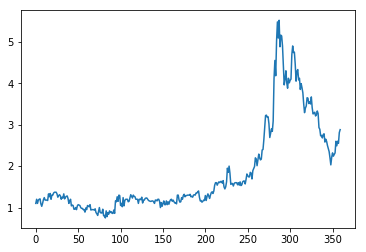

In [41]:
print np.any(np.isnan(X))
plt.plot(X[1][:,0])

In [68]:
def fillwithlast(df,cc,inds):
    y=df[cc].values
    
    
def Clean_dataset(dfX,dfY,skipifNanRows_gte=0.5,fillXNaN_method='repeatlast',fillYNaN_method='repeatlast',coltypesX={},coltypesY={}):
#     assert len(dfX)==len(dfY), "len(dfX)!=len(dfY)"
    dfX.index=range(len(dfX))
    dfY.index=range(len(dfY))
    
    L=len(dfX)
    number_of_fullNan_rows_Xindex=dfX[dfX.isnull().any(axis=1)].index
    if len(number_of_fullNan_rows_Xindex)/L>=skipifNanRows_gte:
        return (None,None)
    
    number_of_fullNan_rows_Yindex=dfY[dfY.isnull().any(axis=1)].index
    if len(number_of_fullNan_rows_Yindex)/L>=skipifNanRows_gte:
        return (None,None)
    
    if len(number_of_fullNan_rows_Xindex)>0:
        if fillNaNX_method=='0':
            dfX=dfX.fillna(value=0)
        if fillNaNX_method=='repeatlast':
            dfX=dfX.fillna(method='bfill')
            
    if len(number_of_fullNan_rows_Yindex)>0:
        if fillNaNY_method=='0':
            dfY=dfY.fillna(0)
        if fillNaNY_method=='repeatlast':
            dfY=dfY.fillna(method='bfill')
    
    for cc in dfX.columns:
        if cc in coltypesX:
            dfX[cc]=dfX[cc].astype(coltypesX[cc])
    
    for cc in dfY.columns:
        if cc in coltypesY:
            dfY[cc]=dfY[cc].astype(coltypesY[cc])
            
            
    return (dfX,dfY)

def flatten(df):
    return np.expand_dims(df.astype(float).values.flatten(order='F') ,axis=0)  
    
coltypesX=dict([(ky,float) for ky in Meta['colX']])
coltypesY=dict([(ky,float) for ky in Meta['colY']])
coltypesX['SectorId']=int
coltypesX['IndustryId']=int
coltypesY['SectorId']=int
coltypesY['IndustryId']=int

i=0
dfX=pd.DataFrame(X[i],columns=Meta['colX'])
dfY=pd.DataFrame(Y[i],columns=Meta['colY'])

dfX,dfY=Clean_dataset(dfX,dfY=dfY,skipifNanRows_gte=0.5,fillXNaN_method='repeatlast',fillYNaN_method='repeatlast',coltypesX=coltypesX,coltypesY=coltypesY)
dfX

,Close,Open,High,Low,Volume,SectorId,IndustryId,CCI5,CCI50,SMA10,SMA100,SMA20,SMA200,SMA50,SMAstd20,VolSMA10,VolSMA20
0,1.20,1.10,1.20,1.05,31100.0,6,18,101.449275,-86.246028,1.174,1.3098,1.1885,1.17190,1.3266,0.085426,10150.0,7435.0
1,1.20,1.17,1.20,1.17,12100.0,6,18,136.200717,-65.031948,1.164,1.3118,1.1805,1.17265,1.3176,0.075427,11320.0,8040.0
2,1.10,1.06,1.20,1.06,8900.0,6,18,-55.555556,-95.953727,1.151,1.3128,1.1755,1.17285,1.3092,0.077356,11800.0,7940.0
3,1.20,1.19,1.20,1.19,500.0,6,18,91.503268,-56.041902,1.153,1.3144,1.1740,1.17325,1.3032,0.076530,11470.0,7810.0
4,1.10,1.11,1.21,1.10,700.0,6,18,-52.884615,-83.299745,1.144,1.3154,1.1785,1.17340,1.2972,0.068616,10830.0,7625.0
5,1.18,1.11,1.18,1.10,3700.0,6,18,-14.705882,-72.277803,1.143,1.3171,1.1710,1.17335,1.2926,0.058660,11110.0,7615.0
6,1.20,1.15,1.21,1.15,32600.0,6,18,70.707071,-53.699203,1.153,1.3189,1.1735,1.17380,1.2876,0.058784,14230.0,8980.0
7,1.21,1.20,1.23,1.20,2800.0,6,18,92.783505,-38.532846,1.164,1.3203,1.1765,1.17435,1.2818,0.059052,12600.0,9120.0
8,1.09,1.16,1.24,1.05,13500.0,6,18,-83.333333,-82.411980,1.163,1.3208,1.1710,1.17420,1.2716,0.061806,13830.0,9640.0
9,1.03,1.09,1.16,1.03,26700.0,6,18,-127.192982,-108.417153,1.151,1.3206,1.1665,1.17375,1.2646,0.068616,13260.0,10510.0


In [62]:
df

,Close,Open,High,Low,Volume,SectorId,IndustryId,CCI5,CCI50,SMA10,SMA100,SMA20,SMA200,SMA50,SMAstd20,VolSMA10,VolSMA20
0,1.20,1.10,1.20,1.05,31100.0,6.0,18.0,101.449275,-86.246028,1.174,1.3098,1.1885,1.17190,1.3266,0.085426,10150.0,7435.0
1,1.20,1.17,1.20,1.17,12100.0,6.0,18.0,136.200717,-65.031948,1.164,1.3118,1.1805,1.17265,1.3176,0.075427,11320.0,8040.0
2,1.10,1.06,1.20,1.06,8900.0,6.0,18.0,-55.555556,-95.953727,1.151,1.3128,1.1755,1.17285,1.3092,0.077356,11800.0,7940.0
3,1.20,1.19,1.20,1.19,500.0,6.0,18.0,91.503268,-56.041902,1.153,1.3144,1.1740,1.17325,1.3032,0.076530,11470.0,7810.0
4,1.10,1.11,1.21,1.10,700.0,6.0,18.0,-52.884615,-83.299745,1.144,1.3154,1.1785,1.17340,1.2972,0.068616,10830.0,7625.0
5,1.18,1.11,1.18,1.10,3700.0,6.0,18.0,-14.705882,-72.277803,1.143,1.3171,1.1710,1.17335,1.2926,0.058660,11110.0,7615.0
6,1.20,1.15,1.21,1.15,32600.0,6.0,18.0,70.707071,-53.699203,1.153,1.3189,1.1735,1.17380,1.2876,0.058784,14230.0,8980.0
7,1.21,1.20,1.23,1.20,2800.0,6.0,18.0,92.783505,-38.532846,1.164,1.3203,1.1765,1.17435,1.2818,0.059052,12600.0,9120.0
8,1.09,1.16,1.24,1.05,13500.0,6.0,18.0,-83.333333,-82.411980,1.163,1.3208,1.1710,1.17420,1.2716,0.061806,13830.0,9640.0
9,1.03,1.09,1.16,1.03,26700.0,6.0,18.0,-127.192982,-108.417153,1.151,1.3206,1.1665,1.17375,1.2646,0.068616,13260.0,10510.0


In [106]:
import pickle as pkl
filepath='trainingdata/Data_KEYW_1022.h5'
data=dtalibs.load_h5(filepath,['X','Y','Meta'])
data['Meta']

{'T': [datetime.date(2010, 1, 4),
  datetime.date(2010, 1, 6),
  datetime.date(2010, 1, 8),
  datetime.date(2010, 1, 11),
  datetime.date(2010, 1, 13),
  datetime.date(2010, 1, 15),
  datetime.date(2010, 1, 20),
  datetime.date(2010, 1, 22),
  datetime.date(2010, 1, 25),
  datetime.date(2010, 1, 27),
  datetime.date(2010, 1, 29),
  datetime.date(2010, 2, 1),
  datetime.date(2010, 2, 3),
  datetime.date(2010, 2, 5),
  datetime.date(2010, 2, 8),
  datetime.date(2010, 2, 10),
  datetime.date(2010, 2, 12),
  datetime.date(2010, 2, 17),
  datetime.date(2010, 2, 19),
  datetime.date(2010, 2, 22),
  datetime.date(2010, 2, 24),
  datetime.date(2010, 2, 26),
  datetime.date(2010, 3, 1),
  datetime.date(2010, 3, 3),
  datetime.date(2010, 3, 5),
  datetime.date(2010, 3, 8),
  datetime.date(2010, 3, 10),
  datetime.date(2010, 3, 12),
  datetime.date(2010, 3, 15),
  datetime.date(2010, 3, 17),
  datetime.date(2010, 3, 19),
  datetime.date(2010, 3, 22),
  datetime.date(2010, 3, 24),
  datetime.date(

In [10]:


L=[1,2,3,4,5,6,7]
for s in utls.chunkify(L,8):
    print s


[1, 2, 3, 4, 5, 6, 7]


In [67]:
import h5py
import json
import datetime
class DateTimeEncoder(json.JSONEncoder):
    def default(self, o):
        if isinstance(o, datetime):
            return o.isoformat()

        return json.JSONEncoder.default(self, o)

def json_serial(obj):
    """JSON serializer for objects not serializable by default json code"""

    if isinstance(obj, (datetime.datetime, datetime.date)):
        return obj.isoformat()
    raise TypeError ("Type %s not serializable" % type(obj))
    
def saveas_h5(filepath,**kwargs):
    jsonmodified=DateTimeEncoder()
    h5f = h5py.File(filepath, 'w')
    for key,value in kwargs.items():
        if type(value)==dict:
            string_dt = h5py.special_dtype(vlen=str)
            h5f.create_dataset('key', data=np.array([json.dumps(value,default=json_serial)]), dtype=string_dt)
        else:
            h5f.create_dataset(key, data=value,compression="gzip")
    h5f.close()
    
X=np.ones(10)
Meta={'T':[T,T]}
saveas_h5('test3.h5',X=X,Meta=Meta)

In [ ]:
def FeatureExtractX(df):
    